In [1]:
!conda install pandas seaborn -y

Solving environment: done

# All requested packages already installed.



In [2]:
!pip install opencv-python torchsummary scikit-learn torchviz utils imageio

In [3]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import utils
import time
from torch.nn.functional import one_hot
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.get_arch_list(), device)

['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37'] cuda


In [5]:
from __future__ import print_function
import argparse
import datetime
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import clear_output
from tqdm import tqdm
import os
from tqdm import notebook
from sklearn.metrics import classification_report, confusion_matrix
import gc
import matplotlib.colors as mat_color
import numpy as np
from PIL import Image
import random
import cv2
from torchvision.datasets import ImageNet, ImageFolder
from torch.utils.data import DataLoader
from torchsummary import summary
from torchviz import make_dot
import imageio
from torchvision import datasets, transforms

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):

    def __init__(self, nz, ngf, nc):

        super(Generator, self).__init__()
        self.ReLU = nn.ReLU(True)
        self.Tanh = nn.Tanh()
        self.conv1 = nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(ngf * 8)

        self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 8, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ngf * 8)

        self.conv3 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ngf * 4)

        self.conv4 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ngf * 2)
        
        self.conv5 = nn.ConvTranspose2d(ngf * 2, ngf * 1, 4, 2, 1, bias=False)
        self.BatchNorm5 = nn.BatchNorm2d(ngf * 1)

        self.conv6 = nn.ConvTranspose2d(ngf * 1, nc, 4, 2, 1, bias=False)

        self.apply(weights_init)


    def forward(self, input):
        x = self.conv1(input)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        
        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.ReLU(x)

        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.ReLU(x)

        x = self.conv5(x)
        x = self.BatchNorm5(x)
        x = self.ReLU(x)

        x = self.conv6(x)
        output = self.Tanh(x)
        return output

class Discriminator(nn.Module):

    def __init__(self, ndf, nc, nb_label):

        super(Discriminator, self).__init__()
        self.LeakyReLU = nn.LeakyReLU(0.2, inplace=True)
        self.DropOut1 = nn.Dropout(p=0.5)
        self.DropOut2 = nn.Dropout(p=0.25)
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(ndf)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ndf * 4)
        self.conv4_1 = nn.Conv2d(ndf * 4, ndf * 4, 4, 2, 1, bias=False)
        self.BatchNorm4_1 = nn.BatchNorm2d(ndf * 4)
        self.conv4_2 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.BatchNorm4_2 = nn.BatchNorm2d(ndf * 8)
        self.conv4_3 = nn.Conv2d(ndf * 8, ndf * 8, 4, 2, 1, bias=False)
        self.BatchNorm4_3 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, ndf * 1, 4, 1, 0, bias=False)
        self.disc_linear = nn.Linear(ndf * 1, 1)
        self.aux_linear = nn.Linear(ndf * 1, nb_label)
        self.softmax = nn.LogSoftmax()
        self.sigmoid = nn.Sigmoid()
        self.ndf = ndf
        self.apply(weights_init)

    def forward(self, input):

        x = self.conv1(input)
        x = self.BatchNorm1(x)
        x = self.LeakyReLU(x)
        x = self.DropOut2(x)

        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.LeakyReLU(x)
        x = self.DropOut2(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.LeakyReLU(x)
        x = self.DropOut2(x)

        x = self.conv4_2(x)
        x = self.BatchNorm4_2(x)
        x = self.LeakyReLU(x)
        x = self.DropOut2(x)
        x = self.conv4_3(x)
        x = self.BatchNorm4_3(x)
        x = self.LeakyReLU(x)
        x = self.DropOut2(x)

        x = self.conv5(x)
        x = x.view(-1, self.ndf * 1)
        c = self.aux_linear(x)
        c = self.softmax(c)
        s = self.disc_linear(x)
        s = self.sigmoid(s)
        return s, c

In [7]:
def generate_animation(path, num):
    images = []
    for e in range(num):
        img_name = path + '_generate_animation_epoch%03d' % (e+1) + '.jpg'
        images.append(imageio.imread(img_name))
    imageio.mimsave(path + '_generate_animation.gif', images, fps=5)

def loss_plot(hist, path='Train_hist', model_name = ''):
    x = range(len(hist['D_losses']))

    plt.plot(x, hist['D_losses'], label='D_losses')
    plt.plot(x, hist['G_losses'], label='G_losses')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')
    plt.savefig(path)
    plt.close()

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

def imsave(images, size, path):
    image = np.squeeze(merge(images, size))
    print("image saved at ->", path)
    return imageio.imwrite(path, image)

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter ''must have dimensions: HxW or HxWx3 or HxWx4')

In [8]:
class ACGAN(object):
    def __init__(self):
        self.model_name = 'ACGAN'
        self.I_want_to_train_faster = 10
        self.num_epoch = round(12800/self.I_want_to_train_faster)
        self.base_path = './data'
        self.base_folder = "Covid-19 Image Dataset"
        self.classic_folder = 'Coivd-19_Hist'
        self.synthetic_folder = 'Coivd-19_Synthetic'
        self.data_dir = os.path.join(self.base_path, self.classic_folder)
        self.batch_size = 32
        self.train_path = os.path.join(self.data_dir, "train")
        self.test_path = os.path.join(self.data_dir, "test")
        self.labels = os.listdir(self.train_path)
        self.no_norm = mat_color.Normalize(vmin=0, vmax=255, clip=False)
        self.label_dict = {
            i : self.labels[i]
            for i in range(len(self.labels))
        }
        self.img_size = 128
        self.num_of_ch = 1
        # size of z latent vector (i.e. size of generator input)
        self.size_of_z = 512
        self.num_of_label = len(self.labels)
        self.sample_num = 64 # self.num_of_label ** 2
        self.learning_rate_g = 0.000006 * self.I_want_to_train_faster
        self.learning_rate_d = 0.000005 * self.I_want_to_train_faster
        # beta1 hyperparam for adam
        self.adam_beta_1 = 0.5
        # beta2 hyperparam for adam
        self.adam_beta_2 = 0.999
        self.real_label = 1.0
        self.fake_label = 0.0
        self.syn_criterion = nn.BCELoss().to(device) # synthesizing
        self.class_criterion = nn.CrossEntropyLoss().to(device) # classification
        
        self.train_loader, self.test_loader, self.train_data, self.test_data = self.load_dataset()
        self.generator = Generator(self.size_of_z, self.img_size, self.num_of_ch).to(device)
        self.discriminator = Discriminator(self.img_size, self.num_of_ch, self.num_of_label).to(device)

        self.optimizer_d = optim.Adam(self.discriminator.parameters(), 
                                      lr=self.learning_rate_d, 
                                      betas=(self.adam_beta_1, self.adam_beta_2))
        self.optimizer_g = optim.Adam(self.generator.parameters(), 
                                      lr=self.learning_rate_g, 
                                      betas=(self.adam_beta_1, self.adam_beta_2))

        # fixed noise & label
        self.sample_z_fixed = torch.zeros((self.sample_num, self.size_of_z))
        for i in range(round(np.sqrt(self.sample_num))):
            self.sample_z_fixed[i*round(np.sqrt(self.sample_num))] = torch.rand(1, self.size_of_z)
            for j in range(1, round(np.sqrt(self.sample_num))):
                self.sample_z_fixed[i*round(np.sqrt(self.sample_num)) + j] = self.sample_z_fixed[i*round(np.sqrt(self.sample_num))]

        self.sample_z_fixed.resize_(self.sample_num, self.size_of_z, 1, 1)
        temp = torch.zeros((self.num_of_label, 1))
        for i in range(self.num_of_label):
            temp[i, 0] = i

        temp_y = torch.zeros((self.sample_num, 1))
        for i in range(self.num_of_label):
            temp_y[i*self.num_of_label: (i+1)*self.num_of_label] = temp

        self.sample_y_fixed = torch.zeros((self.sample_num, self.num_of_label)).scatter_(1, temp_y.type(torch.LongTensor), 1)
        self.sample_z_fixed, self.sample_y_fixed = self.sample_z_fixed.to(device), self.sample_y_fixed.to(device)
        
    def load_dataset(self):
        train_dir = self.train_path
        test_dir = self.test_path
        transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=0.5, std=0.5),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        train_data = datasets.ImageFolder(train_dir, transform=transform)
        train_loader = DataLoader(train_data, self.batch_size, shuffle=True, num_workers=1)

        test_data = datasets.ImageFolder(test_dir ,transform=transform)
        test_loader = DataLoader(test_data, self.batch_size, shuffle=True, num_workers=1)

        return train_loader, test_loader, train_data, test_data

    def modeltorchviz(model, input_1, input_2):
        if input_2 != None:
            y = model(input_1.to(device), input_2.to(device))
        else:
            y = model(input_1.to(device))
        if input_2 != None:
            MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', input_1)] + [('x', input_2)]))
        else:
            MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', input_1)]))
        MyConvNetVis.format = "png"
        MyConvNetVis.directory = "images"
        MyConvNetVis.view() 
    
    def visualize_results(self, epoch, fix=True):
        self.generator.eval()

        image_frame_dim = round(np.sqrt(self.sample_num))
        if fix:
            """ fixed noise """
            samples = self.generator(self.sample_z_fixed)
        else:
            """ random noise """
            sample_y_ = torch.zeros(self.batch_size, self.class_num).scatter_(1, torch.randint(0, self.class_num - 1, (self.batch_size, 1)).type(torch.LongTensor), 1)
            sample_z_ = torch.rand((self.batch_size, self.z_dim))
            sample_z_, sample_y_ = sample_z_.cuda(), sample_y_.cuda()
            samples = self.generator(sample_z_, sample_y_)

        samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        samples = (samples + 1) / 2
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                    os.path.join('.', 'GANAug/plots/ACGAN') + "/" + self.model_name + '_generate_animation_epoch%03d' % epoch + '.png')
    
    def train(self):
        for func in [
            lambda: os.mkdir(os.path.join('.', 'GANAug')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/model')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/plots')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/model/ACGAN')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/plots/ACGAN')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images')),
            lambda: os.mkdir(os.path.join('.', 'GANAug/output_images/ACGAN'))]:
            try:
                func()
            except Exception as error:
                print(error)
                continue
        matrix_fields = [
            'G_losses',
            'G_class_losses',
            'G_syn_losses',
            'D_losses',
            'D_real_losses',
            'D_fake_losses',
            'D_class_losses',
            'D_syn_losses',
            'Losses',
            'Time_per_epoch',
            'Total_time'
        ]
        self.metrics = {field: list() for field in matrix_fields}
        early_stop_count = 0
        early_stop_patient = len(self.train_loader) * 42
        early_stop = False
        best_batch_loss = -1
        save_model = False
        number_of_model_saved = 10
        label_fixed_data = [i%self.num_of_label for i in range(self.sample_num)]
        
        def get_file_list(file_path, length):
            dir_list = os.listdir(file_path)
            dir_list = only_pth_file(dir_list)
            if not dir_list:
                return
            else:
                dir_list = sorted(dir_list,  key=lambda x: os.path.getmtime(os.path.join(file_path, x)))
                print("files to be deleted < length =", length ,"> ->", dir_list[0:length])
                return dir_list[0:length]

        def only_pth_file(file_list):
            new_list = []
            for file in file_list:
                if file[-4:] == ".pth":
                    new_list.append(file)
            return new_list
            
        start_time = time.time()
        print("Start Testing ...")
        print(self.generator)
        print(self.discriminator)
        summary(self.generator, (self.size_of_z, 1, 1), batch_size=self.batch_size, device=device)
        summary(self.discriminator, (self.num_of_ch, self.img_size, self.img_size), batch_size=self.batch_size, device=device)
        g_output = self.generator(torch.rand((self.batch_size, self.size_of_z, 1, 1)).to(device))
        print(g_output.shape)
        s_output, c_output = self.discriminator(torch.rand(g_output.shape).to(device))
        print(s_output.shape)
        print(c_output.shape)
        del g_output, s_output, c_output
        print("Testing Done in ->", time.time() - start_time)
        start_time = time.time()
        print("Start Training ...")

        self.discriminator.train()
        for epoch in range(self.num_epoch):
            epoch += 1
            log_in_data_loader = []
            self.generator.train()
            epoch_start_time = time.time()
            for i, data in enumerate(tqdm(self.train_loader, 0)):
                x_, y_ = data
                batch_size_x_ = x_.size(0)
                z_ = torch.rand((batch_size_x_, self.size_of_z, 1, 1))
                y_vec_ = torch.zeros((batch_size_x_, self.num_of_label)).scatter_(1, y_.type(torch.LongTensor).unsqueeze(1), 1)
                x_, z_, y_vec_ = x_.cuda(), z_.cuda(), y_vec_.cuda()
                self.y_real_, self.y_fake_ = torch.ones(batch_size_x_, 1), torch.zeros(batch_size_x_, 1)
                self.y_real_, self.y_fake_ = self.y_real_.to(device), self.y_fake_.to(device)
        
                # update D network
                self.optimizer_d.zero_grad()

                D_real, C_real = self.discriminator(x_)
                D_real_loss = self.syn_criterion(D_real, self.y_real_)
                C_real_loss = self.class_criterion(C_real, torch.max(y_vec_, 1)[1])

                G_ = self.generator(z_)
                D_fake, C_fake = self.discriminator(G_)
                D_fake_loss = self.syn_criterion(D_fake, self.y_fake_)
                C_fake_loss = self.class_criterion(C_fake, torch.max(y_vec_, 1)[1])

                D_loss = D_real_loss + C_real_loss
                D_loss.backward()

                D_fake_loss.backward()
                self.optimizer_d.step()
                D_loss += D_fake_loss # + C_fake_losss
                self.metrics['D_losses'].append(D_loss.item())
                self.metrics['D_real_losses'].append((D_real_loss + C_real_loss).item())
                self.metrics['D_fake_losses'].append((D_fake_loss + C_fake_loss).item())
                self.metrics['D_class_losses'].append((C_real_loss + C_fake_loss).item())
                self.metrics['D_syn_losses'].append((D_real_loss + D_fake_loss).item())

                # update G network
                self.optimizer_g.zero_grad()

                G_ = self.generator(z_)
                D_fake, C_fake = self.discriminator(G_)

                D_fake_loss = self.syn_criterion(D_fake, self.y_real_)
                C_fake_loss = self.class_criterion(C_fake, torch.max(y_vec_, 1)[1])
                D_fake_loss.backward()
                self.optimizer_g.step()

                G_loss = D_fake_loss # + C_fake_loss
                self.metrics['G_losses'].append(G_loss.item())
                self.metrics['G_syn_losses'].append(D_fake_loss.item())
                self.metrics['G_class_losses'].append(C_fake_loss.item())
                self.metrics['Losses'].append(self.metrics['G_losses'][-1] + self.metrics['D_losses'][-1])

                if best_batch_loss < 0:
                    best_batch_loss = self.metrics['Losses'][-1]
                    early_stop_count = 0
                else:
                    if best_batch_loss >= self.metrics['Losses'][-1]:
                        best_batch_loss = self.metrics['Losses'][-1]
                        early_stop_count = 0
                        log_in_data_loader.append("---------------------<lowest loss update -> " + str(best_batch_loss) + " at -> " + str(i + 1) + ">---------------------")
                        save_model = True
                    else:
                        early_stop_count += 1
                        if early_stop_count >= early_stop_patient:
                            log_in_data_loader.append("-----------------------------------< early stopping ... >-----------------------------------")
                            early_stop = True

                if i == 0:
                    vutils.save_image(x_, './GANAug/output_images/ACGAN/real_samples_e' + str(epoch) + '_d' + str(i) + '.jpg', normalize=True)

            self.metrics['Time_per_epoch'].append(time.time() - epoch_start_time)
            fake = self.generator(self.sample_z_fixed)
            vutils.save_image(fake.data,
                    '%s/ACGAN_generate_animation_epoch%03d' % ('./GANAug/plots/ACGAN', epoch) + '.jpg', normalize=True)
    
            for message in log_in_data_loader:
                print(message)
            print('[%d/%d] ======================================================================== \nLoss_D: %.8f, Loss_G: %.8f\nLoss_S_D: %.8f, Loss_C_D: %.8f, Loss_R_D: %.8f, Loss_F_D: %.8f\nLoss_S_G: %.8f, Loss_C_G: %.8f'
                  % (epoch, self.num_epoch, 
                     np.mean(self.metrics['D_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['G_losses'][-len(self.train_loader):]),
                     np.mean(self.metrics['D_syn_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['D_class_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['D_real_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['D_fake_losses'][-len(self.train_loader):]), 
                     np.mean(self.metrics['G_syn_losses'][-len(self.train_loader):]),
                     np.mean(self.metrics['G_class_losses'][-len(self.train_loader):])))

            # do checkpointing
            if save_model == True:
                save_model = False
                torch.save(self.generator.state_dict(), '%s/G_epoch_%d_save_model.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
                torch.save(self.discriminator.state_dict(), '%s/D_epoch_%d_save_model.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
            elif early_stop:
                torch.save(self.generator.state_dict(), '%s/G_epoch_%d_early_stop.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
                torch.save(self.discriminator.state_dict(), '%s/D_epoch_%d_early_stop.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
            elif epoch % round(self.num_epoch/5) == 0:
                torch.save(self.generator.state_dict(), '%s/G_epoch_%d.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
                torch.save(self.discriminator.state_dict(), '%s/D_epoch_%d.pth' % (os.path.join('.', 'GANAug/model/ACGAN'), epoch))
            else:
                print("---------------------< no model saved at epoch:", epoch, ">---------------------")

            if len(only_pth_file(os.listdir(os.path.join('.', 'GANAug/model/ACGAN')))) > number_of_model_saved:
                delete_list = get_file_list(os.path.join('.', 'GANAug/model/ACGAN'), 
                                            len(only_pth_file(os.listdir(os.path.join('.', 'GANAug/model/ACGAN')))) - number_of_model_saved)
                for file in delete_list:
                    if os.path.exists(os.path.join(os.path.join('.', 'GANAug/model/ACGAN'), file)):
                        os.remove(os.path.join(os.path.join('.', 'GANAug/model/ACGAN'), file))
                    else:
                        print("file ->", os.path.join(os.path.join('.', 'GANAug/model/ACGAN'), file), "does not exist")

        self.metrics['Total_time'].append(time.time() - start_time)
        print("Average epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.metrics['Time_per_epoch']),
                                                                        self.num_epoch, self.metrics['Total_time'][0]))
        generate_animation(os.path.join('.', 'GANAug/plots/ACGAN/') + self.model_name, self.num_epoch)
        loss_plot(self.metrics, os.path.join('.', 'GANAug/plots/ACGAN/'), self.model_name + "_loss_plot")
        print("Training Done !")

In [9]:
acgan = ACGAN()

In [10]:
acgan.train()

Start Testing ...
Generator(
  (ReLU): ReLU(inplace=True)
  (Tanh): Tanh()
  (conv1): ConvTranspose2d(512, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (BatchNorm1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm5): BatchNorm2d(128, eps=1e-05, mom

/tmp/ipykernel_501632/1298441974.py:118: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  c = self.softmax(c)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [32, 1024, 4, 4]       8,388,608
       BatchNorm2d-2           [32, 1024, 4, 4]           2,048
              ReLU-3           [32, 1024, 4, 4]               0
   ConvTranspose2d-4           [32, 1024, 8, 8]      16,777,216
       BatchNorm2d-5           [32, 1024, 8, 8]           2,048
              ReLU-6           [32, 1024, 8, 8]               0
   ConvTranspose2d-7          [32, 512, 16, 16]       8,388,608
       BatchNorm2d-8          [32, 512, 16, 16]           1,024
              ReLU-9          [32, 512, 16, 16]               0
  ConvTranspose2d-10          [32, 256, 32, 32]       2,097,152
      BatchNorm2d-11          [32, 256, 32, 32]             512
             ReLU-12          [32, 256, 32, 32]               0
  ConvTranspose2d-13          [32, 128, 64, 64]         524,288
      BatchNorm2d-14          [32, 128,

100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


[1/1280] ======================================================================== 
Loss_D: 3.94884747, Loss_G: 2.27742255
Loss_S_D: 2.79686871, Loss_C_D: 2.51424178, Loss_R_D: 1.89233388, Loss_F_D: 3.41877663
Loss_S_G: 2.27742255, Loss_C_G: 1.47391513
---------------------< no model saved at epoch: 1 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.18it/s]


[2/1280] ======================================================================== 
Loss_D: 2.40963054, Loss_G: 3.54472226
Loss_S_D: 1.83932184, Loss_C_D: 1.88619640, Loss_R_D: 1.36002773, Loss_F_D: 2.36549056
Loss_S_G: 3.54472226, Loss_C_G: 1.49210529
---------------------< no model saved at epoch: 2 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.17it/s]


---------------------<lowest loss update -> 4.741773366928101 at -> 6>---------------------
[3/1280] ======================================================================== 
Loss_D: 2.00623757, Loss_G: 3.88154837
Loss_S_D: 1.60790662, Loss_C_D: 1.91644806, Loss_R_D: 1.23071605, Loss_F_D: 2.29363865
Loss_S_G: 3.88154837, Loss_C_G: 1.36167188


100%|██████████| 8/8 [00:02<00:00,  3.17it/s]


[4/1280] ======================================================================== 
Loss_D: 1.69446743, Loss_G: 4.37849274
Loss_S_D: 1.37589020, Loss_C_D: 1.68245521, Loss_R_D: 1.07825958, Loss_F_D: 1.98008585
Loss_S_G: 4.37849274, Loss_C_G: 1.39947918
---------------------< no model saved at epoch: 4 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


---------------------<lowest loss update -> 3.69441819190979 at -> 1>---------------------
---------------------<lowest loss update -> 3.0441001057624817 at -> 7>---------------------
[5/1280] ======================================================================== 
Loss_D: 2.27932027, Loss_G: 4.35473496
Loss_S_D: 2.00916073, Loss_C_D: 1.86124548, Loss_R_D: 1.29839737, Loss_F_D: 2.57200886
Loss_S_G: 4.35473496, Loss_C_G: 1.44887540


100%|██████████| 8/8 [00:02<00:00,  3.16it/s]


[6/1280] ======================================================================== 
Loss_D: 3.14732590, Loss_G: 3.32474587
Loss_S_D: 2.86419195, Loss_C_D: 1.79053229, Loss_R_D: 1.94852696, Loss_F_D: 2.70619731
Loss_S_G: 3.32474587, Loss_C_G: 1.41492496
---------------------< no model saved at epoch: 6 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


[7/1280] ======================================================================== 
Loss_D: 2.94277319, Loss_G: 2.42985719
Loss_S_D: 2.71688297, Loss_C_D: 1.64407942, Loss_R_D: 1.89132068, Loss_F_D: 2.46964170
Loss_S_G: 2.42985719, Loss_C_G: 1.47703791
---------------------< no model saved at epoch: 7 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.16it/s]


[8/1280] ======================================================================== 
Loss_D: 2.38789454, Loss_G: 2.49632898
Loss_S_D: 2.21764450, Loss_C_D: 1.70875217, Loss_R_D: 1.49721537, Loss_F_D: 2.42918134
Loss_S_G: 2.49632898, Loss_C_G: 1.43803371
---------------------< no model saved at epoch: 8 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


[9/1280] ======================================================================== 
Loss_D: 1.94805877, Loss_G: 3.22563601
Loss_S_D: 1.79929553, Loss_C_D: 1.64771619, Loss_R_D: 1.17800406, Loss_F_D: 2.26900765
Loss_S_G: 3.22563601, Loss_C_G: 1.47152848
---------------------< no model saved at epoch: 9 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


[10/1280] ======================================================================== 
Loss_D: 2.02260160, Loss_G: 3.62537721
Loss_S_D: 1.85065421, Loss_C_D: 1.75301176, Loss_R_D: 1.24115200, Loss_F_D: 2.36251393
Loss_S_G: 3.62537721, Loss_C_G: 1.52508670
---------------------< no model saved at epoch: 10 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


[11/1280] ======================================================================== 
Loss_D: 1.74918169, Loss_G: 3.93310732
Loss_S_D: 1.61426969, Loss_C_D: 1.65127499, Loss_R_D: 1.02878137, Loss_F_D: 2.23676321
Loss_S_G: 3.93310732, Loss_C_G: 1.51415542
---------------------< no model saved at epoch: 11 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[12/1280] ======================================================================== 
Loss_D: 2.44594719, Loss_G: 4.35091898
Loss_S_D: 2.27975930, Loss_C_D: 2.07981206, Loss_R_D: 1.44342757, Loss_F_D: 2.91614375
Loss_S_G: 4.35091898, Loss_C_G: 1.95930672
---------------------< no model saved at epoch: 12 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.16it/s]


[13/1280] ======================================================================== 
Loss_D: 2.70059298, Loss_G: 3.64260632
Loss_S_D: 2.56791186, Loss_C_D: 1.58737011, Loss_R_D: 1.79439186, Loss_F_D: 2.36089011
Loss_S_G: 3.64260632, Loss_C_G: 1.44074431
---------------------< no model saved at epoch: 13 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


[14/1280] ======================================================================== 
Loss_D: 2.90972748, Loss_G: 4.43439510
Loss_S_D: 2.77751707, Loss_C_D: 1.60575694, Loss_R_D: 1.76101580, Loss_F_D: 2.62225826
Loss_S_G: 4.43439510, Loss_C_G: 1.45956054
---------------------< no model saved at epoch: 14 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


[15/1280] ======================================================================== 
Loss_D: 1.55221996, Loss_G: 4.33289585
Loss_S_D: 1.40942350, Loss_C_D: 2.65644728, Loss_R_D: 0.95343994, Loss_F_D: 3.11243093
Loss_S_G: 4.33289585, Loss_C_G: 2.26002449
---------------------< no model saved at epoch: 15 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


[16/1280] ======================================================================== 
Loss_D: 2.20872793, Loss_G: 4.31272531
Loss_S_D: 2.07512639, Loss_C_D: 1.75305404, Loss_R_D: 1.41342895, Loss_F_D: 2.41475157
Loss_S_G: 4.31272531, Loss_C_G: 1.58496489
---------------------< no model saved at epoch: 16 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


[17/1280] ======================================================================== 
Loss_D: 3.30871338, Loss_G: 3.47900108
Loss_S_D: 3.18271193, Loss_C_D: 1.52473646, Loss_R_D: 2.12245553, Loss_F_D: 2.58499290
Loss_S_G: 3.47900108, Loss_C_G: 1.37626116
---------------------< no model saved at epoch: 17 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[18/1280] ======================================================================== 
Loss_D: 1.40620936, Loss_G: 3.68547273
Loss_S_D: 1.26919606, Loss_C_D: 1.58951929, Loss_R_D: 0.91314703, Loss_F_D: 1.94556829
Loss_S_G: 3.68547273, Loss_C_G: 1.47163635
---------------------< no model saved at epoch: 18 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


[19/1280] ======================================================================== 
Loss_D: 2.29647496, Loss_G: 3.92858747
Loss_S_D: 2.17935032, Loss_C_D: 1.62199810, Loss_R_D: 1.35656162, Loss_F_D: 2.44478680
Loss_S_G: 3.92858747, Loss_C_G: 1.57988560
---------------------< no model saved at epoch: 19 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


[20/1280] ======================================================================== 
Loss_D: 2.13800181, Loss_G: 3.46574965
Loss_S_D: 2.01471427, Loss_C_D: 1.94069900, Loss_R_D: 1.31468514, Loss_F_D: 2.64072806
Loss_S_G: 3.46574965, Loss_C_G: 1.87426761
---------------------< no model saved at epoch: 20 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


[21/1280] ======================================================================== 
Loss_D: 1.55816683, Loss_G: 3.48223424
Loss_S_D: 1.43002042, Loss_C_D: 2.64981249, Loss_R_D: 1.01815359, Loss_F_D: 3.06167930
Loss_S_G: 3.48223424, Loss_C_G: 2.49171375
---------------------< no model saved at epoch: 21 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[22/1280] ======================================================================== 
Loss_D: 1.42171055, Loss_G: 3.98051387
Loss_S_D: 1.31724474, Loss_C_D: 2.13512850, Loss_R_D: 0.95196906, Loss_F_D: 2.50040418
Loss_S_G: 3.98051387, Loss_C_G: 1.99894378
---------------------< no model saved at epoch: 22 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


[23/1280] ======================================================================== 
Loss_D: 2.52283084, Loss_G: 3.91704047
Loss_S_D: 2.41098888, Loss_C_D: 1.65617903, Loss_R_D: 1.51366051, Loss_F_D: 2.55350746
Loss_S_G: 3.91704047, Loss_C_G: 1.48893531
---------------------< no model saved at epoch: 23 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


[24/1280] ======================================================================== 
Loss_D: 1.86667144, Loss_G: 4.01243436
Loss_S_D: 1.76405334, Loss_C_D: 2.75605977, Loss_R_D: 1.12415129, Loss_F_D: 3.39596182
Loss_S_G: 4.01243436, Loss_C_G: 2.49520074
---------------------< no model saved at epoch: 24 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[25/1280] ======================================================================== 
Loss_D: 2.16305687, Loss_G: 3.26337168
Loss_S_D: 2.06718816, Loss_C_D: 1.65941969, Loss_R_D: 1.36383497, Loss_F_D: 2.36277285
Loss_S_G: 3.26337168, Loss_C_G: 1.49695233
---------------------< no model saved at epoch: 25 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[26/1280] ======================================================================== 
Loss_D: 1.66437523, Loss_G: 3.33047582
Loss_S_D: 1.58506170, Loss_C_D: 2.16676310, Loss_R_D: 0.99172178, Loss_F_D: 2.76010302
Loss_S_G: 3.33047582, Loss_C_G: 2.02836762
---------------------< no model saved at epoch: 26 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


[27/1280] ======================================================================== 
Loss_D: 1.55307367, Loss_G: 3.64771354
Loss_S_D: 1.45699039, Loss_C_D: 2.15206939, Loss_R_D: 0.85483627, Loss_F_D: 2.75422350
Loss_S_G: 3.64771354, Loss_C_G: 2.13240752
---------------------< no model saved at epoch: 27 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[28/1280] ======================================================================== 
Loss_D: 1.08749060, Loss_G: 4.29816478
Loss_S_D: 0.99213617, Loss_C_D: 2.91454035, Loss_R_D: 0.63958801, Loss_F_D: 3.26708850
Loss_S_G: 4.29816478, Loss_C_G: 2.81192790
---------------------< no model saved at epoch: 28 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


[29/1280] ======================================================================== 
Loss_D: 1.76124494, Loss_G: 4.31458023
Loss_S_D: 1.69767188, Loss_C_D: 2.22854365, Loss_R_D: 1.02495468, Loss_F_D: 2.90126085
Loss_S_G: 4.31458023, Loss_C_G: 2.15291137
---------------------< no model saved at epoch: 29 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[30/1280] ======================================================================== 
Loss_D: 1.32579153, Loss_G: 3.30789730
Loss_S_D: 1.24885414, Loss_C_D: 1.58463503, Loss_R_D: 0.83328640, Loss_F_D: 2.00020275
Loss_S_G: 3.30789730, Loss_C_G: 1.40227659
---------------------< no model saved at epoch: 30 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[31/1280] ======================================================================== 
Loss_D: 1.43885820, Loss_G: 3.02498634
Loss_S_D: 1.34830230, Loss_C_D: 1.58489120, Loss_R_D: 0.89348680, Loss_F_D: 2.03970671
Loss_S_G: 3.02498634, Loss_C_G: 1.57696123
---------------------< no model saved at epoch: 31 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


[32/1280] ======================================================================== 
Loss_D: 1.28936495, Loss_G: 3.99260718
Loss_S_D: 1.22168496, Loss_C_D: 1.55431773, Loss_R_D: 0.73980080, Loss_F_D: 2.03620189
Loss_S_G: 3.99260718, Loss_C_G: 1.56697576
---------------------< no model saved at epoch: 32 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[33/1280] ======================================================================== 
Loss_D: 1.00566612, Loss_G: 3.89501700
Loss_S_D: 0.92963451, Loss_C_D: 1.60837941, Loss_R_D: 0.58910513, Loss_F_D: 1.94890884
Loss_S_G: 3.89501700, Loss_C_G: 1.53452255
---------------------< no model saved at epoch: 33 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[34/1280] ======================================================================== 
Loss_D: 1.21329203, Loss_G: 3.66701192
Loss_S_D: 1.15524194, Loss_C_D: 1.36537883, Loss_R_D: 0.72737927, Loss_F_D: 1.79324149
Loss_S_G: 3.66701192, Loss_C_G: 1.39107499
---------------------< no model saved at epoch: 34 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


[35/1280] ======================================================================== 
Loss_D: 1.49915425, Loss_G: 3.56501564
Loss_S_D: 1.44498658, Loss_C_D: 1.41852929, Loss_R_D: 0.94722673, Loss_F_D: 1.91628917
Loss_S_G: 3.56501564, Loss_C_G: 1.35576259
---------------------< no model saved at epoch: 35 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[36/1280] ======================================================================== 
Loss_D: 0.84474280, Loss_G: 3.55211666
Loss_S_D: 0.77584473, Loss_C_D: 1.73578092, Loss_R_D: 0.50663202, Loss_F_D: 2.00499360
Loss_S_G: 3.55211666, Loss_C_G: 1.59429021
---------------------< no model saved at epoch: 36 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[37/1280] ======================================================================== 
Loss_D: 1.45550081, Loss_G: 4.73951778
Loss_S_D: 1.39473956, Loss_C_D: 2.67733538, Loss_R_D: 0.86883593, Loss_F_D: 3.20323895
Loss_S_G: 4.73951778, Loss_C_G: 2.47190067
---------------------< no model saved at epoch: 37 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[38/1280] ======================================================================== 
Loss_D: 0.94981042, Loss_G: 6.06449002
Loss_S_D: 0.88731755, Loss_C_D: 2.06836906, Loss_R_D: 0.54731324, Loss_F_D: 2.40837339
Loss_S_G: 6.06449002, Loss_C_G: 1.99299426
---------------------< no model saved at epoch: 38 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[39/1280] ======================================================================== 
Loss_D: 0.82599322, Loss_G: 4.26903600
Loss_S_D: 0.75444679, Loss_C_D: 2.92859510, Loss_R_D: 0.54411105, Loss_F_D: 3.13893083
Loss_S_G: 4.26903600, Loss_C_G: 2.70195648
---------------------< no model saved at epoch: 39 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[40/1280] ======================================================================== 
Loss_D: 1.70835000, Loss_G: 4.43850687
Loss_S_D: 1.63222030, Loss_C_D: 2.71986234, Loss_R_D: 1.09158842, Loss_F_D: 3.26049408
Loss_S_G: 4.43850687, Loss_C_G: 2.50681451
---------------------< no model saved at epoch: 40 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[41/1280] ======================================================================== 
Loss_D: 1.36371017, Loss_G: 3.26571995
Loss_S_D: 1.31565386, Loss_C_D: 1.70027657, Loss_R_D: 0.96442358, Loss_F_D: 2.05150688
Loss_S_G: 3.26571995, Loss_C_G: 1.56692262
---------------------< no model saved at epoch: 41 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[42/1280] ======================================================================== 
Loss_D: 0.70347777, Loss_G: 3.11698714
Loss_S_D: 0.64868172, Loss_C_D: 2.75658771, Loss_R_D: 0.44369164, Loss_F_D: 2.96157777
Loss_S_G: 3.11698714, Loss_C_G: 2.81989703
---------------------< no model saved at epoch: 42 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[43/1280] ======================================================================== 
Loss_D: 1.47264284, Loss_G: 3.43753463
Loss_S_D: 1.41090436, Loss_C_D: 2.48947646, Loss_R_D: 0.96094084, Loss_F_D: 2.93944001
Loss_S_G: 3.43753463, Loss_C_G: 2.44698423
---------------------< no model saved at epoch: 43 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


[44/1280] ======================================================================== 
Loss_D: 0.82604534, Loss_G: 3.95556384
Loss_S_D: 0.78040817, Loss_C_D: 2.16821885, Loss_R_D: 0.50660820, Loss_F_D: 2.44201885
Loss_S_G: 3.95556384, Loss_C_G: 2.27840063
---------------------< no model saved at epoch: 44 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


[45/1280] ======================================================================== 
Loss_D: 0.69283675, Loss_G: 3.68096477
Loss_S_D: 0.64776812, Loss_C_D: 2.43792561, Loss_R_D: 0.42059109, Loss_F_D: 2.66510269
Loss_S_G: 3.68096477, Loss_C_G: 2.42620227
---------------------< no model saved at epoch: 45 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


[46/1280] ======================================================================== 
Loss_D: 0.66976802, Loss_G: 4.05482486
Loss_S_D: 0.63348566, Loss_C_D: 2.70079273, Loss_R_D: 0.45253122, Loss_F_D: 2.88174716
Loss_S_G: 4.05482486, Loss_C_G: 2.71124101
---------------------< no model saved at epoch: 46 >---------------------


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[47/1280] ======================================================================== 
Loss_D: 0.93109646, Loss_G: 4.94449794
Loss_S_D: 0.88942999, Loss_C_D: 2.92177166, Loss_R_D: 0.53523773, Loss_F_D: 3.27596396
Loss_S_G: 4.94449794, Loss_C_G: 2.89572583


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[48/1280] ======================================================================== 
Loss_D: 0.94430684, Loss_G: 4.45575380
Loss_S_D: 0.88621331, Loss_C_D: 6.02919167, Loss_R_D: 0.65211634, Loss_F_D: 6.26328862
Loss_S_G: 4.45575380, Loss_C_G: 5.92548013


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[49/1280] ======================================================================== 
Loss_D: 1.50628278, Loss_G: 4.59069818
Loss_S_D: 1.45743327, Loss_C_D: 3.09127830, Loss_R_D: 1.05106184, Loss_F_D: 3.49764961
Loss_S_G: 4.59069818, Loss_C_G: 2.93404074


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[50/1280] ======================================================================== 
Loss_D: 1.89357150, Loss_G: 4.07605729
Loss_S_D: 1.84591007, Loss_C_D: 1.79470696, Loss_R_D: 1.21853004, Loss_F_D: 2.42208698
Loss_S_G: 4.07605729, Loss_C_G: 1.76400867
fil

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[51/1280] ======================================================================== 
Loss_D: 0.78705551, Loss_G: 3.40443823
Loss_S_D: 0.74015673, Loss_C_D: 3.25862503, Loss_R_D: 0.56895730, Loss_F_D: 3.42982447
Loss_S_G: 3.40443823, Loss_C_G: 3.28893940
fil

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
---------------------<lowest loss update -> 2.947916328907013 at -> 3>---------------------
[52/1280] ======================================================================== 
Loss_D: 0.40846823, Loss_G: 3.20567590
Loss_S_D: 0.36861571, Loss_C_D: 4.80360922, Loss_R_D: 0.26771359, Loss_F_D: 4.90451139
Loss_S_G: 3.20567590, Loss_C_G: 4.66775340
files to be deleted < length = 2 > -> ['G_epoch_47_early_stop.pth', 'D_epoch_47_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[53/1280] ======================================================================== 
Loss_D: 0.59902579, Loss_G: 3.64397100
Loss_S_D: 0.55547671, Loss_C_D: 3.87903690, Loss_R_D: 0.36259347, Loss_F_D: 4.07192019
Loss_S_G: 3.64397100, Loss_C_G: 3.84103730
files to be deleted < length = 2 > -> ['G_epoch_48_early_stop.pth', 'D_epoch_48_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[54/1280] ======================================================================== 
Loss_D: 0.68856761, Loss_G: 4.15575007
Loss_S_D: 0.64398511, Loss_C_D: 2.45032336, Loss_R_D: 0.41769779, Loss_F_D: 2.67661066
Loss_S_G: 4.15575007, Loss_C_G: 2.38185678
files to be deleted < length = 2 > -> ['G_epoch_49_early_stop.pth', 'D_epoch_49_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[55/1280] ======================================================================== 
Loss_D: 1.03267316, Loss_G: 3.80495706
Loss_S_D: 0.99460651, Loss_C_D: 3.91987193, Loss_R_D: 0.64761721, Loss_F_D: 4.26686126
Loss_S_G: 3.80495706, Loss_C_G: 3.97027528
files to be deleted < length = 2 > -> ['G_epoch_50_early_stop.pth', 'D_epoch_50_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


[56/1280] ======================================================================== 
Loss_D: 0.95994078, Loss_G: 4.12222528
Loss_S_D: 0.91756312, Loss_C_D: 4.03997865, Loss_R_D: 0.57477012, Loss_F_D: 4.38277170
Loss_S_G: 4.12222528, Loss_C_G: 4.08662528
files to be deleted < length = 2 > -> ['G_epoch_51_early_stop.pth', 'D_epoch_51_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[57/1280] ======================================================================== 
Loss_D: 0.62287750, Loss_G: 3.97052780
Loss_S_D: 0.58874886, Loss_C_D: 2.35625854, Loss_R_D: 0.38210556, Loss_F_D: 2.56290188
Loss_S_G: 3.97052780, Loss_C_G: 2.38770115
files to be deleted < length = 2 > -> ['G_epoch_52_save_model.pth', 'D_epoch_52_save_model.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[58/1280] ======================================================================== 
Loss_D: 0.75300944, Loss_G: 3.84680337
Loss_S_D: 0.71648364, Loss_C_D: 1.69350618, Loss_R_D: 0.48435576, Loss_F_D: 1.92563406
Loss_S_G: 3.84680337, Loss_C_G: 1.54645932
files to be deleted < length = 2 > -> ['G_epoch_53_early_stop.pth', 'D_epoch_53_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[59/1280] ======================================================================== 
Loss_D: 0.84922849, Loss_G: 4.49927217
Loss_S_D: 0.82073573, Loss_C_D: 2.15325671, Loss_R_D: 0.51528411, Loss_F_D: 2.45870832
Loss_S_G: 4.49927217, Loss_C_G: 2.03411280
files to be deleted < length = 2 > -> ['G_epoch_54_early_stop.pth', 'D_epoch_54_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[60/1280] ======================================================================== 
Loss_D: 0.58116609, Loss_G: 4.24901918
Loss_S_D: 0.54540458, Loss_C_D: 3.42121756, Loss_R_D: 0.36785753, Loss_F_D: 3.59876466
Loss_S_G: 4.24901918, Loss_C_G: 3.28806019
files to be deleted < length = 2 > -> ['G_epoch_55_early_stop.pth', 'D_epoch_55_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[61/1280] ======================================================================== 
Loss_D: 0.57372575, Loss_G: 3.87155545
Loss_S_D: 0.53677142, Loss_C_D: 7.18322396, Loss_R_D: 0.38433797, Loss_F_D: 7.33565724
Loss_S_G: 3.87155545, Loss_C_G: 7.02285868
files to be deleted < length = 2 > -> ['G_epoch_56_early_stop.pth', 'D_epoch_56_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[62/1280] ======================================================================== 
Loss_D: 0.70552770, Loss_G: 4.76847345
Loss_S_D: 0.65785650, Loss_C_D: 6.86789137, Loss_R_D: 0.43000141, Loss_F_D: 7.09574640
Loss_S_G: 4.76847345, Loss_C_G: 6.86285698
files to be deleted < length = 2 > -> ['G_epoch_57_early_stop.pth', 'D_epoch_57_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[63/1280] ======================================================================== 
Loss_D: 1.10552448, Loss_G: 4.52832532
Loss_S_D: 1.06707732, Loss_C_D: 2.72397859, Loss_R_D: 0.71337024, Loss_F_D: 3.07768568
Loss_S_G: 4.52832532, Loss_C_G: 2.56985486
files to be deleted < length = 2 > -> ['G_epoch_58_early_stop.pth', 'D_epoch_58_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[64/1280] ======================================================================== 
Loss_D: 0.82847696, Loss_G: 3.53886729
Loss_S_D: 0.79166681, Loss_C_D: 3.20751739, Loss_R_D: 0.53169682, Loss_F_D: 3.46748731
Loss_S_G: 3.53886729, Loss_C_G: 3.18404019
files to be deleted < length = 2 > -> ['G_epoch_59_early_stop.pth', 'D_epoch_59_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[65/1280] ======================================================================== 
Loss_D: 1.51261085, Loss_G: 3.80279016
Loss_S_D: 1.45819642, Loss_C_D: 1.71964224, Loss_R_D: 1.05706625, Loss_F_D: 2.12077235
Loss_S_G: 3.80279016, Loss_C_G: 1.68655124
files to be deleted < length = 2 > -> ['G_epoch_60_early_stop.pth', 'D_epoch_60_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[66/1280] ======================================================================== 
Loss_D: 0.35309354, Loss_G: 3.39476752
Loss_S_D: 0.33039973, Loss_C_D: 3.51299202, Loss_R_D: 0.21889306, Loss_F_D: 3.62449867
Loss_S_G: 3.39476752, Loss_C_G: 3.48949134
files to be deleted < length = 2 > -> ['G_epoch_61_early_stop.pth', 'D_epoch_61_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[67/1280] ======================================================================== 
Loss_D: 0.27349279, Loss_G: 3.72881120
Loss_S_D: 0.24449161, Loss_C_D: 4.85870528, Loss_R_D: 0.14425923, Loss_F_D: 4.95893782
Loss_S_G: 3.72881120, Loss_C_G: 4.57783431
files to be deleted < length = 2 > -> ['G_epoch_62_early_stop.pth', 'D_epoch_62_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


---------------------<lowest loss update -> 2.786998212337494 at -> 2>---------------------
[68/1280] ======================================================================== 
Loss_D: 0.73856528, Loss_G: 3.42303711
Loss_S_D: 0.69835056, Loss_C_D: 3.24353807, Loss_R_D: 0.46917257, Loss_F_D: 3.47271609
Loss_S_G: 3.42303711, Loss_C_G: 3.30693282
files to be deleted < length = 2 > -> ['G_epoch_63_early_stop.pth', 'D_epoch_63_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[69/1280] ======================================================================== 
Loss_D: 1.30069282, Loss_G: 5.39368802
Loss_S_D: 1.26793767, Loss_C_D: 1.69952998, Loss_R_D: 0.78070039, Loss_F_D: 2.18676724
Loss_S_G: 5.39368802, Loss_C_G: 1.66570002
files to be deleted < length = 2 > -> ['G_epoch_64_early_stop.pth', 'D_epoch_64_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


---------------------<lowest loss update -> 2.766434133052826 at -> 1>---------------------
[70/1280] ======================================================================== 
Loss_D: 1.03562628, Loss_G: 4.48817378
Loss_S_D: 1.00849102, Loss_C_D: 2.46026210, Loss_R_D: 0.58348561, Loss_F_D: 2.88526747
Loss_S_G: 4.48817378, Loss_C_G: 2.41338134
files to be deleted < length = 2 > -> ['G_epoch_65_early_stop.pth', 'D_epoch_65_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[71/1280] ======================================================================== 
Loss_D: 0.52386776, Loss_G: 3.88011384
Loss_S_D: 0.50258993, Loss_C_D: 5.44039983, Loss_R_D: 0.34195827, Loss_F_D: 5.60103154
Loss_S_G: 3.88011384, Loss_C_G: 5.21958065
files to be deleted < length = 2 > -> ['G_epoch_66_early_stop.pth', 'D_epoch_66_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[72/1280] ======================================================================== 
Loss_D: 0.69032039, Loss_G: 4.37243241
Loss_S_D: 0.66672622, Loss_C_D: 6.80638224, Loss_R_D: 0.40677901, Loss_F_D: 7.06632948
Loss_S_G: 4.37243241, Loss_C_G: 6.82495749
files to be deleted < length = 2 > -> ['G_epoch_67_early_stop.pth', 'D_epoch_67_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[73/1280] ======================================================================== 
Loss_D: 0.68271206, Loss_G: 4.43931976
Loss_S_D: 0.65699345, Loss_C_D: 3.14030325, Loss_R_D: 0.48365751, Loss_F_D: 3.31363916
Loss_S_G: 4.43931976, Loss_C_G: 3.17409132
files to be deleted < length = 2 > -> ['G_epoch_68_save_model.pth', 'D_epoch_68_save_model.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[74/1280] ======================================================================== 
Loss_D: 0.33174638, Loss_G: 3.80372751
Loss_S_D: 0.30658328, Loss_C_D: 2.98493443, Loss_R_D: 0.18196100, Loss_F_D: 3.10955673
Loss_S_G: 3.80372751, Loss_C_G: 2.91735093
files to be deleted < length = 2 > -> ['G_epoch_69_early_stop.pth', 'D_epoch_69_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[75/1280] ======================================================================== 
Loss_D: 0.63414898, Loss_G: 3.78705668
Loss_S_D: 0.60487114, Loss_C_D: 4.84475702, Loss_R_D: 0.39862890, Loss_F_D: 5.05099922
Loss_S_G: 3.78705668, Loss_C_G: 4.92615852
files to be deleted < length = 2 > -> ['G_epoch_70_save_model.pth', 'D_epoch_70_save_model.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[76/1280] ======================================================================== 
Loss_D: 0.57019822, Loss_G: 4.34689462
Loss_S_D: 0.54798872, Loss_C_D: 2.78751294, Loss_R_D: 0.29504197, Loss_F_D: 3.04045974
Loss_S_G: 4.34689462, Loss_C_G: 2.82242107
files to be deleted < length = 2 > -> ['G_epoch_71_early_stop.pth', 'D_epoch_71_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[77/1280] ======================================================================== 
Loss_D: 0.45152712, Loss_G: 4.27921849
Loss_S_D: 0.43308720, Loss_C_D: 3.15873648, Loss_R_D: 0.29031373, Loss_F_D: 3.30150999
Loss_S_G: 4.27921849, Loss_C_G: 3.20458353
files to be deleted < length = 2 > -> ['G_epoch_72_early_stop.pth', 'D_epoch_72_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[78/1280] ======================================================================== 
Loss_D: 0.49463868, Loss_G: 3.52059293
Loss_S_D: 0.46712588, Loss_C_D: 1.94731165, Loss_R_D: 0.32274345, Loss_F_D: 2.09169409
Loss_S_G: 3.52059293, Loss_C_G: 1.88739602
files to be deleted < length = 2 > -> ['G_epoch_73_early_stop.pth', 'D_epoch_73_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[79/1280] ======================================================================== 
Loss_D: 0.78076964, Loss_G: 3.59799716
Loss_S_D: 0.74891849, Loss_C_D: 2.44404884, Loss_R_D: 0.51452039, Loss_F_D: 2.67844696
Loss_S_G: 3.59799716, Loss_C_G: 2.37339953
files to be deleted < length = 2 > -> ['G_epoch_74_early_stop.pth', 'D_epoch_74_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[80/1280] ======================================================================== 
Loss_D: 0.38752187, Loss_G: 3.98753870
Loss_S_D: 0.36768765, Loss_C_D: 2.49120967, Loss_R_D: 0.22584204, Loss_F_D: 2.63305531
Loss_S_G: 3.98753870, Loss_C_G: 2.48402949
files to be deleted < length = 2 > -> ['G_epoch_75_early_stop.pth', 'D_epoch_75_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[81/1280] ======================================================================== 
Loss_D: 0.29029988, Loss_G: 4.06710380
Loss_S_D: 0.26026746, Loss_C_D: 2.70482497, Loss_R_D: 0.17246298, Loss_F_D: 2.79262947
Loss_S_G: 4.06710380, Loss_C_G: 2.64013344
files to be deleted < length = 2 > -> ['G_epoch_76_early_stop.pth', 'D_epoch_76_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[82/1280] ======================================================================== 
Loss_D: 0.32252297, Loss_G: 4.26617616
Loss_S_D: 0.30030988, Loss_C_D: 3.03568974, Loss_R_D: 0.18718761, Loss_F_D: 3.14881197
Loss_S_G: 4.26617616, Loss_C_G: 2.91482171
files to be deleted < length = 2 > -> ['G_epoch_77_early_stop.pth', 'D_epoch_77_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[83/1280] ======================================================================== 
Loss_D: 0.24044446, Loss_G: 4.00801903
Loss_S_D: 0.21455960, Loss_C_D: 2.25506841, Loss_R_D: 0.14106585, Loss_F_D: 2.32856219
Loss_S_G: 4.00801903, Loss_C_G: 2.31449744
files to be deleted < length = 2 > -> ['G_epoch_78_early_stop.pth', 'D_epoch_78_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[84/1280] ======================================================================== 
Loss_D: 0.74321640, Loss_G: 4.75365207
Loss_S_D: 0.72079825, Loss_C_D: 2.19543332, Loss_R_D: 0.43723181, Loss_F_D: 2.47899975
Loss_S_G: 4.75365207, Loss_C_G: 2.24879518
files to be deleted < length = 2 > -> ['G_epoch_79_early_stop.pth', 'D_epoch_79_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[85/1280] ======================================================================== 
Loss_D: 0.77618672, Loss_G: 4.78330243
Loss_S_D: 0.75287380, Loss_C_D: 2.53209740, Loss_R_D: 0.47676222, Loss_F_D: 2.80820891
Loss_S_G: 4.78330243, Loss_C_G: 2.46524946
files to be deleted < length = 2 > -> ['G_epoch_80_early_stop.pth', 'D_epoch_80_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[86/1280] ======================================================================== 
Loss_D: 0.29629011, Loss_G: 3.96950439
Loss_S_D: 0.28062064, Loss_C_D: 5.21951866, Loss_R_D: 0.20521318, Loss_F_D: 5.29492608
Loss_S_G: 3.96950439, Loss_C_G: 5.03336096
files to be deleted < length = 2 > -> ['G_epoch_81_early_stop.pth', 'D_epoch_81_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[87/1280] ======================================================================== 
Loss_D: 0.24465181, Loss_G: 3.69692746
Loss_S_D: 0.22698682, Loss_C_D: 6.15309644, Loss_R_D: 0.15761082, Loss_F_D: 6.22247255
Loss_S_G: 3.69692746, Loss_C_G: 6.13242096
files to be deleted < length = 2 > -> ['G_epoch_82_early_stop.pth', 'D_epoch_82_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[88/1280] ======================================================================== 
Loss_D: 0.17592127, Loss_G: 3.91044384
Loss_S_D: 0.15740836, Loss_C_D: 7.59730291, Loss_R_D: 0.10840426, Loss_F_D: 7.64630699
Loss_S_G: 3.91044384, Loss_C_G: 7.41382635
files to be deleted < length = 2 > -> ['G_epoch_83_early_stop.pth', 'D_epoch_83_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[89/1280] ======================================================================== 
Loss_D: 0.35352515, Loss_G: 4.43131620
Loss_S_D: 0.32905405, Loss_C_D: 5.85367450, Loss_R_D: 0.18444783, Loss_F_D: 5.99828064
Loss_S_G: 4.43131620, Loss_C_G: 5.74759930
files to be deleted < length = 2 > -> ['G_epoch_84_early_stop.pth', 'D_epoch_84_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[90/1280] ======================================================================== 
Loss_D: 0.54165362, Loss_G: 4.31556851
Loss_S_D: 0.52945546, Loss_C_D: 2.12888100, Loss_R_D: 0.34346821, Loss_F_D: 2.31486823
Loss_S_G: 4.31556851, Loss_C_G: 2.11462425
files to be deleted < length = 2 > -> ['G_epoch_85_early_stop.pth', 'D_epoch_85_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[91/1280] ======================================================================== 
Loss_D: 0.36506318, Loss_G: 3.97087276
Loss_S_D: 0.34410493, Loss_C_D: 1.86853741, Loss_R_D: 0.22971105, Loss_F_D: 1.98293126
Loss_S_G: 3.97087276, Loss_C_G: 1.79842030
files to be deleted < length = 2 > -> ['G_epoch_86_early_stop.pth', 'D_epoch_86_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[92/1280] ======================================================================== 
Loss_D: 0.39572923, Loss_G: 4.04259527
Loss_S_D: 0.37587554, Loss_C_D: 3.60491623, Loss_R_D: 0.21732137, Loss_F_D: 3.76347041
Loss_S_G: 4.04259527, Loss_C_G: 3.59485722
files to be deleted < length = 2 > -> ['G_epoch_87_early_stop.pth', 'D_epoch_87_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


---------------------<lowest loss update -> 2.177891492843628 at -> 6>---------------------
[93/1280] ======================================================================== 
Loss_D: 0.56030407, Loss_G: 3.96562806
Loss_S_D: 0.53090233, Loss_C_D: 5.85805088, Loss_R_D: 0.33147430, Loss_F_D: 6.05747908
Loss_S_G: 3.96562806, Loss_C_G: 5.76783031
files to be deleted < length = 2 > -> ['G_epoch_88_early_stop.pth', 'D_epoch_88_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[94/1280] ======================================================================== 
Loss_D: 0.32167041, Loss_G: 3.91434777
Loss_S_D: 0.28146694, Loss_C_D: 4.38052648, Loss_R_D: 0.19612639, Loss_F_D: 4.46586701
Loss_S_G: 3.91434777, Loss_C_G: 4.48557010
files to be deleted < length = 2 > -> ['G_epoch_89_early_stop.pth', 'D_epoch_89_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[95/1280] ======================================================================== 
Loss_D: 0.27846839, Loss_G: 4.41237700
Loss_S_D: 0.25701048, Loss_C_D: 2.06035158, Loss_R_D: 0.17447529, Loss_F_D: 2.14288676
Loss_S_G: 4.41237700, Loss_C_G: 1.90704998
files to be deleted < length = 2 > -> ['G_epoch_90_early_stop.pth', 'D_epoch_90_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[96/1280] ======================================================================== 
Loss_D: 0.26871532, Loss_G: 4.01807117
Loss_S_D: 0.25453112, Loss_C_D: 2.77083749, Loss_R_D: 0.17772415, Loss_F_D: 2.84764448
Loss_S_G: 4.01807117, Loss_C_G: 2.85020185
files to be deleted < length = 2 > -> ['G_epoch_91_early_stop.pth', 'D_epoch_91_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[97/1280] ======================================================================== 
Loss_D: 0.23933771, Loss_G: 4.22992891
Loss_S_D: 0.21716154, Loss_C_D: 2.33475387, Loss_R_D: 0.13972986, Loss_F_D: 2.41218556
Loss_S_G: 4.22992891, Loss_C_G: 2.20814431
files to be deleted < length = 2 > -> ['G_epoch_92_early_stop.pth', 'D_epoch_92_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[98/1280] ======================================================================== 
Loss_D: 0.31954769, Loss_G: 3.94439515
Loss_S_D: 0.29639735, Loss_C_D: 1.82140113, Loss_R_D: 0.21075913, Loss_F_D: 1.90703936
Loss_S_G: 3.94439515, Loss_C_G: 1.63858300
files to be deleted < length = 2 > -> ['G_epoch_93_save_model.pth', 'D_epoch_93_save_model.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[99/1280] ======================================================================== 
Loss_D: 0.35890407, Loss_G: 3.77622560
Loss_S_D: 0.34333667, Loss_C_D: 1.70163211, Loss_R_D: 0.22265601, Loss_F_D: 1.82231280
Loss_S_G: 3.77622560, Loss_C_G: 1.70280603
files to be deleted < length = 2 > -> ['G_epoch_94_early_stop.pth', 'D_epoch_94_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[100/1280] ======================================================================== 
Loss_D: 0.29594360, Loss_G: 3.83657616
Loss_S_D: 0.27232336, Loss_C_D: 2.27731560, Loss_R_D: 0.18631276, Loss_F_D: 2.36332616
Loss_S_G: 3.83657616, Loss_C_G: 2.19763535
files to be deleted < length = 2 > -> ['G_epoch_95_early_stop.pth', 'D_epoch_95_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[101/1280] ======================================================================== 
Loss_D: 0.17609017, Loss_G: 3.98899055
Loss_S_D: 0.16115956, Loss_C_D: 3.65381429, Loss_R_D: 0.10834666, Loss_F_D: 3.70662707
Loss_S_G: 3.98899055, Loss_C_G: 3.50075042
files to be deleted < length = 2 > -> ['G_epoch_96_early_stop.pth', 'D_epoch_96_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[102/1280] ======================================================================== 
Loss_D: 0.27921517, Loss_G: 4.23790216
Loss_S_D: 0.26653927, Loss_C_D: 3.85679677, Loss_R_D: 0.17941340, Loss_F_D: 3.94392270
Loss_S_G: 4.23790216, Loss_C_G: 3.80473545
files to be deleted < length = 2 > -> ['G_epoch_97_early_stop.pth', 'D_epoch_97_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


[103/1280] ======================================================================== 
Loss_D: 0.26970909, Loss_G: 4.22955838
Loss_S_D: 0.25292168, Loss_C_D: 2.44889304, Loss_R_D: 0.17561501, Loss_F_D: 2.52619970
Loss_S_G: 4.22955838, Loss_C_G: 2.52135673
files to be deleted < length = 2 > -> ['G_epoch_98_early_stop.pth', 'D_epoch_98_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[104/1280] ======================================================================== 
Loss_D: 0.42666687, Loss_G: 6.36050367
Loss_S_D: 0.41004151, Loss_C_D: 3.38213664, Loss_R_D: 0.21577038, Loss_F_D: 3.57640781
Loss_S_G: 6.36050367, Loss_C_G: 3.47287604
files to be deleted < length = 2 > -> ['G_epoch_99_early_stop.pth', 'D_epoch_99_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[105/1280] ======================================================================== 
Loss_D: 0.37095619, Loss_G: 6.48869932
Loss_S_D: 0.35557120, Loss_C_D: 2.52016287, Loss_R_D: 0.18814346, Loss_F_D: 2.68759061
Loss_S_G: 6.48869932, Loss_C_G: 2.55683181
files to be deleted < length = 2 > -> ['G_epoch_100_early_stop.pth', 'D_epoch_100_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[106/1280] ======================================================================== 
Loss_D: 0.14263662, Loss_G: 4.44045085
Loss_S_D: 0.12357946, Loss_C_D: 2.80603264, Loss_R_D: 0.07364536, Loss_F_D: 2.85596676
Loss_S_G: 4.44045085, Loss_C_G: 2.71329924
files to be deleted < length = 2 > -> ['G_epoch_101_early_stop.pth', 'D_epoch_101_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[107/1280] ======================================================================== 
Loss_D: 0.29032277, Loss_G: 4.13599893
Loss_S_D: 0.27225652, Loss_C_D: 3.03207892, Loss_R_D: 0.18621850, Loss_F_D: 3.11811695
Loss_S_G: 4.13599893, Loss_C_G: 2.92721906
files to be deleted < length = 2 > -> ['G_epoch_102_early_stop.pth', 'D_epoch_102_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[108/1280] ======================================================================== 
Loss_D: 0.21492192, Loss_G: 4.06392449
Loss_S_D: 0.20091104, Loss_C_D: 1.54117079, Loss_R_D: 0.13351708, Loss_F_D: 1.60856475
Loss_S_G: 4.06392449, Loss_C_G: 1.64330497
files to be deleted < length = 2 > -> ['G_epoch_103_early_stop.pth', 'D_epoch_103_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[109/1280] ======================================================================== 
Loss_D: 0.20714263, Loss_G: 4.17236841
Loss_S_D: 0.19238691, Loss_C_D: 2.19328536, Loss_R_D: 0.13207575, Loss_F_D: 2.25359654
Loss_S_G: 4.17236841, Loss_C_G: 2.17031142
files to be deleted < length = 2 > -> ['G_epoch_104_early_stop.pth', 'D_epoch_104_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


[110/1280] ======================================================================== 
Loss_D: 0.23152070, Loss_G: 3.54255968
Loss_S_D: 0.21974367, Loss_C_D: 1.72836760, Loss_R_D: 0.15094455, Loss_F_D: 1.79716671
Loss_S_G: 3.54255968, Loss_C_G: 1.72210214
files to be deleted < length = 2 > -> ['G_epoch_105_early_stop.pth', 'D_epoch_105_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[111/1280] ======================================================================== 
Loss_D: 0.23785281, Loss_G: 4.03031507
Loss_S_D: 0.22601537, Loss_C_D: 2.95153919, Loss_R_D: 0.15507551, Loss_F_D: 3.02247900
Loss_S_G: 4.03031507, Loss_C_G: 2.82495123
files to be deleted < length = 2 > -> ['G_epoch_106_early_stop.pth', 'D_epoch_106_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[112/1280] ======================================================================== 
Loss_D: 0.21181688, Loss_G: 3.78370470
Loss_S_D: 0.19212207, Loss_C_D: 4.03582865, Loss_R_D: 0.15309771, Loss_F_D: 4.07485291
Loss_S_G: 3.78370470, Loss_C_G: 3.91504648
files to be deleted < length = 2 > -> ['G_epoch_107_early_stop.pth', 'D_epoch_107_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[113/1280] ======================================================================== 
Loss_D: 0.32739490, Loss_G: 4.37006757
Loss_S_D: 0.31796549, Loss_C_D: 2.44523253, Loss_R_D: 0.20689490, Loss_F_D: 2.55630308
Loss_S_G: 4.37006757, Loss_C_G: 2.43690892
files to be deleted < length = 2 > -> ['G_epoch_108_early_stop.pth', 'D_epoch_108_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


[114/1280] ======================================================================== 
Loss_D: 0.25611604, Loss_G: 4.52907887
Loss_S_D: 0.24125976, Loss_C_D: 2.94490746, Loss_R_D: 0.15559069, Loss_F_D: 3.03057656
Loss_S_G: 4.52907887, Loss_C_G: 3.08548003
files to be deleted < length = 2 > -> ['G_epoch_109_early_stop.pth', 'D_epoch_109_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[115/1280] ======================================================================== 
Loss_D: 0.18911068, Loss_G: 4.34241080
Loss_S_D: 0.17381613, Loss_C_D: 2.71950164, Loss_R_D: 0.11324911, Loss_F_D: 2.78006867
Loss_S_G: 4.34241080, Loss_C_G: 2.55970839
files to be deleted < length = 2 > -> ['G_epoch_110_early_stop.pth', 'D_epoch_110_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[116/1280] ======================================================================== 
Loss_D: 0.19863029, Loss_G: 4.31930012
Loss_S_D: 0.18698052, Loss_C_D: 4.93818486, Loss_R_D: 0.12016793, Loss_F_D: 5.00499761
Loss_S_G: 4.31930012, Loss_C_G: 4.86285120
files to be deleted < length = 2 > -> ['G_epoch_111_early_stop.pth', 'D_epoch_111_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[117/1280] ======================================================================== 
Loss_D: 0.28545818, Loss_G: 4.08881137
Loss_S_D: 0.27275328, Loss_C_D: 3.30243866, Loss_R_D: 0.18070858, Loss_F_D: 3.39448337
Loss_S_G: 4.08881137, Loss_C_G: 3.36299017
files to be deleted < length = 2 > -> ['G_epoch_112_early_stop.pth', 'D_epoch_112_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[118/1280] ======================================================================== 
Loss_D: 0.27902827, Loss_G: 4.52767241
Loss_S_D: 0.26259502, Loss_C_D: 2.58607991, Loss_R_D: 0.16406758, Loss_F_D: 2.68460740
Loss_S_G: 4.52767241, Loss_C_G: 2.44475192
files to be deleted < length = 2 > -> ['G_epoch_113_early_stop.pth', 'D_epoch_113_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[119/1280] ======================================================================== 
Loss_D: 0.22066580, Loss_G: 4.15918136
Loss_S_D: 0.20691152, Loss_C_D: 5.05610520, Loss_R_D: 0.14660668, Loss_F_D: 5.11640999
Loss_S_G: 4.15918136, Loss_C_G: 5.08587179
files to be deleted < length = 2 > -> ['G_epoch_114_early_stop.pth', 'D_epoch_114_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[120/1280] ======================================================================== 
Loss_D: 0.18520839, Loss_G: 3.99184039
Loss_S_D: 0.17178807, Loss_C_D: 5.81395662, Loss_R_D: 0.11875796, Loss_F_D: 5.86698675
Loss_S_G: 3.99184039, Loss_C_G: 5.74893963
files to be deleted < length = 2 > -> ['G_epoch_115_early_stop.pth', 'D_epoch_115_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


[121/1280] ======================================================================== 
Loss_D: 0.24801968, Loss_G: 4.15017447
Loss_S_D: 0.23747841, Loss_C_D: 4.88828659, Loss_R_D: 0.15577105, Loss_F_D: 4.96999401
Loss_S_G: 4.15017447, Loss_C_G: 4.73526821
files to be deleted < length = 2 > -> ['G_epoch_116_early_stop.pth', 'D_epoch_116_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[122/1280] ======================================================================== 
Loss_D: 0.14626255, Loss_G: 4.54522961
Loss_S_D: 0.13001060, Loss_C_D: 3.46179271, Loss_R_D: 0.09285975, Loss_F_D: 3.49894351
Loss_S_G: 4.54522961, Loss_C_G: 3.50061119
files to be deleted < length = 2 > -> ['G_epoch_117_early_stop.pth', 'D_epoch_117_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[123/1280] ======================================================================== 
Loss_D: 0.12103071, Loss_G: 4.84246087
Loss_S_D: 0.10696859, Loss_C_D: 3.31619582, Loss_R_D: 0.06641498, Loss_F_D: 3.35674942
Loss_S_G: 4.84246087, Loss_C_G: 3.20819962
files to be deleted < length = 2 > -> ['G_epoch_118_early_stop.pth', 'D_epoch_118_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[124/1280] ======================================================================== 
Loss_D: 0.16614162, Loss_G: 4.56112829
Loss_S_D: 0.15034986, Loss_C_D: 6.97031468, Loss_R_D: 0.10076254, Loss_F_D: 7.01990211
Loss_S_G: 4.56112829, Loss_C_G: 6.91213429
files to be deleted < length = 2 > -> ['G_epoch_119_early_stop.pth', 'D_epoch_119_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[125/1280] ======================================================================== 
Loss_D: 0.18939885, Loss_G: 4.38392878
Loss_S_D: 0.17622141, Loss_C_D: 6.11329883, Loss_R_D: 0.12303482, Loss_F_D: 6.16648546
Loss_S_G: 4.38392878, Loss_C_G: 6.02353960
files to be deleted < length = 2 > -> ['G_epoch_120_early_stop.pth', 'D_epoch_120_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[126/1280] ======================================================================== 
Loss_D: 0.20604106, Loss_G: 5.05123720
Loss_S_D: 0.18962480, Loss_C_D: 2.28377779, Loss_R_D: 0.12370947, Loss_F_D: 2.34969313
Loss_S_G: 5.05123720, Loss_C_G: 2.28102936
files to be deleted < length = 2 > -> ['G_epoch_121_early_stop.pth', 'D_epoch_121_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


[127/1280] ======================================================================== 
Loss_D: 0.19762210, Loss_G: 4.45295811
Loss_S_D: 0.18895585, Loss_C_D: 2.46154478, Loss_R_D: 0.11316912, Loss_F_D: 2.53733152
Loss_S_G: 4.45295811, Loss_C_G: 2.56086785
files to be deleted < length = 2 > -> ['G_epoch_122_early_stop.pth', 'D_epoch_122_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[128/1280] ======================================================================== 
Loss_D: 0.34552925, Loss_G: 4.67709324
Loss_S_D: 0.33014461, Loss_C_D: 2.96237054, Loss_R_D: 0.20939602, Loss_F_D: 3.08311909
Loss_S_G: 4.67709324, Loss_C_G: 3.07303464
files to be deleted < length = 2 > -> ['G_epoch_123_early_stop.pth', 'D_epoch_123_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


[129/1280] ======================================================================== 
Loss_D: 0.27221899, Loss_G: 4.27532363
Loss_S_D: 0.26227300, Loss_C_D: 4.19085127, Loss_R_D: 0.15337131, Loss_F_D: 4.29975292
Loss_S_G: 4.27532363, Loss_C_G: 4.37356260
files to be deleted < length = 2 > -> ['G_epoch_124_early_stop.pth', 'D_epoch_124_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[130/1280] ======================================================================== 
Loss_D: 0.17981013, Loss_G: 4.51144299
Loss_S_D: 0.16970905, Loss_C_D: 3.46189718, Loss_R_D: 0.09842410, Loss_F_D: 3.53318211
Loss_S_G: 4.51144299, Loss_C_G: 3.36023498
files to be deleted < length = 2 > -> ['G_epoch_125_early_stop.pth', 'D_epoch_125_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[131/1280] ======================================================================== 
Loss_D: 0.28497625, Loss_G: 6.15026864
Loss_S_D: 0.27493585, Loss_C_D: 2.77867816, Loss_R_D: 0.15836093, Loss_F_D: 2.89525300
Loss_S_G: 6.15026864, Loss_C_G: 2.83268155
files to be deleted < length = 2 > -> ['G_epoch_126_early_stop.pth', 'D_epoch_126_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[132/1280] ======================================================================== 
Loss_D: 0.11346192, Loss_G: 4.70991358
Loss_S_D: 0.10713163, Loss_C_D: 3.95180386, Loss_R_D: 0.07501163, Loss_F_D: 3.98392391
Loss_S_G: 4.70991358, Loss_C_G: 3.95082191
files to be deleted < length = 2 > -> ['G_epoch_127_early_stop.pth', 'D_epoch_127_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[133/1280] ======================================================================== 
Loss_D: 0.11948959, Loss_G: 4.50353557
Loss_S_D: 0.11103685, Loss_C_D: 3.45869809, Loss_R_D: 0.06737333, Loss_F_D: 3.50236160
Loss_S_G: 4.50353557, Loss_C_G: 3.51354226
files to be deleted < length = 2 > -> ['G_epoch_128_early_stop.pth', 'D_epoch_128_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[134/1280] ======================================================================== 
Loss_D: 0.15173440, Loss_G: 4.36187661
Loss_S_D: 0.13999276, Loss_C_D: 2.07048635, Loss_R_D: 0.09722953, Loss_F_D: 2.11324963
Loss_S_G: 4.36187661, Loss_C_G: 2.04466447
files to be deleted < length = 2 > -> ['G_epoch_129_early_stop.pth', 'D_epoch_129_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[135/1280] ======================================================================== 
Loss_D: 0.17301052, Loss_G: 4.72637242
Loss_S_D: 0.16195333, Loss_C_D: 4.03851621, Loss_R_D: 0.09440181, Loss_F_D: 4.10606769
Loss_S_G: 4.72637242, Loss_C_G: 4.01997417
files to be deleted < length = 2 > -> ['G_epoch_130_early_stop.pth', 'D_epoch_130_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[136/1280] ======================================================================== 
Loss_D: 0.12951521, Loss_G: 4.79481828
Loss_S_D: 0.12143833, Loss_C_D: 2.53652482, Loss_R_D: 0.08053779, Loss_F_D: 2.57742536
Loss_S_G: 4.79481828, Loss_C_G: 2.44367515
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[137/1280] ======================================================================== 
Loss_D: 0.13645287, Loss_G: 4.47437188
Loss_S_D: 0.12746711, Loss_C_D: 5.79575083, Loss_R_D: 0.08726856, Loss_F_D: 5.83594945
Loss_S_G: 4.47437188, Loss_C_G: 5.83225033
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[138/1280] ======================================================================== 
Loss_D: 0.15088287, Loss_G: 4.31220016
Loss_S_D: 0.13970940, Loss_C_D: 6.36709112, Loss_R_D: 0.09094247, Loss_F_D: 6.41585791
Loss_S_G: 4.31220016, Loss_C_G: 6.40619898
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[139/1280] ======================================================================== 
Loss_D: 0.09405760, Loss_G: 4.38421977
Loss_S_D: 0.08396464, Loss_C_D: 4.33582166, Loss_R_D: 0.05691777, Loss_F_D: 4.36286852
Loss_S_G: 4.38421977, Loss_C_G: 4.40519059
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[140/1280] ======================================================================== 
Loss_D: 0.12006746, Loss_G: 4.61135963
Loss_S_D: 0.11152337, Loss_C_D: 6.31605935, Loss_R_D: 0.07005857, Loss_F_D: 6.35752422
Loss_S_G: 4.61135963, Loss_C_G: 6.43665561
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[141/1280] ======================================================================== 
Loss_D: 0.23115942, Loss_G: 4.72264621
Loss_S_D: 0.22140226, Loss_C_D: 9.41248375, Loss_R_D: 0.13844457, Loss_F_D: 9.49544126
Loss_S_G: 4.72264621, Loss_C_G: 9.29123205
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[142/1280] ======================================================================== 
Loss_D: 0.23830385, Loss_G: 4.83508673
Loss_S_D: 0.22934503, Loss_C_D: 2.29818182, Loss_R_D: 0.15430888, Loss_F_D: 2.37321793
Loss_S_G: 4.83508673, Loss_C_G: 2.25619207
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[143/1280] ======================================================================== 
Loss_D: 0.08981499, Loss_G: 4.84262079
Loss_S_D: 0.07408821, Loss_C_D: 5.20317501, Loss_R_D: 0.05292582, Loss_F_D: 5.22433740
Loss_S_G: 4.84262079, Loss_C_G: 5.04909047
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[144/1280] ======================================================================== 
Loss_D: 0.09109128, Loss_G: 4.90848351
Loss_S_D: 0.07975464, Loss_C_D: 5.75945380, Loss_R_D: 0.06109272, Loss_F_D: 5.77811581
Loss_S_G: 4.90848351, Loss_C_G: 5.92550260
fi

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[145/1280] ======================================================================== 
Loss_D: 0.04394665, Loss_G: 5.12095189
Loss_S_D: 0.03475052, Loss_C_D: 6.84099263, Loss_R_D: 0.02439335, Loss_F_D: 6.85134971
Loss_S_G: 5.12095189, Loss_C_G: 6.87754208
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[146/1280] ======================================================================== 
Loss_D: 0.06694974, Loss_G: 4.64460689
Loss_S_D: 0.05554712, Loss_C_D: 7.88463920, Loss_R_D: 0.04490336, Loss_F_D: 7.89528298
Loss_S_G: 4.64460689, Loss_C_G: 8.04933190
fi

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[147/1280] ======================================================================== 
Loss_D: 0.06329062, Loss_G: 4.96388870
Loss_S_D: 0.04644207, Loss_C_D: 8.63747430, Loss_R_D: 0.03562964, Loss_F_D: 8.64828670
Loss_S_G: 4.96388870, Loss_C_G: 8.68196857
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[148/1280] ======================================================================== 
Loss_D: 0.08215744, Loss_G: 4.65079778
Loss_S_D: 0.06436541, Loss_C_D: 9.16401410, Loss_R_D: 0.05920244, Loss_F_D: 9.16917717
Loss_S_G: 4.65079778, Loss_C_G: 9.21811312
fi

100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[149/1280] ======================================================================== 
Loss_D: 0.02992837, Loss_G: 5.37438536
Loss_S_D: 0.02134121, Loss_C_D: 9.00767010, Loss_R_D: 0.01352495, Loss_F_D: 9.01548630
Loss_S_G: 5.37438536, Loss_C_G: 8.97307587
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[150/1280] ======================================================================== 
Loss_D: 0.10216021, Loss_G: 5.32706231
Loss_S_D: 0.08874901, Loss_C_D: 7.28160220, Loss_R_D: 0.04943753, Loss_F_D: 7.32091379
Loss_S_G: 5.32706231, Loss_C_G: 7.14740533
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[151/1280] ======================================================================== 
Loss_D: 0.10324319, Loss_G: 5.47846222
Loss_S_D: 0.09299544, Loss_C_D: 3.06739418, Loss_R_D: 0.05435415, Loss_F_D: 3.10603543
Loss_S_G: 5.47846222, Loss_C_G: 3.14373562
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[152/1280] ======================================================================== 
Loss_D: 0.08906437, Loss_G: 5.64557427
Loss_S_D: 0.08130696, Loss_C_D: 5.37809789, Loss_R_D: 0.03872021, Loss_F_D: 5.42068475
Loss_S_G: 5.64557427, Loss_C_G: 5.21614182
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[153/1280] ======================================================================== 
Loss_D: 0.21567398, Loss_G: 7.07756507
Loss_S_D: 0.20576782, Loss_C_D: 3.19922245, Loss_R_D: 0.08981260, Loss_F_D: 3.31517774
Loss_S_G: 7.07756507, Loss_C_G: 3.19532400
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[154/1280] ======================================================================== 
Loss_D: 0.11300806, Loss_G: 4.99913391
Loss_S_D: 0.10672847, Loss_C_D: 2.16030614, Loss_R_D: 0.07593196, Loss_F_D: 2.19110267
Loss_S_G: 4.99913391, Loss_C_G: 2.13279644
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[155/1280] ======================================================================== 
Loss_D: 0.15905491, Loss_G: 5.35792491
Loss_S_D: 0.14898580, Loss_C_D: 2.62104400, Loss_R_D: 0.10097628, Loss_F_D: 2.66905349
Loss_S_G: 5.35792491, Loss_C_G: 2.70575383
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[156/1280] ======================================================================== 
Loss_D: 0.13345046, Loss_G: 4.64493236
Loss_S_D: 0.12764172, Loss_C_D: 3.97425774, Loss_R_D: 0.08193587, Loss_F_D: 4.01996359
Loss_S_G: 4.64493236, Loss_C_G: 3.96149266
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[157/1280] ======================================================================== 
Loss_D: 0.09195991, Loss_G: 4.89975202
Loss_S_D: 0.08592813, Loss_C_D: 3.41048324, Loss_R_D: 0.05457153, Loss_F_D: 3.44183990
Loss_S_G: 4.89975202, Loss_C_G: 3.42074075
fi

100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[158/1280] ======================================================================== 
Loss_D: 0.11388632, Loss_G: 4.68149894
Loss_S_D: 0.10642618, Loss_C_D: 3.31665629, Loss_R_D: 0.06480024, Loss_F_D: 3.35828212
Loss_S_G: 4.68149894, Loss_C_G: 3.35344237
fi

100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[159/1280] ======================================================================== 
Loss_D: 0.18930922, Loss_G: 6.42804402
Loss_S_D: 0.18266660, Loss_C_D: 3.77621111, Loss_R_D: 0.12189146, Loss_F_D: 3.83698633
Loss_S_G: 6.42804402, Loss_C_G: 3.88363943
fi

100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[160/1280] ======================================================================== 
Loss_D: 0.06647360, Loss_G: 4.76554459
Loss_S_D: 0.06014002, Loss_C_D: 1.99994376, Loss_R_D: 0.03261966, Loss_F_D: 2.02746408
Loss_S_G: 4.76554459, Loss_C_G: 1.89192122
fi

100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[161/1280] ======================================================================== 
Loss_D: 0.10104945, Loss_G: 4.81072900
Loss_S_D: 0.09284659, Loss_C_D: 1.85134478, Loss_R_D: 0.06183694, Loss_F_D: 1.88235442
Loss_S_G: 4.81072900, Loss_C_G: 1.84031650
fi

100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[162/1280] ======================================================================== 
Loss_D: 0.08220398, Loss_G: 4.30473369
Loss_S_D: 0.07439200, Loss_C_D: 4.49310079, Loss_R_D: 0.05113445, Loss_F_D: 4.51635841
Loss_S_G: 4.30473369, Loss_C_G: 4.40183637
fi

100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[163/1280] ======================================================================== 
Loss_D: 0.09337297, Loss_G: 4.72851223
Loss_S_D: 0.08355295, Loss_C_D: 6.55592293, Loss_R_D: 0.06005311, Loss_F_D: 6.57942277
Loss_S_G: 4.72851223, Loss_C_G: 6.63903326
fi

100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[164/1280] ======================================================================== 
Loss_D: 0.06709090, Loss_G: 4.52369660
Loss_S_D: 0.05676922, Loss_C_D: 6.87936074, Loss_R_D: 0.04339571, Loss_F_D: 6.89273435
Loss_S_G: 4.52369660, Loss_C_G: 6.83283752
fi

100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[165/1280] ======================================================================== 
Loss_D: 0.07539504, Loss_G: 4.79085302
Loss_S_D: 0.06637039, Loss_C_D: 5.10090730, Loss_R_D: 0.04674322, Loss_F_D: 5.12053454
Loss_S_G: 4.79085302, Loss_C_G: 5.00115046
fi

100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[166/1280] ======================================================================== 
Loss_D: 0.07865179, Loss_G: 4.74128509
Loss_S_D: 0.06956669, Loss_C_D: 4.25640529, Loss_R_D: 0.04924572, Loss_F_D: 4.27672628
Loss_S_G: 4.74128509, Loss_C_G: 4.13869956
fi

100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[167/1280] ======================================================================== 
Loss_D: 0.05441627, Loss_G: 5.02470422
Loss_S_D: 0.04630663, Loss_C_D: 3.22453147, Loss_R_D: 0.03511304, Loss_F_D: 3.23572508
Loss_S_G: 5.02470422, Loss_C_G: 3.29927859
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[168/1280] ======================================================================== 
Loss_D: 0.05165364, Loss_G: 5.09467208
Loss_S_D: 0.04506961, Loss_C_D: 1.68373320, Loss_R_D: 0.03057576, Loss_F_D: 1.69822703
Loss_S_G: 5.09467208, Loss_C_G: 1.65617970
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[169/1280] ======================================================================== 
Loss_D: 0.18501059, Loss_G: 6.01473993
Loss_S_D: 0.18067031, Loss_C_D: 3.63499963, Loss_R_D: 0.10143358, Loss_F_D: 3.71423635
Loss_S_G: 6.01473993, Loss_C_G: 3.71436480
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[170/1280] ======================================================================== 
Loss_D: 0.09234214, Loss_G: 5.12334532
Loss_S_D: 0.08720736, Loss_C_D: 3.12873831, Loss_R_D: 0.06068531, Loss_F_D: 3.15526035
Loss_S_G: 5.12334532, Loss_C_G: 3.04104817
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[171/1280] ======================================================================== 
Loss_D: 0.07736343, Loss_G: 4.70265988
Loss_S_D: 0.06897122, Loss_C_D: 2.08326772, Loss_R_D: 0.04377246, Loss_F_D: 2.10846651
Loss_S_G: 4.70265988, Loss_C_G: 2.08971556
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[172/1280] ======================================================================== 
Loss_D: 0.07641994, Loss_G: 5.00169039
Loss_S_D: 0.06899837, Loss_C_D: 2.10376313, Loss_R_D: 0.04701406, Loss_F_D: 2.12574743
Loss_S_G: 5.00169039, Loss_C_G: 1.99029873
fi

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[173/1280] ======================================================================== 
Loss_D: 0.19348571, Loss_G: 5.23635903
Loss_S_D: 0.18744019, Loss_C_D: 2.22154100, Loss_R_D: 0.12121114, Loss_F_D: 2.28777009
Loss_S_G: 5.23635903, Loss_C_G: 2.23793213
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[174/1280] ======================================================================== 
Loss_D: 0.14049982, Loss_G: 7.01060557
Loss_S_D: 0.13062933, Loss_C_D: 5.51372147, Loss_R_D: 0.06914099, Loss_F_D: 5.57520983
Loss_S_G: 7.01060557, Loss_C_G: 5.55772161
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[175/1280] ======================================================================== 
Loss_D: 0.15675589, Loss_G: 5.59819585
Loss_S_D: 0.15008256, Loss_C_D: 5.54416111, Loss_R_D: 0.11258274, Loss_F_D: 5.58166099
Loss_S_G: 5.59819585, Loss_C_G: 5.42914495
fi

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[176/1280] ======================================================================== 
Loss_D: 0.05876636, Loss_G: 5.21773875
Loss_S_D: 0.04633868, Loss_C_D: 4.41912588, Loss_R_D: 0.04020781, Loss_F_D: 4.42525676
Loss_S_G: 5.21773875, Loss_C_G: 4.50988877
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[177/1280] ======================================================================== 
Loss_D: 0.09974472, Loss_G: 4.88080072
Loss_S_D: 0.09345333, Loss_C_D: 2.02976525, Loss_R_D: 0.06053879, Loss_F_D: 2.06267977
Loss_S_G: 4.88080072, Loss_C_G: 2.06527762
fi

100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[178/1280] ======================================================================== 
Loss_D: 0.12538914, Loss_G: 4.97700340
Loss_S_D: 0.11859812, Loss_C_D: 3.51010436, Loss_R_D: 0.07837512, Loss_F_D: 3.55032739
Loss_S_G: 4.97700340, Loss_C_G: 3.41260576
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[179/1280] ======================================================================== 
Loss_D: 0.07847056, Loss_G: 4.90616170
Loss_S_D: 0.07288407, Loss_C_D: 3.16784221, Loss_R_D: 0.04308716, Loss_F_D: 3.19763917
Loss_S_G: 4.90616170, Loss_C_G: 3.22381535
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[180/1280] ======================================================================== 
Loss_D: 0.09796855, Loss_G: 5.57042623
Loss_S_D: 0.09252453, Loss_C_D: 1.60822104, Loss_R_D: 0.05747993, Loss_F_D: 1.64326566
Loss_S_G: 5.57042623, Loss_C_G: 1.65139098
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[181/1280] ======================================================================== 
Loss_D: 0.03377452, Loss_G: 5.26466072
Loss_S_D: 0.02838822, Loss_C_D: 1.47965951, Loss_R_D: 0.02187562, Loss_F_D: 1.48617214
Loss_S_G: 5.26466072, Loss_C_G: 1.40577362
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[182/1280] ======================================================================== 
Loss_D: 0.03151061, Loss_G: 5.37230849
Loss_S_D: 0.02714153, Loss_C_D: 2.04395622, Loss_R_D: 0.02264541, Loss_F_D: 2.04845235
Loss_S_G: 5.37230849, Loss_C_G: 2.02567852
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[183/1280] ======================================================================== 
Loss_D: 0.02836806, Loss_G: 5.30374616
Loss_S_D: 0.02093279, Loss_C_D: 3.36855257, Loss_R_D: 0.01546953, Loss_F_D: 3.37401578
Loss_S_G: 5.30374616, Loss_C_G: 3.34507248
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[184/1280] ======================================================================== 
Loss_D: 0.04418860, Loss_G: 5.14559382
Loss_S_D: 0.03750786, Loss_C_D: 2.51967385, Loss_R_D: 0.02759379, Loss_F_D: 2.52958789
Loss_S_G: 5.14559382, Loss_C_G: 2.58587775
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[185/1280] ======================================================================== 
Loss_D: 0.07138175, Loss_G: 5.06648695
Loss_S_D: 0.06309015, Loss_C_D: 3.36393481, Loss_R_D: 0.04544125, Loss_F_D: 3.38158374
Loss_S_G: 5.06648695, Loss_C_G: 3.42439853
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[186/1280] ======================================================================== 
Loss_D: 0.03579952, Loss_G: 5.48319840
Loss_S_D: 0.02811134, Loss_C_D: 4.11425972, Loss_R_D: 0.02178497, Loss_F_D: 4.12058613
Loss_S_G: 5.48319840, Loss_C_G: 4.03832316
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[187/1280] ======================================================================== 
Loss_D: 0.07781070, Loss_G: 5.92253089
Loss_S_D: 0.07016256, Loss_C_D: 2.64127010, Loss_R_D: 0.04059359, Loss_F_D: 2.67083910
Loss_S_G: 5.92253089, Loss_C_G: 2.63569529
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[188/1280] ======================================================================== 
Loss_D: 0.13008765, Loss_G: 5.83264947
Loss_S_D: 0.11937769, Loss_C_D: 3.43135549, Loss_R_D: 0.08562450, Loss_F_D: 3.46510868
Loss_S_G: 5.83264947, Loss_C_G: 3.47638893
fi

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[189/1280] ======================================================================== 
Loss_D: 0.07156157, Loss_G: 6.08096498
Loss_S_D: 0.06331629, Loss_C_D: 5.68326825, Loss_R_D: 0.02735783, Loss_F_D: 5.71922675
Loss_S_G: 6.08096498, Loss_C_G: 5.59136999
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[190/1280] ======================================================================== 
Loss_D: 0.15855875, Loss_G: 10.48858130
Loss_S_D: 0.15002180, Loss_C_D: 3.73179540, Loss_R_D: 0.08049697, Loss_F_D: 3.80132020
Loss_S_G: 10.48858130, Loss_C_G: 3.69146308


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[191/1280] ======================================================================== 
Loss_D: 0.06797051, Loss_G: 7.47608614
Loss_S_D: 0.06134632, Loss_C_D: 2.21725121, Loss_R_D: 0.03250953, Loss_F_D: 2.24608804
Loss_S_G: 7.47608614, Loss_C_G: 2.26209442
fi

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[192/1280] ======================================================================== 
Loss_D: 0.06787354, Loss_G: 5.55556524
Loss_S_D: 0.06341248, Loss_C_D: 3.55403826, Loss_R_D: 0.04005772, Loss_F_D: 3.57739300
Loss_S_G: 5.55556524, Loss_C_G: 3.66966999
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[193/1280] ======================================================================== 
Loss_D: 0.04938158, Loss_G: 5.51547539
Loss_S_D: 0.04524426, Loss_C_D: 3.17119193, Loss_R_D: 0.02167908, Loss_F_D: 3.19475716
Loss_S_G: 5.51547539, Loss_C_G: 3.36762190
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[194/1280] ======================================================================== 
Loss_D: 0.06304662, Loss_G: 5.35963058
Loss_S_D: 0.05813409, Loss_C_D: 4.37227088, Loss_R_D: 0.03338801, Loss_F_D: 4.39701688
Loss_S_G: 5.35963058, Loss_C_G: 4.28034166
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[195/1280] ======================================================================== 
Loss_D: 0.05641558, Loss_G: 5.61318630
Loss_S_D: 0.05171877, Loss_C_D: 8.85202813, Loss_R_D: 0.03238189, Loss_F_D: 8.87136495
Loss_S_G: 5.61318630, Loss_C_G: 8.86923015
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[196/1280] ======================================================================== 
Loss_D: 0.04519567, Loss_G: 6.14160687
Loss_S_D: 0.03998910, Loss_C_D: 4.71335521, Loss_R_D: 0.02181352, Loss_F_D: 4.73153079
Loss_S_G: 6.14160687, Loss_C_G: 4.74482799
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[197/1280] ======================================================================== 
Loss_D: 0.04935424, Loss_G: 6.05454147
Loss_S_D: 0.04470266, Loss_C_D: 4.33131158, Loss_R_D: 0.02729536, Loss_F_D: 4.34871885
Loss_S_G: 6.05454147, Loss_C_G: 4.35964632
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[198/1280] ======================================================================== 
Loss_D: 0.02551353, Loss_G: 5.75187165
Loss_S_D: 0.02276781, Loss_C_D: 4.54571116, Loss_R_D: 0.01227443, Loss_F_D: 4.55620459
Loss_S_G: 5.75187165, Loss_C_G: 4.46430424
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[199/1280] ======================================================================== 
Loss_D: 0.02942934, Loss_G: 5.94177353
Loss_S_D: 0.02411942, Loss_C_D: 4.48248941, Loss_R_D: 0.01581032, Loss_F_D: 4.49079844
Loss_S_G: 5.94177353, Loss_C_G: 4.50304276
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[200/1280] ======================================================================== 
Loss_D: 0.04150414, Loss_G: 5.66054296
Loss_S_D: 0.03715671, Loss_C_D: 3.97576299, Loss_R_D: 0.02368528, Loss_F_D: 3.98923442
Loss_S_G: 5.66054296, Loss_C_G: 4.13899925
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[201/1280] ======================================================================== 
Loss_D: 0.04182492, Loss_G: 5.63222164
Loss_S_D: 0.03487654, Loss_C_D: 3.81839740, Loss_R_D: 0.02763893, Loss_F_D: 3.82563511
Loss_S_G: 5.63222164, Loss_C_G: 3.77809080
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[202/1280] ======================================================================== 
Loss_D: 0.02610521, Loss_G: 5.94022596
Loss_S_D: 0.02245880, Loss_C_D: 3.60404915, Loss_R_D: 0.01372200, Loss_F_D: 3.61278597
Loss_S_G: 5.94022596, Loss_C_G: 3.47378048
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[203/1280] ======================================================================== 
Loss_D: 0.03247430, Loss_G: 5.80547506
Loss_S_D: 0.02730845, Loss_C_D: 3.47084796, Loss_R_D: 0.02043397, Loss_F_D: 3.47772241
Loss_S_G: 5.80547506, Loss_C_G: 3.55708286
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[204/1280] ======================================================================== 
Loss_D: 0.02641168, Loss_G: 5.83748531
Loss_S_D: 0.01959623, Loss_C_D: 3.71379742, Loss_R_D: 0.01546495, Loss_F_D: 3.71792868
Loss_S_G: 5.83748531, Loss_C_G: 3.66885883
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[205/1280] ======================================================================== 
Loss_D: 0.03257337, Loss_G: 5.66765171
Loss_S_D: 0.02847060, Loss_C_D: 5.33059070, Loss_R_D: 0.01686155, Loss_F_D: 5.34219986
Loss_S_G: 5.66765171, Loss_C_G: 5.36064416
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[206/1280] ======================================================================== 
Loss_D: 0.02385917, Loss_G: 5.81429112
Loss_S_D: 0.01969445, Loss_C_D: 6.15245128, Loss_R_D: 0.01309159, Loss_F_D: 6.15905434
Loss_S_G: 5.81429112, Loss_C_G: 6.09073991
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[207/1280] ======================================================================== 
Loss_D: 0.02585638, Loss_G: 5.80900556
Loss_S_D: 0.02137970, Loss_C_D: 5.48886037, Loss_R_D: 0.01258871, Loss_F_D: 5.49765146
Loss_S_G: 5.80900556, Loss_C_G: 5.43914562
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[208/1280] ======================================================================== 
Loss_D: 0.02717489, Loss_G: 5.59459239
Loss_S_D: 0.02370394, Loss_C_D: 3.24633822, Loss_R_D: 0.01228299, Loss_F_D: 3.25775918
Loss_S_G: 5.59459239, Loss_C_G: 3.12936163
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[209/1280] ======================================================================== 
Loss_D: 0.03002641, Loss_G: 5.65056646
Loss_S_D: 0.02666518, Loss_C_D: 2.84741178, Loss_R_D: 0.01741287, Loss_F_D: 2.85666412
Loss_S_G: 5.65056646, Loss_C_G: 3.00384772
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[210/1280] ======================================================================== 
Loss_D: 0.02588816, Loss_G: 5.84468222
Loss_S_D: 0.02350991, Loss_C_D: 2.70722222, Loss_R_D: 0.01618281, Loss_F_D: 2.71454930
Loss_S_G: 5.84468222, Loss_C_G: 2.73515083
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[211/1280] ======================================================================== 
Loss_D: 0.02147209, Loss_G: 5.93169373
Loss_S_D: 0.01786165, Loss_C_D: 2.72714922, Loss_R_D: 0.01390334, Loss_F_D: 2.73110753
Loss_S_G: 5.93169373, Loss_C_G: 2.63036805
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[212/1280] ======================================================================== 
Loss_D: 0.02811800, Loss_G: 5.63814503
Loss_S_D: 0.02110496, Loss_C_D: 2.64100190, Loss_R_D: 0.01861092, Loss_F_D: 2.64349593
Loss_S_G: 5.63814503, Loss_C_G: 2.75011034
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[213/1280] ======================================================================== 
Loss_D: 0.02208061, Loss_G: 6.34867394
Loss_S_D: 0.01143438, Loss_C_D: 2.28905869, Loss_R_D: 0.01608888, Loss_F_D: 2.28440417
Loss_S_G: 6.34867394, Loss_C_G: 2.28908682
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[214/1280] ======================================================================== 
Loss_D: 0.01684867, Loss_G: 6.19305539
Loss_S_D: 0.01244670, Loss_C_D: 1.91827026, Loss_R_D: 0.00957276, Loss_F_D: 1.92114414
Loss_S_G: 6.19305539, Loss_C_G: 2.01728798
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[215/1280] ======================================================================== 
Loss_D: 0.02475674, Loss_G: 5.93636996
Loss_S_D: 0.02008077, Loss_C_D: 2.85135962, Loss_R_D: 0.01620989, Loss_F_D: 2.85523051
Loss_S_G: 5.93636996, Loss_C_G: 2.93463483
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[216/1280] ======================================================================== 
Loss_D: 0.01993125, Loss_G: 5.80697304
Loss_S_D: 0.01501935, Loss_C_D: 3.64228749, Loss_R_D: 0.01215174, Loss_F_D: 3.64515513
Loss_S_G: 5.80697304, Loss_C_G: 3.46719483
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[217/1280] ======================================================================== 
Loss_D: 0.02393227, Loss_G: 5.74736083
Loss_S_D: 0.02061684, Loss_C_D: 4.06376123, Loss_R_D: 0.01404069, Loss_F_D: 4.07033741
Loss_S_G: 5.74736083, Loss_C_G: 3.94910929
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[218/1280] ======================================================================== 
Loss_D: 0.02546848, Loss_G: 5.69169670
Loss_S_D: 0.02157678, Loss_C_D: 4.34702638, Loss_R_D: 0.01675120, Loss_F_D: 4.35185200
Loss_S_G: 5.69169670, Loss_C_G: 4.28783128
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[219/1280] ======================================================================== 
Loss_D: 0.01973958, Loss_G: 5.58824700
Loss_S_D: 0.01652400, Loss_C_D: 3.86052802, Loss_R_D: 0.01123524, Loss_F_D: 3.86581683
Loss_S_G: 5.58824700, Loss_C_G: 3.91739932
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[220/1280] ======================================================================== 
Loss_D: 0.01417891, Loss_G: 6.08621567
Loss_S_D: 0.01199147, Loss_C_D: 3.73245630, Loss_R_D: 0.00773491, Loss_F_D: 3.73671287
Loss_S_G: 6.08621567, Loss_C_G: 3.84733447
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[221/1280] ======================================================================== 
Loss_D: 0.01554771, Loss_G: 6.06381893
Loss_S_D: 0.01213615, Loss_C_D: 3.32838610, Loss_R_D: 0.01076404, Loss_F_D: 3.32975817
Loss_S_G: 6.06381893, Loss_C_G: 3.15853199
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[222/1280] ======================================================================== 
Loss_D: 0.01318269, Loss_G: 6.06254852
Loss_S_D: 0.00985176, Loss_C_D: 2.69104670, Loss_R_D: 0.00756397, Loss_F_D: 2.69333452
Loss_S_G: 6.06254852, Loss_C_G: 2.79278839
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[223/1280] ======================================================================== 
Loss_D: 0.01726361, Loss_G: 6.12641573
Loss_S_D: 0.01223993, Loss_C_D: 2.19533050, Loss_R_D: 0.01208526, Loss_F_D: 2.19548522
Loss_S_G: 6.12641573, Loss_C_G: 2.11280362
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[224/1280] ======================================================================== 
Loss_D: 0.01055819, Loss_G: 6.35466260
Loss_S_D: 0.00716861, Loss_C_D: 1.96849547, Loss_R_D: 0.00681077, Loss_F_D: 1.96885332
Loss_S_G: 6.35466260, Loss_C_G: 1.94089709
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[225/1280] ======================================================================== 
Loss_D: 0.01296080, Loss_G: 6.53357780
Loss_S_D: 0.00822689, Loss_C_D: 1.59071822, Loss_R_D: 0.00927768, Loss_F_D: 1.58966741
Loss_S_G: 6.53357780, Loss_C_G: 1.67275104
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[226/1280] ======================================================================== 
Loss_D: 0.01292041, Loss_G: 6.18954790
Loss_S_D: 0.00973144, Loss_C_D: 1.58668591, Loss_R_D: 0.00783711, Loss_F_D: 1.58858024
Loss_S_G: 6.18954790, Loss_C_G: 1.63191216
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[227/1280] ======================================================================== 
Loss_D: 0.00706580, Loss_G: 6.66398370
Loss_S_D: 0.00535265, Loss_C_D: 1.46169935, Loss_R_D: 0.00392583, Loss_F_D: 1.46312615
Loss_S_G: 6.66398370, Loss_C_G: 1.52180657
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[228/1280] ======================================================================== 
Loss_D: 0.01165701, Loss_G: 6.56093699
Loss_S_D: 0.00880598, Loss_C_D: 1.59399909, Loss_R_D: 0.00855269, Loss_F_D: 1.59425239
Loss_S_G: 6.56093699, Loss_C_G: 1.57907912
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[229/1280] ======================================================================== 
Loss_D: 0.01680314, Loss_G: 6.32744569
Loss_S_D: 0.01046393, Loss_C_D: 1.90228865, Loss_R_D: 0.01172059, Loss_F_D: 1.90103200
Loss_S_G: 6.32744569, Loss_C_G: 1.92952184
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[230/1280] ======================================================================== 
Loss_D: 0.00877874, Loss_G: 6.95119470
Loss_S_D: 0.00394891, Loss_C_D: 2.32432829, Loss_R_D: 0.00639332, Loss_F_D: 2.32188386
Loss_S_G: 6.95119470, Loss_C_G: 2.37387119
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[231/1280] ======================================================================== 
Loss_D: 0.01103714, Loss_G: 6.75575286
Loss_S_D: 0.00763841, Loss_C_D: 2.52994516, Loss_R_D: 0.00818029, Loss_F_D: 2.52940327
Loss_S_G: 6.75575286, Loss_C_G: 2.64784344
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[232/1280] ======================================================================== 
Loss_D: 0.00857935, Loss_G: 6.56311047
Loss_S_D: 0.00519687, Loss_C_D: 3.65918297, Loss_R_D: 0.00489374, Loss_F_D: 3.65948609
Loss_S_G: 6.56311047, Loss_C_G: 3.68466628
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[233/1280] ======================================================================== 
Loss_D: 0.00697662, Loss_G: 6.83439660
Loss_S_D: 0.00471592, Loss_C_D: 4.31035271, Loss_R_D: 0.00414907, Loss_F_D: 4.31091958
Loss_S_G: 6.83439660, Loss_C_G: 4.20284015
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[234/1280] ======================================================================== 
Loss_D: 0.00843364, Loss_G: 6.69738060
Loss_S_D: 0.00571580, Loss_C_D: 4.76750624, Loss_R_D: 0.00556968, Loss_F_D: 4.76765242
Loss_S_G: 6.69738060, Loss_C_G: 4.83035824
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[235/1280] ======================================================================== 
Loss_D: 0.00709791, Loss_G: 6.79323876
Loss_S_D: 0.00462581, Loss_C_D: 5.42213845, Loss_R_D: 0.00418632, Loss_F_D: 5.42257804
Loss_S_G: 6.79323876, Loss_C_G: 5.42374080
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[236/1280] ======================================================================== 
Loss_D: 0.01012533, Loss_G: 6.94061399
Loss_S_D: 0.00694676, Loss_C_D: 6.03497365, Loss_R_D: 0.00748672, Loss_F_D: 6.03443369
Loss_S_G: 6.94061399, Loss_C_G: 5.94305697
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[237/1280] ======================================================================== 
Loss_D: 0.00942543, Loss_G: 6.81026149
Loss_S_D: 0.00478366, Loss_C_D: 6.22867519, Loss_R_D: 0.00622024, Loss_F_D: 6.22723860
Loss_S_G: 6.81026149, Loss_C_G: 6.26882958
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[238/1280] ======================================================================== 
Loss_D: 0.00800675, Loss_G: 7.01018775
Loss_S_D: 0.00439227, Loss_C_D: 6.93117714, Loss_R_D: 0.00571589, Loss_F_D: 6.92985368
Loss_S_G: 7.01018775, Loss_C_G: 6.92258191
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[239/1280] ======================================================================== 
Loss_D: 0.00784673, Loss_G: 6.70000166
Loss_S_D: 0.00527401, Loss_C_D: 7.14121717, Loss_R_D: 0.00463263, Loss_F_D: 7.14185858
Loss_S_G: 6.70000166, Loss_C_G: 7.01944178
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[240/1280] ======================================================================== 
Loss_D: 0.00903193, Loss_G: 6.53792799
Loss_S_D: 0.00575777, Loss_C_D: 6.73608357, Loss_R_D: 0.00491029, Loss_F_D: 6.73693103
Loss_S_G: 6.53792799, Loss_C_G: 6.56561482
fi

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[241/1280] ======================================================================== 
Loss_D: 0.01471207, Loss_G: 6.57843488
Loss_S_D: 0.01112279, Loss_C_D: 6.49123833, Loss_R_D: 0.01071412, Loss_F_D: 6.49164698
Loss_S_G: 6.57843488, Loss_C_G: 6.42223215
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[242/1280] ======================================================================== 
Loss_D: 0.00808582, Loss_G: 6.78608370
Loss_S_D: 0.00560070, Loss_C_D: 6.35013956, Loss_R_D: 0.00436030, Loss_F_D: 6.35138005
Loss_S_G: 6.78608370, Loss_C_G: 6.39889729
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[243/1280] ======================================================================== 
Loss_D: 0.00839752, Loss_G: 6.86194861
Loss_S_D: 0.00561887, Loss_C_D: 6.28378409, Loss_R_D: 0.00525302, Loss_F_D: 6.28415000
Loss_S_G: 6.86194861, Loss_C_G: 6.24252713
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[244/1280] ======================================================================== 
Loss_D: 0.00632389, Loss_G: 7.05889761
Loss_S_D: 0.00468770, Loss_C_D: 5.53951079, Loss_R_D: 0.00374995, Loss_F_D: 5.54044855
Loss_S_G: 7.05889761, Loss_C_G: 5.84737504
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[245/1280] ======================================================================== 
Loss_D: 0.00611366, Loss_G: 6.88571757
Loss_S_D: 0.00389244, Loss_C_D: 5.46619636, Loss_R_D: 0.00385961, Loss_F_D: 5.46622920
Loss_S_G: 6.88571757, Loss_C_G: 5.35115457
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[246/1280] ======================================================================== 
Loss_D: 0.00821964, Loss_G: 6.78875256
Loss_S_D: 0.00558843, Loss_C_D: 4.81405732, Loss_R_D: 0.00568840, Loss_F_D: 4.81395730
Loss_S_G: 6.78875256, Loss_C_G: 4.78529331
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[247/1280] ======================================================================== 
Loss_D: 0.00583974, Loss_G: 6.95854133
Loss_S_D: 0.00319161, Loss_C_D: 4.47095805, Loss_R_D: 0.00371242, Loss_F_D: 4.47043720
Loss_S_G: 6.95854133, Loss_C_G: 4.34823197
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[248/1280] ======================================================================== 
Loss_D: 0.00658979, Loss_G: 6.88299376
Loss_S_D: 0.00424462, Loss_C_D: 3.82336229, Loss_R_D: 0.00433473, Loss_F_D: 3.82327217
Loss_S_G: 6.88299376, Loss_C_G: 3.83385491
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[249/1280] ======================================================================== 
Loss_D: 0.01450152, Loss_G: 6.67607433
Loss_S_D: 0.01054215, Loss_C_D: 3.60643888, Loss_R_D: 0.01167096, Loss_F_D: 3.60531008
Loss_S_G: 6.67607433, Loss_C_G: 3.60712445
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[250/1280] ======================================================================== 
Loss_D: 0.00955244, Loss_G: 7.14913571
Loss_S_D: 0.00355790, Loss_C_D: 3.03567323, Loss_R_D: 0.00742358, Loss_F_D: 3.03180763
Loss_S_G: 7.14913571, Loss_C_G: 3.13146392
fi

100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[251/1280] ======================================================================== 
Loss_D: 0.00536691, Loss_G: 7.30770195
Loss_S_D: 0.00244033, Loss_C_D: 3.10318217, Loss_R_D: 0.00379733, Loss_F_D: 3.10182515
Loss_S_G: 7.30770195, Loss_C_G: 3.13986808
fi

100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[252/1280] ======================================================================== 
Loss_D: 0.01379013, Loss_G: 7.07024509
Loss_S_D: 0.01155919, Loss_C_D: 3.07519129, Loss_R_D: 0.01110673, Loss_F_D: 3.07564378
Loss_S_G: 7.07024509, Loss_C_G: 2.98798752
fi

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[253/1280] ======================================================================== 
Loss_D: 0.00414581, Loss_G: 7.23849314
Loss_S_D: 0.00232918, Loss_C_D: 3.03732172, Loss_R_D: 0.00265142, Loss_F_D: 3.03699946
Loss_S_G: 7.23849314, Loss_C_G: 2.99765664
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[254/1280] ======================================================================== 
Loss_D: 0.00597252, Loss_G: 7.35710931
Loss_S_D: 0.00230474, Loss_C_D: 2.96573666, Loss_R_D: 0.00452245, Loss_F_D: 2.96351895
Loss_S_G: 7.35710931, Loss_C_G: 3.02821711
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[255/1280] ======================================================================== 
Loss_D: 0.00432102, Loss_G: 7.46923351
Loss_S_D: 0.00267825, Loss_C_D: 3.19702640, Loss_R_D: 0.00283611, Loss_F_D: 3.19686848
Loss_S_G: 7.46923351, Loss_C_G: 3.35099036
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[256/1280] ======================================================================== 
Loss_D: 0.00479842, Loss_G: 7.41521209
Loss_S_D: 0.00197966, Loss_C_D: 3.38827428, Loss_R_D: 0.00353126, Loss_F_D: 3.38672274
Loss_S_G: 7.41521209, Loss_C_G: 3.34346962
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[257/1280] ======================================================================== 
Loss_D: 0.00523786, Loss_G: 7.31585217
Loss_S_D: 0.00338580, Loss_C_D: 3.25626749, Loss_R_D: 0.00382033, Loss_F_D: 3.25583297
Loss_S_G: 7.31585217, Loss_C_G: 3.37674338
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[258/1280] ======================================================================== 
Loss_D: 0.00407523, Loss_G: 7.30179560
Loss_S_D: 0.00243907, Loss_C_D: 3.75254351, Loss_R_D: 0.00271268, Loss_F_D: 3.75226998
Loss_S_G: 7.30179560, Loss_C_G: 3.60384175
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[259/1280] ======================================================================== 
Loss_D: 0.00688597, Loss_G: 7.41720045
Loss_S_D: 0.00420734, Loss_C_D: 3.73587948, Loss_R_D: 0.00543293, Loss_F_D: 3.73465389
Loss_S_G: 7.41720045, Loss_C_G: 3.94957951
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[260/1280] ======================================================================== 
Loss_D: 0.00435390, Loss_G: 7.32534784
Loss_S_D: 0.00260862, Loss_C_D: 4.31418487, Loss_R_D: 0.00289336, Loss_F_D: 4.31390011
Loss_S_G: 7.32534784, Loss_C_G: 4.26188147
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[261/1280] ======================================================================== 
Loss_D: 0.00569309, Loss_G: 7.48190129
Loss_S_D: 0.00256717, Loss_C_D: 4.19479123, Loss_R_D: 0.00426319, Loss_F_D: 4.19309539
Loss_S_G: 7.48190129, Loss_C_G: 4.25615433
fi

100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[262/1280] ======================================================================== 
Loss_D: 0.00454077, Loss_G: 7.68044108
Loss_S_D: 0.00202329, Loss_C_D: 4.39966673, Loss_R_D: 0.00346275, Loss_F_D: 4.39822733
Loss_S_G: 7.68044108, Loss_C_G: 4.41978231
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[263/1280] ======================================================================== 
Loss_D: 0.00494508, Loss_G: 7.50834221
Loss_S_D: 0.00210295, Loss_C_D: 4.14606512, Loss_R_D: 0.00381456, Loss_F_D: 4.14435354
Loss_S_G: 7.50834221, Loss_C_G: 4.12156150
fi

100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[264/1280] ======================================================================== 
Loss_D: 0.00430361, Loss_G: 7.43497699
Loss_S_D: 0.00213536, Loss_C_D: 4.21106380, Loss_R_D: 0.00319039, Loss_F_D: 4.21000874
Loss_S_G: 7.43497699, Loss_C_G: 4.12052491
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[265/1280] ======================================================================== 
Loss_D: 0.00484674, Loss_G: 7.51923764
Loss_S_D: 0.00191156, Loss_C_D: 4.44062296, Loss_R_D: 0.00369378, Loss_F_D: 4.43884078
Loss_S_G: 7.51923764, Loss_C_G: 4.45336503
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[266/1280] ======================================================================== 
Loss_D: 0.00501854, Loss_G: 7.50646591
Loss_S_D: 0.00273137, Loss_C_D: 4.35105938, Loss_R_D: 0.00395857, Loss_F_D: 4.34983227
Loss_S_G: 7.50646591, Loss_C_G: 4.42892140
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[267/1280] ======================================================================== 
Loss_D: 0.00379637, Loss_G: 7.45537537
Loss_S_D: 0.00224304, Loss_C_D: 4.22276637, Loss_R_D: 0.00247126, Loss_F_D: 4.22253814
Loss_S_G: 7.45537537, Loss_C_G: 4.19682306
fi

100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[268/1280] ======================================================================== 
Loss_D: 0.00348029, Loss_G: 7.54873842
Loss_S_D: 0.00227326, Loss_C_D: 4.23829570, Loss_R_D: 0.00238065, Loss_F_D: 4.23818818
Loss_S_G: 7.54873842, Loss_C_G: 4.20916671
fi

100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[269/1280] ======================================================================== 
Loss_D: 0.00497147, Loss_G: 7.48503208
Loss_S_D: 0.00170043, Loss_C_D: 4.45479324, Loss_R_D: 0.00404843, Loss_F_D: 4.45244533
Loss_S_G: 7.48503208, Loss_C_G: 4.38808832
fi

100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[270/1280] ======================================================================== 
Loss_D: 0.00351894, Loss_G: 7.62975609
Loss_S_D: 0.00215400, Loss_C_D: 4.53072050, Loss_R_D: 0.00250962, Loss_F_D: 4.53036505
Loss_S_G: 7.62975609, Loss_C_G: 4.44513291
fi

100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[271/1280] ======================================================================== 
Loss_D: 0.01066547, Loss_G: 7.20932937
Loss_S_D: 0.00839491, Loss_C_D: 4.30913007, Loss_R_D: 0.00904376, Loss_F_D: 4.30848125
Loss_S_G: 7.20932937, Loss_C_G: 4.37923884
fi

100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[272/1280] ======================================================================== 
Loss_D: 0.00325192, Loss_G: 7.30975628
Loss_S_D: 0.00205209, Loss_C_D: 4.24668521, Loss_R_D: 0.00138819, Loss_F_D: 4.24734908
Loss_S_G: 7.30975628, Loss_C_G: 4.19580090
fi

100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[273/1280] ======================================================================== 
Loss_D: 0.00409244, Loss_G: 7.42546195
Loss_S_D: 0.00192286, Loss_C_D: 4.46797547, Loss_R_D: 0.00259701, Loss_F_D: 4.46730131
Loss_S_G: 7.42546195, Loss_C_G: 4.40954947
fi

100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[274/1280] ======================================================================== 
Loss_D: 0.00501166, Loss_G: 7.07539541
Loss_S_D: 0.00319073, Loss_C_D: 4.89264303, Loss_R_D: 0.00275430, Loss_F_D: 4.89307943
Loss_S_G: 7.07539541, Loss_C_G: 4.84163037
fi

100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[275/1280] ======================================================================== 
Loss_D: 0.00481895, Loss_G: 7.36869514
Loss_S_D: 0.00331040, Loss_C_D: 5.03572923, Loss_R_D: 0.00320090, Loss_F_D: 5.03583872
Loss_S_G: 7.36869514, Loss_C_G: 5.00241131
fi

100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[276/1280] ======================================================================== 
Loss_D: 0.00483195, Loss_G: 6.82074940
Loss_S_D: 0.00322903, Loss_C_D: 5.33661741, Loss_R_D: 0.00320102, Loss_F_D: 5.33664542
Loss_S_G: 6.82074940, Loss_C_G: 5.46096313
fi

100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[277/1280] ======================================================================== 
Loss_D: 0.00502695, Loss_G: 7.24480218
Loss_S_D: 0.00346790, Loss_C_D: 5.45335698, Loss_R_D: 0.00301645, Loss_F_D: 5.45380843
Loss_S_G: 7.24480218, Loss_C_G: 5.59494638
fi

100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[278/1280] ======================================================================== 
Loss_D: 0.00574106, Loss_G: 7.08289039
Loss_S_D: 0.00407596, Loss_C_D: 5.66936725, Loss_R_D: 0.00404815, Loss_F_D: 5.66939515
Loss_S_G: 7.08289039, Loss_C_G: 5.44543582
fi

100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[279/1280] ======================================================================== 
Loss_D: 0.00449436, Loss_G: 7.10838342
Loss_S_D: 0.00300142, Loss_C_D: 5.80607349, Loss_R_D: 0.00273622, Loss_F_D: 5.80633861
Loss_S_G: 7.10838342, Loss_C_G: 5.68996841
fi

100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[280/1280] ======================================================================== 
Loss_D: 0.00598010, Loss_G: 6.95636481
Loss_S_D: 0.00463647, Loss_C_D: 5.45067477, Loss_R_D: 0.00402830, Loss_F_D: 5.45128286
Loss_S_G: 6.95636481, Loss_C_G: 5.59735078
fi

100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[281/1280] ======================================================================== 
Loss_D: 0.00722943, Loss_G: 6.86239690
Loss_S_D: 0.00607678, Loss_C_D: 5.68074948, Loss_R_D: 0.00348099, Loss_F_D: 5.68334520
Loss_S_G: 6.86239690, Loss_C_G: 5.62309289
fi

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[282/1280] ======================================================================== 
Loss_D: 0.01904832, Loss_G: 6.20456433
Loss_S_D: 0.01785758, Loss_C_D: 5.38158655, Loss_R_D: 0.01008034, Loss_F_D: 5.38936377
Loss_S_G: 6.20456433, Loss_C_G: 5.26605362
fi

100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


-----------------------------------< early stopping ... >-----------------------------------
---------------------<lowest loss update -> 1.3755490481853485 at -> 2>---------------------
[283/1280] ======================================================================== 
Loss_D: 7.92079311, Loss_G: 22.88707243
Loss_S_D: 7.91355964, Loss_C_D: 3.70536041, Loss_R_D: 6.65809455, Loss_F_D: 4.96082559
Loss_S_G: 22.88707243, Loss_C_G: 3.38826728
files to be deleted < length = 2 > -> ['G_epoch_278_early_stop.pth', 'D_epoch_278_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[284/1280] ======================================================================== 
Loss_D: 2.02718362, Loss_G: 20.12282681
Loss_S_D: 2.01572594, Loss_C_D: 2.46137039, Loss_R_D: 1.17552304, Loss_F_D: 3.30157332
Loss_S_G: 20.12282681, Loss_C_G: 2.46515660
files to be deleted < length = 2 > -> ['G_epoch_279_early_stop.pth', 'D_epoch_279_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[285/1280] ======================================================================== 
Loss_D: 1.07638079, Loss_G: 16.78117490
Loss_S_D: 1.06727315, Loss_C_D: 2.95945156, Loss_R_D: 0.66378803, Loss_F_D: 3.36293668
Loss_S_G: 16.78117490, Loss_C_G: 3.11173797
files to be deleted < length = 2 > -> ['G_epoch_280_early_stop.pth', 'D_epoch_280_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


[286/1280] ======================================================================== 
Loss_D: 0.32131721, Loss_G: 8.43046701
Loss_S_D: 0.30846447, Loss_C_D: 3.83980101, Loss_R_D: 0.16781242, Loss_F_D: 3.98045301
Loss_S_G: 8.43046701, Loss_C_G: 3.86804806
files to be deleted < length = 2 > -> ['G_epoch_281_early_stop.pth', 'D_epoch_281_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


[287/1280] ======================================================================== 
Loss_D: 0.26107557, Loss_G: 6.94238198
Loss_S_D: 0.24658986, Loss_C_D: 7.16224450, Loss_R_D: 0.12779277, Loss_F_D: 7.28104174
Loss_S_G: 6.94238198, Loss_C_G: 7.08512896
files to be deleted < length = 2 > -> ['G_epoch_282_early_stop.pth', 'D_epoch_282_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


[288/1280] ======================================================================== 
Loss_D: 0.42919425, Loss_G: 10.19509429
Loss_S_D: 0.42291921, Loss_C_D: 4.23510599, Loss_R_D: 0.35454812, Loss_F_D: 4.30347702
Loss_S_G: 10.19509429, Loss_C_G: 4.24817303
files to be deleted < length = 2 > -> ['G_epoch_283_save_model.pth', 'D_epoch_283_save_model.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[289/1280] ======================================================================== 
Loss_D: 0.05890459, Loss_G: 5.32711905
Loss_S_D: 0.05115054, Loss_C_D: 3.39212325, Loss_R_D: 0.01949064, Loss_F_D: 3.42378312
Loss_S_G: 5.32711905, Loss_C_G: 3.44217998
files to be deleted < length = 2 > -> ['G_epoch_284_early_stop.pth', 'D_epoch_284_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


[290/1280] ======================================================================== 
Loss_D: 0.07978399, Loss_G: 5.47830653
Loss_S_D: 0.07568663, Loss_C_D: 2.24637125, Loss_R_D: 0.04388733, Loss_F_D: 2.27817057
Loss_S_G: 5.47830653, Loss_C_G: 2.28130949
files to be deleted < length = 2 > -> ['G_epoch_285_early_stop.pth', 'D_epoch_285_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[291/1280] ======================================================================== 
Loss_D: 0.05352157, Loss_G: 5.85787994
Loss_S_D: 0.04640403, Loss_C_D: 2.06232426, Loss_R_D: 0.03115180, Loss_F_D: 2.07757650
Loss_S_G: 5.85787994, Loss_C_G: 2.03780691
files to be deleted < length = 2 > -> ['G_epoch_286_early_stop.pth', 'D_epoch_286_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


[292/1280] ======================================================================== 
Loss_D: 0.18063645, Loss_G: 5.54858166
Loss_S_D: 0.17587612, Loss_C_D: 1.81884930, Loss_R_D: 0.11919301, Loss_F_D: 1.87553242
Loss_S_G: 5.54858166, Loss_C_G: 1.67154650
files to be deleted < length = 2 > -> ['G_epoch_287_early_stop.pth', 'D_epoch_287_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


[293/1280] ======================================================================== 
Loss_D: 0.10342375, Loss_G: 4.78844875
Loss_S_D: 0.09815658, Loss_C_D: 2.49373139, Loss_R_D: 0.07244670, Loss_F_D: 2.51944129
Loss_S_G: 4.78844875, Loss_C_G: 2.44308788
files to be deleted < length = 2 > -> ['G_epoch_288_early_stop.pth', 'D_epoch_288_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


[294/1280] ======================================================================== 
Loss_D: 0.08077307, Loss_G: 5.11137742
Loss_S_D: 0.07438381, Loss_C_D: 3.24161139, Loss_R_D: 0.04714628, Loss_F_D: 3.26884893
Loss_S_G: 5.11137742, Loss_C_G: 3.23974037
files to be deleted < length = 2 > -> ['G_epoch_289_early_stop.pth', 'D_epoch_289_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[295/1280] ======================================================================== 
Loss_D: 0.10755066, Loss_G: 4.71725175
Loss_S_D: 0.10177165, Loss_C_D: 2.97364074, Loss_R_D: 0.07812406, Loss_F_D: 2.99728832
Loss_S_G: 4.71725175, Loss_C_G: 3.18532622
files to be deleted < length = 2 > -> ['G_epoch_290_early_stop.pth', 'D_epoch_290_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[296/1280] ======================================================================== 
Loss_D: 0.04865569, Loss_G: 5.71204686
Loss_S_D: 0.04397127, Loss_C_D: 3.09682477, Loss_R_D: 0.01794953, Loss_F_D: 3.12284651
Loss_S_G: 5.71204686, Loss_C_G: 3.04506075
files to be deleted < length = 2 > -> ['G_epoch_291_early_stop.pth', 'D_epoch_291_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[297/1280] ======================================================================== 
Loss_D: 0.08666812, Loss_G: 4.95960611
Loss_S_D: 0.08130686, Loss_C_D: 3.69376004, Loss_R_D: 0.04842658, Loss_F_D: 3.72664028
Loss_S_G: 4.95960611, Loss_C_G: 3.58582738
files to be deleted < length = 2 > -> ['G_epoch_292_early_stop.pth', 'D_epoch_292_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[298/1280] ======================================================================== 
Loss_D: 0.08812837, Loss_G: 5.33826119
Loss_S_D: 0.08346005, Loss_C_D: 6.59001613, Loss_R_D: 0.05749353, Loss_F_D: 6.61598271
Loss_S_G: 5.33826119, Loss_C_G: 6.51323313
files to be deleted < length = 2 > -> ['G_epoch_293_early_stop.pth', 'D_epoch_293_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[299/1280] ======================================================================== 
Loss_D: 0.09600461, Loss_G: 5.40784121
Loss_S_D: 0.09229536, Loss_C_D: 7.00679451, Loss_R_D: 0.06065467, Loss_F_D: 7.03843528
Loss_S_G: 5.40784121, Loss_C_G: 7.10444152
files to be deleted < length = 2 > -> ['G_epoch_294_early_stop.pth', 'D_epoch_294_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


---------------------<lowest loss update -> 1.0556026697158813 at -> 5>---------------------
[300/1280] ======================================================================== 
Loss_D: 0.52553403, Loss_G: 8.58469583
Loss_S_D: 0.52073144, Loss_C_D: 7.61323071, Loss_R_D: 0.30415008, Loss_F_D: 7.82981205
Loss_S_G: 8.58469583, Loss_C_G: 7.59184080
files to be deleted < length = 2 > -> ['G_epoch_295_early_stop.pth', 'D_epoch_295_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[301/1280] ======================================================================== 
Loss_D: 0.03098963, Loss_G: 6.86625814
Loss_S_D: 0.02321077, Loss_C_D: 6.14133000, Loss_R_D: 0.01500530, Loss_F_D: 6.14953560
Loss_S_G: 6.86625814, Loss_C_G: 6.24005789
files to be deleted < length = 2 > -> ['G_epoch_296_early_stop.pth', 'D_epoch_296_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[302/1280] ======================================================================== 
Loss_D: 0.07572602, Loss_G: 5.16951132
Loss_S_D: 0.07227650, Loss_C_D: 2.47393191, Loss_R_D: 0.04059500, Loss_F_D: 2.50561337
Loss_S_G: 5.16951132, Loss_C_G: 2.51300690
files to be deleted < length = 2 > -> ['G_epoch_297_early_stop.pth', 'D_epoch_297_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[303/1280] ======================================================================== 
Loss_D: 0.08910689, Loss_G: 5.40713385
Loss_S_D: 0.07938693, Loss_C_D: 2.91476315, Loss_R_D: 0.05936582, Loss_F_D: 2.93478420
Loss_S_G: 5.40713385, Loss_C_G: 3.11417964
files to be deleted < length = 2 > -> ['G_epoch_298_early_stop.pth', 'D_epoch_298_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[304/1280] ======================================================================== 
Loss_D: 0.04621927, Loss_G: 5.42326766
Loss_S_D: 0.03900232, Loss_C_D: 5.56204268, Loss_R_D: 0.02613983, Loss_F_D: 5.57490525
Loss_S_G: 5.42326766, Loss_C_G: 5.57316369
files to be deleted < length = 2 > -> ['G_epoch_299_early_stop.pth', 'D_epoch_299_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[305/1280] ======================================================================== 
Loss_D: 0.08759274, Loss_G: 5.50544250
Loss_S_D: 0.08095264, Loss_C_D: 7.85531360, Loss_R_D: 0.05503192, Loss_F_D: 7.88123417
Loss_S_G: 5.50544250, Loss_C_G: 8.02309680
files to be deleted < length = 2 > -> ['G_epoch_300_save_model.pth', 'D_epoch_300_save_model.pth']


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


[306/1280] ======================================================================== 
Loss_D: 0.08610543, Loss_G: 6.08544815
Loss_S_D: 0.08228782, Loss_C_D: 6.76055813, Loss_R_D: 0.05092275, Loss_F_D: 6.79192311
Loss_S_G: 6.08544815, Loss_C_G: 6.79123151
files to be deleted < length = 2 > -> ['G_epoch_301_early_stop.pth', 'D_epoch_301_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[307/1280] ======================================================================== 
Loss_D: 0.09839333, Loss_G: 5.27049154
Loss_S_D: 0.09346984, Loss_C_D: 6.83033788, Loss_R_D: 0.06135268, Loss_F_D: 6.86245501
Loss_S_G: 5.27049154, Loss_C_G: 6.67206514
files to be deleted < length = 2 > -> ['G_epoch_302_early_stop.pth', 'D_epoch_302_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[308/1280] ======================================================================== 
Loss_D: 0.03962707, Loss_G: 5.55584174
Loss_S_D: 0.03503696, Loss_C_D: 4.53721982, Loss_R_D: 0.02558281, Loss_F_D: 4.54667398
Loss_S_G: 5.55584174, Loss_C_G: 4.45658785
files to be deleted < length = 2 > -> ['G_epoch_303_early_stop.pth', 'D_epoch_303_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[309/1280] ======================================================================== 
Loss_D: 0.03104234, Loss_G: 5.84638739
Loss_S_D: 0.02440121, Loss_C_D: 2.68763539, Loss_R_D: 0.02051884, Loss_F_D: 2.69151780
Loss_S_G: 5.84638739, Loss_C_G: 2.68453944
files to be deleted < length = 2 > -> ['G_epoch_304_early_stop.pth', 'D_epoch_304_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


[310/1280] ======================================================================== 
Loss_D: 0.04206327, Loss_G: 5.56355143
Loss_S_D: 0.03817775, Loss_C_D: 2.62383872, Loss_R_D: 0.02001650, Loss_F_D: 2.64199993
Loss_S_G: 5.56355143, Loss_C_G: 2.66290036
files to be deleted < length = 2 > -> ['G_epoch_305_early_stop.pth', 'D_epoch_305_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[311/1280] ======================================================================== 
Loss_D: 0.06280518, Loss_G: 5.02213645
Loss_S_D: 0.05986841, Loss_C_D: 3.17347857, Loss_R_D: 0.03868842, Loss_F_D: 3.19465846
Loss_S_G: 5.02213645, Loss_C_G: 3.10280225
files to be deleted < length = 2 > -> ['G_epoch_306_early_stop.pth', 'D_epoch_306_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[312/1280] ======================================================================== 
Loss_D: 0.04867799, Loss_G: 4.99561077
Loss_S_D: 0.04563575, Loss_C_D: 3.27465621, Loss_R_D: 0.02943702, Loss_F_D: 3.29085487
Loss_S_G: 4.99561077, Loss_C_G: 3.27462861
files to be deleted < length = 2 > -> ['G_epoch_307_early_stop.pth', 'D_epoch_307_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[313/1280] ======================================================================== 
Loss_D: 0.04723690, Loss_G: 5.18297899
Loss_S_D: 0.04110141, Loss_C_D: 3.83215234, Loss_R_D: 0.02901993, Loss_F_D: 3.84423384
Loss_S_G: 5.18297899, Loss_C_G: 3.83332333
files to be deleted < length = 2 > -> ['G_epoch_308_early_stop.pth', 'D_epoch_308_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[314/1280] ======================================================================== 
Loss_D: 0.04319240, Loss_G: 5.20540702
Loss_S_D: 0.03958180, Loss_C_D: 3.57154137, Loss_R_D: 0.02902728, Loss_F_D: 3.58209586
Loss_S_G: 5.20540702, Loss_C_G: 3.63939038
files to be deleted < length = 2 > -> ['G_epoch_309_early_stop.pth', 'D_epoch_309_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[315/1280] ======================================================================== 
Loss_D: 0.04263961, Loss_G: 5.24780107
Loss_S_D: 0.03831099, Loss_C_D: 3.83103481, Loss_R_D: 0.02764166, Loss_F_D: 3.84170416
Loss_S_G: 5.24780107, Loss_C_G: 3.79795665
files to be deleted < length = 2 > -> ['G_epoch_310_early_stop.pth', 'D_epoch_310_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[316/1280] ======================================================================== 
Loss_D: 0.04404724, Loss_G: 5.46316284
Loss_S_D: 0.04087747, Loss_C_D: 4.25799656, Loss_R_D: 0.03417410, Loss_F_D: 4.26469991
Loss_S_G: 5.46316284, Loss_C_G: 4.16716501
files to be deleted < length = 2 > -> ['G_epoch_311_early_stop.pth', 'D_epoch_311_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[317/1280] ======================================================================== 
Loss_D: 0.01939919, Loss_G: 5.89950442
Loss_S_D: 0.01576089, Loss_C_D: 5.09762669, Loss_R_D: 0.01123609, Loss_F_D: 5.10215151
Loss_S_G: 5.89950442, Loss_C_G: 4.97321373
files to be deleted < length = 2 > -> ['G_epoch_312_early_stop.pth', 'D_epoch_312_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[318/1280] ======================================================================== 
Loss_D: 0.02680544, Loss_G: 5.58866674
Loss_S_D: 0.02401431, Loss_C_D: 4.35107899, Loss_R_D: 0.01259565, Loss_F_D: 4.36249758
Loss_S_G: 5.58866674, Loss_C_G: 4.40325201
files to be deleted < length = 2 > -> ['G_epoch_313_early_stop.pth', 'D_epoch_313_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[319/1280] ======================================================================== 
Loss_D: 0.03019471, Loss_G: 5.34960771
Loss_S_D: 0.02563082, Loss_C_D: 3.20186612, Loss_R_D: 0.02012276, Loss_F_D: 3.20737419
Loss_S_G: 5.34960771, Loss_C_G: 3.17099601
files to be deleted < length = 2 > -> ['G_epoch_314_early_stop.pth', 'D_epoch_314_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[320/1280] ======================================================================== 
Loss_D: 0.03885870, Loss_G: 5.28566706
Loss_S_D: 0.03219306, Loss_C_D: 3.90406811, Loss_R_D: 0.02536785, Loss_F_D: 3.91089338
Loss_S_G: 5.28566706, Loss_C_G: 3.80189788
files to be deleted < length = 2 > -> ['G_epoch_315_early_stop.pth', 'D_epoch_315_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[321/1280] ======================================================================== 
Loss_D: 0.03531103, Loss_G: 5.48018521
Loss_S_D: 0.03278764, Loss_C_D: 3.41726986, Loss_R_D: 0.01918618, Loss_F_D: 3.43087131
Loss_S_G: 5.48018521, Loss_C_G: 3.54604831
files to be deleted < length = 2 > -> ['G_epoch_316_early_stop.pth', 'D_epoch_316_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[322/1280] ======================================================================== 
Loss_D: 0.06144219, Loss_G: 5.12717384
Loss_S_D: 0.05904097, Loss_C_D: 5.32848468, Loss_R_D: 0.04098458, Loss_F_D: 5.34654108
Loss_S_G: 5.12717384, Loss_C_G: 5.32870662
files to be deleted < length = 2 > -> ['G_epoch_317_early_stop.pth', 'D_epoch_317_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[323/1280] ======================================================================== 
Loss_D: 0.05276140, Loss_G: 5.79169273
Loss_S_D: 0.05025679, Loss_C_D: 9.46778584, Loss_R_D: 0.02513622, Loss_F_D: 9.49290651
Loss_S_G: 5.79169273, Loss_C_G: 9.39114720
files to be deleted < length = 2 > -> ['G_epoch_318_early_stop.pth', 'D_epoch_318_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


[324/1280] ======================================================================== 
Loss_D: 0.03781477, Loss_G: 5.41161966
Loss_S_D: 0.03390728, Loss_C_D: 8.11128044, Loss_R_D: 0.02446218, Loss_F_D: 8.12072563
Loss_S_G: 5.41161966, Loss_C_G: 8.28284043
files to be deleted < length = 2 > -> ['G_epoch_319_early_stop.pth', 'D_epoch_319_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[325/1280] ======================================================================== 
Loss_D: 0.04422422, Loss_G: 5.30596381
Loss_S_D: 0.03651512, Loss_C_D: 3.19099562, Loss_R_D: 0.02658654, Loss_F_D: 3.20092416
Loss_S_G: 5.30596381, Loss_C_G: 3.04363789
files to be deleted < length = 2 > -> ['G_epoch_320_early_stop.pth', 'D_epoch_320_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[326/1280] ======================================================================== 
Loss_D: 0.03343754, Loss_G: 5.19318032
Loss_S_D: 0.03052506, Loss_C_D: 5.10855618, Loss_R_D: 0.02312292, Loss_F_D: 5.11595821
Loss_S_G: 5.19318032, Loss_C_G: 5.06970823
files to be deleted < length = 2 > -> ['G_epoch_321_early_stop.pth', 'D_epoch_321_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[327/1280] ======================================================================== 
Loss_D: 0.02175502, Loss_G: 5.55344445
Loss_S_D: 0.01649208, Loss_C_D: 5.24834716, Loss_R_D: 0.01324146, Loss_F_D: 5.25159776
Loss_S_G: 5.55344445, Loss_C_G: 5.17078009
files to be deleted < length = 2 > -> ['G_epoch_322_early_stop.pth', 'D_epoch_322_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


[328/1280] ======================================================================== 
Loss_D: 0.02018180, Loss_G: 5.95714468
Loss_S_D: 0.01417948, Loss_C_D: 4.86904645, Loss_R_D: 0.01519502, Loss_F_D: 4.86803082
Loss_S_G: 5.95714468, Loss_C_G: 4.90732718
files to be deleted < length = 2 > -> ['G_epoch_323_early_stop.pth', 'D_epoch_323_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[329/1280] ======================================================================== 
Loss_D: 0.01730525, Loss_G: 5.87507516
Loss_S_D: 0.01309297, Loss_C_D: 5.27331463, Loss_R_D: 0.00979979, Loss_F_D: 5.27660772
Loss_S_G: 5.87507516, Loss_C_G: 5.25196624
files to be deleted < length = 2 > -> ['G_epoch_324_early_stop.pth', 'D_epoch_324_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[330/1280] ======================================================================== 
Loss_D: 0.01694342, Loss_G: 5.93216193
Loss_S_D: 0.01289179, Loss_C_D: 6.26590276, Loss_R_D: 0.01182525, Loss_F_D: 6.26696932
Loss_S_G: 5.93216193, Loss_C_G: 6.24904919
files to be deleted < length = 2 > -> ['G_epoch_325_early_stop.pth', 'D_epoch_325_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[331/1280] ======================================================================== 
Loss_D: 0.02811849, Loss_G: 5.81356072
Loss_S_D: 0.02595919, Loss_C_D: 7.41470540, Loss_R_D: 0.01200788, Loss_F_D: 7.42865682
Loss_S_G: 5.81356072, Loss_C_G: 7.46870553
files to be deleted < length = 2 > -> ['G_epoch_326_early_stop.pth', 'D_epoch_326_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[332/1280] ======================================================================== 
Loss_D: 0.03911175, Loss_G: 5.55798566
Loss_S_D: 0.03658259, Loss_C_D: 8.34521925, Loss_R_D: 0.02468689, Loss_F_D: 8.35711515
Loss_S_G: 5.55798566, Loss_C_G: 8.40530175
files to be deleted < length = 2 > -> ['G_epoch_327_early_stop.pth', 'D_epoch_327_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[333/1280] ======================================================================== 
Loss_D: 0.03003155, Loss_G: 5.71478295
Loss_S_D: 0.02748651, Loss_C_D: 7.26259428, Loss_R_D: 0.01621485, Loss_F_D: 7.27386588
Loss_S_G: 5.71478295, Loss_C_G: 7.20679754
files to be deleted < length = 2 > -> ['G_epoch_328_early_stop.pth', 'D_epoch_328_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


[334/1280] ======================================================================== 
Loss_D: 0.02759680, Loss_G: 5.90673923
Loss_S_D: 0.02528511, Loss_C_D: 6.42440915, Loss_R_D: 0.01666803, Loss_F_D: 6.43302608
Loss_S_G: 5.90673923, Loss_C_G: 6.31078506
files to be deleted < length = 2 > -> ['G_epoch_329_early_stop.pth', 'D_epoch_329_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


[335/1280] ======================================================================== 
Loss_D: 0.02065847, Loss_G: 5.88502789
Loss_S_D: 0.01791609, Loss_C_D: 6.45998508, Loss_R_D: 0.01294373, Loss_F_D: 6.46495754
Loss_S_G: 5.88502789, Loss_C_G: 6.36096710
files to be deleted < length = 2 > -> ['G_epoch_330_early_stop.pth', 'D_epoch_330_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


[336/1280] ======================================================================== 
Loss_D: 0.01681108, Loss_G: 6.20861894
Loss_S_D: 0.01303436, Loss_C_D: 6.88822651, Loss_R_D: 0.01233927, Loss_F_D: 6.88892150
Loss_S_G: 6.20861894, Loss_C_G: 6.90387309
files to be deleted < length = 2 > -> ['G_epoch_331_early_stop.pth', 'D_epoch_331_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[337/1280] ======================================================================== 
Loss_D: 0.00770131, Loss_G: 6.94975209
Loss_S_D: 0.00511470, Loss_C_D: 7.31246340, Loss_R_D: 0.00552966, Loss_F_D: 7.31204849
Loss_S_G: 6.94975209, Loss_C_G: 7.16585505
files to be deleted < length = 2 > -> ['G_epoch_332_early_stop.pth', 'D_epoch_332_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


[338/1280] ======================================================================== 
Loss_D: 0.00600252, Loss_G: 6.95946288
Loss_S_D: 0.00388850, Loss_C_D: 7.64106065, Loss_R_D: 0.00413399, Loss_F_D: 7.64081508
Loss_S_G: 6.95946288, Loss_C_G: 7.56237006
files to be deleted < length = 2 > -> ['G_epoch_333_early_stop.pth', 'D_epoch_333_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


[339/1280] ======================================================================== 
Loss_D: 0.00767438, Loss_G: 7.13503557
Loss_S_D: 0.00491294, Loss_C_D: 8.34131080, Loss_R_D: 0.00566587, Loss_F_D: 8.34055781
Loss_S_G: 7.13503557, Loss_C_G: 8.32126904
files to be deleted < length = 2 > -> ['G_epoch_334_early_stop.pth', 'D_epoch_334_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[340/1280] ======================================================================== 
Loss_D: 0.00960928, Loss_G: 6.80111432
Loss_S_D: 0.00707990, Loss_C_D: 9.22729814, Loss_R_D: 0.00684980, Loss_F_D: 9.22752804
Loss_S_G: 6.80111432, Loss_C_G: 9.27278161
files to be deleted < length = 2 > -> ['G_epoch_335_early_stop.pth', 'D_epoch_335_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


[341/1280] ======================================================================== 
Loss_D: 0.00905859, Loss_G: 6.42896438
Loss_S_D: 0.00691909, Loss_C_D: 9.45610315, Loss_R_D: 0.00523301, Loss_F_D: 9.45778912
Loss_S_G: 6.42896438, Loss_C_G: 9.52901483
files to be deleted < length = 2 > -> ['G_epoch_336_early_stop.pth', 'D_epoch_336_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[342/1280] ======================================================================== 
Loss_D: 0.01209586, Loss_G: 6.15848827
Loss_S_D: 0.01058135, Loss_C_D: 9.52109098, Loss_R_D: 0.00689198, Loss_F_D: 9.52478027
Loss_S_G: 6.15848827, Loss_C_G: 9.57517242
files to be deleted < length = 2 > -> ['G_epoch_337_early_stop.pth', 'D_epoch_337_early_stop.pth']


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[343/1280] ======================================================================== 
Loss_D: 0.01039461, Loss_G: 6.49707961
Loss_S_D: 0.00785723, Loss_C_D: 10.19612205, Loss_R_D: 0.00531973, Loss_F_D: 10.19865978
Loss_S_G: 6.49707961, Loss_C_G: 10.21764308

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[344/1280] ======================================================================== 
Loss_D: 0.01277260, Loss_G: 6.45390350
Loss_S_D: 0.00994423, Loss_C_D: 9.41003120, Loss_R_D: 0.00792184, Loss_F_D: 9.41205359
Loss_S_G: 6.45390350, Loss_C_G: 9.40356541
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[345/1280] ======================================================================== 
Loss_D: 0.04951903, Loss_G: 6.18243092
Loss_S_D: 0.04683595, Loss_C_D: 6.14361727, Loss_R_D: 0.02717303, Loss_F_D: 6.16328022
Loss_S_G: 6.18243092, Loss_C_G: 6.15270028
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[346/1280] ======================================================================== 
Loss_D: 0.02710826, Loss_G: 6.38833886
Loss_S_D: 0.02508415, Loss_C_D: 4.84053996, Loss_R_D: 0.01127743, Loss_F_D: 4.85434669
Loss_S_G: 6.38833886, Loss_C_G: 4.88104779
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[347/1280] ======================================================================== 
Loss_D: 0.02260099, Loss_G: 5.87242156
Loss_S_D: 0.02037532, Loss_C_D: 7.37608916, Loss_R_D: 0.01514505, Loss_F_D: 7.38131940
Loss_S_G: 5.87242156, Loss_C_G: 7.23447502
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[348/1280] ======================================================================== 
Loss_D: 0.01009420, Loss_G: 6.50130707
Loss_S_D: 0.00806955, Loss_C_D: 6.53551388, Loss_R_D: 0.00592962, Loss_F_D: 6.53765386
Loss_S_G: 6.50130707, Loss_C_G: 6.56407100
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[349/1280] ======================================================================== 
Loss_D: 0.01215242, Loss_G: 6.12058806
Loss_S_D: 0.00977811, Loss_C_D: 5.97559255, Loss_R_D: 0.00768496, Loss_F_D: 5.97768563
Loss_S_G: 6.12058806, Loss_C_G: 6.14523381
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[350/1280] ======================================================================== 
Loss_D: 0.01294636, Loss_G: 6.10973608
Loss_S_D: 0.01095362, Loss_C_D: 6.05459595, Loss_R_D: 0.00612145, Loss_F_D: 6.05942816
Loss_S_G: 6.10973608, Loss_C_G: 6.16909170
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[351/1280] ======================================================================== 
Loss_D: 0.01603648, Loss_G: 6.11972570
Loss_S_D: 0.01461872, Loss_C_D: 4.09865519, Loss_R_D: 0.01020131, Loss_F_D: 4.10307264
Loss_S_G: 6.11972570, Loss_C_G: 4.03018495
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[352/1280] ======================================================================== 
Loss_D: 0.02773320, Loss_G: 5.85352564
Loss_S_D: 0.01373008, Loss_C_D: 5.22358146, Loss_R_D: 0.02167293, Loss_F_D: 5.21563867
Loss_S_G: 5.85352564, Loss_C_G: 5.15292495
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[353/1280] ======================================================================== 
Loss_D: 0.04579228, Loss_G: 5.34750468
Loss_S_D: 0.04315927, Loss_C_D: 10.44338495, Loss_R_D: 0.02875519, Loss_F_D: 10.45778888
Loss_S_G: 5.34750468, Loss_C_G: 10.43875504

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[354/1280] ======================================================================== 
Loss_D: 0.01733074, Loss_G: 6.07015121
Loss_S_D: 0.01541807, Loss_C_D: 10.68720031, Loss_R_D: 0.00834289, Loss_F_D: 10.69427538
Loss_S_G: 6.07015121, Loss_C_G: 10.75247109

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[355/1280] ======================================================================== 
Loss_D: 0.02313940, Loss_G: 5.45405239
Loss_S_D: 0.02060114, Loss_C_D: 8.73627800, Loss_R_D: 0.01295153, Loss_F_D: 8.74392766
Loss_S_G: 5.45405239, Loss_C_G: 8.84170955
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[356/1280] ======================================================================== 
Loss_D: 0.01695941, Loss_G: 5.76195049
Loss_S_D: 0.01538957, Loss_C_D: 6.06355119, Loss_R_D: 0.00811937, Loss_F_D: 6.07082146
Loss_S_G: 5.76195049, Loss_C_G: 6.12664050
fi

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[357/1280] ======================================================================== 
Loss_D: 0.01750708, Loss_G: 5.82798016
Loss_S_D: 0.01629559, Loss_C_D: 3.11224186, Loss_R_D: 0.00913401, Loss_F_D: 3.11940348
Loss_S_G: 5.82798016, Loss_C_G: 3.13394412
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[358/1280] ======================================================================== 
Loss_D: 0.01588351, Loss_G: 6.03728926
Loss_S_D: 0.01327542, Loss_C_D: 2.18122037, Loss_R_D: 0.01038248, Loss_F_D: 2.18411329
Loss_S_G: 6.03728926, Loss_C_G: 2.06419480
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[359/1280] ======================================================================== 
Loss_D: 0.04046666, Loss_G: 6.22803369
Loss_S_D: 0.03775214, Loss_C_D: 2.54399247, Loss_R_D: 0.02533132, Loss_F_D: 2.55641329
Loss_S_G: 6.22803369, Loss_C_G: 2.43530124
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[360/1280] ======================================================================== 
Loss_D: 0.03461062, Loss_G: 5.70529699
Loss_S_D: 0.03317991, Loss_C_D: 3.58822106, Loss_R_D: 0.01802642, Loss_F_D: 3.60337457
Loss_S_G: 5.70529699, Loss_C_G: 3.44998300
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[361/1280] ======================================================================== 
Loss_D: 0.03523724, Loss_G: 5.88341320
Loss_S_D: 0.03311352, Loss_C_D: 4.69056979, Loss_R_D: 0.02214619, Loss_F_D: 4.70153713
Loss_S_G: 5.88341320, Loss_C_G: 4.66291857
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[362/1280] ======================================================================== 
Loss_D: 0.03040361, Loss_G: 5.79741246
Loss_S_D: 0.02874837, Loss_C_D: 4.64107674, Loss_R_D: 0.01934389, Loss_F_D: 4.65048125
Loss_S_G: 5.79741246, Loss_C_G: 4.63622761
fi

100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[363/1280] ======================================================================== 
Loss_D: 0.01337690, Loss_G: 6.02572548
Loss_S_D: 0.01190235, Loss_C_D: 3.84452313, Loss_R_D: 0.00754530, Loss_F_D: 3.84888014
Loss_S_G: 6.02572548, Loss_C_G: 3.91828489
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[364/1280] ======================================================================== 
Loss_D: 0.02651832, Loss_G: 5.85747719
Loss_S_D: 0.02497598, Loss_C_D: 3.86102110, Loss_R_D: 0.01850392, Loss_F_D: 3.86749315
Loss_S_G: 5.85747719, Loss_C_G: 3.93305105
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[365/1280] ======================================================================== 
Loss_D: 0.01394564, Loss_G: 6.38329077
Loss_S_D: 0.01169952, Loss_C_D: 2.39435431, Loss_R_D: 0.00735940, Loss_F_D: 2.39869446
Loss_S_G: 6.38329077, Loss_C_G: 2.56411196
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[366/1280] ======================================================================== 
Loss_D: 0.01882261, Loss_G: 5.84056395
Loss_S_D: 0.01714799, Loss_C_D: 1.78784905, Loss_R_D: 0.00867272, Loss_F_D: 1.79632433
Loss_S_G: 5.84056395, Loss_C_G: 1.82878652
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[367/1280] ======================================================================== 
Loss_D: 0.02015387, Loss_G: 5.74148351
Loss_S_D: 0.01826597, Loss_C_D: 2.09773445, Loss_R_D: 0.01263599, Loss_F_D: 2.10336442
Loss_S_G: 5.74148351, Loss_C_G: 2.02258858
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[368/1280] ======================================================================== 
Loss_D: 0.02025033, Loss_G: 5.68573397
Loss_S_D: 0.01903224, Loss_C_D: 3.61705467, Loss_R_D: 0.01023028, Loss_F_D: 3.62585673
Loss_S_G: 5.68573397, Loss_C_G: 3.63706902
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[369/1280] ======================================================================== 
Loss_D: 0.03271000, Loss_G: 5.91031820
Loss_S_D: 0.03119488, Loss_C_D: 4.26773977, Loss_R_D: 0.01944016, Loss_F_D: 4.27949452
Loss_S_G: 5.91031820, Loss_C_G: 4.27542821
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[370/1280] ======================================================================== 
Loss_D: 0.04104668, Loss_G: 5.68137681
Loss_S_D: 0.03826515, Loss_C_D: 3.64621794, Loss_R_D: 0.02412161, Loss_F_D: 3.66036150
Loss_S_G: 5.68137681, Loss_C_G: 3.61806923
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[371/1280] ======================================================================== 
Loss_D: 0.02364362, Loss_G: 6.06928980
Loss_S_D: 0.02213784, Loss_C_D: 3.33124369, Loss_R_D: 0.01508692, Loss_F_D: 3.33829457
Loss_S_G: 6.06928980, Loss_C_G: 3.40073949
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[372/1280] ======================================================================== 
Loss_D: 0.02571262, Loss_G: 5.62911797
Loss_S_D: 0.02440097, Loss_C_D: 2.29273705, Loss_R_D: 0.01766131, Loss_F_D: 2.29947671
Loss_S_G: 5.62911797, Loss_C_G: 2.30995798
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[373/1280] ======================================================================== 
Loss_D: 0.01445393, Loss_G: 6.26819062
Loss_S_D: 0.01280191, Loss_C_D: 1.74613073, Loss_R_D: 0.00680643, Loss_F_D: 1.75212623
Loss_S_G: 6.26819062, Loss_C_G: 1.65438956
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[374/1280] ======================================================================== 
Loss_D: 0.01293545, Loss_G: 6.17036986
Loss_S_D: 0.01139473, Loss_C_D: 2.44161421, Loss_R_D: 0.00791096, Loss_F_D: 2.44509798
Loss_S_G: 6.17036986, Loss_C_G: 2.47561595
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[375/1280] ======================================================================== 
Loss_D: 0.03199935, Loss_G: 5.73888421
Loss_S_D: 0.03078713, Loss_C_D: 3.26618886, Loss_R_D: 0.01864371, Loss_F_D: 3.27833235
Loss_S_G: 5.73888421, Loss_C_G: 3.25981387
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[376/1280] ======================================================================== 
Loss_D: 0.01047293, Loss_G: 6.58838880
Loss_S_D: 0.00926838, Loss_C_D: 4.68807027, Loss_R_D: 0.00632604, Loss_F_D: 4.69101262
Loss_S_G: 6.58838880, Loss_C_G: 4.74871296
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[377/1280] ======================================================================== 
Loss_D: 0.02532045, Loss_G: 5.88639003
Loss_S_D: 0.02293686, Loss_C_D: 5.76772249, Loss_R_D: 0.01772626, Loss_F_D: 5.77293313
Loss_S_G: 5.88639003, Loss_C_G: 5.83601910
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[378/1280] ======================================================================== 
Loss_D: 0.01992426, Loss_G: 5.56785852
Loss_S_D: 0.01885154, Loss_C_D: 8.46936262, Loss_R_D: 0.00896640, Loss_F_D: 8.47924781
Loss_S_G: 5.56785852, Loss_C_G: 8.46633512
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[379/1280] ======================================================================== 
Loss_D: 0.01693212, Loss_G: 6.16685587
Loss_S_D: 0.01566459, Loss_C_D: 8.44314033, Loss_R_D: 0.00938156, Loss_F_D: 8.44942361
Loss_S_G: 6.16685587, Loss_C_G: 8.43145025
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[380/1280] ======================================================================== 
Loss_D: 0.02570665, Loss_G: 6.23282641
Loss_S_D: 0.02352497, Loss_C_D: 7.50015604, Loss_R_D: 0.01484023, Loss_F_D: 7.50884080
Loss_S_G: 6.23282641, Loss_C_G: 7.44908541
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[381/1280] ======================================================================== 
Loss_D: 0.00917818, Loss_G: 6.39640886
Loss_S_D: 0.00757937, Loss_C_D: 6.39636856, Loss_R_D: 0.00584401, Loss_F_D: 6.39810389
Loss_S_G: 6.39640886, Loss_C_G: 6.47329456
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[382/1280] ======================================================================== 
Loss_D: 0.00817628, Loss_G: 6.57971209
Loss_S_D: 0.00674774, Loss_C_D: 5.47624606, Loss_R_D: 0.00465975, Loss_F_D: 5.47833407
Loss_S_G: 6.57971209, Loss_C_G: 5.51932281
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[383/1280] ======================================================================== 
Loss_D: 0.01302427, Loss_G: 6.15633631
Loss_S_D: 0.01138266, Loss_C_D: 6.08936471, Loss_R_D: 0.00871888, Loss_F_D: 6.09202838
Loss_S_G: 6.15633631, Loss_C_G: 6.29766488
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[384/1280] ======================================================================== 
Loss_D: 0.00955679, Loss_G: 6.58544016
Loss_S_D: 0.00643782, Loss_C_D: 7.53905690, Loss_R_D: 0.00687590, Loss_F_D: 7.53861892
Loss_S_G: 6.58544016, Loss_C_G: 7.30356807
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[385/1280] ======================================================================== 
Loss_D: 0.00752099, Loss_G: 6.53306949
Loss_S_D: 0.00551432, Loss_C_D: 7.59341556, Loss_R_D: 0.00510095, Loss_F_D: 7.59382892
Loss_S_G: 6.53306949, Loss_C_G: 7.70667338
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[386/1280] ======================================================================== 
Loss_D: 0.00666507, Loss_G: 6.78318626
Loss_S_D: 0.00503529, Loss_C_D: 9.33716857, Loss_R_D: 0.00424211, Loss_F_D: 9.33796173
Loss_S_G: 6.78318626, Loss_C_G: 9.39605755
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[387/1280] ======================================================================== 
Loss_D: 0.00758798, Loss_G: 6.50824761
Loss_S_D: 0.00617353, Loss_C_D: 9.85116029, Loss_R_D: 0.00448987, Loss_F_D: 9.85284364
Loss_S_G: 6.50824761, Loss_C_G: 9.75278401
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[388/1280] ======================================================================== 
Loss_D: 0.02011751, Loss_G: 5.94840753
Loss_S_D: 0.01918318, Loss_C_D: 7.65965647, Loss_R_D: 0.01228555, Loss_F_D: 7.66655415
Loss_S_G: 5.94840753, Loss_C_G: 7.55978137
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[389/1280] ======================================================================== 
Loss_D: 0.02713016, Loss_G: 6.46223700
Loss_S_D: 0.02484500, Loss_C_D: 3.28862503, Loss_R_D: 0.01289533, Loss_F_D: 3.30057475
Loss_S_G: 6.46223700, Loss_C_G: 3.14270923
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[390/1280] ======================================================================== 
Loss_D: 0.06947654, Loss_G: 10.13659745
Loss_S_D: 0.06773469, Loss_C_D: 5.79910877, Loss_R_D: 0.04373310, Loss_F_D: 5.82311037
Loss_S_G: 10.13659745, Loss_C_G: 5.86970159


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[391/1280] ======================================================================== 
Loss_D: 0.03054551, Loss_G: 5.86664093
Loss_S_D: 0.02803848, Loss_C_D: 7.09065938, Loss_R_D: 0.01904851, Loss_F_D: 7.09964937
Loss_S_G: 5.86664093, Loss_C_G: 7.15188473
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[392/1280] ======================================================================== 
Loss_D: 0.03191192, Loss_G: 5.65180320
Loss_S_D: 0.02954326, Loss_C_D: 5.70916873, Loss_R_D: 0.01942973, Loss_F_D: 5.71928227
Loss_S_G: 5.65180320, Loss_C_G: 5.79755348
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[393/1280] ======================================================================== 
Loss_D: 0.01288698, Loss_G: 6.13552791
Loss_S_D: 0.01126115, Loss_C_D: 2.59214962, Loss_R_D: 0.00772470, Loss_F_D: 2.59568611
Loss_S_G: 6.13552791, Loss_C_G: 2.58205250
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[394/1280] ======================================================================== 
Loss_D: 0.01431936, Loss_G: 5.97495180
Loss_S_D: 0.01248770, Loss_C_D: 2.34242532, Loss_R_D: 0.00970983, Loss_F_D: 2.34520316
Loss_S_G: 5.97495180, Loss_C_G: 2.37591997
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[395/1280] ======================================================================== 
Loss_D: 0.01829173, Loss_G: 5.85842705
Loss_S_D: 0.01693120, Loss_C_D: 2.51183754, Loss_R_D: 0.00831476, Loss_F_D: 2.52045402
Loss_S_G: 5.85842705, Loss_C_G: 2.37674114
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[396/1280] ======================================================================== 
Loss_D: 0.01795834, Loss_G: 5.76712310
Loss_S_D: 0.01603767, Loss_C_D: 3.08252493, Loss_R_D: 0.01151303, Loss_F_D: 3.08704954
Loss_S_G: 5.76712310, Loss_C_G: 3.02634200
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[397/1280] ======================================================================== 
Loss_D: 0.01584584, Loss_G: 6.16576010
Loss_S_D: 0.01349704, Loss_C_D: 3.38143921, Loss_R_D: 0.01223500, Loss_F_D: 3.38270122
Loss_S_G: 6.16576010, Loss_C_G: 3.31426525
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[398/1280] ======================================================================== 
Loss_D: 0.01793660, Loss_G: 5.92101890
Loss_S_D: 0.01644990, Loss_C_D: 3.54669085, Loss_R_D: 0.01011726, Loss_F_D: 3.55302350
Loss_S_G: 5.92101890, Loss_C_G: 3.46234681
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[399/1280] ======================================================================== 
Loss_D: 0.02169680, Loss_G: 6.01236254
Loss_S_D: 0.02069927, Loss_C_D: 4.04053107, Loss_R_D: 0.01325773, Loss_F_D: 4.04797259
Loss_S_G: 6.01236254, Loss_C_G: 4.10739315
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[400/1280] ======================================================================== 
Loss_D: 0.01893433, Loss_G: 6.08603179
Loss_S_D: 0.01750401, Loss_C_D: 4.32216591, Loss_R_D: 0.01356439, Loss_F_D: 4.32610551
Loss_S_G: 6.08603179, Loss_C_G: 4.24572021
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[401/1280] ======================================================================== 
Loss_D: 0.00939097, Loss_G: 6.50419283
Loss_S_D: 0.00626161, Loss_C_D: 5.61177850, Loss_R_D: 0.00534375, Loss_F_D: 5.61269638
Loss_S_G: 6.50419283, Loss_C_G: 5.65503383
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[402/1280] ======================================================================== 
Loss_D: 0.00831839, Loss_G: 6.47818255
Loss_S_D: 0.00664653, Loss_C_D: 10.36115813, Loss_R_D: 0.00510264, Loss_F_D: 10.36270207
Loss_S_G: 6.47818255, Loss_C_G: 10.36673158

100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[403/1280] ======================================================================== 
Loss_D: 0.01449576, Loss_G: 6.30972427
Loss_S_D: 0.01349046, Loss_C_D: 15.69971967, Loss_R_D: 0.00961725, Loss_F_D: 15.70359254
Loss_S_G: 6.30972427, Loss_C_G: 15.51427341

100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[404/1280] ======================================================================== 
Loss_D: 0.01055767, Loss_G: 6.52169269
Loss_S_D: 0.00907141, Loss_C_D: 13.35365176, Loss_R_D: 0.00437804, Loss_F_D: 13.35834527
Loss_S_G: 6.52169269, Loss_C_G: 13.43982136

100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[405/1280] ======================================================================== 
Loss_D: 0.01242774, Loss_G: 6.38248444
Loss_S_D: 0.01012276, Loss_C_D: 7.02518684, Loss_R_D: 0.00774649, Loss_F_D: 7.02756310
Loss_S_G: 6.38248444, Loss_C_G: 7.12137747
fi

100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[406/1280] ======================================================================== 
Loss_D: 0.00868585, Loss_G: 6.56122899
Loss_S_D: 0.00720136, Loss_C_D: 6.12217250, Loss_R_D: 0.00442984, Loss_F_D: 6.12494406
Loss_S_G: 6.56122899, Loss_C_G: 6.04659912
fi

100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[407/1280] ======================================================================== 
Loss_D: 0.00973686, Loss_G: 6.56421298
Loss_S_D: 0.00873000, Loss_C_D: 9.27615297, Loss_R_D: 0.00497494, Loss_F_D: 9.27990788
Loss_S_G: 6.56421298, Loss_C_G: 9.16934729
fi

100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[408/1280] ======================================================================== 
Loss_D: 0.01211295, Loss_G: 6.35074800
Loss_S_D: 0.01083188, Loss_C_D: 9.18318093, Loss_R_D: 0.00838149, Loss_F_D: 9.18563133
Loss_S_G: 6.35074800, Loss_C_G: 9.25494546
fi

100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[409/1280] ======================================================================== 
Loss_D: 0.00825614, Loss_G: 6.93088526
Loss_S_D: 0.00673562, Loss_C_D: 7.78654623, Loss_R_D: 0.00385541, Loss_F_D: 7.78942657
Loss_S_G: 6.93088526, Loss_C_G: 7.76264358
fi

100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[410/1280] ======================================================================== 
Loss_D: 0.01100845, Loss_G: 6.63691938
Loss_S_D: 0.00953359, Loss_C_D: 8.40178376, Loss_R_D: 0.00532244, Loss_F_D: 8.40599471
Loss_S_G: 6.63691938, Loss_C_G: 8.26668280
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[411/1280] ======================================================================== 
Loss_D: 0.01876373, Loss_G: 6.07385314
Loss_S_D: 0.01805887, Loss_C_D: 6.89795679, Loss_R_D: 0.01145491, Loss_F_D: 6.90456074
Loss_S_G: 6.07385314, Loss_C_G: 6.86634845
fi

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[412/1280] ======================================================================== 
Loss_D: 0.02039857, Loss_G: 6.07750773
Loss_S_D: 0.01877919, Loss_C_D: 4.01985240, Loss_R_D: 0.01512273, Loss_F_D: 4.02350888
Loss_S_G: 6.07750773, Loss_C_G: 4.01438963
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[413/1280] ======================================================================== 
Loss_D: 0.01014754, Loss_G: 6.52760220
Loss_S_D: 0.00862859, Loss_C_D: 3.42776486, Loss_R_D: 0.00336037, Loss_F_D: 3.43303305
Loss_S_G: 6.52760220, Loss_C_G: 3.54614091
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[414/1280] ======================================================================== 
Loss_D: 0.00708955, Loss_G: 6.49805647
Loss_S_D: 0.00592021, Loss_C_D: 4.05884913, Loss_R_D: 0.00431310, Loss_F_D: 4.06045628
Loss_S_G: 6.49805647, Loss_C_G: 4.03413689
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[415/1280] ======================================================================== 
Loss_D: 0.00629893, Loss_G: 6.62124741
Loss_S_D: 0.00471604, Loss_C_D: 3.77155063, Loss_R_D: 0.00377424, Loss_F_D: 3.77249241
Loss_S_G: 6.62124741, Loss_C_G: 3.71619731
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[416/1280] ======================================================================== 
Loss_D: 0.00587621, Loss_G: 6.67361051
Loss_S_D: 0.00458789, Loss_C_D: 3.68033516, Loss_R_D: 0.00390141, Loss_F_D: 3.68102166
Loss_S_G: 6.67361051, Loss_C_G: 3.85148495
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[417/1280] ======================================================================== 
Loss_D: 0.00742778, Loss_G: 6.77864021
Loss_S_D: 0.00483214, Loss_C_D: 3.52506247, Loss_R_D: 0.00486473, Loss_F_D: 3.52502993
Loss_S_G: 6.77864021, Loss_C_G: 3.68690208
fi

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[418/1280] ======================================================================== 
Loss_D: 0.00851089, Loss_G: 6.75124097
Loss_S_D: 0.00672841, Loss_C_D: 4.09173319, Loss_R_D: 0.00631713, Loss_F_D: 4.09214446
Loss_S_G: 6.75124097, Loss_C_G: 4.15418106
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[419/1280] ======================================================================== 
Loss_D: 0.01129956, Loss_G: 6.02384579
Loss_S_D: 0.00981920, Loss_C_D: 4.57455465, Loss_R_D: 0.00700179, Loss_F_D: 4.57737210
Loss_S_G: 6.02384579, Loss_C_G: 4.59467945
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[420/1280] ======================================================================== 
Loss_D: 0.01082800, Loss_G: 6.73472309
Loss_S_D: 0.00864662, Loss_C_D: 4.98592347, Loss_R_D: 0.00605606, Loss_F_D: 4.98851395
Loss_S_G: 6.73472309, Loss_C_G: 4.98002625
fi

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[421/1280] ======================================================================== 
Loss_D: 0.00608338, Loss_G: 6.83869827
Loss_S_D: 0.00494657, Loss_C_D: 5.92041159, Loss_R_D: 0.00246381, Loss_F_D: 5.92289436
Loss_S_G: 6.83869827, Loss_C_G: 6.07927346
fi

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[422/1280] ======================================================================== 
Loss_D: 0.01301295, Loss_G: 6.74942899
Loss_S_D: 0.01167344, Loss_C_D: 3.63252015, Loss_R_D: 0.00544206, Loss_F_D: 3.63875154
Loss_S_G: 6.74942899, Loss_C_G: 3.65045720
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[423/1280] ======================================================================== 
Loss_D: 0.01830845, Loss_G: 6.08868438
Loss_S_D: 0.01730493, Loss_C_D: 4.75852689, Loss_R_D: 0.00992248, Loss_F_D: 4.76590940
Loss_S_G: 6.08868438, Loss_C_G: 4.94692180
fi

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[424/1280] ======================================================================== 
Loss_D: 0.02140429, Loss_G: 5.95352834
Loss_S_D: 0.01992599, Loss_C_D: 4.36729419, Loss_R_D: 0.01301249, Loss_F_D: 4.37420771
Loss_S_G: 5.95352834, Loss_C_G: 4.39145914
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[425/1280] ======================================================================== 
Loss_D: 0.00811464, Loss_G: 6.68293124
Loss_S_D: 0.00587610, Loss_C_D: 3.62315124, Loss_R_D: 0.00522040, Loss_F_D: 3.62380695
Loss_S_G: 6.68293124, Loss_C_G: 3.65867966
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[426/1280] ======================================================================== 
Loss_D: 0.02546492, Loss_G: 6.19681299
Loss_S_D: 0.02381080, Loss_C_D: 2.75703344, Loss_R_D: 0.01569672, Loss_F_D: 2.76514748
Loss_S_G: 6.19681299, Loss_C_G: 2.77143908
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[427/1280] ======================================================================== 
Loss_D: 0.00980030, Loss_G: 6.79428828
Loss_S_D: 0.00892858, Loss_C_D: 1.41085075, Loss_R_D: 0.00595148, Loss_F_D: 1.41382784
Loss_S_G: 6.79428828, Loss_C_G: 1.46864401
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[428/1280] ======================================================================== 
Loss_D: 0.01014390, Loss_G: 6.77590603
Loss_S_D: 0.00842935, Loss_C_D: 1.44381773, Loss_R_D: 0.00669670, Loss_F_D: 1.44555040
Loss_S_G: 6.77590603, Loss_C_G: 1.42089511
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[429/1280] ======================================================================== 
Loss_D: 0.00629756, Loss_G: 6.99528015
Loss_S_D: 0.00525545, Loss_C_D: 3.37192163, Loss_R_D: 0.00355149, Loss_F_D: 3.37362553
Loss_S_G: 6.99528015, Loss_C_G: 3.35015786
fi

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[430/1280] ======================================================================== 
Loss_D: 0.00636491, Loss_G: 6.70734644
Loss_S_D: 0.00557219, Loss_C_D: 6.90149400, Loss_R_D: 0.00376042, Loss_F_D: 6.90330553
Loss_S_G: 6.70734644, Loss_C_G: 6.92347854
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[431/1280] ======================================================================== 
Loss_D: 0.00791646, Loss_G: 6.53833258
Loss_S_D: 0.00690830, Loss_C_D: 7.54109824, Loss_R_D: 0.00481699, Loss_F_D: 7.54318953
Loss_S_G: 6.53833258, Loss_C_G: 7.60716867
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[432/1280] ======================================================================== 
Loss_D: 0.01269809, Loss_G: 6.45213848
Loss_S_D: 0.01196748, Loss_C_D: 5.07790172, Loss_R_D: 0.00818817, Loss_F_D: 5.08168104
Loss_S_G: 6.45213848, Loss_C_G: 5.14725006
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[433/1280] ======================================================================== 
Loss_D: 0.00707536, Loss_G: 6.61242896
Loss_S_D: 0.00634100, Loss_C_D: 3.84566277, Loss_R_D: 0.00373870, Loss_F_D: 3.84826505
Loss_S_G: 6.61242896, Loss_C_G: 3.82678869
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[434/1280] ======================================================================== 
Loss_D: 0.00530334, Loss_G: 6.83454728
Loss_S_D: 0.00419061, Loss_C_D: 3.83379367, Loss_R_D: 0.00302632, Loss_F_D: 3.83495796
Loss_S_G: 6.83454728, Loss_C_G: 3.73979875
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[435/1280] ======================================================================== 
Loss_D: 0.01057589, Loss_G: 6.25531489
Loss_S_D: 0.00926434, Loss_C_D: 3.68974841, Loss_R_D: 0.00653346, Loss_F_D: 3.69247928
Loss_S_G: 6.25531489, Loss_C_G: 3.58349442
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[436/1280] ======================================================================== 
Loss_D: 0.01436976, Loss_G: 6.31642288
Loss_S_D: 0.01318041, Loss_C_D: 2.65771860, Loss_R_D: 0.01157052, Loss_F_D: 2.65932848
Loss_S_G: 6.31642288, Loss_C_G: 2.52575950
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[437/1280] ======================================================================== 
Loss_D: 0.00745326, Loss_G: 6.93305039
Loss_S_D: 0.00629616, Loss_C_D: 1.92057849, Loss_R_D: 0.00290509, Loss_F_D: 1.92396954
Loss_S_G: 6.93305039, Loss_C_G: 2.00109920
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[438/1280] ======================================================================== 
Loss_D: 0.00392674, Loss_G: 7.19645661
Loss_S_D: 0.00302557, Loss_C_D: 1.72849286, Loss_R_D: 0.00235018, Loss_F_D: 1.72916824
Loss_S_G: 7.19645661, Loss_C_G: 1.73789276
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[439/1280] ======================================================================== 
Loss_D: 0.00434701, Loss_G: 7.07321090
Loss_S_D: 0.00340338, Loss_C_D: 2.14936066, Loss_R_D: 0.00262783, Loss_F_D: 2.15013622
Loss_S_G: 7.07321090, Loss_C_G: 2.20282023
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[440/1280] ======================================================================== 
Loss_D: 0.00481507, Loss_G: 7.18860906
Loss_S_D: 0.00360005, Loss_C_D: 3.27246580, Loss_R_D: 0.00338346, Loss_F_D: 3.27268240
Loss_S_G: 7.18860906, Loss_C_G: 3.27754532
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[441/1280] ======================================================================== 
Loss_D: 0.00473385, Loss_G: 6.61875391
Loss_S_D: 0.00415489, Loss_C_D: 4.08558142, Loss_R_D: 0.00191143, Loss_F_D: 4.08782491
Loss_S_G: 6.61875391, Loss_C_G: 4.09708852
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[442/1280] ======================================================================== 
Loss_D: 0.01029927, Loss_G: 6.32353598
Loss_S_D: 0.00962981, Loss_C_D: 2.78861389, Loss_R_D: 0.00528713, Loss_F_D: 2.79295653
Loss_S_G: 6.32353598, Loss_C_G: 2.84352747
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[443/1280] ======================================================================== 
Loss_D: 0.00586299, Loss_G: 6.92775452
Loss_S_D: 0.00490199, Loss_C_D: 2.81699231, Loss_R_D: 0.00403031, Loss_F_D: 2.81786400
Loss_S_G: 6.92775452, Loss_C_G: 2.74807192
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[444/1280] ======================================================================== 
Loss_D: 0.00984229, Loss_G: 6.52423704
Loss_S_D: 0.00926349, Loss_C_D: 4.00407001, Loss_R_D: 0.00737433, Loss_F_D: 4.00595918
Loss_S_G: 6.52423704, Loss_C_G: 3.98974332
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[445/1280] ======================================================================== 
Loss_D: 0.00730143, Loss_G: 6.56316203
Loss_S_D: 0.00635430, Loss_C_D: 4.48149216, Loss_R_D: 0.00219650, Loss_F_D: 4.48564994
Loss_S_G: 6.56316203, Loss_C_G: 4.47582138
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[446/1280] ======================================================================== 
Loss_D: 0.00582928, Loss_G: 7.00889999
Loss_S_D: 0.00505529, Loss_C_D: 5.77554190, Loss_R_D: 0.00268867, Loss_F_D: 5.77790850
Loss_S_G: 7.00889999, Loss_C_G: 5.88887185
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[447/1280] ======================================================================== 
Loss_D: 0.00887833, Loss_G: 6.86562282
Loss_S_D: 0.00743078, Loss_C_D: 8.17633438, Loss_R_D: 0.00611966, Loss_F_D: 8.17764539
Loss_S_G: 6.86562282, Loss_C_G: 8.14694798
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[448/1280] ======================================================================== 
Loss_D: 0.00384711, Loss_G: 7.28449214
Loss_S_D: 0.00301077, Loss_C_D: 8.98076934, Loss_R_D: 0.00202112, Loss_F_D: 8.98175883
Loss_S_G: 7.28449214, Loss_C_G: 9.00601852
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[449/1280] ======================================================================== 
Loss_D: 0.01232307, Loss_G: 6.58691657
Loss_S_D: 0.01140925, Loss_C_D: 10.34553915, Loss_R_D: 0.00538164, Loss_F_D: 10.35156667
Loss_S_G: 6.58691657, Loss_C_G: 10.27707714

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[450/1280] ======================================================================== 
Loss_D: 0.03807824, Loss_G: 9.74990949
Loss_S_D: 0.03631605, Loss_C_D: 9.25339627, Loss_R_D: 0.02273840, Loss_F_D: 9.26697385
Loss_S_G: 9.74990949, Loss_C_G: 9.54202121
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[451/1280] ======================================================================== 
Loss_D: 0.00717741, Loss_G: 7.04279590
Loss_S_D: 0.00611376, Loss_C_D: 5.05505788, Loss_R_D: 0.00297604, Loss_F_D: 5.05819565
Loss_S_G: 7.04279590, Loss_C_G: 5.00850311
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[452/1280] ======================================================================== 
Loss_D: 0.01063304, Loss_G: 7.03375703
Loss_S_D: 0.00953742, Loss_C_D: 2.39312321, Loss_R_D: 0.00690507, Loss_F_D: 2.39575560
Loss_S_G: 7.03375703, Loss_C_G: 2.29179932
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[453/1280] ======================================================================== 
Loss_D: 0.02288877, Loss_G: 7.25625569
Loss_S_D: 0.02178225, Loss_C_D: 5.74033219, Loss_R_D: 0.01396698, Loss_F_D: 5.74814752
Loss_S_G: 7.25625569, Loss_C_G: 5.82915086
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[454/1280] ======================================================================== 
Loss_D: 0.01625114, Loss_G: 6.62545913
Loss_S_D: 0.01516743, Loss_C_D: 5.38568813, Loss_R_D: 0.00767688, Loss_F_D: 5.39317876
Loss_S_G: 6.62545913, Loss_C_G: 5.36465675
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[455/1280] ======================================================================== 
Loss_D: 0.01340505, Loss_G: 6.17615628
Loss_S_D: 0.01202311, Loss_C_D: 5.49058014, Loss_R_D: 0.00816292, Loss_F_D: 5.49444032
Loss_S_G: 6.17615628, Loss_C_G: 5.38715470
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[456/1280] ======================================================================== 
Loss_D: 0.01206991, Loss_G: 6.85013068
Loss_S_D: 0.01101063, Loss_C_D: 3.70564845, Loss_R_D: 0.00617307, Loss_F_D: 3.71048599
Loss_S_G: 6.85013068, Loss_C_G: 3.77112034
fi

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[457/1280] ======================================================================== 
Loss_D: 0.01250248, Loss_G: 6.52651680
Loss_S_D: 0.01149894, Loss_C_D: 2.90115088, Loss_R_D: 0.00706133, Loss_F_D: 2.90558848
Loss_S_G: 6.52651680, Loss_C_G: 2.80530882
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[458/1280] ======================================================================== 
Loss_D: 0.01815518, Loss_G: 6.34165925
Loss_S_D: 0.01755670, Loss_C_D: 4.23159578, Loss_R_D: 0.01342867, Loss_F_D: 4.23572385
Loss_S_G: 6.34165925, Loss_C_G: 4.10537085
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[459/1280] ======================================================================== 
Loss_D: 0.00524251, Loss_G: 6.77608550
Loss_S_D: 0.00423841, Loss_C_D: 4.20039752, Loss_R_D: 0.00198286, Loss_F_D: 4.20265323
Loss_S_G: 6.77608550, Loss_C_G: 4.21457338
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[460/1280] ======================================================================== 
Loss_D: 0.01459887, Loss_G: 6.76101065
Loss_S_D: 0.01379952, Loss_C_D: 3.63824874, Loss_R_D: 0.01242027, Loss_F_D: 3.63962793
Loss_S_G: 6.76101065, Loss_C_G: 3.68917090
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[461/1280] ======================================================================== 
Loss_D: 0.01530447, Loss_G: 7.28137225
Loss_S_D: 0.01391829, Loss_C_D: 3.18281281, Loss_R_D: 0.00810668, Loss_F_D: 3.18862444
Loss_S_G: 7.28137225, Loss_C_G: 3.20303920
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[462/1280] ======================================================================== 
Loss_D: 0.00605702, Loss_G: 6.66752499
Loss_S_D: 0.00515573, Loss_C_D: 2.20783679, Loss_R_D: 0.00118145, Loss_F_D: 2.21181104
Loss_S_G: 6.66752499, Loss_C_G: 2.34446241
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[463/1280] ======================================================================== 
Loss_D: 0.00689271, Loss_G: 6.74635577
Loss_S_D: 0.00612818, Loss_C_D: 1.57619381, Loss_R_D: 0.00278986, Loss_F_D: 1.57953210
Loss_S_G: 6.74635577, Loss_C_G: 1.59160349
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[464/1280] ======================================================================== 
Loss_D: 0.01166114, Loss_G: 6.29353178
Loss_S_D: 0.01061791, Loss_C_D: 1.99191025, Loss_R_D: 0.00692544, Loss_F_D: 1.99560271
Loss_S_G: 6.29353178, Loss_C_G: 2.04798898
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[465/1280] ======================================================================== 
Loss_D: 0.01270388, Loss_G: 6.53565168
Loss_S_D: 0.01199237, Loss_C_D: 4.45738348, Loss_R_D: 0.00649633, Loss_F_D: 4.46287948
Loss_S_G: 6.53565168, Loss_C_G: 4.37652606
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[466/1280] ======================================================================== 
Loss_D: 0.01034597, Loss_G: 6.62110949
Loss_S_D: 0.00971345, Loss_C_D: 7.15229833, Loss_R_D: 0.00521267, Loss_F_D: 7.15679920
Loss_S_G: 6.62110949, Loss_C_G: 7.22729766
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[467/1280] ======================================================================== 
Loss_D: 0.00952848, Loss_G: 6.73631418
Loss_S_D: 0.00869677, Loss_C_D: 8.57752341, Loss_R_D: 0.00583831, Loss_F_D: 8.58038193
Loss_S_G: 6.73631418, Loss_C_G: 8.50442588
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[468/1280] ======================================================================== 
Loss_D: 0.00546993, Loss_G: 7.24682224
Loss_S_D: 0.00436034, Loss_C_D: 9.40421385, Loss_R_D: 0.00365116, Loss_F_D: 9.40492290
Loss_S_G: 7.24682224, Loss_C_G: 9.50514978
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[469/1280] ======================================================================== 
Loss_D: 0.00683397, Loss_G: 6.88080019
Loss_S_D: 0.00535254, Loss_C_D: 9.74292302, Loss_R_D: 0.00478075, Loss_F_D: 9.74349487
Loss_S_G: 6.88080019, Loss_C_G: 9.64215946
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[470/1280] ======================================================================== 
Loss_D: 0.00406796, Loss_G: 7.45083547
Loss_S_D: 0.00330165, Loss_C_D: 9.66313803, Loss_R_D: 0.00256997, Loss_F_D: 9.66386968
Loss_S_G: 7.45083547, Loss_C_G: 9.59068877
fi

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[471/1280] ======================================================================== 
Loss_D: 0.00609036, Loss_G: 7.24435467
Loss_S_D: 0.00544213, Loss_C_D: 9.73988318, Loss_R_D: 0.00442910, Loss_F_D: 9.74089605
Loss_S_G: 7.24435467, Loss_C_G: 9.55270135
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[472/1280] ======================================================================== 
Loss_D: 0.00458539, Loss_G: 7.14759660
Loss_S_D: 0.00271614, Loss_C_D: 9.98609066, Loss_R_D: 0.00246929, Loss_F_D: 9.98633742
Loss_S_G: 7.14759660, Loss_C_G: 9.80338550
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[473/1280] ======================================================================== 
Loss_D: 0.00482949, Loss_G: 7.59370077
Loss_S_D: 0.00340051, Loss_C_D: 9.32200879, Loss_R_D: 0.00336641, Loss_F_D: 9.32204294
Loss_S_G: 7.59370077, Loss_C_G: 9.35443300
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[474/1280] ======================================================================== 
Loss_D: 0.00844393, Loss_G: 6.89057791
Loss_S_D: 0.00760296, Loss_C_D: 8.14954960, Loss_R_D: 0.00553241, Loss_F_D: 8.15162033
Loss_S_G: 6.89057791, Loss_C_G: 8.03959787
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[475/1280] ======================================================================== 
Loss_D: 0.00474670, Loss_G: 7.33678102
Loss_S_D: 0.00316650, Loss_C_D: 6.29457110, Loss_R_D: 0.00256272, Loss_F_D: 6.29517478
Loss_S_G: 7.33678102, Loss_C_G: 6.30868065
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[476/1280] ======================================================================== 
Loss_D: 0.00728624, Loss_G: 7.17465913
Loss_S_D: 0.00614688, Loss_C_D: 3.26237091, Loss_R_D: 0.00512625, Loss_F_D: 3.26339154
Loss_S_G: 7.17465913, Loss_C_G: 3.34799320
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[477/1280] ======================================================================== 
Loss_D: 0.00405807, Loss_G: 6.88838869
Loss_S_D: 0.00343277, Loss_C_D: 2.05166024, Loss_R_D: 0.00150374, Loss_F_D: 2.05358927
Loss_S_G: 6.88838869, Loss_C_G: 2.14480010
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[478/1280] ======================================================================== 
Loss_D: 0.00498682, Loss_G: 7.28924805
Loss_S_D: 0.00434867, Loss_C_D: 2.87117350, Loss_R_D: 0.00185143, Loss_F_D: 2.87367076
Loss_S_G: 7.28924805, Loss_C_G: 2.95553067
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[479/1280] ======================================================================== 
Loss_D: 0.00411206, Loss_G: 6.97769225
Loss_S_D: 0.00361146, Loss_C_D: 2.50457166, Loss_R_D: 0.00241434, Loss_F_D: 2.50576875
Loss_S_G: 6.97769225, Loss_C_G: 2.39312844
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[480/1280] ======================================================================== 
Loss_D: 0.00649216, Loss_G: 7.16216397
Loss_S_D: 0.00584334, Loss_C_D: 2.18773390, Loss_R_D: 0.00482268, Loss_F_D: 2.18875454
Loss_S_G: 7.16216397, Loss_C_G: 2.03682575
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[481/1280] ======================================================================== 
Loss_D: 0.00447428, Loss_G: 7.69088691
Loss_S_D: 0.00234384, Loss_C_D: 1.96731456, Loss_R_D: 0.00318760, Loss_F_D: 1.96647078
Loss_S_G: 7.69088691, Loss_C_G: 2.01856320
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[482/1280] ======================================================================== 
Loss_D: 0.00243154, Loss_G: 8.14846706
Loss_S_D: 0.00170286, Loss_C_D: 2.13682516, Loss_R_D: 0.00159100, Loss_F_D: 2.13693704
Loss_S_G: 8.14846706, Loss_C_G: 2.12672995
fi

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[483/1280] ======================================================================== 
Loss_D: 0.00343638, Loss_G: 7.53804779
Loss_S_D: 0.00265400, Loss_C_D: 3.01986048, Loss_R_D: 0.00209548, Loss_F_D: 3.02041900
Loss_S_G: 7.53804779, Loss_C_G: 2.97853932
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[484/1280] ======================================================================== 
Loss_D: 0.00662867, Loss_G: 8.07499373
Loss_S_D: 0.00574800, Loss_C_D: 5.45246413, Loss_R_D: 0.00368413, Loss_F_D: 5.45452794
Loss_S_G: 8.07499373, Loss_C_G: 5.37411585
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[485/1280] ======================================================================== 
Loss_D: 0.01030951, Loss_G: 6.74818379
Loss_S_D: 0.00926429, Loss_C_D: 5.04360986, Loss_R_D: 0.00698408, Loss_F_D: 5.04589012
Loss_S_G: 6.74818379, Loss_C_G: 5.07449946
fi

100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[486/1280] ======================================================================== 
Loss_D: 0.00401861, Loss_G: 7.75884551
Loss_S_D: 0.00315283, Loss_C_D: 5.13525388, Loss_R_D: 0.00203097, Loss_F_D: 5.13637578
Loss_S_G: 7.75884551, Loss_C_G: 5.09240696
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[487/1280] ======================================================================== 
Loss_D: 0.00584748, Loss_G: 6.97025669
Loss_S_D: 0.00533530, Loss_C_D: 3.81772152, Loss_R_D: 0.00291679, Loss_F_D: 3.82014009
Loss_S_G: 6.97025669, Loss_C_G: 3.94648317
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[488/1280] ======================================================================== 
Loss_D: 0.00706912, Loss_G: 7.40396512
Loss_S_D: 0.00611007, Loss_C_D: 3.88398790, Loss_R_D: 0.00383822, Loss_F_D: 3.88625985
Loss_S_G: 7.40396512, Loss_C_G: 3.90904963
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[489/1280] ======================================================================== 
Loss_D: 0.01542537, Loss_G: 6.95084280
Loss_S_D: 0.01465741, Loss_C_D: 3.33182666, Loss_R_D: 0.00524890, Loss_F_D: 3.34123524
Loss_S_G: 6.95084280, Loss_C_G: 3.27370650
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[490/1280] ======================================================================== 
Loss_D: 0.01170352, Loss_G: 6.93243897
Loss_S_D: 0.01091964, Loss_C_D: 4.43640530, Loss_R_D: 0.00581709, Loss_F_D: 4.44150788
Loss_S_G: 6.93243897, Loss_C_G: 4.22471538
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[491/1280] ======================================================================== 
Loss_D: 0.00611174, Loss_G: 6.87733108
Loss_S_D: 0.00474131, Loss_C_D: 4.32682639, Loss_R_D: 0.00264974, Loss_F_D: 4.32891789
Loss_S_G: 6.87733108, Loss_C_G: 4.44904602
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[492/1280] ======================================================================== 
Loss_D: 0.00631237, Loss_G: 7.24438751
Loss_S_D: 0.00532631, Loss_C_D: 7.61358130, Loss_R_D: 0.00374762, Loss_F_D: 7.61515999
Loss_S_G: 7.24438751, Loss_C_G: 7.71370327
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[493/1280] ======================================================================== 
Loss_D: 0.00679734, Loss_G: 7.53005701
Loss_S_D: 0.00540251, Loss_C_D: 8.33918858, Loss_R_D: 0.00465084, Loss_F_D: 8.33994025
Loss_S_G: 7.53005701, Loss_C_G: 8.15437871
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[494/1280] ======================================================================== 
Loss_D: 0.00531416, Loss_G: 7.94235480
Loss_S_D: 0.00468084, Loss_C_D: 7.40115207, Loss_R_D: 0.00262078, Loss_F_D: 7.40321219
Loss_S_G: 7.94235480, Loss_C_G: 7.23902363
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[495/1280] ======================================================================== 
Loss_D: 0.00655138, Loss_G: 7.27721858
Loss_S_D: 0.00593549, Loss_C_D: 4.79632756, Loss_R_D: 0.00394354, Loss_F_D: 4.79831955
Loss_S_G: 7.27721858, Loss_C_G: 4.78136688
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[496/1280] ======================================================================== 
Loss_D: 0.00333204, Loss_G: 8.06530976
Loss_S_D: 0.00284412, Loss_C_D: 3.45311686, Loss_R_D: 0.00163864, Loss_F_D: 3.45432232
Loss_S_G: 8.06530976, Loss_C_G: 3.44500563
fi

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[497/1280] ======================================================================== 
Loss_D: 0.00449953, Loss_G: 7.69277740
Loss_S_D: 0.00394873, Loss_C_D: 3.61880675, Loss_R_D: 0.00244739, Loss_F_D: 3.62030804
Loss_S_G: 7.69277740, Loss_C_G: 3.83117174
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[498/1280] ======================================================================== 
Loss_D: 0.01319320, Loss_G: 7.71290553
Loss_S_D: 0.01092752, Loss_C_D: 5.40111294, Loss_R_D: 0.00919288, Loss_F_D: 5.40284756
Loss_S_G: 7.71290553, Loss_C_G: 5.36804101
fi

100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[499/1280] ======================================================================== 
Loss_D: 0.00619632, Loss_G: 8.18416053
Loss_S_D: 0.00207393, Loss_C_D: 9.06196952, Loss_R_D: 0.00462019, Loss_F_D: 9.05942357
Loss_S_G: 8.18416053, Loss_C_G: 9.06036252
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[500/1280] ======================================================================== 
Loss_D: 0.00487978, Loss_G: 7.78117675
Loss_S_D: 0.00413352, Loss_C_D: 11.16194999, Loss_R_D: 0.00237490, Loss_F_D: 11.16370845
Loss_S_G: 7.78117675, Loss_C_G: 11.21953690

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[501/1280] ======================================================================== 
Loss_D: 0.00250266, Loss_G: 7.85705358
Loss_S_D: 0.00210813, Loss_C_D: 12.14114916, Loss_R_D: 0.00093536, Loss_F_D: 12.14232171
Loss_S_G: 7.85705358, Loss_C_G: 12.01880503

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[502/1280] ======================================================================== 
Loss_D: 0.00375746, Loss_G: 8.16084331
Loss_S_D: 0.00286154, Loss_C_D: 12.53121269, Loss_R_D: 0.00172126, Loss_F_D: 12.53235292
Loss_S_G: 8.16084331, Loss_C_G: 12.55716026

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[503/1280] ======================================================================== 
Loss_D: 0.00353224, Loss_G: 8.28148532
Loss_S_D: 0.00309546, Loss_C_D: 12.68693507, Loss_R_D: 0.00189769, Loss_F_D: 12.68813288
Loss_S_G: 8.28148532, Loss_C_G: 12.66778064

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[504/1280] ======================================================================== 
Loss_D: 0.00614578, Loss_G: 7.74794412
Loss_S_D: 0.00561802, Loss_C_D: 12.75759792, Loss_R_D: 0.00397133, Loss_F_D: 12.75924456
Loss_S_G: 7.74794412, Loss_C_G: 12.54893059

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[505/1280] ======================================================================== 
Loss_D: 0.00307419, Loss_G: 8.47068250
Loss_S_D: 0.00260145, Loss_C_D: 12.41559625, Loss_R_D: 0.00169328, Loss_F_D: 12.41650450
Loss_S_G: 8.47068250, Loss_C_G: 12.39274150

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[506/1280] ======================================================================== 
Loss_D: 0.00155939, Loss_G: 8.68615973
Loss_S_D: 0.00103233, Loss_C_D: 11.96498287, Loss_R_D: 0.00087752, Loss_F_D: 11.96513784
Loss_S_G: 8.68615973, Loss_C_G: 12.05197465

100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[507/1280] ======================================================================== 
Loss_D: 0.00211784, Loss_G: 7.98901111
Loss_S_D: 0.00141015, Loss_C_D: 11.38221669, Loss_R_D: 0.00123510, Loss_F_D: 11.38239157
Loss_S_G: 7.98901111, Loss_C_G: 11.48157668

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[508/1280] ======================================================================== 
Loss_D: 0.00185870, Loss_G: 8.31744856
Loss_S_D: 0.00145579, Loss_C_D: 11.49731827, Loss_R_D: 0.00086865, Loss_F_D: 11.49790525
Loss_S_G: 8.31744856, Loss_C_G: 11.34923995

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[509/1280] ======================================================================== 
Loss_D: 0.00180446, Loss_G: 8.85617149
Loss_S_D: 0.00104198, Loss_C_D: 10.99270356, Loss_R_D: 0.00092769, Loss_F_D: 10.99281776
Loss_S_G: 8.85617149, Loss_C_G: 11.02419531

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[510/1280] ======================================================================== 
Loss_D: 0.00521774, Loss_G: 7.77327925
Loss_S_D: 0.00462930, Loss_C_D: 10.68334806, Loss_R_D: 0.00403312, Loss_F_D: 10.68394434
Loss_S_G: 7.77327925, Loss_C_G: 10.69316268

100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[511/1280] ======================================================================== 
Loss_D: 0.00158023, Loss_G: 8.17311054
Loss_S_D: 0.00121585, Loss_C_D: 10.32085055, Loss_R_D: 0.00052979, Loss_F_D: 10.32153642
Loss_S_G: 8.17311054, Loss_C_G: 10.19572121

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[512/1280] ======================================================================== 
Loss_D: 0.00161734, Loss_G: 8.33085072
Loss_S_D: 0.00112758, Loss_C_D: 9.20910823, Loss_R_D: 0.00079087, Loss_F_D: 9.20944500
Loss_S_G: 8.33085072, Loss_C_G: 9.11930221
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[513/1280] ======================================================================== 
Loss_D: 0.00218384, Loss_G: 8.30618256
Loss_S_D: 0.00117034, Loss_C_D: 8.14324594, Loss_R_D: 0.00134040, Loss_F_D: 8.14307582
Loss_S_G: 8.30618256, Loss_C_G: 8.04747701
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[514/1280] ======================================================================== 
Loss_D: 0.00195624, Loss_G: 8.19844347
Loss_S_D: 0.00142160, Loss_C_D: 7.49459267, Loss_R_D: 0.00092786, Loss_F_D: 7.49508643
Loss_S_G: 8.19844347, Loss_C_G: 7.39020872
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[515/1280] ======================================================================== 
Loss_D: 0.00172821, Loss_G: 8.28057492
Loss_S_D: 0.00131286, Loss_C_D: 6.15846676, Loss_R_D: 0.00057480, Loss_F_D: 6.15920478
Loss_S_G: 8.28057492, Loss_C_G: 6.21110845
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[516/1280] ======================================================================== 
Loss_D: 0.00365258, Loss_G: 7.63470697
Loss_S_D: 0.00314494, Loss_C_D: 3.95134801, Loss_R_D: 0.00179482, Loss_F_D: 3.95269817
Loss_S_G: 7.63470697, Loss_C_G: 3.81295663
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[517/1280] ======================================================================== 
Loss_D: 0.00324486, Loss_G: 7.89055759
Loss_S_D: 0.00212204, Loss_C_D: 2.94952890, Loss_R_D: 0.00147414, Loss_F_D: 2.95017682
Loss_S_G: 7.89055759, Loss_C_G: 2.96506543
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[518/1280] ======================================================================== 
Loss_D: 0.00293822, Loss_G: 7.40408713
Loss_S_D: 0.00256684, Loss_C_D: 2.32243444, Loss_R_D: 0.00111884, Loss_F_D: 2.32388240
Loss_S_G: 7.40408713, Loss_C_G: 2.49435228
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[519/1280] ======================================================================== 
Loss_D: 0.00265713, Loss_G: 7.64548409
Loss_S_D: 0.00231651, Loss_C_D: 2.75664341, Loss_R_D: 0.00126449, Loss_F_D: 2.75769545
Loss_S_G: 7.64548409, Loss_C_G: 2.77422974
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[520/1280] ======================================================================== 
Loss_D: 0.00350592, Loss_G: 7.77646595
Loss_S_D: 0.00293754, Loss_C_D: 3.06073779, Loss_R_D: 0.00205924, Loss_F_D: 3.06161615
Loss_S_G: 7.77646595, Loss_C_G: 3.22186968
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[521/1280] ======================================================================== 
Loss_D: 0.00759097, Loss_G: 7.17409766
Loss_S_D: 0.00710828, Loss_C_D: 3.13858750, Loss_R_D: 0.00497754, Loss_F_D: 3.14071828
Loss_S_G: 7.17409766, Loss_C_G: 3.05635208
fi

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[522/1280] ======================================================================== 
Loss_D: 0.00160974, Loss_G: 8.09451240
Loss_S_D: 0.00132123, Loss_C_D: 3.53597131, Loss_R_D: 0.00077614, Loss_F_D: 3.53651631
Loss_S_G: 8.09451240, Loss_C_G: 3.39045706
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[523/1280] ======================================================================== 
Loss_D: 0.00202080, Loss_G: 7.88714820
Loss_S_D: 0.00163997, Loss_C_D: 3.54617217, Loss_R_D: 0.00099252, Loss_F_D: 3.54681960
Loss_S_G: 7.88714820, Loss_C_G: 3.54330534
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[524/1280] ======================================================================== 
Loss_D: 0.00248307, Loss_G: 8.03972048
Loss_S_D: 0.00219707, Loss_C_D: 3.89935347, Loss_R_D: 0.00142782, Loss_F_D: 3.90012270
Loss_S_G: 8.03972048, Loss_C_G: 3.71456259
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[525/1280] ======================================================================== 
Loss_D: 0.00195964, Loss_G: 8.28189540
Loss_S_D: 0.00158885, Loss_C_D: 4.08099169, Loss_R_D: 0.00115877, Loss_F_D: 4.08142179
Loss_S_G: 8.28189540, Loss_C_G: 4.12772229
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[526/1280] ======================================================================== 
Loss_D: 0.00250907, Loss_G: 8.09065133
Loss_S_D: 0.00164016, Loss_C_D: 4.10787737, Loss_R_D: 0.00161727, Loss_F_D: 4.10790029
Loss_S_G: 8.09065133, Loss_C_G: 4.07767174
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[527/1280] ======================================================================== 
Loss_D: 0.00168817, Loss_G: 8.41866159
Loss_S_D: 0.00130617, Loss_C_D: 4.00303558, Loss_R_D: 0.00098368, Loss_F_D: 4.00335807
Loss_S_G: 8.41866159, Loss_C_G: 4.16542551
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[528/1280] ======================================================================== 
Loss_D: 0.00216423, Loss_G: 8.34236681
Loss_S_D: 0.00183242, Loss_C_D: 4.42312804, Loss_R_D: 0.00125400, Loss_F_D: 4.42370644
Loss_S_G: 8.34236681, Loss_C_G: 4.49747896
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[529/1280] ======================================================================== 
Loss_D: 0.00342084, Loss_G: 7.99343580
Loss_S_D: 0.00293173, Loss_C_D: 4.79885957, Loss_R_D: 0.00239364, Loss_F_D: 4.79939762
Loss_S_G: 7.99343580, Loss_C_G: 4.82383439
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[530/1280] ======================================================================== 
Loss_D: 0.00252511, Loss_G: 7.85945028
Loss_S_D: 0.00171225, Loss_C_D: 5.21829337, Loss_R_D: 0.00151591, Loss_F_D: 5.21848977
Loss_S_G: 7.85945028, Loss_C_G: 5.06992453
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[531/1280] ======================================================================== 
Loss_D: 0.00184340, Loss_G: 8.22692841
Loss_S_D: 0.00134612, Loss_C_D: 5.57712355, Loss_R_D: 0.00106147, Loss_F_D: 5.57740822
Loss_S_G: 8.22692841, Loss_C_G: 5.49597472
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[532/1280] ======================================================================== 
Loss_D: 0.00345904, Loss_G: 7.66373944
Loss_S_D: 0.00304392, Loss_C_D: 5.66661716, Loss_R_D: 0.00221750, Loss_F_D: 5.66744351
Loss_S_G: 7.66373944, Loss_C_G: 5.68805778
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[533/1280] ======================================================================== 
Loss_D: 0.00201857, Loss_G: 7.86705792
Loss_S_D: 0.00136196, Loss_C_D: 6.23536438, Loss_R_D: 0.00110824, Loss_F_D: 6.23561800
Loss_S_G: 7.86705792, Loss_C_G: 6.08729428
fi

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[534/1280] ======================================================================== 
Loss_D: 0.00120150, Loss_G: 8.31534243
Loss_S_D: 0.00097984, Loss_C_D: 6.67238027, Loss_R_D: 0.00063951, Loss_F_D: 6.67272067
Loss_S_G: 8.31534243, Loss_C_G: 6.46067423
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[535/1280] ======================================================================== 
Loss_D: 0.00168054, Loss_G: 8.22564185
Loss_S_D: 0.00112081, Loss_C_D: 7.14539427, Loss_R_D: 0.00106168, Loss_F_D: 7.14545333
Loss_S_G: 8.22564185, Loss_C_G: 7.13641894
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[536/1280] ======================================================================== 
Loss_D: 0.00149809, Loss_G: 8.26089823
Loss_S_D: 0.00113877, Loss_C_D: 7.71001381, Loss_R_D: 0.00071735, Loss_F_D: 7.71043521
Loss_S_G: 8.26089823, Loss_C_G: 7.58534420
fi

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[537/1280] ======================================================================== 
Loss_D: 0.00265567, Loss_G: 8.18339682
Loss_S_D: 0.00176217, Loss_C_D: 8.33580250, Loss_R_D: 0.00192734, Loss_F_D: 8.33563733
Loss_S_G: 8.18339682, Loss_C_G: 8.15122110
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[538/1280] ======================================================================== 
Loss_D: 0.00133346, Loss_G: 8.54501569
Loss_S_D: 0.00093242, Loss_C_D: 8.35663158, Loss_R_D: 0.00066291, Loss_F_D: 8.35690117
Loss_S_G: 8.54501569, Loss_C_G: 8.36683053
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[539/1280] ======================================================================== 
Loss_D: 0.00176763, Loss_G: 8.27774918
Loss_S_D: 0.00142005, Loss_C_D: 8.93598855, Loss_R_D: 0.00099137, Loss_F_D: 8.93641716
Loss_S_G: 8.27774918, Loss_C_G: 8.92772406
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[540/1280] ======================================================================== 
Loss_D: 0.00171254, Loss_G: 8.32771087
Loss_S_D: 0.00131931, Loss_C_D: 8.90342224, Loss_R_D: 0.00119368, Loss_F_D: 8.90354794
Loss_S_G: 8.32771087, Loss_C_G: 9.16691089
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[541/1280] ======================================================================== 
Loss_D: 0.00172650, Loss_G: 8.39698154
Loss_S_D: 0.00138404, Loss_C_D: 8.80374277, Loss_R_D: 0.00119452, Loss_F_D: 8.80393225
Loss_S_G: 8.39698154, Loss_C_G: 8.63145161
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[542/1280] ======================================================================== 
Loss_D: 0.00166427, Loss_G: 8.05047709
Loss_S_D: 0.00137816, Loss_C_D: 8.24319100, Loss_R_D: 0.00083304, Loss_F_D: 8.24373633
Loss_S_G: 8.05047709, Loss_C_G: 8.15195906
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[543/1280] ======================================================================== 
Loss_D: 0.00344138, Loss_G: 8.19804239
Loss_S_D: 0.00276626, Loss_C_D: 8.04048532, Loss_R_D: 0.00273475, Loss_F_D: 8.04051667
Loss_S_G: 8.19804239, Loss_C_G: 7.95863396
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[544/1280] ======================================================================== 
Loss_D: 0.00171890, Loss_G: 7.98054254
Loss_S_D: 0.00131956, Loss_C_D: 7.85421669, Loss_R_D: 0.00068563, Loss_F_D: 7.85485053
Loss_S_G: 7.98054254, Loss_C_G: 7.93658960
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[545/1280] ======================================================================== 
Loss_D: 0.00130785, Loss_G: 8.72759461
Loss_S_D: 0.00089315, Loss_C_D: 7.88082641, Loss_R_D: 0.00080232, Loss_F_D: 7.88091713
Loss_S_G: 8.72759461, Loss_C_G: 8.05255747
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[546/1280] ======================================================================== 
Loss_D: 0.00118138, Loss_G: 8.93114209
Loss_S_D: 0.00091710, Loss_C_D: 7.30277163, Loss_R_D: 0.00076554, Loss_F_D: 7.30292320
Loss_S_G: 8.93114209, Loss_C_G: 7.16451061
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[547/1280] ======================================================================== 
Loss_D: 0.00099708, Loss_G: 8.91675115
Loss_S_D: 0.00076721, Loss_C_D: 6.92106318, Loss_R_D: 0.00053815, Loss_F_D: 6.92129225
Loss_S_G: 8.91675115, Loss_C_G: 7.12255806
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[548/1280] ======================================================================== 
Loss_D: 0.00173399, Loss_G: 9.07801998
Loss_S_D: 0.00098100, Loss_C_D: 7.14923042, Loss_R_D: 0.00147629, Loss_F_D: 7.14873523
Loss_S_G: 9.07801998, Loss_C_G: 7.08929205
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[549/1280] ======================================================================== 
Loss_D: 0.00086298, Loss_G: 8.77368903
Loss_S_D: 0.00059819, Loss_C_D: 6.36147875, Loss_R_D: 0.00048536, Loss_F_D: 6.36159164
Loss_S_G: 8.77368903, Loss_C_G: 6.38620138
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[550/1280] ======================================================================== 
Loss_D: 0.00094922, Loss_G: 8.87145734
Loss_S_D: 0.00050495, Loss_C_D: 5.57542014, Loss_R_D: 0.00063023, Loss_F_D: 5.57529479
Loss_S_G: 8.87145734, Loss_C_G: 5.60390645
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[551/1280] ======================================================================== 
Loss_D: 0.00081502, Loss_G: 8.84344459
Loss_S_D: 0.00062414, Loss_C_D: 5.03049445, Loss_R_D: 0.00042202, Loss_F_D: 5.03069651
Loss_S_G: 8.84344459, Loss_C_G: 5.09011406
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[552/1280] ======================================================================== 
Loss_D: 0.00242527, Loss_G: 8.62033474
Loss_S_D: 0.00064301, Loss_C_D: 3.23584321, Loss_R_D: 0.00202987, Loss_F_D: 3.23445639
Loss_S_G: 8.62033474, Loss_C_G: 3.03442910
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[553/1280] ======================================================================== 
Loss_D: 0.00181061, Loss_G: 8.84712446
Loss_S_D: 0.00084509, Loss_C_D: 2.96916619, Loss_R_D: 0.00138432, Loss_F_D: 2.96862689
Loss_S_G: 8.84712446, Loss_C_G: 2.96999753
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[554/1280] ======================================================================== 
Loss_D: 0.00130685, Loss_G: 8.70991313
Loss_S_D: 0.00107606, Loss_C_D: 2.34585384, Loss_R_D: 0.00086795, Loss_F_D: 2.34606196
Loss_S_G: 8.70991313, Loss_C_G: 2.54478298
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[555/1280] ======================================================================== 
Loss_D: 0.00156754, Loss_G: 8.77012575
Loss_S_D: 0.00106136, Loss_C_D: 1.97724977, Loss_R_D: 0.00114315, Loss_F_D: 1.97716799
Loss_S_G: 8.77012575, Loss_C_G: 1.96030979
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[556/1280] ======================================================================== 
Loss_D: 0.00196446, Loss_G: 8.80995190
Loss_S_D: 0.00088089, Loss_C_D: 2.06570017, Loss_R_D: 0.00149713, Loss_F_D: 2.06508394
Loss_S_G: 8.80995190, Loss_C_G: 2.31820199
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[557/1280] ======================================================================== 
Loss_D: 0.00107984, Loss_G: 8.77562213
Loss_S_D: 0.00064991, Loss_C_D: 1.89998078, Loss_R_D: 0.00069933, Loss_F_D: 1.89993133
Loss_S_G: 8.77562213, Loss_C_G: 2.05005369
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[558/1280] ======================================================================== 
Loss_D: 0.00109512, Loss_G: 9.20920563
Loss_S_D: 0.00076721, Loss_C_D: 2.08931154, Loss_R_D: 0.00080411, Loss_F_D: 2.08927459
Loss_S_G: 9.20920563, Loss_C_G: 1.91106136
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[559/1280] ======================================================================== 
Loss_D: 0.00152500, Loss_G: 8.68071353
Loss_S_D: 0.00134074, Loss_C_D: 2.14165248, Loss_R_D: 0.00116809, Loss_F_D: 2.14182514
Loss_S_G: 8.68071353, Loss_C_G: 2.25272064
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[560/1280] ======================================================================== 
Loss_D: 0.00113546, Loss_G: 8.68289268
Loss_S_D: 0.00059828, Loss_C_D: 2.10306153, Loss_R_D: 0.00077153, Loss_F_D: 2.10288827
Loss_S_G: 8.68289268, Loss_C_G: 2.25325340
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[561/1280] ======================================================================== 
Loss_D: 0.00072920, Loss_G: 9.16350842
Loss_S_D: 0.00044348, Loss_C_D: 2.36012788, Loss_R_D: 0.00046252, Loss_F_D: 2.36010879
Loss_S_G: 9.16350842, Loss_C_G: 2.31465656
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[562/1280] ======================================================================== 
Loss_D: 0.00062274, Loss_G: 9.19883394
Loss_S_D: 0.00038150, Loss_C_D: 2.60796881, Loss_R_D: 0.00041901, Loss_F_D: 2.60793129
Loss_S_G: 9.19883394, Loss_C_G: 2.62344179
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[563/1280] ======================================================================== 
Loss_D: 0.00074723, Loss_G: 9.25700867
Loss_S_D: 0.00044473, Loss_C_D: 3.06121728, Loss_R_D: 0.00049488, Loss_F_D: 3.06116706
Loss_S_G: 9.25700867, Loss_C_G: 3.10302532
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[564/1280] ======================================================================== 
Loss_D: 0.00067872, Loss_G: 9.26311195
Loss_S_D: 0.00054051, Loss_C_D: 3.42161323, Loss_R_D: 0.00044024, Loss_F_D: 3.42171344
Loss_S_G: 9.26311195, Loss_C_G: 3.32969053
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[565/1280] ======================================================================== 
Loss_D: 0.00084194, Loss_G: 9.31386817
Loss_S_D: 0.00047699, Loss_C_D: 3.48277384, Loss_R_D: 0.00058484, Loss_F_D: 3.48266602
Loss_S_G: 9.31386817, Loss_C_G: 3.54944468
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[566/1280] ======================================================================== 
Loss_D: 0.00086521, Loss_G: 9.25758684
Loss_S_D: 0.00041001, Loss_C_D: 3.76110342, Loss_R_D: 0.00064513, Loss_F_D: 3.76086825
Loss_S_G: 9.25758684, Loss_C_G: 3.63187230
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[567/1280] ======================================================================== 
Loss_D: 0.00081918, Loss_G: 9.48752546
Loss_S_D: 0.00037870, Loss_C_D: 3.76592880, Loss_R_D: 0.00063468, Loss_F_D: 3.76567280
Loss_S_G: 9.48752546, Loss_C_G: 3.92284718
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[568/1280] ======================================================================== 
Loss_D: 0.00087583, Loss_G: 9.55673683
Loss_S_D: 0.00059756, Loss_C_D: 4.11588672, Loss_R_D: 0.00070157, Loss_F_D: 4.11578274
Loss_S_G: 9.55673683, Loss_C_G: 4.02600956
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[569/1280] ======================================================================== 
Loss_D: 0.00063710, Loss_G: 9.44555593
Loss_S_D: 0.00042327, Loss_C_D: 4.13557279, Loss_R_D: 0.00040980, Loss_F_D: 4.13558626
Loss_S_G: 9.44555593, Loss_C_G: 4.07045078
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[570/1280] ======================================================================== 
Loss_D: 0.00086604, Loss_G: 9.46617365
Loss_S_D: 0.00038773, Loss_C_D: 4.34428000, Loss_R_D: 0.00062442, Loss_F_D: 4.34404328
Loss_S_G: 9.46617365, Loss_C_G: 4.20442247
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[571/1280] ======================================================================== 
Loss_D: 0.00072478, Loss_G: 9.40698361
Loss_S_D: 0.00047203, Loss_C_D: 4.34278864, Loss_R_D: 0.00053247, Loss_F_D: 4.34272820
Loss_S_G: 9.40698361, Loss_C_G: 4.38873613
fi

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[572/1280] ======================================================================== 
Loss_D: 0.00076730, Loss_G: 9.34516752
Loss_S_D: 0.00044547, Loss_C_D: 4.27352339, Loss_R_D: 0.00058433, Loss_F_D: 4.27338442
Loss_S_G: 9.34516752, Loss_C_G: 4.23448536
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[573/1280] ======================================================================== 
Loss_D: 0.00064484, Loss_G: 9.67961323
Loss_S_D: 0.00040539, Loss_C_D: 4.44483292, Loss_R_D: 0.00042660, Loss_F_D: 4.44481182
Loss_S_G: 9.67961323, Loss_C_G: 4.49147147
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[574/1280] ======================================================================== 
Loss_D: 0.00074786, Loss_G: 9.62828112
Loss_S_D: 0.00034585, Loss_C_D: 4.34094375, Loss_R_D: 0.00058478, Loss_F_D: 4.34070492
Loss_S_G: 9.62828112, Loss_C_G: 4.28965810
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[575/1280] ======================================================================== 
Loss_D: 0.00082547, Loss_G: 9.59819233
Loss_S_D: 0.00064060, Loss_C_D: 4.15879664, Loss_R_D: 0.00062528, Loss_F_D: 4.15881187
Loss_S_G: 9.59819233, Loss_C_G: 4.23009834
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[576/1280] ======================================================================== 
Loss_D: 0.00046467, Loss_G: 9.64290810
Loss_S_D: 0.00031259, Loss_C_D: 4.28881994, Loss_R_D: 0.00026496, Loss_F_D: 4.28886756
Loss_S_G: 9.64290810, Loss_C_G: 4.14794239
fi

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[577/1280] ======================================================================== 
Loss_D: 0.00075002, Loss_G: 9.83911705
Loss_S_D: 0.00045949, Loss_C_D: 4.21013588, Loss_R_D: 0.00059588, Loss_F_D: 4.20999944
Loss_S_G: 9.83911705, Loss_C_G: 4.05685005
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[578/1280] ======================================================================== 
Loss_D: 0.00063855, Loss_G: 9.56526279
Loss_S_D: 0.00028956, Loss_C_D: 4.11302370, Loss_R_D: 0.00046641, Loss_F_D: 4.11284667
Loss_S_G: 9.56526279, Loss_C_G: 4.29227924
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[579/1280] ======================================================================== 
Loss_D: 0.00073707, Loss_G: 9.59728944
Loss_S_D: 0.00053965, Loss_C_D: 4.14245170, Loss_R_D: 0.00057299, Loss_F_D: 4.14241838
Loss_S_G: 9.59728944, Loss_C_G: 4.14736643
fi

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[580/1280] ======================================================================== 
Loss_D: 0.00065937, Loss_G: 9.58856988
Loss_S_D: 0.00041295, Loss_C_D: 4.01524210, Loss_R_D: 0.00046931, Loss_F_D: 4.01518568
Loss_S_G: 9.58856988, Loss_C_G: 4.07264835
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[581/1280] ======================================================================== 
Loss_D: 0.00071995, Loss_G: 9.41781211
Loss_S_D: 0.00043782, Loss_C_D: 3.90688515, Loss_R_D: 0.00049635, Loss_F_D: 3.90682659
Loss_S_G: 9.41781211, Loss_C_G: 3.86014780
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[582/1280] ======================================================================== 
Loss_D: 0.00082358, Loss_G: 9.48233199
Loss_S_D: 0.00053444, Loss_C_D: 3.67172170, Loss_R_D: 0.00063149, Loss_F_D: 3.67162460
Loss_S_G: 9.48233199, Loss_C_G: 3.54651052
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[583/1280] ======================================================================== 
Loss_D: 0.00077603, Loss_G: 9.33708513
Loss_S_D: 0.00052625, Loss_C_D: 3.62525091, Loss_R_D: 0.00057662, Loss_F_D: 3.62520051
Loss_S_G: 9.33708513, Loss_C_G: 3.46983683
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[584/1280] ======================================================================== 
Loss_D: 0.00047602, Loss_G: 9.46792996
Loss_S_D: 0.00031138, Loss_C_D: 3.45921075, Loss_R_D: 0.00026851, Loss_F_D: 3.45925364
Loss_S_G: 9.46792996, Loss_C_G: 3.40908578
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[585/1280] ======================================================================== 
Loss_D: 0.00049753, Loss_G: 9.39572537
Loss_S_D: 0.00026334, Loss_C_D: 3.08958042, Loss_R_D: 0.00033622, Loss_F_D: 3.08950749
Loss_S_G: 9.39572537, Loss_C_G: 3.29338840
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[586/1280] ======================================================================== 
Loss_D: 0.00087969, Loss_G: 9.56468952
Loss_S_D: 0.00041707, Loss_C_D: 2.99296749, Loss_R_D: 0.00066967, Loss_F_D: 2.99271488
Loss_S_G: 9.56468952, Loss_C_G: 3.25186682
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[587/1280] ======================================================================== 
Loss_D: 0.00060036, Loss_G: 9.39107454
Loss_S_D: 0.00036539, Loss_C_D: 2.91743606, Loss_R_D: 0.00044110, Loss_F_D: 2.91736034
Loss_S_G: 9.39107454, Loss_C_G: 2.99568695
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[588/1280] ======================================================================== 
Loss_D: 0.00060651, Loss_G: 9.47709978
Loss_S_D: 0.00031378, Loss_C_D: 2.85360545, Loss_R_D: 0.00040989, Loss_F_D: 2.85350934
Loss_S_G: 9.47709978, Loss_C_G: 3.01742816
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[589/1280] ======================================================================== 
Loss_D: 0.00084370, Loss_G: 9.52749968
Loss_S_D: 0.00053232, Loss_C_D: 2.63287711, Loss_R_D: 0.00062453, Loss_F_D: 2.63278490
Loss_S_G: 9.52749968, Loss_C_G: 2.74957483
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[590/1280] ======================================================================== 
Loss_D: 0.00049217, Loss_G: 9.42970300
Loss_S_D: 0.00030100, Loss_C_D: 2.89985660, Loss_R_D: 0.00032322, Loss_F_D: 2.89983442
Loss_S_G: 9.42970300, Loss_C_G: 2.65915705
fi

100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[591/1280] ======================================================================== 
Loss_D: 0.00063354, Loss_G: 9.50897646
Loss_S_D: 0.00032127, Loss_C_D: 2.83148134, Loss_R_D: 0.00042976, Loss_F_D: 2.83137286
Loss_S_G: 9.50897646, Loss_C_G: 2.84471701
fi

100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[592/1280] ======================================================================== 
Loss_D: 0.00090970, Loss_G: 9.61507428
Loss_S_D: 0.00060821, Loss_C_D: 2.93527767, Loss_R_D: 0.00072986, Loss_F_D: 2.93515596
Loss_S_G: 9.61507428, Loss_C_G: 2.93266213
fi

100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[593/1280] ======================================================================== 
Loss_D: 0.00061310, Loss_G: 9.44758809
Loss_S_D: 0.00030904, Loss_C_D: 2.71255195, Loss_R_D: 0.00038917, Loss_F_D: 2.71247181
Loss_S_G: 9.44758809, Loss_C_G: 2.67900944
fi

100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[594/1280] ======================================================================== 
Loss_D: 0.00061571, Loss_G: 9.60067213
Loss_S_D: 0.00029085, Loss_C_D: 2.65452296, Loss_R_D: 0.00045726, Loss_F_D: 2.65435657
Loss_S_G: 9.60067213, Loss_C_G: 2.71664590
fi

100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[595/1280] ======================================================================== 
Loss_D: 0.00047869, Loss_G: 9.74859667
Loss_S_D: 0.00031162, Loss_C_D: 2.64207566, Loss_R_D: 0.00032773, Loss_F_D: 2.64205959
Loss_S_G: 9.74859667, Loss_C_G: 2.71520451
fi

100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[596/1280] ======================================================================== 
Loss_D: 0.00055228, Loss_G: 9.87811053
Loss_S_D: 0.00030115, Loss_C_D: 2.75043923, Loss_R_D: 0.00038963, Loss_F_D: 2.75035074
Loss_S_G: 9.87811053, Loss_C_G: 2.60867354
fi

100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[597/1280] ======================================================================== 
Loss_D: 0.00063982, Loss_G: 9.62430930
Loss_S_D: 0.00037369, Loss_C_D: 2.53371333, Loss_R_D: 0.00046898, Loss_F_D: 2.53361802
Loss_S_G: 9.62430930, Loss_C_G: 2.67834996
fi

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[598/1280] ======================================================================== 
Loss_D: 0.00046709, Loss_G: 9.76992738
Loss_S_D: 0.00027613, Loss_C_D: 2.57640548, Loss_R_D: 0.00032730, Loss_F_D: 2.57635434
Loss_S_G: 9.76992738, Loss_C_G: 2.44060232
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[599/1280] ======================================================================== 
Loss_D: 0.00050190, Loss_G: 9.76698017
Loss_S_D: 0.00033515, Loss_C_D: 2.37576459, Loss_R_D: 0.00035978, Loss_F_D: 2.37573998
Loss_S_G: 9.76698017, Loss_C_G: 2.24270956
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[600/1280] ======================================================================== 
Loss_D: 0.00066759, Loss_G: 9.73885262
Loss_S_D: 0.00042520, Loss_C_D: 2.57055865, Loss_R_D: 0.00050907, Loss_F_D: 2.57047477
Loss_S_G: 9.73885262, Loss_C_G: 2.47705831
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[601/1280] ======================================================================== 
Loss_D: 0.00076698, Loss_G: 9.78235471
Loss_S_D: 0.00039403, Loss_C_D: 2.30460358, Loss_R_D: 0.00061308, Loss_F_D: 2.30438454
Loss_S_G: 9.78235471, Loss_C_G: 2.29593424
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[602/1280] ======================================================================== 
Loss_D: 0.00051280, Loss_G: 9.66180301
Loss_S_D: 0.00023869, Loss_C_D: 2.23104823, Loss_R_D: 0.00036480, Loss_F_D: 2.23092212
Loss_S_G: 9.66180301, Loss_C_G: 2.08068092
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[603/1280] ======================================================================== 
Loss_D: 0.00054763, Loss_G: 9.87193274
Loss_S_D: 0.00030616, Loss_C_D: 2.04580237, Loss_R_D: 0.00039675, Loss_F_D: 2.04571177
Loss_S_G: 9.87193274, Loss_C_G: 2.05458178
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[604/1280] ======================================================================== 
Loss_D: 0.00133312, Loss_G: 9.97084177
Loss_S_D: 0.00111211, Loss_C_D: 2.06077671, Loss_R_D: 0.00116083, Loss_F_D: 2.06072797
Loss_S_G: 9.97084177, Loss_C_G: 1.96397953
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[605/1280] ======================================================================== 
Loss_D: 0.00077574, Loss_G: 9.62898445
Loss_S_D: 0.00052691, Loss_C_D: 2.16317765, Loss_R_D: 0.00058611, Loss_F_D: 2.16311845
Loss_S_G: 9.62898445, Loss_C_G: 1.92520173
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[606/1280] ======================================================================== 
Loss_D: 0.00056597, Loss_G: 9.68425405
Loss_S_D: 0.00022087, Loss_C_D: 2.21361643, Loss_R_D: 0.00039606, Loss_F_D: 2.21344122
Loss_S_G: 9.68425405, Loss_C_G: 2.10322034
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[607/1280] ======================================================================== 
Loss_D: 0.00043354, Loss_G: 9.86514127
Loss_S_D: 0.00020713, Loss_C_D: 2.06137867, Loss_R_D: 0.00029041, Loss_F_D: 2.06129533
Loss_S_G: 9.86514127, Loss_C_G: 1.97739507
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[608/1280] ======================================================================== 
Loss_D: 0.00048140, Loss_G: 9.90129673
Loss_S_D: 0.00024061, Loss_C_D: 2.14583080, Loss_R_D: 0.00035469, Loss_F_D: 2.14571676
Loss_S_G: 9.90129673, Loss_C_G: 1.96458310
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[609/1280] ======================================================================== 
Loss_D: 0.00066530, Loss_G: 9.91400325
Loss_S_D: 0.00044564, Loss_C_D: 2.17793110, Loss_R_D: 0.00054759, Loss_F_D: 2.17782913
Loss_S_G: 9.91400325, Loss_C_G: 1.96237351
fi

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[610/1280] ======================================================================== 
Loss_D: 0.00044158, Loss_G: 9.81129372
Loss_S_D: 0.00024183, Loss_C_D: 1.96118386, Loss_R_D: 0.00029297, Loss_F_D: 1.96113272
Loss_S_G: 9.81129372, Loss_C_G: 1.89020437
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[611/1280] ======================================================================== 
Loss_D: 0.00047597, Loss_G: 9.87266493
Loss_S_D: 0.00025104, Loss_C_D: 2.02946989, Loss_R_D: 0.00033709, Loss_F_D: 2.02938387
Loss_S_G: 9.87266493, Loss_C_G: 2.02336283
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[612/1280] ======================================================================== 
Loss_D: 0.00045980, Loss_G: 10.04526818
Loss_S_D: 0.00024649, Loss_C_D: 1.80466662, Loss_R_D: 0.00031275, Loss_F_D: 1.80460036
Loss_S_G: 10.04526818, Loss_C_G: 1.90059881


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[613/1280] ======================================================================== 
Loss_D: 0.00038696, Loss_G: 9.95254862
Loss_S_D: 0.00026294, Loss_C_D: 1.94013429, Loss_R_D: 0.00023476, Loss_F_D: 1.94016244
Loss_S_G: 9.95254862, Loss_C_G: 1.98658197
fi

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[614/1280] ======================================================================== 
Loss_D: 0.00046763, Loss_G: 9.83395267
Loss_S_D: 0.00024873, Loss_C_D: 1.95875657, Loss_R_D: 0.00032665, Loss_F_D: 1.95867868
Loss_S_G: 9.83395267, Loss_C_G: 2.07550094
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[615/1280] ======================================================================== 
Loss_D: 0.00069547, Loss_G: 9.89070940
Loss_S_D: 0.00037073, Loss_C_D: 1.98483479, Loss_R_D: 0.00053909, Loss_F_D: 1.98466644
Loss_S_G: 9.89070940, Loss_C_G: 1.92484432
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[616/1280] ======================================================================== 
Loss_D: 0.00041676, Loss_G: 9.78643274
Loss_S_D: 0.00018941, Loss_C_D: 2.04001237, Loss_R_D: 0.00027840, Loss_F_D: 2.03992338
Loss_S_G: 9.78643274, Loss_C_G: 2.04780842
fi

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[617/1280] ======================================================================== 
Loss_D: 0.00058204, Loss_G: 9.43640256
Loss_S_D: 0.00043229, Loss_C_D: 2.05325110, Loss_R_D: 0.00040466, Loss_F_D: 2.05327874
Loss_S_G: 9.43640256, Loss_C_G: 2.11612466
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[618/1280] ======================================================================== 
Loss_D: 0.00040427, Loss_G: 9.55549932
Loss_S_D: 0.00027319, Loss_C_D: 2.14066762, Loss_R_D: 0.00020983, Loss_F_D: 2.14073098
Loss_S_G: 9.55549932, Loss_C_G: 2.05986685
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[619/1280] ======================================================================== 
Loss_D: 0.00073965, Loss_G: 9.39372969
Loss_S_D: 0.00053748, Loss_C_D: 2.15561129, Loss_R_D: 0.00050418, Loss_F_D: 2.15564457
Loss_S_G: 9.39372969, Loss_C_G: 2.12072447
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[620/1280] ======================================================================== 
Loss_D: 0.00079681, Loss_G: 9.46162260
Loss_S_D: 0.00046002, Loss_C_D: 2.12175946, Loss_R_D: 0.00055695, Loss_F_D: 2.12166256
Loss_S_G: 9.46162260, Loss_C_G: 2.36460397
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[621/1280] ======================================================================== 
Loss_D: 0.00041445, Loss_G: 9.61485291
Loss_S_D: 0.00030852, Loss_C_D: 2.43742453, Loss_R_D: 0.00016566, Loss_F_D: 2.43756734
Loss_S_G: 9.61485291, Loss_C_G: 2.37281942
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[622/1280] ======================================================================== 
Loss_D: 0.00050131, Loss_G: 9.72211003
Loss_S_D: 0.00034561, Loss_C_D: 2.77562764, Loss_R_D: 0.00028088, Loss_F_D: 2.77569237
Loss_S_G: 9.72211003, Loss_C_G: 2.75805095
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[623/1280] ======================================================================== 
Loss_D: 0.00060894, Loss_G: 9.90404975
Loss_S_D: 0.00033507, Loss_C_D: 2.99865353, Loss_R_D: 0.00041348, Loss_F_D: 2.99857509
Loss_S_G: 9.90404975, Loss_C_G: 2.94919637
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[624/1280] ======================================================================== 
Loss_D: 0.00047279, Loss_G: 9.79586017
Loss_S_D: 0.00027433, Loss_C_D: 3.61110321, Loss_R_D: 0.00031280, Loss_F_D: 3.61106470
Loss_S_G: 9.79586017, Loss_C_G: 3.37073806
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[625/1280] ======================================================================== 
Loss_D: 0.00089681, Loss_G: 9.22531927
Loss_S_D: 0.00070535, Loss_C_D: 3.81280804, Loss_R_D: 0.00067043, Loss_F_D: 3.81284291
Loss_S_G: 9.22531927, Loss_C_G: 3.75025886
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[626/1280] ======================================================================== 
Loss_D: 0.00067551, Loss_G: 9.35140324
Loss_S_D: 0.00040731, Loss_C_D: 4.02687511, Loss_R_D: 0.00042969, Loss_F_D: 4.02685270
Loss_S_G: 9.35140324, Loss_C_G: 3.92196837
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[627/1280] ======================================================================== 
Loss_D: 0.00054765, Loss_G: 9.50342739
Loss_S_D: 0.00038550, Loss_C_D: 4.19990531, Loss_R_D: 0.00031173, Loss_F_D: 4.19997907
Loss_S_G: 9.50342739, Loss_C_G: 4.10610127
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[628/1280] ======================================================================== 
Loss_D: 0.00059251, Loss_G: 9.33671367
Loss_S_D: 0.00030524, Loss_C_D: 4.34555045, Loss_R_D: 0.00040252, Loss_F_D: 4.34545311
Loss_S_G: 9.33671367, Loss_C_G: 4.23113468
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[629/1280] ======================================================================== 
Loss_D: 0.00065352, Loss_G: 9.61128998
Loss_S_D: 0.00039509, Loss_C_D: 4.60214812, Loss_R_D: 0.00040488, Loss_F_D: 4.60213837
Loss_S_G: 9.61128998, Loss_C_G: 4.53698048
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[630/1280] ======================================================================== 
Loss_D: 0.00084842, Loss_G: 9.44146299
Loss_S_D: 0.00069569, Loss_C_D: 4.87988210, Loss_R_D: 0.00064108, Loss_F_D: 4.87993670
Loss_S_G: 9.44146299, Loss_C_G: 4.62563187
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[631/1280] ======================================================================== 
Loss_D: 0.00058927, Loss_G: 9.36380780
Loss_S_D: 0.00043260, Loss_C_D: 5.01937598, Loss_R_D: 0.00032490, Loss_F_D: 5.01948375
Loss_S_G: 9.36380780, Loss_C_G: 4.99024308
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[632/1280] ======================================================================== 
Loss_D: 0.00054918, Loss_G: 9.64398813
Loss_S_D: 0.00039816, Loss_C_D: 4.81807649, Loss_R_D: 0.00037215, Loss_F_D: 4.81810260
Loss_S_G: 9.64398813, Loss_C_G: 4.72510758
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[633/1280] ======================================================================== 
Loss_D: 0.00055702, Loss_G: 9.58722699
Loss_S_D: 0.00044235, Loss_C_D: 4.85573193, Loss_R_D: 0.00030076, Loss_F_D: 4.85587353
Loss_S_G: 9.58722699, Loss_C_G: 4.94989711
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[634/1280] ======================================================================== 
Loss_D: 0.00061802, Loss_G: 9.66860580
Loss_S_D: 0.00031816, Loss_C_D: 4.95789909, Loss_R_D: 0.00046063, Loss_F_D: 4.95775664
Loss_S_G: 9.66860580, Loss_C_G: 4.99571866
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[635/1280] ======================================================================== 
Loss_D: 0.00086955, Loss_G: 9.57030594
Loss_S_D: 0.00067264, Loss_C_D: 4.87641287, Loss_R_D: 0.00071480, Loss_F_D: 4.87637073
Loss_S_G: 9.57030594, Loss_C_G: 4.88200521
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[636/1280] ======================================================================== 
Loss_D: 0.00053989, Loss_G: 9.42438388
Loss_S_D: 0.00036512, Loss_C_D: 4.87024951, Loss_R_D: 0.00030890, Loss_F_D: 4.87030572
Loss_S_G: 9.42438388, Loss_C_G: 4.96983749
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[637/1280] ======================================================================== 
Loss_D: 0.00055895, Loss_G: 9.44410849
Loss_S_D: 0.00029742, Loss_C_D: 4.83602083, Loss_R_D: 0.00036167, Loss_F_D: 4.83595666
Loss_S_G: 9.44410849, Loss_C_G: 4.88118935
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[638/1280] ======================================================================== 
Loss_D: 0.00075441, Loss_G: 9.63421798
Loss_S_D: 0.00036502, Loss_C_D: 4.87690985, Loss_R_D: 0.00057104, Loss_F_D: 4.87670374
Loss_S_G: 9.63421798, Loss_C_G: 4.87872940
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[639/1280] ======================================================================== 
Loss_D: 0.00063620, Loss_G: 9.73431921
Loss_S_D: 0.00050300, Loss_C_D: 4.73140305, Loss_R_D: 0.00046330, Loss_F_D: 4.73144275
Loss_S_G: 9.73431921, Loss_C_G: 4.78187984
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[640/1280] ======================================================================== 
Loss_D: 0.00042340, Loss_G: 9.63188529
Loss_S_D: 0.00026859, Loss_C_D: 4.42793986, Loss_R_D: 0.00023164, Loss_F_D: 4.42797691
Loss_S_G: 9.63188529, Loss_C_G: 4.44445342
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[641/1280] ======================================================================== 
Loss_D: 0.00053195, Loss_G: 9.61874437
Loss_S_D: 0.00033025, Loss_C_D: 4.13515070, Loss_R_D: 0.00039764, Loss_F_D: 4.13508326
Loss_S_G: 9.61874437, Loss_C_G: 4.21147728
fi

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[642/1280] ======================================================================== 
Loss_D: 0.00044769, Loss_G: 9.68423820
Loss_S_D: 0.00025428, Loss_C_D: 3.93482131, Loss_R_D: 0.00028940, Loss_F_D: 3.93478617
Loss_S_G: 9.68423820, Loss_C_G: 3.91883385
fi

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[643/1280] ======================================================================== 
Loss_D: 0.00047929, Loss_G: 9.73542583
Loss_S_D: 0.00026415, Loss_C_D: 3.42000031, Loss_R_D: 0.00032914, Loss_F_D: 3.41993526
Loss_S_G: 9.73542583, Loss_C_G: 3.65900061
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[644/1280] ======================================================================== 
Loss_D: 0.00059306, Loss_G: 9.57460952
Loss_S_D: 0.00047163, Loss_C_D: 3.49082211, Loss_R_D: 0.00046820, Loss_F_D: 3.49082544
Loss_S_G: 9.57460952, Loss_C_G: 3.49434531
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[645/1280] ======================================================================== 
Loss_D: 0.00062037, Loss_G: 9.59494066
Loss_S_D: 0.00032961, Loss_C_D: 2.89746141, Loss_R_D: 0.00041127, Loss_F_D: 2.89737973
Loss_S_G: 9.59494066, Loss_C_G: 3.04362378
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[646/1280] ======================================================================== 
Loss_D: 0.00047406, Loss_G: 9.57711196
Loss_S_D: 0.00031535, Loss_C_D: 3.22544295, Loss_R_D: 0.00031369, Loss_F_D: 3.22544467
Loss_S_G: 9.57711196, Loss_C_G: 3.38438359
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[647/1280] ======================================================================== 
Loss_D: 0.00043332, Loss_G: 9.63427091
Loss_S_D: 0.00025132, Loss_C_D: 3.01157930, Loss_R_D: 0.00027689, Loss_F_D: 3.01155373
Loss_S_G: 9.63427091, Loss_C_G: 2.80836800
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[648/1280] ======================================================================== 
Loss_D: 0.00055982, Loss_G: 9.78675652
Loss_S_D: 0.00030565, Loss_C_D: 2.65247637, Loss_R_D: 0.00042825, Loss_F_D: 2.65235376
Loss_S_G: 9.78675652, Loss_C_G: 2.57917777
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[649/1280] ======================================================================== 
Loss_D: 0.00092579, Loss_G: 9.21758604
Loss_S_D: 0.00076455, Loss_C_D: 2.46044591, Loss_R_D: 0.00071135, Loss_F_D: 2.46049914
Loss_S_G: 9.21758604, Loss_C_G: 2.39932397
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[650/1280] ======================================================================== 
Loss_D: 0.00043431, Loss_G: 9.07774031
Loss_S_D: 0.00034865, Loss_C_D: 2.69002956, Loss_R_D: 0.00015803, Loss_F_D: 2.69022021
Loss_S_G: 9.07774031, Loss_C_G: 2.64504743
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[651/1280] ======================================================================== 
Loss_D: 0.00052023, Loss_G: 8.97619450
Loss_S_D: 0.00037057, Loss_C_D: 2.61147806, Loss_R_D: 0.00024402, Loss_F_D: 2.61160459
Loss_S_G: 8.97619450, Loss_C_G: 2.62478662
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[652/1280] ======================================================================== 
Loss_D: 0.00091269, Loss_G: 8.53284395
Loss_S_D: 0.00074163, Loss_C_D: 2.72321191, Loss_R_D: 0.00035808, Loss_F_D: 2.72359550
Loss_S_G: 8.53284395, Loss_C_G: 2.61889201
fi

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[653/1280] ======================================================================== 
Loss_D: 0.00460258, Loss_G: 7.80089658
Loss_S_D: 0.00444703, Loss_C_D: 2.08087370, Loss_R_D: 0.00237515, Loss_F_D: 2.08294554
Loss_S_G: 7.80089658, Loss_C_G: 2.16790999
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[654/1280] ======================================================================== 
Loss_D: 0.00783651, Loss_G: 7.39984310
Loss_S_D: 0.00756002, Loss_C_D: 2.22422841, Loss_R_D: 0.00429696, Loss_F_D: 2.22749148
Loss_S_G: 7.39984310, Loss_C_G: 2.23070034
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[655/1280] ======================================================================== 
Loss_D: 0.00980019, Loss_G: 7.11038691
Loss_S_D: 0.00961952, Loss_C_D: 2.52105534, Loss_R_D: 0.00650803, Loss_F_D: 2.52416685
Loss_S_G: 7.11038691, Loss_C_G: 2.48068601
fi

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[656/1280] ======================================================================== 
Loss_D: 0.00770283, Loss_G: 7.33478683
Loss_S_D: 0.00753148, Loss_C_D: 2.34930031, Loss_R_D: 0.00390298, Loss_F_D: 2.35292877
Loss_S_G: 7.33478683, Loss_C_G: 2.40162037
fi

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[657/1280] ======================================================================== 
Loss_D: 0.00901490, Loss_G: 7.21476322
Loss_S_D: 0.00889496, Loss_C_D: 3.49209034, Loss_R_D: 0.00490420, Loss_F_D: 3.49608105
Loss_S_G: 7.21476322, Loss_C_G: 3.40467247
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[658/1280] ======================================================================== 
Loss_D: 0.00845346, Loss_G: 7.45136112
Loss_S_D: 0.00828036, Loss_C_D: 3.15956643, Loss_R_D: 0.00444923, Loss_F_D: 3.16339752
Loss_S_G: 7.45136112, Loss_C_G: 3.17916995
fi

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[659/1280] ======================================================================== 
Loss_D: 10.59958430, Loss_G: 18.08481682
Loss_S_D: 10.59337401, Loss_C_D: 3.56689811, Loss_R_D: 0.34820502, Loss_F_D: 13.81206661
Loss_S_G: 18.08481682, Loss_C_G: 3.827110

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[660/1280] ======================================================================== 
Loss_D: 0.95395831, Loss_G: 37.34954834
Loss_S_D: 0.00750771, Loss_C_D: 5.12269701, Loss_R_D: 0.95395831, Loss_F_D: 4.17624643
Loss_S_G: 37.34954834, Loss_C_G: 4.91437447


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[661/1280] ======================================================================== 
Loss_D: 3.78027010, Loss_G: 39.95917273
Loss_S_D: 2.54861148, Loss_C_D: 9.83329809, Loss_R_D: 2.85129264, Loss_F_D: 9.53061691
Loss_S_G: 39.95917273, Loss_C_G: 6.88921691


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[662/1280] ======================================================================== 
Loss_D: 0.23574274, Loss_G: 43.99069929
Loss_S_D: 0.09289539, Loss_C_D: 7.80305171, Loss_R_D: 0.23574274, Loss_F_D: 7.66020429
Loss_S_G: 43.99069929, Loss_C_G: 7.74213141


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[663/1280] ======================================================================== 
Loss_D: 0.29321705, Loss_G: 37.99022007
Loss_S_D: 0.00406856, Loss_C_D: 6.46793318, Loss_R_D: 0.29321705, Loss_F_D: 6.17878473
Loss_S_G: 37.99022007, Loss_C_G: 6.26658177


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[664/1280] ======================================================================== 
Loss_D: 0.01858329, Loss_G: 36.27337313
Loss_S_D: 0.00421265, Loss_C_D: 5.76179194, Loss_R_D: 0.01858329, Loss_F_D: 5.74742132
Loss_S_G: 36.27337313, Loss_C_G: 5.90066373


100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[665/1280] ======================================================================== 
Loss_D: 0.00444222, Loss_G: 34.57129574
Loss_S_D: 0.00007345, Loss_C_D: 6.00557965, Loss_R_D: 0.00444222, Loss_F_D: 6.00121093
Loss_S_G: 34.57129574, Loss_C_G: 5.83911902


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[666/1280] ======================================================================== 
Loss_D: 0.00285294, Loss_G: 34.43456984
Loss_S_D: 0.00002867, Loss_C_D: 5.11249298, Loss_R_D: 0.00285294, Loss_F_D: 5.10966867
Loss_S_G: 34.43456984, Loss_C_G: 5.18640700


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[667/1280] ======================================================================== 
Loss_D: 0.00307429, Loss_G: 33.96798515
Loss_S_D: 0.00000219, Loss_C_D: 5.37255275, Loss_R_D: 0.00307429, Loss_F_D: 5.36948067
Loss_S_G: 33.96798515, Loss_C_G: 5.51011467


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[668/1280] ======================================================================== 
Loss_D: 0.00209749, Loss_G: 33.00590682
Loss_S_D: 0.00051476, Loss_C_D: 5.57605472, Loss_R_D: 0.00209749, Loss_F_D: 5.57447201
Loss_S_G: 33.00590682, Loss_C_G: 5.60934991


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[669/1280] ======================================================================== 
Loss_D: 4.22006236, Loss_G: 36.87373018
Loss_S_D: 4.20900142, Loss_C_D: 5.80856621, Loss_R_D: 1.05679756, Loss_F_D: 8.96077010
Loss_S_G: 36.87373018, Loss_C_G: 6.30260354


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[670/1280] ======================================================================== 
Loss_D: 2.37782018, Loss_G: 34.52139091
Loss_S_D: 2.33797248, Loss_C_D: 5.99873814, Loss_R_D: 1.11972090, Loss_F_D: 7.21698964
Loss_S_G: 34.52139091, Loss_C_G: 5.58322138


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[671/1280] ======================================================================== 
Loss_D: 0.63312196, Loss_G: 43.48290348
Loss_S_D: 0.60094005, Loss_C_D: 3.47039485, Loss_R_D: 0.63312196, Loss_F_D: 3.43821296
Loss_S_G: 43.48290348, Loss_C_G: 3.35213163


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[672/1280] ======================================================================== 
Loss_D: 0.01961493, Loss_G: 39.40429831
Loss_S_D: 0.00046427, Loss_C_D: 3.47153084, Loss_R_D: 0.01961493, Loss_F_D: 3.45238024
Loss_S_G: 39.40429831, Loss_C_G: 3.26286435


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[673/1280] ======================================================================== 
Loss_D: 0.01252182, Loss_G: 39.25447178
Loss_S_D: 0.00035669, Loss_C_D: 3.29087606, Loss_R_D: 0.01252182, Loss_F_D: 3.27871089
Loss_S_G: 39.25447178, Loss_C_G: 3.20956722


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[674/1280] ======================================================================== 
Loss_D: 0.02681346, Loss_G: 38.76977015
Loss_S_D: 0.01315490, Loss_C_D: 3.47360504, Loss_R_D: 0.02681346, Loss_F_D: 3.45994645
Loss_S_G: 38.76977015, Loss_C_G: 3.36974627


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[675/1280] ======================================================================== 
Loss_D: 0.00907491, Loss_G: 37.88679314
Loss_S_D: 0.00053845, Loss_C_D: 3.75004557, Loss_R_D: 0.00907491, Loss_F_D: 3.74150905
Loss_S_G: 37.88679314, Loss_C_G: 3.81678173


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[676/1280] ======================================================================== 
Loss_D: 0.00489773, Loss_G: 37.86429024
Loss_S_D: 0.00020182, Loss_C_D: 3.21857810, Loss_R_D: 0.00489773, Loss_F_D: 3.21388218
Loss_S_G: 37.86429024, Loss_C_G: 3.15493092


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[677/1280] ======================================================================== 
Loss_D: 0.00482858, Loss_G: 37.91288853
Loss_S_D: 0.00026987, Loss_C_D: 3.11943313, Loss_R_D: 0.00482858, Loss_F_D: 3.11487448
Loss_S_G: 37.91288853, Loss_C_G: 3.23224670


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[678/1280] ======================================================================== 
Loss_D: 0.00763077, Loss_G: 37.78922749
Loss_S_D: 0.00026426, Loss_C_D: 3.27087045, Loss_R_D: 0.00763077, Loss_F_D: 3.26350394
Loss_S_G: 37.78922749, Loss_C_G: 3.28897256


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[679/1280] ======================================================================== 
Loss_D: 0.00261764, Loss_G: 37.80732775
Loss_S_D: 0.00014560, Loss_C_D: 2.95115703, Loss_R_D: 0.00261764, Loss_F_D: 2.94868496
Loss_S_G: 37.80732775, Loss_C_G: 2.94394401


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[680/1280] ======================================================================== 
Loss_D: 0.00361425, Loss_G: 37.78413248
Loss_S_D: 0.00025272, Loss_C_D: 3.30543199, Loss_R_D: 0.00361425, Loss_F_D: 3.30207044
Loss_S_G: 37.78413248, Loss_C_G: 3.25540000


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[681/1280] ======================================================================== 
Loss_D: 0.00427735, Loss_G: 37.67657518
Loss_S_D: 0.00024400, Loss_C_D: 3.54125983, Loss_R_D: 0.00427735, Loss_F_D: 3.53722650
Loss_S_G: 37.67657518, Loss_C_G: 3.51668453


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[682/1280] ======================================================================== 
Loss_D: 0.00578207, Loss_G: 37.44160795
Loss_S_D: 0.00349256, Loss_C_D: 3.32570022, Loss_R_D: 0.00578207, Loss_F_D: 3.32341072
Loss_S_G: 37.44160795, Loss_C_G: 3.26969513


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[683/1280] ======================================================================== 
Loss_D: 0.00190602, Loss_G: 37.17383194
Loss_S_D: 0.00007979, Loss_C_D: 3.26184085, Loss_R_D: 0.00190602, Loss_F_D: 3.26001462
Loss_S_G: 37.17383194, Loss_C_G: 3.29184857


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[684/1280] ======================================================================== 
Loss_D: 0.00130402, Loss_G: 37.08775997
Loss_S_D: 0.00007062, Loss_C_D: 3.24785605, Loss_R_D: 0.00130402, Loss_F_D: 3.24662265
Loss_S_G: 37.08775997, Loss_C_G: 3.21701008


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[685/1280] ======================================================================== 
Loss_D: 0.00267129, Loss_G: 36.95551443
Loss_S_D: 0.00030207, Loss_C_D: 3.17834949, Loss_R_D: 0.00267129, Loss_F_D: 3.17598027
Loss_S_G: 36.95551443, Loss_C_G: 3.13952568


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[686/1280] ======================================================================== 
Loss_D: 0.00163442, Loss_G: 37.03196001
Loss_S_D: 0.00006216, Loss_C_D: 3.28592327, Loss_R_D: 0.00163442, Loss_F_D: 3.28435102
Loss_S_G: 37.03196001, Loss_C_G: 3.36946759


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[687/1280] ======================================================================== 
Loss_D: 0.00209760, Loss_G: 36.92128181
Loss_S_D: 0.00024859, Loss_C_D: 3.31574941, Loss_R_D: 0.00209760, Loss_F_D: 3.31390035
Loss_S_G: 36.92128181, Loss_C_G: 3.18430334


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[688/1280] ======================================================================== 
Loss_D: 0.00390135, Loss_G: 36.91894245
Loss_S_D: 0.00011009, Loss_C_D: 3.37956756, Loss_R_D: 0.00390135, Loss_F_D: 3.37577635
Loss_S_G: 36.91894245, Loss_C_G: 3.42489028


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[689/1280] ======================================================================== 
Loss_D: 0.00182011, Loss_G: 36.92233753
Loss_S_D: 0.00004504, Loss_C_D: 3.28498539, Loss_R_D: 0.00182011, Loss_F_D: 3.28321031
Loss_S_G: 36.92233753, Loss_C_G: 3.37907514


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[690/1280] ======================================================================== 
Loss_D: 0.00266018, Loss_G: 36.88245440
Loss_S_D: 0.00009038, Loss_C_D: 3.27219674, Loss_R_D: 0.00266018, Loss_F_D: 3.26962696
Loss_S_G: 36.88245440, Loss_C_G: 3.31383654


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[691/1280] ======================================================================== 
Loss_D: 0.00473208, Loss_G: 36.91048717
Loss_S_D: 0.00002586, Loss_C_D: 3.08219767, Loss_R_D: 0.00473208, Loss_F_D: 3.07749149
Loss_S_G: 36.91048717, Loss_C_G: 3.20110244


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[692/1280] ======================================================================== 
Loss_D: 0.00323384, Loss_G: 36.84306002
Loss_S_D: 0.00033737, Loss_C_D: 3.09300375, Loss_R_D: 0.00323384, Loss_F_D: 3.09010726
Loss_S_G: 36.84306002, Loss_C_G: 3.07732564


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[693/1280] ======================================================================== 
Loss_D: 0.00184346, Loss_G: 36.75368214
Loss_S_D: 0.00002530, Loss_C_D: 3.10270256, Loss_R_D: 0.00184346, Loss_F_D: 3.10088438
Loss_S_G: 36.75368214, Loss_C_G: 3.22040838


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[694/1280] ======================================================================== 
Loss_D: 0.00202805, Loss_G: 36.71896744
Loss_S_D: 0.00003968, Loss_C_D: 3.32423076, Loss_R_D: 0.00202805, Loss_F_D: 3.32224241
Loss_S_G: 36.71896744, Loss_C_G: 3.24525234


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[695/1280] ======================================================================== 
Loss_D: 0.00208442, Loss_G: 36.61927271
Loss_S_D: 0.00002926, Loss_C_D: 3.30913052, Loss_R_D: 0.00208442, Loss_F_D: 3.30707532
Loss_S_G: 36.61927271, Loss_C_G: 3.23197946


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[696/1280] ======================================================================== 
Loss_D: 0.00296529, Loss_G: 36.70056152
Loss_S_D: 0.00004667, Loss_C_D: 3.16076156, Loss_R_D: 0.00296529, Loss_F_D: 3.15784296
Loss_S_G: 36.70056152, Loss_C_G: 3.11601092


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[697/1280] ======================================================================== 
Loss_D: 0.00289235, Loss_G: 36.47771597
Loss_S_D: 0.00035183, Loss_C_D: 3.62865385, Loss_R_D: 0.00289235, Loss_F_D: 3.62611336
Loss_S_G: 36.47771597, Loss_C_G: 3.65976042


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[698/1280] ======================================================================== 
Loss_D: 0.00108000, Loss_G: 36.40665817
Loss_S_D: 0.00002940, Loss_C_D: 3.35589156, Loss_R_D: 0.00108000, Loss_F_D: 3.35484098
Loss_S_G: 36.40665817, Loss_C_G: 3.29823381


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[699/1280] ======================================================================== 
Loss_D: 0.00161336, Loss_G: 36.44369602
Loss_S_D: 0.00002947, Loss_C_D: 3.31831351, Loss_R_D: 0.00161336, Loss_F_D: 3.31672958
Loss_S_G: 36.44369602, Loss_C_G: 3.41576242


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[700/1280] ======================================================================== 
Loss_D: 0.00250139, Loss_G: 36.26784992
Loss_S_D: 0.00021675, Loss_C_D: 3.17730878, Loss_R_D: 0.00250139, Loss_F_D: 3.17502412
Loss_S_G: 36.26784992, Loss_C_G: 3.25569150


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[701/1280] ======================================================================== 
Loss_D: 0.00174892, Loss_G: 36.08688021
Loss_S_D: 0.00002321, Loss_C_D: 3.42404976, Loss_R_D: 0.00174892, Loss_F_D: 3.42232406
Loss_S_G: 36.08688021, Loss_C_G: 3.33095628


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[702/1280] ======================================================================== 
Loss_D: 0.00130651, Loss_G: 35.97166586
Loss_S_D: 0.00016792, Loss_C_D: 3.37669364, Loss_R_D: 0.00130651, Loss_F_D: 3.37555504
Loss_S_G: 35.97166586, Loss_C_G: 3.21840660


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[703/1280] ======================================================================== 
Loss_D: 0.00360836, Loss_G: 36.00205469
Loss_S_D: 0.00005124, Loss_C_D: 3.52712038, Loss_R_D: 0.00360836, Loss_F_D: 3.52356321
Loss_S_G: 36.00205469, Loss_C_G: 3.52948931


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[704/1280] ======================================================================== 
Loss_D: 0.00222524, Loss_G: 35.79926157
Loss_S_D: 0.00012582, Loss_C_D: 3.41965359, Loss_R_D: 0.00222524, Loss_F_D: 3.41755417
Loss_S_G: 35.79926157, Loss_C_G: 3.48629969


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[705/1280] ======================================================================== 
Loss_D: 0.00285083, Loss_G: 35.78514147
Loss_S_D: 0.00002867, Loss_C_D: 3.48589563, Loss_R_D: 0.00285083, Loss_F_D: 3.48307344
Loss_S_G: 35.78514147, Loss_C_G: 3.49024865


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[706/1280] ======================================================================== 
Loss_D: 0.00140055, Loss_G: 35.46745157
Loss_S_D: 0.00018014, Loss_C_D: 3.51530582, Loss_R_D: 0.00140055, Loss_F_D: 3.51408541
Loss_S_G: 35.46745157, Loss_C_G: 3.42404911


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[707/1280] ======================================================================== 
Loss_D: 0.00262985, Loss_G: 35.31930733
Loss_S_D: 0.00008669, Loss_C_D: 3.08479060, Loss_R_D: 0.00262985, Loss_F_D: 3.08224747
Loss_S_G: 35.31930733, Loss_C_G: 2.98892330


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[708/1280] ======================================================================== 
Loss_D: 0.00200430, Loss_G: 34.99161625
Loss_S_D: 0.00001433, Loss_C_D: 2.91728857, Loss_R_D: 0.00200430, Loss_F_D: 2.91529863
Loss_S_G: 34.99161625, Loss_C_G: 2.86576176


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[709/1280] ======================================================================== 
Loss_D: 0.00205006, Loss_G: 34.60063887
Loss_S_D: 0.00006377, Loss_C_D: 2.84248814, Loss_R_D: 0.00205006, Loss_F_D: 2.84050187
Loss_S_G: 34.60063887, Loss_C_G: 2.94740814


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[710/1280] ======================================================================== 
Loss_D: 0.00373234, Loss_G: 33.58769464
Loss_S_D: 0.00222298, Loss_C_D: 2.84368151, Loss_R_D: 0.00373234, Loss_F_D: 2.84217213
Loss_S_G: 33.58769464, Loss_C_G: 2.67737700


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[711/1280] ======================================================================== 
Loss_D: 0.78481091, Loss_G: 29.35035527
Loss_S_D: 0.78318593, Loss_C_D: 3.17117560, Loss_R_D: 0.00176118, Loss_F_D: 3.95260033
Loss_S_G: 29.35035527, Loss_C_G: 3.47073311


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[712/1280] ======================================================================== 
Loss_D: 0.51735124, Loss_G: 48.13308001
Loss_S_D: 0.50108642, Loss_C_D: 1.93639283, Loss_R_D: 0.51735124, Loss_F_D: 1.92012800
Loss_S_G: 48.13308001, Loss_C_G: 1.86899956


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[713/1280] ======================================================================== 
Loss_D: 0.02446753, Loss_G: 41.86224079
Loss_S_D: 0.01275501, Loss_C_D: 1.83812101, Loss_R_D: 0.02446753, Loss_F_D: 1.82640849
Loss_S_G: 41.86224079, Loss_C_G: 1.66104497


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[714/1280] ======================================================================== 
Loss_D: 0.01022290, Loss_G: 40.71869373
Loss_S_D: 0.00384426, Loss_C_D: 1.54812118, Loss_R_D: 0.01022290, Loss_F_D: 1.54174255
Loss_S_G: 40.71869373, Loss_C_G: 1.60108674


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[715/1280] ======================================================================== 
Loss_D: 0.00595103, Loss_G: 39.85078621
Loss_S_D: 0.00028563, Loss_C_D: 1.79957661, Loss_R_D: 0.00595103, Loss_F_D: 1.79391119
Loss_S_G: 39.85078621, Loss_C_G: 1.77490695


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[716/1280] ======================================================================== 
Loss_D: 0.00636945, Loss_G: 39.82402515
Loss_S_D: 0.00042478, Loss_C_D: 1.74294364, Loss_R_D: 0.00636945, Loss_F_D: 1.73699896
Loss_S_G: 39.82402515, Loss_C_G: 1.59515516


100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[717/1280] ======================================================================== 
Loss_D: 0.00635224, Loss_G: 39.65850163
Loss_S_D: 0.00106834, Loss_C_D: 1.56334610, Loss_R_D: 0.00635224, Loss_F_D: 1.55806221
Loss_S_G: 39.65850163, Loss_C_G: 1.50174774


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[718/1280] ======================================================================== 
Loss_D: 0.00427899, Loss_G: 39.49280071
Loss_S_D: 0.00103470, Loss_C_D: 1.53090523, Loss_R_D: 0.00427899, Loss_F_D: 1.52766097
Loss_S_G: 39.49280071, Loss_C_G: 1.53312735


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[719/1280] ======================================================================== 
Loss_D: 0.00414737, Loss_G: 39.07701445
Loss_S_D: 0.00014676, Loss_C_D: 1.48080835, Loss_R_D: 0.00414737, Loss_F_D: 1.47680773
Loss_S_G: 39.07701445, Loss_C_G: 1.46436274


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[720/1280] ======================================================================== 
Loss_D: 0.00379286, Loss_G: 39.14879513
Loss_S_D: 0.00014412, Loss_C_D: 1.48540893, Loss_R_D: 0.00379286, Loss_F_D: 1.48176019
Loss_S_G: 39.14879513, Loss_C_G: 1.61502451


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[721/1280] ======================================================================== 
Loss_D: 0.00465158, Loss_G: 39.00345612
Loss_S_D: 0.00044103, Loss_C_D: 1.71767418, Loss_R_D: 0.00465158, Loss_F_D: 1.71346360
Loss_S_G: 39.00345612, Loss_C_G: 1.70501049


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[722/1280] ======================================================================== 
Loss_D: 0.00481910, Loss_G: 39.07732773
Loss_S_D: 0.00149256, Loss_C_D: 1.55452314, Loss_R_D: 0.00481910, Loss_F_D: 1.55119660
Loss_S_G: 39.07732773, Loss_C_G: 1.60921760


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[723/1280] ======================================================================== 
Loss_D: 0.00172082, Loss_G: 38.98663473
Loss_S_D: 0.00010685, Loss_C_D: 1.43759225, Loss_R_D: 0.00172082, Loss_F_D: 1.43597829
Loss_S_G: 38.98663473, Loss_C_G: 1.42680846


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[724/1280] ======================================================================== 
Loss_D: 0.00334165, Loss_G: 38.96627617
Loss_S_D: 0.00008455, Loss_C_D: 1.54962131, Loss_R_D: 0.00334165, Loss_F_D: 1.54636422
Loss_S_G: 38.96627617, Loss_C_G: 1.53599431


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[725/1280] ======================================================================== 
Loss_D: 0.00341926, Loss_G: 38.79200506
Loss_S_D: 0.00040468, Loss_C_D: 1.55957322, Loss_R_D: 0.00341926, Loss_F_D: 1.55655864
Loss_S_G: 38.79200506, Loss_C_G: 1.51032385


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[726/1280] ======================================================================== 
Loss_D: 0.00262385, Loss_G: 38.89328289
Loss_S_D: 0.00005391, Loss_C_D: 1.62199733, Loss_R_D: 0.00262385, Loss_F_D: 1.61942740
Loss_S_G: 38.89328289, Loss_C_G: 1.53236736


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[727/1280] ======================================================================== 
Loss_D: 0.00346621, Loss_G: 38.89614964
Loss_S_D: 0.00022783, Loss_C_D: 1.63088500, Loss_R_D: 0.00346621, Loss_F_D: 1.62764663
Loss_S_G: 38.89614964, Loss_C_G: 1.57664499


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[728/1280] ======================================================================== 
Loss_D: 0.00620015, Loss_G: 38.78884029
Loss_S_D: 0.00008532, Loss_C_D: 1.51088914, Loss_R_D: 0.00620015, Loss_F_D: 1.50477430
Loss_S_G: 38.78884029, Loss_C_G: 1.52153984


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[729/1280] ======================================================================== 
Loss_D: 0.00695763, Loss_G: 38.86616993
Loss_S_D: 0.00022987, Loss_C_D: 1.64178756, Loss_R_D: 0.00695763, Loss_F_D: 1.63505980
Loss_S_G: 38.86616993, Loss_C_G: 1.74653125


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[730/1280] ======================================================================== 
Loss_D: 0.00741759, Loss_G: 38.84827566
Loss_S_D: 0.00005622, Loss_C_D: 1.62709159, Loss_R_D: 0.00741759, Loss_F_D: 1.61973020
Loss_S_G: 38.84827566, Loss_C_G: 1.52593762


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[731/1280] ======================================================================== 
Loss_D: 0.01590399, Loss_G: 38.78857613
Loss_S_D: 0.00010739, Loss_C_D: 1.79564555, Loss_R_D: 0.01590399, Loss_F_D: 1.77984895
Loss_S_G: 38.78857613, Loss_C_G: 1.73075613


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[732/1280] ======================================================================== 
Loss_D: 0.00685040, Loss_G: 38.86492968
Loss_S_D: 0.00003905, Loss_C_D: 1.61884843, Loss_R_D: 0.00685040, Loss_F_D: 1.61203706
Loss_S_G: 38.86492968, Loss_C_G: 1.54386413


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[733/1280] ======================================================================== 
Loss_D: 0.00186226, Loss_G: 38.88713694
Loss_S_D: 0.00007363, Loss_C_D: 1.52290671, Loss_R_D: 0.00186226, Loss_F_D: 1.52111809
Loss_S_G: 38.88713694, Loss_C_G: 1.67502448


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[734/1280] ======================================================================== 
Loss_D: 0.00142079, Loss_G: 38.85362720
Loss_S_D: 0.00008527, Loss_C_D: 1.54952508, Loss_R_D: 0.00142079, Loss_F_D: 1.54818957
Loss_S_G: 38.85362720, Loss_C_G: 1.51177208


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[735/1280] ======================================================================== 
Loss_D: 0.00268644, Loss_G: 38.92883635
Loss_S_D: 0.00014947, Loss_C_D: 1.61659001, Loss_R_D: 0.00268644, Loss_F_D: 1.61405303
Loss_S_G: 38.92883635, Loss_C_G: 1.56412707


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[736/1280] ======================================================================== 
Loss_D: 0.00184982, Loss_G: 38.72966194
Loss_S_D: 0.00002823, Loss_C_D: 1.58007947, Loss_R_D: 0.00184982, Loss_F_D: 1.57825784
Loss_S_G: 38.72966194, Loss_C_G: 1.54846394


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[737/1280] ======================================================================== 
Loss_D: 0.00144854, Loss_G: 38.70727730
Loss_S_D: 0.00006935, Loss_C_D: 1.54282551, Loss_R_D: 0.00144854, Loss_F_D: 1.54144633
Loss_S_G: 38.70727730, Loss_C_G: 1.52842619


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[738/1280] ======================================================================== 
Loss_D: 0.00252299, Loss_G: 38.79126883
Loss_S_D: 0.00065504, Loss_C_D: 1.53742777, Loss_R_D: 0.00252299, Loss_F_D: 1.53555985
Loss_S_G: 38.79126883, Loss_C_G: 1.54960686


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[739/1280] ======================================================================== 
Loss_D: 0.00104194, Loss_G: 38.70870543
Loss_S_D: 0.00005912, Loss_C_D: 1.45992814, Loss_R_D: 0.00104194, Loss_F_D: 1.45894532
Loss_S_G: 38.70870543, Loss_C_G: 1.59245349


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[740/1280] ======================================================================== 
Loss_D: 0.00163902, Loss_G: 38.69754457
Loss_S_D: 0.00009599, Loss_C_D: 1.57008943, Loss_R_D: 0.00163902, Loss_F_D: 1.56854641
Loss_S_G: 38.69754457, Loss_C_G: 1.69495396


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[741/1280] ======================================================================== 
Loss_D: 0.00157269, Loss_G: 38.81002092
Loss_S_D: 0.00005782, Loss_C_D: 1.54771794, Loss_R_D: 0.00157269, Loss_F_D: 1.54620308
Loss_S_G: 38.81002092, Loss_C_G: 1.63394202


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[742/1280] ======================================================================== 
Loss_D: 0.00391887, Loss_G: 38.60154915
Loss_S_D: 0.00295380, Loss_C_D: 1.59904274, Loss_R_D: 0.00391887, Loss_F_D: 1.59807767
Loss_S_G: 38.60154915, Loss_C_G: 1.62149979


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[743/1280] ======================================================================== 
Loss_D: 0.00233810, Loss_G: 38.38662767
Loss_S_D: 0.00013848, Loss_C_D: 1.64789514, Loss_R_D: 0.00233810, Loss_F_D: 1.64569552
Loss_S_G: 38.38662767, Loss_C_G: 1.68381725


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[744/1280] ======================================================================== 
Loss_D: 0.00107594, Loss_G: 38.43765879
Loss_S_D: 0.00011418, Loss_C_D: 1.63981716, Loss_R_D: 0.00107594, Loss_F_D: 1.63885541
Loss_S_G: 38.43765879, Loss_C_G: 1.66719896


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[745/1280] ======================================================================== 
Loss_D: 0.00096645, Loss_G: 38.50581264
Loss_S_D: 0.00002859, Loss_C_D: 1.71598253, Loss_R_D: 0.00096645, Loss_F_D: 1.71504466
Loss_S_G: 38.50581264, Loss_C_G: 1.62639017


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[746/1280] ======================================================================== 
Loss_D: 0.00091958, Loss_G: 38.42212534
Loss_S_D: 0.00004611, Loss_C_D: 1.75351238, Loss_R_D: 0.00091958, Loss_F_D: 1.75263891
Loss_S_G: 38.42212534, Loss_C_G: 1.78390104


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[747/1280] ======================================================================== 
Loss_D: 0.00115451, Loss_G: 38.31913567
Loss_S_D: 0.00003197, Loss_C_D: 1.90947142, Loss_R_D: 0.00115451, Loss_F_D: 1.90834890
Loss_S_G: 38.31913567, Loss_C_G: 1.75824787


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[748/1280] ======================================================================== 
Loss_D: 0.00098730, Loss_G: 38.29652882
Loss_S_D: 0.00007146, Loss_C_D: 1.73940898, Loss_R_D: 0.00098730, Loss_F_D: 1.73849314
Loss_S_G: 38.29652882, Loss_C_G: 1.74185659


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[749/1280] ======================================================================== 
Loss_D: 0.00114201, Loss_G: 38.54255676
Loss_S_D: 0.00003306, Loss_C_D: 1.74790423, Loss_R_D: 0.00114201, Loss_F_D: 1.74679525
Loss_S_G: 38.54255676, Loss_C_G: 1.72331412


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[750/1280] ======================================================================== 
Loss_D: 0.00183773, Loss_G: 38.32158566
Loss_S_D: 0.00003567, Loss_C_D: 1.70404661, Loss_R_D: 0.00183773, Loss_F_D: 1.70224455
Loss_S_G: 38.32158566, Loss_C_G: 1.76963966


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[751/1280] ======================================================================== 
Loss_D: 0.00118248, Loss_G: 38.25758934
Loss_S_D: 0.00004729, Loss_C_D: 1.71747075, Loss_R_D: 0.00118248, Loss_F_D: 1.71633555
Loss_S_G: 38.25758934, Loss_C_G: 1.75191350


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[752/1280] ======================================================================== 
Loss_D: 0.00068111, Loss_G: 38.32658911
Loss_S_D: 0.00002699, Loss_C_D: 1.89283001, Loss_R_D: 0.00068111, Loss_F_D: 1.89217591
Loss_S_G: 38.32658911, Loss_C_G: 1.69422510


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[753/1280] ======================================================================== 
Loss_D: 0.00097671, Loss_G: 38.23936510
Loss_S_D: 0.00002933, Loss_C_D: 1.87715738, Loss_R_D: 0.00097671, Loss_F_D: 1.87620999
Loss_S_G: 38.23936510, Loss_C_G: 1.73061484


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[754/1280] ======================================================================== 
Loss_D: 0.00159243, Loss_G: 38.34247351
Loss_S_D: 0.00002467, Loss_C_D: 1.78106076, Loss_R_D: 0.00159243, Loss_F_D: 1.77949302
Loss_S_G: 38.34247351, Loss_C_G: 1.86979923


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[755/1280] ======================================================================== 
Loss_D: 0.00148204, Loss_G: 38.25711727
Loss_S_D: 0.00006015, Loss_C_D: 1.84704746, Loss_R_D: 0.00148204, Loss_F_D: 1.84562558
Loss_S_G: 38.25711727, Loss_C_G: 1.85843855


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[756/1280] ======================================================================== 
Loss_D: 0.00195095, Loss_G: 38.27342319
Loss_S_D: 0.00003209, Loss_C_D: 1.82061656, Loss_R_D: 0.00195095, Loss_F_D: 1.81869769
Loss_S_G: 38.27342319, Loss_C_G: 1.72549324


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[757/1280] ======================================================================== 
Loss_D: 0.00207244, Loss_G: 38.19643068
Loss_S_D: 0.00007534, Loss_C_D: 1.72926809, Loss_R_D: 0.00207244, Loss_F_D: 1.72727098
Loss_S_G: 38.19643068, Loss_C_G: 1.81364293


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[758/1280] ======================================================================== 
Loss_D: 0.00176022, Loss_G: 38.45666409
Loss_S_D: 0.00001850, Loss_C_D: 1.92297964, Loss_R_D: 0.00176022, Loss_F_D: 1.92123790
Loss_S_G: 38.45666409, Loss_C_G: 1.77652711


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[759/1280] ======================================================================== 
Loss_D: 0.00108308, Loss_G: 38.31662798
Loss_S_D: 0.00006565, Loss_C_D: 1.79223706, Loss_R_D: 0.00108308, Loss_F_D: 1.79121964
Loss_S_G: 38.31662798, Loss_C_G: 1.82347697


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[760/1280] ======================================================================== 
Loss_D: 0.00290065, Loss_G: 38.32332373
Loss_S_D: 0.00009247, Loss_C_D: 1.58098665, Loss_R_D: 0.00290065, Loss_F_D: 1.57817848
Loss_S_G: 38.32332373, Loss_C_G: 1.68653718


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[761/1280] ======================================================================== 
Loss_D: 0.00360525, Loss_G: 38.21835041
Loss_S_D: 0.00002997, Loss_C_D: 1.61997162, Loss_R_D: 0.00360525, Loss_F_D: 1.61639634
Loss_S_G: 38.21835041, Loss_C_G: 1.55821165


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[762/1280] ======================================================================== 
Loss_D: 0.00136039, Loss_G: 38.35727072
Loss_S_D: 0.00002473, Loss_C_D: 1.66457929, Loss_R_D: 0.00136039, Loss_F_D: 1.66324362
Loss_S_G: 38.35727072, Loss_C_G: 1.69307816


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[763/1280] ======================================================================== 
Loss_D: 0.00120344, Loss_G: 38.32503414
Loss_S_D: 0.00002341, Loss_C_D: 1.68608260, Loss_R_D: 0.00120344, Loss_F_D: 1.68490259
Loss_S_G: 38.32503414, Loss_C_G: 1.66120456


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[764/1280] ======================================================================== 
Loss_D: 0.00102759, Loss_G: 38.22600079
Loss_S_D: 0.00004643, Loss_C_D: 1.69797376, Loss_R_D: 0.00102759, Loss_F_D: 1.69699258
Loss_S_G: 38.22600079, Loss_C_G: 1.60514267


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[765/1280] ======================================================================== 
Loss_D: 0.00090941, Loss_G: 38.15512419
Loss_S_D: 0.00001991, Loss_C_D: 1.71575035, Loss_R_D: 0.00090941, Loss_F_D: 1.71486084
Loss_S_G: 38.15512419, Loss_C_G: 1.72484785


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[766/1280] ======================================================================== 
Loss_D: 0.00100055, Loss_G: 38.28445101
Loss_S_D: 0.00003538, Loss_C_D: 1.65810101, Loss_R_D: 0.00100055, Loss_F_D: 1.65713583
Loss_S_G: 38.28445101, Loss_C_G: 1.82397531


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[767/1280] ======================================================================== 
Loss_D: 0.00059445, Loss_G: 38.14989233
Loss_S_D: 0.00002518, Loss_C_D: 1.70542979, Loss_R_D: 0.00059445, Loss_F_D: 1.70486054
Loss_S_G: 38.14989233, Loss_C_G: 1.73173395


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[768/1280] ======================================================================== 
Loss_D: 0.00068608, Loss_G: 38.16031456
Loss_S_D: 0.00001649, Loss_C_D: 1.89752802, Loss_R_D: 0.00068608, Loss_F_D: 1.89685844
Loss_S_G: 38.16031456, Loss_C_G: 1.71708606


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[769/1280] ======================================================================== 
Loss_D: 0.00084707, Loss_G: 38.25423288
Loss_S_D: 0.00004736, Loss_C_D: 1.67189683, Loss_R_D: 0.00084707, Loss_F_D: 1.67109711
Loss_S_G: 38.25423288, Loss_C_G: 1.75283071


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[770/1280] ======================================================================== 
Loss_D: 0.00290839, Loss_G: 38.26372623
Loss_S_D: 0.00005901, Loss_C_D: 2.09045523, Loss_R_D: 0.00290839, Loss_F_D: 2.08760583
Loss_S_G: 38.26372623, Loss_C_G: 2.11482336


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[771/1280] ======================================================================== 
Loss_D: 0.00100027, Loss_G: 38.12861252
Loss_S_D: 0.00003394, Loss_C_D: 2.43806031, Loss_R_D: 0.00100027, Loss_F_D: 2.43709394
Loss_S_G: 38.12861252, Loss_C_G: 2.67905200


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[772/1280] ======================================================================== 
Loss_D: 0.00365406, Loss_G: 38.11015892
Loss_S_D: 0.00001467, Loss_C_D: 2.23041235, Loss_R_D: 0.00365406, Loss_F_D: 2.22677295
Loss_S_G: 38.11015892, Loss_C_G: 2.11206315


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[773/1280] ======================================================================== 
Loss_D: 0.00052268, Loss_G: 38.08978367
Loss_S_D: 0.00003109, Loss_C_D: 2.03860809, Loss_R_D: 0.00052268, Loss_F_D: 2.03811648
Loss_S_G: 38.08978367, Loss_C_G: 2.10107741


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[774/1280] ======================================================================== 
Loss_D: 0.00105701, Loss_G: 37.92011166
Loss_S_D: 0.00001731, Loss_C_D: 1.94567929, Loss_R_D: 0.00105701, Loss_F_D: 1.94463958
Loss_S_G: 37.92011166, Loss_C_G: 2.08862422


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[775/1280] ======================================================================== 
Loss_D: 0.00078801, Loss_G: 37.99696779
Loss_S_D: 0.00002537, Loss_C_D: 2.04709281, Loss_R_D: 0.00078801, Loss_F_D: 2.04633020
Loss_S_G: 37.99696779, Loss_C_G: 1.98111473


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[776/1280] ======================================================================== 
Loss_D: 0.00188598, Loss_G: 38.09652185
Loss_S_D: 0.00001660, Loss_C_D: 1.84842278, Loss_R_D: 0.00188598, Loss_F_D: 1.84655342
Loss_S_G: 38.09652185, Loss_C_G: 1.88848597


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[777/1280] ======================================================================== 
Loss_D: 0.00084501, Loss_G: 38.21729183
Loss_S_D: 0.00004064, Loss_C_D: 1.96280216, Loss_R_D: 0.00084501, Loss_F_D: 1.96199781
Loss_S_G: 38.21729183, Loss_C_G: 1.98934948


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[778/1280] ======================================================================== 
Loss_D: 0.00088396, Loss_G: 38.16177845
Loss_S_D: 0.00006646, Loss_C_D: 2.00529343, Loss_R_D: 0.00088396, Loss_F_D: 2.00447594
Loss_S_G: 38.16177845, Loss_C_G: 1.91894734


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[779/1280] ======================================================================== 
Loss_D: 0.00059714, Loss_G: 38.00516605
Loss_S_D: 0.00004394, Loss_C_D: 1.97071283, Loss_R_D: 0.00059714, Loss_F_D: 1.97015962
Loss_S_G: 38.00516605, Loss_C_G: 2.08891371


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[780/1280] ======================================================================== 
Loss_D: 0.00055976, Loss_G: 37.99429989
Loss_S_D: 0.00002782, Loss_C_D: 2.17164065, Loss_R_D: 0.00055976, Loss_F_D: 2.17110871
Loss_S_G: 37.99429989, Loss_C_G: 2.03689846


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[781/1280] ======================================================================== 
Loss_D: 0.00067940, Loss_G: 38.06040192
Loss_S_D: 0.00004568, Loss_C_D: 2.12488663, Loss_R_D: 0.00067940, Loss_F_D: 2.12425292
Loss_S_G: 38.06040192, Loss_C_G: 2.01283303


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[782/1280] ======================================================================== 
Loss_D: 0.00039854, Loss_G: 38.06807995
Loss_S_D: 0.00002555, Loss_C_D: 2.08182415, Loss_R_D: 0.00039854, Loss_F_D: 2.08145113
Loss_S_G: 38.06807995, Loss_C_G: 2.08170812


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[783/1280] ======================================================================== 
Loss_D: 0.00052068, Loss_G: 37.99536562
Loss_S_D: 0.00002151, Loss_C_D: 2.07168449, Loss_R_D: 0.00052068, Loss_F_D: 2.07118534
Loss_S_G: 37.99536562, Loss_C_G: 2.08417152


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[784/1280] ======================================================================== 
Loss_D: 0.00050042, Loss_G: 37.98908854
Loss_S_D: 0.00003392, Loss_C_D: 2.05298468, Loss_R_D: 0.00050042, Loss_F_D: 2.05251819
Loss_S_G: 37.98908854, Loss_C_G: 2.00043283


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[785/1280] ======================================================================== 
Loss_D: 0.00086822, Loss_G: 37.95073652
Loss_S_D: 0.00005656, Loss_C_D: 2.12296781, Loss_R_D: 0.00086822, Loss_F_D: 2.12215616
Loss_S_G: 37.95073652, Loss_C_G: 1.97017731


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[786/1280] ======================================================================== 
Loss_D: 0.00088717, Loss_G: 37.87991667
Loss_S_D: 0.00003441, Loss_C_D: 2.02193451, Loss_R_D: 0.00088717, Loss_F_D: 2.02108179
Loss_S_G: 37.87991667, Loss_C_G: 2.05771013


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[787/1280] ======================================================================== 
Loss_D: 0.00062778, Loss_G: 37.96405697
Loss_S_D: 0.00001079, Loss_C_D: 1.89443772, Loss_R_D: 0.00062778, Loss_F_D: 1.89382072
Loss_S_G: 37.96405697, Loss_C_G: 1.88423400


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[788/1280] ======================================================================== 
Loss_D: 0.00033133, Loss_G: 37.94793463
Loss_S_D: 0.00001475, Loss_C_D: 2.01535982, Loss_R_D: 0.00033133, Loss_F_D: 2.01504326
Loss_S_G: 37.94793463, Loss_C_G: 1.89531301


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[789/1280] ======================================================================== 
Loss_D: 0.00041705, Loss_G: 37.88653851
Loss_S_D: 0.00002351, Loss_C_D: 1.91202904, Loss_R_D: 0.00041705, Loss_F_D: 1.91163552
Loss_S_G: 37.88653851, Loss_C_G: 2.02133940


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[790/1280] ======================================================================== 
Loss_D: 0.00054130, Loss_G: 37.78313732
Loss_S_D: 0.00006619, Loss_C_D: 1.98006500, Loss_R_D: 0.00054130, Loss_F_D: 1.97958989
Loss_S_G: 37.78313732, Loss_C_G: 1.90869221


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[791/1280] ======================================================================== 
Loss_D: 0.00117815, Loss_G: 37.86753559
Loss_S_D: 0.00001958, Loss_C_D: 1.99002166, Loss_R_D: 0.00117815, Loss_F_D: 1.98886311
Loss_S_G: 37.86753559, Loss_C_G: 2.14449979


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[792/1280] ======================================================================== 
Loss_D: 0.00089154, Loss_G: 37.80101252
Loss_S_D: 0.00005644, Loss_C_D: 1.83450168, Loss_R_D: 0.00089154, Loss_F_D: 1.83366662
Loss_S_G: 37.80101252, Loss_C_G: 1.88179149


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[793/1280] ======================================================================== 
Loss_D: 0.00057891, Loss_G: 37.83747721
Loss_S_D: 0.00002221, Loss_C_D: 1.97210610, Loss_R_D: 0.00057891, Loss_F_D: 1.97154941
Loss_S_G: 37.83747721, Loss_C_G: 1.95404805


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[794/1280] ======================================================================== 
Loss_D: 0.00110463, Loss_G: 37.83723736
Loss_S_D: 0.00003361, Loss_C_D: 1.86567315, Loss_R_D: 0.00110463, Loss_F_D: 1.86460210
Loss_S_G: 37.83723736, Loss_C_G: 1.96719246


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[795/1280] ======================================================================== 
Loss_D: 0.00125956, Loss_G: 37.75406408
Loss_S_D: 0.00004635, Loss_C_D: 2.01742440, Loss_R_D: 0.00125956, Loss_F_D: 2.01621120
Loss_S_G: 37.75406408, Loss_C_G: 1.85870841


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[796/1280] ======================================================================== 
Loss_D: 0.00035252, Loss_G: 37.68933344
Loss_S_D: 0.00003048, Loss_C_D: 1.71116754, Loss_R_D: 0.00035252, Loss_F_D: 1.71084550
Loss_S_G: 37.68933344, Loss_C_G: 1.87343453


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[797/1280] ======================================================================== 
Loss_D: 0.00075139, Loss_G: 37.69706964
Loss_S_D: 0.00002641, Loss_C_D: 1.89710161, Loss_R_D: 0.00075139, Loss_F_D: 1.89637662
Loss_S_G: 37.69706964, Loss_C_G: 1.99838263


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[798/1280] ======================================================================== 
Loss_D: 0.00057156, Loss_G: 37.67134571
Loss_S_D: 0.00002266, Loss_C_D: 1.91335787, Loss_R_D: 0.00057156, Loss_F_D: 1.91280897
Loss_S_G: 37.67134571, Loss_C_G: 1.91099834


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[799/1280] ======================================================================== 
Loss_D: 0.00118250, Loss_G: 37.67399216
Loss_S_D: 0.00003906, Loss_C_D: 1.91433866, Loss_R_D: 0.00118250, Loss_F_D: 1.91319524
Loss_S_G: 37.67399216, Loss_C_G: 1.95034057


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[800/1280] ======================================================================== 
Loss_D: 0.00035894, Loss_G: 37.66524220
Loss_S_D: 0.00004430, Loss_C_D: 2.16436575, Loss_R_D: 0.00035894, Loss_F_D: 2.16405115
Loss_S_G: 37.66524220, Loss_C_G: 2.27544086


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[801/1280] ======================================================================== 
Loss_D: 0.00059409, Loss_G: 37.74289989
Loss_S_D: 0.00000990, Loss_C_D: 2.09338453, Loss_R_D: 0.00059409, Loss_F_D: 2.09280033
Loss_S_G: 37.74289989, Loss_C_G: 2.10746323


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[802/1280] ======================================================================== 
Loss_D: 0.00061613, Loss_G: 37.55856562
Loss_S_D: 0.00009850, Loss_C_D: 2.11922972, Loss_R_D: 0.00061613, Loss_F_D: 2.11871213
Loss_S_G: 37.55856562, Loss_C_G: 2.16659728


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[803/1280] ======================================================================== 
Loss_D: 0.00095247, Loss_G: 37.56037092
Loss_S_D: 0.00001179, Loss_C_D: 2.12377834, Loss_R_D: 0.00095247, Loss_F_D: 2.12283768
Loss_S_G: 37.56037092, Loss_C_G: 2.03209342


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[804/1280] ======================================================================== 
Loss_D: 0.00069682, Loss_G: 37.67745733
Loss_S_D: 0.00003386, Loss_C_D: 2.14490116, Loss_R_D: 0.00069682, Loss_F_D: 2.14423817
Loss_S_G: 37.67745733, Loss_C_G: 2.05986246


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[805/1280] ======================================================================== 
Loss_D: 0.00065284, Loss_G: 37.70147371
Loss_S_D: 0.00006317, Loss_C_D: 2.04930331, Loss_R_D: 0.00065284, Loss_F_D: 2.04871361
Loss_S_G: 37.70147371, Loss_C_G: 2.04743725


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[806/1280] ======================================================================== 
Loss_D: 0.00041307, Loss_G: 37.49097013
Loss_S_D: 0.00001033, Loss_C_D: 2.23414157, Loss_R_D: 0.00041307, Loss_F_D: 2.23373878
Loss_S_G: 37.49097013, Loss_C_G: 2.13378169


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[807/1280] ======================================================================== 
Loss_D: 0.00065370, Loss_G: 37.42101860
Loss_S_D: 0.00001378, Loss_C_D: 1.90254436, Loss_R_D: 0.00065370, Loss_F_D: 1.90190440
Loss_S_G: 37.42101860, Loss_C_G: 1.94952852


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[808/1280] ======================================================================== 
Loss_D: 0.00037010, Loss_G: 37.45132351
Loss_S_D: 0.00004496, Loss_C_D: 2.01788217, Loss_R_D: 0.00037010, Loss_F_D: 2.01755705
Loss_S_G: 37.45132351, Loss_C_G: 2.08972521


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[809/1280] ======================================================================== 
Loss_D: 0.00036031, Loss_G: 37.39520550
Loss_S_D: 0.00004196, Loss_C_D: 2.06439678, Loss_R_D: 0.00036031, Loss_F_D: 2.06407842
Loss_S_G: 37.39520550, Loss_C_G: 2.03830287


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[810/1280] ======================================================================== 
Loss_D: 0.00048903, Loss_G: 37.37966013
Loss_S_D: 0.00002607, Loss_C_D: 2.04407471, Loss_R_D: 0.00048903, Loss_F_D: 2.04361178
Loss_S_G: 37.37966013, Loss_C_G: 1.94264728


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[811/1280] ======================================================================== 
Loss_D: 0.00060364, Loss_G: 37.42504025
Loss_S_D: 0.00001199, Loss_C_D: 2.07395455, Loss_R_D: 0.00060364, Loss_F_D: 2.07336290
Loss_S_G: 37.42504025, Loss_C_G: 2.04909617


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[812/1280] ======================================================================== 
Loss_D: 0.00071157, Loss_G: 37.25276995
Loss_S_D: 0.00002554, Loss_C_D: 2.06559233, Loss_R_D: 0.00071157, Loss_F_D: 2.06490628
Loss_S_G: 37.25276995, Loss_C_G: 2.00842531


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[813/1280] ======================================================================== 
Loss_D: 0.00050665, Loss_G: 37.18860197
Loss_S_D: 0.00001333, Loss_C_D: 1.92707339, Loss_R_D: 0.00050665, Loss_F_D: 1.92658004
Loss_S_G: 37.18860197, Loss_C_G: 1.94627269


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[814/1280] ======================================================================== 
Loss_D: 0.00059999, Loss_G: 37.26780653
Loss_S_D: 0.00004167, Loss_C_D: 1.95676756, Loss_R_D: 0.00059999, Loss_F_D: 1.95620927
Loss_S_G: 37.26780653, Loss_C_G: 1.84179933


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[815/1280] ======================================================================== 
Loss_D: 0.00099536, Loss_G: 37.29910469
Loss_S_D: 0.00002854, Loss_C_D: 2.14191796, Loss_R_D: 0.00099536, Loss_F_D: 2.14095116
Loss_S_G: 37.29910469, Loss_C_G: 2.16483170


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[816/1280] ======================================================================== 
Loss_D: 0.00129727, Loss_G: 37.12175274
Loss_S_D: 0.00001586, Loss_C_D: 2.22052947, Loss_R_D: 0.00129727, Loss_F_D: 2.21924804
Loss_S_G: 37.12175274, Loss_C_G: 2.33685541


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[817/1280] ======================================================================== 
Loss_D: 0.00052994, Loss_G: 37.09787512
Loss_S_D: 0.00001845, Loss_C_D: 1.94560598, Loss_R_D: 0.00052994, Loss_F_D: 1.94509445
Loss_S_G: 37.09787512, Loss_C_G: 1.97845136


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[818/1280] ======================================================================== 
Loss_D: 0.00039096, Loss_G: 37.00845385
Loss_S_D: 0.00001262, Loss_C_D: 1.99011028, Loss_R_D: 0.00039096, Loss_F_D: 1.98973192
Loss_S_G: 37.00845385, Loss_C_G: 2.06035927


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[819/1280] ======================================================================== 
Loss_D: 0.00041296, Loss_G: 37.09296465
Loss_S_D: 0.00002549, Loss_C_D: 2.06626846, Loss_R_D: 0.00041296, Loss_F_D: 2.06588100
Loss_S_G: 37.09296465, Loss_C_G: 2.10122260


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[820/1280] ======================================================================== 
Loss_D: 0.00033312, Loss_G: 36.87718058
Loss_S_D: 0.00003919, Loss_C_D: 2.10335399, Loss_R_D: 0.00033312, Loss_F_D: 2.10306004
Loss_S_G: 36.87718058, Loss_C_G: 2.19307558


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[821/1280] ======================================================================== 
Loss_D: 0.00043755, Loss_G: 36.88405371
Loss_S_D: 0.00001472, Loss_C_D: 2.21811377, Loss_R_D: 0.00043755, Loss_F_D: 2.21769090
Loss_S_G: 36.88405371, Loss_C_G: 2.15030091


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[822/1280] ======================================================================== 
Loss_D: 0.00039136, Loss_G: 36.91118479
Loss_S_D: 0.00002610, Loss_C_D: 2.31607351, Loss_R_D: 0.00039136, Loss_F_D: 2.31570823
Loss_S_G: 36.91118479, Loss_C_G: 2.17549986


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[823/1280] ======================================================================== 
Loss_D: 0.00036189, Loss_G: 36.94977474
Loss_S_D: 0.00001486, Loss_C_D: 2.29311919, Loss_R_D: 0.00036189, Loss_F_D: 2.29277216
Loss_S_G: 36.94977474, Loss_C_G: 2.07568134


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[824/1280] ======================================================================== 
Loss_D: 0.00055728, Loss_G: 36.80355120
Loss_S_D: 0.00010461, Loss_C_D: 2.24970697, Loss_R_D: 0.00055728, Loss_F_D: 2.24925429
Loss_S_G: 36.80355120, Loss_C_G: 2.18221746


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[825/1280] ======================================================================== 
Loss_D: 0.00041002, Loss_G: 36.59123516
Loss_S_D: 0.00001787, Loss_C_D: 2.23856318, Loss_R_D: 0.00041002, Loss_F_D: 2.23817104
Loss_S_G: 36.59123516, Loss_C_G: 2.15181877


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[826/1280] ======================================================================== 
Loss_D: 0.00063115, Loss_G: 36.61042404
Loss_S_D: 0.00001866, Loss_C_D: 2.21169122, Loss_R_D: 0.00063115, Loss_F_D: 2.21107873
Loss_S_G: 36.61042404, Loss_C_G: 2.26009785


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[827/1280] ======================================================================== 
Loss_D: 0.00039725, Loss_G: 36.50069332
Loss_S_D: 0.00001837, Loss_C_D: 2.29761842, Loss_R_D: 0.00039725, Loss_F_D: 2.29723954
Loss_S_G: 36.50069332, Loss_C_G: 2.39599285


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[828/1280] ======================================================================== 
Loss_D: 0.00052377, Loss_G: 36.40900183
Loss_S_D: 0.00003398, Loss_C_D: 2.40230028, Loss_R_D: 0.00052377, Loss_F_D: 2.40181053
Loss_S_G: 36.40900183, Loss_C_G: 2.33268118


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[829/1280] ======================================================================== 
Loss_D: 0.00032357, Loss_G: 36.38967276
Loss_S_D: 0.00002302, Loss_C_D: 2.44052193, Loss_R_D: 0.00032357, Loss_F_D: 2.44022140
Loss_S_G: 36.38967276, Loss_C_G: 2.39923087


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[830/1280] ======================================================================== 
Loss_D: 0.00030179, Loss_G: 36.26743984
Loss_S_D: 0.00001859, Loss_C_D: 2.52462181, Loss_R_D: 0.00030179, Loss_F_D: 2.52433863
Loss_S_G: 36.26743984, Loss_C_G: 2.59908596


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[831/1280] ======================================================================== 
Loss_D: 0.00027466, Loss_G: 35.98916245
Loss_S_D: 0.00001692, Loss_C_D: 2.35957865, Loss_R_D: 0.00027466, Loss_F_D: 2.35932091
Loss_S_G: 35.98916245, Loss_C_G: 2.54252192


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[832/1280] ======================================================================== 
Loss_D: 0.00047548, Loss_G: 35.90684748
Loss_S_D: 0.00000720, Loss_C_D: 2.48154053, Loss_R_D: 0.00047548, Loss_F_D: 2.48107219
Loss_S_G: 35.90684748, Loss_C_G: 2.55110434


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[833/1280] ======================================================================== 
Loss_D: 0.00041746, Loss_G: 35.74287128
Loss_S_D: 0.00003441, Loss_C_D: 2.52264422, Loss_R_D: 0.00041746, Loss_F_D: 2.52226120
Loss_S_G: 35.74287128, Loss_C_G: 2.58562383


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[834/1280] ======================================================================== 
Loss_D: 0.00048603, Loss_G: 35.42787123
Loss_S_D: 0.00007835, Loss_C_D: 2.50448760, Loss_R_D: 0.00048603, Loss_F_D: 2.50407991
Loss_S_G: 35.42787123, Loss_C_G: 2.49073645


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[835/1280] ======================================================================== 
Loss_D: 0.00038980, Loss_G: 35.24680185
Loss_S_D: 0.00002596, Loss_C_D: 2.57074207, Loss_R_D: 0.00038980, Loss_F_D: 2.57037824
Loss_S_G: 35.24680185, Loss_C_G: 2.56364891


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[836/1280] ======================================================================== 
Loss_D: 0.00037392, Loss_G: 34.58820057
Loss_S_D: 0.00004028, Loss_C_D: 2.71165475, Loss_R_D: 0.00037392, Loss_F_D: 2.71132110
Loss_S_G: 34.58820057, Loss_C_G: 2.73692237


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[837/1280] ======================================================================== 
Loss_D: 0.00058826, Loss_G: 33.69917583
Loss_S_D: 0.00004258, Loss_C_D: 2.78282186, Loss_R_D: 0.00058826, Loss_F_D: 2.78227618
Loss_S_G: 33.69917583, Loss_C_G: 2.72252506


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[838/1280] ======================================================================== 
Loss_D: 1.60585313, Loss_G: 32.66861367
Loss_S_D: 1.60446152, Loss_C_D: 4.02998355, Loss_R_D: 0.40059193, Loss_F_D: 5.23385319
Loss_S_G: 32.66861367, Loss_C_G: 4.09055868


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[839/1280] ======================================================================== 
Loss_D: 1.90576175, Loss_G: 35.38850582
Loss_S_D: 1.84063239, Loss_C_D: 4.61426038, Loss_R_D: 0.74972072, Loss_F_D: 5.70517197
Loss_S_G: 35.38850582, Loss_C_G: 4.19546944


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[840/1280] ======================================================================== 
Loss_D: 0.21672790, Loss_G: 48.04201794
Loss_S_D: 0.19876851, Loss_C_D: 4.77702790, Loss_R_D: 0.21672790, Loss_F_D: 4.75906852
Loss_S_G: 48.04201794, Loss_C_G: 4.89754334


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[841/1280] ======================================================================== 
Loss_D: 0.00476067, Loss_G: 44.29893732
Loss_S_D: 0.00013076, Loss_C_D: 5.41235080, Loss_R_D: 0.00476067, Loss_F_D: 5.40772095
Loss_S_G: 44.29893732, Loss_C_G: 5.33051175


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[842/1280] ======================================================================== 
Loss_D: 0.00708521, Loss_G: 44.15351677
Loss_S_D: 0.00055524, Loss_C_D: 5.21821147, Loss_R_D: 0.00708521, Loss_F_D: 5.21168154
Loss_S_G: 44.15351677, Loss_C_G: 5.23392701


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[843/1280] ======================================================================== 
Loss_D: 0.00656427, Loss_G: 44.05197334
Loss_S_D: 0.00053457, Loss_C_D: 4.92065522, Loss_R_D: 0.00656427, Loss_F_D: 4.91462550
Loss_S_G: 44.05197334, Loss_C_G: 4.76997119


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[844/1280] ======================================================================== 
Loss_D: 0.00912827, Loss_G: 44.02284336
Loss_S_D: 0.00039519, Loss_C_D: 5.07936302, Loss_R_D: 0.00912827, Loss_F_D: 5.07062986
Loss_S_G: 44.02284336, Loss_C_G: 5.06896672


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[845/1280] ======================================================================== 
Loss_D: 0.00367076, Loss_G: 43.96537209
Loss_S_D: 0.00012725, Loss_C_D: 5.00831097, Loss_R_D: 0.00367076, Loss_F_D: 5.00476748
Loss_S_G: 43.96537209, Loss_C_G: 4.96855479


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[846/1280] ======================================================================== 
Loss_D: 0.00407593, Loss_G: 43.92138863
Loss_S_D: 0.00010664, Loss_C_D: 4.65744114, Loss_R_D: 0.00407593, Loss_F_D: 4.65347183
Loss_S_G: 43.92138863, Loss_C_G: 4.60969093


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[847/1280] ======================================================================== 
Loss_D: 0.00231646, Loss_G: 44.02337170
Loss_S_D: 0.00010093, Loss_C_D: 4.70597309, Loss_R_D: 0.00231646, Loss_F_D: 4.70375749
Loss_S_G: 44.02337170, Loss_C_G: 4.92422342


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[848/1280] ======================================================================== 
Loss_D: 0.00168149, Loss_G: 43.95871925
Loss_S_D: 0.00005662, Loss_C_D: 4.89787775, Loss_R_D: 0.00168149, Loss_F_D: 4.89625287
Loss_S_G: 43.95871925, Loss_C_G: 4.96377155


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[849/1280] ======================================================================== 
Loss_D: 0.00181415, Loss_G: 44.00758219
Loss_S_D: 0.00008618, Loss_C_D: 5.19755071, Loss_R_D: 0.00181415, Loss_F_D: 5.19582278
Loss_S_G: 44.00758219, Loss_C_G: 5.10141522


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[850/1280] ======================================================================== 
Loss_D: 0.00189441, Loss_G: 43.83032465
Loss_S_D: 0.00001459, Loss_C_D: 5.02871189, Loss_R_D: 0.00189441, Loss_F_D: 5.02683210
Loss_S_G: 43.83032465, Loss_C_G: 5.11062169


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[851/1280] ======================================================================== 
Loss_D: 0.00171599, Loss_G: 43.89885521
Loss_S_D: 0.00008979, Loss_C_D: 5.13203168, Loss_R_D: 0.00171599, Loss_F_D: 5.13040549
Loss_S_G: 43.89885521, Loss_C_G: 5.23572719


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[852/1280] ======================================================================== 
Loss_D: 0.00216593, Loss_G: 43.97411489
Loss_S_D: 0.00028484, Loss_C_D: 5.31528229, Loss_R_D: 0.00216593, Loss_F_D: 5.31340116
Loss_S_G: 43.97411489, Loss_C_G: 5.21437323


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[853/1280] ======================================================================== 
Loss_D: 0.00230035, Loss_G: 43.76040363
Loss_S_D: 0.00083451, Loss_C_D: 5.22397697, Loss_R_D: 0.00230035, Loss_F_D: 5.22251111
Loss_S_G: 43.76040363, Loss_C_G: 5.39046961


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[854/1280] ======================================================================== 
Loss_D: 0.00225127, Loss_G: 43.76881695
Loss_S_D: 0.00001549, Loss_C_D: 5.31681442, Loss_R_D: 0.00225127, Loss_F_D: 5.31457871
Loss_S_G: 43.76881695, Loss_C_G: 5.29027525


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[855/1280] ======================================================================== 
Loss_D: 0.00202151, Loss_G: 43.71969414
Loss_S_D: 0.00004657, Loss_C_D: 5.15408918, Loss_R_D: 0.00202151, Loss_F_D: 5.15211418
Loss_S_G: 43.71969414, Loss_C_G: 5.30161980


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[856/1280] ======================================================================== 
Loss_D: 0.00157991, Loss_G: 43.66581917
Loss_S_D: 0.00005112, Loss_C_D: 4.97410429, Loss_R_D: 0.00157991, Loss_F_D: 4.97257555
Loss_S_G: 43.66581917, Loss_C_G: 5.02082872


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[857/1280] ======================================================================== 
Loss_D: 0.00456525, Loss_G: 43.76959658
Loss_S_D: 0.00011079, Loss_C_D: 4.93550590, Loss_R_D: 0.00456525, Loss_F_D: 4.93105134
Loss_S_G: 43.76959658, Loss_C_G: 4.86024258


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[858/1280] ======================================================================== 
Loss_D: 0.00181849, Loss_G: 43.62849092
Loss_S_D: 0.00004709, Loss_C_D: 4.96425444, Loss_R_D: 0.00181849, Loss_F_D: 4.96248311
Loss_S_G: 43.62849092, Loss_C_G: 5.22574204


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[859/1280] ======================================================================== 
Loss_D: 0.00183836, Loss_G: 43.71351767
Loss_S_D: 0.00007463, Loss_C_D: 5.00660929, Loss_R_D: 0.00183836, Loss_F_D: 5.00484559
Loss_S_G: 43.71351767, Loss_C_G: 5.00900102


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[860/1280] ======================================================================== 
Loss_D: 0.00092501, Loss_G: 43.69449902
Loss_S_D: 0.00003145, Loss_C_D: 5.33673930, Loss_R_D: 0.00092501, Loss_F_D: 5.33584571
Loss_S_G: 43.69449902, Loss_C_G: 5.29600620


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[861/1280] ======================================================================== 
Loss_D: 0.00152371, Loss_G: 43.71658373
Loss_S_D: 0.00003146, Loss_C_D: 5.25671399, Loss_R_D: 0.00152371, Loss_F_D: 5.25522178
Loss_S_G: 43.71658373, Loss_C_G: 5.29769427


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[862/1280] ======================================================================== 
Loss_D: 0.00108155, Loss_G: 43.64471292
Loss_S_D: 0.00017262, Loss_C_D: 5.40216047, Loss_R_D: 0.00108155, Loss_F_D: 5.40125161
Loss_S_G: 43.64471292, Loss_C_G: 5.05959129


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[863/1280] ======================================================================== 
Loss_D: 0.00094788, Loss_G: 43.61312628
Loss_S_D: 0.00008664, Loss_C_D: 5.29237175, Loss_R_D: 0.00094788, Loss_F_D: 5.29151052
Loss_S_G: 43.61312628, Loss_C_G: 5.29343402


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[864/1280] ======================================================================== 
Loss_D: 0.00226703, Loss_G: 43.64230442
Loss_S_D: 0.00006471, Loss_C_D: 5.57748389, Loss_R_D: 0.00226703, Loss_F_D: 5.57528150
Loss_S_G: 43.64230442, Loss_C_G: 5.49843562


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[865/1280] ======================================================================== 
Loss_D: 0.00172945, Loss_G: 43.59416723
Loss_S_D: 0.00010442, Loss_C_D: 5.26322711, Loss_R_D: 0.00172945, Loss_F_D: 5.26160210
Loss_S_G: 43.59416723, Loss_C_G: 5.36699033


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[866/1280] ======================================================================== 
Loss_D: 0.00069589, Loss_G: 43.52187777
Loss_S_D: 0.00004083, Loss_C_D: 5.23395035, Loss_R_D: 0.00069589, Loss_F_D: 5.23329523
Loss_S_G: 43.52187777, Loss_C_G: 5.21626741


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[867/1280] ======================================================================== 
Loss_D: 0.00123356, Loss_G: 43.59432030
Loss_S_D: 0.00014754, Loss_C_D: 5.30495343, Loss_R_D: 0.00123356, Loss_F_D: 5.30386746
Loss_S_G: 43.59432030, Loss_C_G: 5.40495473


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[868/1280] ======================================================================== 
Loss_D: 0.00090779, Loss_G: 43.54546738
Loss_S_D: 0.00001141, Loss_C_D: 5.32986957, Loss_R_D: 0.00090779, Loss_F_D: 5.32897323
Loss_S_G: 43.54546738, Loss_C_G: 5.39829585


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[869/1280] ======================================================================== 
Loss_D: 0.00063781, Loss_G: 43.53293705
Loss_S_D: 0.00000891, Loss_C_D: 5.24246719, Loss_R_D: 0.00063781, Loss_F_D: 5.24183834
Loss_S_G: 43.53293705, Loss_C_G: 5.32604200


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[870/1280] ======================================================================== 
Loss_D: 0.00109927, Loss_G: 43.51645708
Loss_S_D: 0.00009393, Loss_C_D: 5.45750940, Loss_R_D: 0.00109927, Loss_F_D: 5.45650411
Loss_S_G: 43.51645708, Loss_C_G: 5.50724250


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[871/1280] ======================================================================== 
Loss_D: 0.00079544, Loss_G: 43.60611773
Loss_S_D: 0.00009178, Loss_C_D: 5.58087862, Loss_R_D: 0.00079544, Loss_F_D: 5.58017486
Loss_S_G: 43.60611773, Loss_C_G: 5.53692099


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[872/1280] ======================================================================== 
Loss_D: 0.00075143, Loss_G: 43.52428246
Loss_S_D: 0.00003465, Loss_C_D: 5.61109364, Loss_R_D: 0.00075143, Loss_F_D: 5.61037683
Loss_S_G: 43.52428246, Loss_C_G: 5.55475199


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[873/1280] ======================================================================== 
Loss_D: 0.00127357, Loss_G: 43.68343401
Loss_S_D: 0.00002242, Loss_C_D: 5.51580551, Loss_R_D: 0.00127357, Loss_F_D: 5.51455429
Loss_S_G: 43.68343401, Loss_C_G: 5.62028277


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[874/1280] ======================================================================== 
Loss_D: 0.00156830, Loss_G: 43.57132959
Loss_S_D: 0.00010818, Loss_C_D: 5.47325060, Loss_R_D: 0.00156830, Loss_F_D: 5.47179040
Loss_S_G: 43.57132959, Loss_C_G: 5.58824325


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[875/1280] ======================================================================== 
Loss_D: 0.00071916, Loss_G: 43.57074499
Loss_S_D: 0.00003599, Loss_C_D: 5.32416424, Loss_R_D: 0.00071916, Loss_F_D: 5.32348099
Loss_S_G: 43.57074499, Loss_C_G: 5.34817898


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[876/1280] ======================================================================== 
Loss_D: 0.00226222, Loss_G: 43.47936630
Loss_S_D: 0.00007467, Loss_C_D: 5.44351760, Loss_R_D: 0.00226222, Loss_F_D: 5.44133002
Loss_S_G: 43.47936630, Loss_C_G: 5.51709306


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[877/1280] ======================================================================== 
Loss_D: 0.00096962, Loss_G: 43.52084017
Loss_S_D: 0.00004305, Loss_C_D: 5.64348042, Loss_R_D: 0.00096962, Loss_F_D: 5.64255381
Loss_S_G: 43.52084017, Loss_C_G: 5.69914728


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[878/1280] ======================================================================== 
Loss_D: 0.00104473, Loss_G: 43.36612320
Loss_S_D: 0.00002141, Loss_C_D: 5.85716820, Loss_R_D: 0.00104473, Loss_F_D: 5.85614491
Loss_S_G: 43.36612320, Loss_C_G: 5.90796000


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[879/1280] ======================================================================== 
Loss_D: 0.00096202, Loss_G: 43.47533989
Loss_S_D: 0.00001299, Loss_C_D: 5.89471212, Loss_R_D: 0.00096202, Loss_F_D: 5.89376304
Loss_S_G: 43.47533989, Loss_C_G: 5.92319715


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[880/1280] ======================================================================== 
Loss_D: 0.00067560, Loss_G: 43.51407337
Loss_S_D: 0.00003757, Loss_C_D: 5.69283032, Loss_R_D: 0.00067560, Loss_F_D: 5.69219229
Loss_S_G: 43.51407337, Loss_C_G: 5.69986904


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[881/1280] ======================================================================== 
Loss_D: 0.00136438, Loss_G: 43.38799858
Loss_S_D: 0.00002446, Loss_C_D: 5.94932246, Loss_R_D: 0.00136438, Loss_F_D: 5.94798261
Loss_S_G: 43.38799858, Loss_C_G: 5.80937153


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[882/1280] ======================================================================== 
Loss_D: 0.00064409, Loss_G: 43.44551849
Loss_S_D: 0.00002413, Loss_C_D: 6.23794824, Loss_R_D: 0.00064409, Loss_F_D: 6.23732838
Loss_S_G: 43.44551849, Loss_C_G: 6.26601216


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[883/1280] ======================================================================== 
Loss_D: 0.00054192, Loss_G: 43.44889641
Loss_S_D: 0.00001398, Loss_C_D: 6.11573189, Loss_R_D: 0.00054192, Loss_F_D: 6.11520392
Loss_S_G: 43.44889641, Loss_C_G: 6.19483370


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[884/1280] ======================================================================== 
Loss_D: 0.00051473, Loss_G: 43.48304319
Loss_S_D: 0.00004564, Loss_C_D: 6.12528053, Loss_R_D: 0.00051473, Loss_F_D: 6.12481150
Loss_S_G: 43.48304319, Loss_C_G: 5.98907837


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[885/1280] ======================================================================== 
Loss_D: 0.00100745, Loss_G: 43.45485544
Loss_S_D: 0.00006893, Loss_C_D: 6.25263140, Loss_R_D: 0.00100745, Loss_F_D: 6.25169289
Loss_S_G: 43.45485544, Loss_C_G: 6.14125475


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[886/1280] ======================================================================== 
Loss_D: 0.00098150, Loss_G: 43.45255756
Loss_S_D: 0.00005830, Loss_C_D: 6.06661838, Loss_R_D: 0.00098150, Loss_F_D: 6.06569517
Loss_S_G: 43.45255756, Loss_C_G: 6.17048138


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[887/1280] ======================================================================== 
Loss_D: 0.00168580, Loss_G: 43.43793964
Loss_S_D: 0.00000570, Loss_C_D: 6.05226088, Loss_R_D: 0.00168580, Loss_F_D: 6.05058074
Loss_S_G: 43.43793964, Loss_C_G: 6.01030034


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[888/1280] ======================================================================== 
Loss_D: 0.00181471, Loss_G: 43.39981604
Loss_S_D: 0.00002253, Loss_C_D: 5.83536404, Loss_R_D: 0.00181471, Loss_F_D: 5.83357191
Loss_S_G: 43.39981604, Loss_C_G: 5.81250262


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[889/1280] ======================================================================== 
Loss_D: 0.00061601, Loss_G: 43.47966719
Loss_S_D: 0.00004458, Loss_C_D: 5.75142902, Loss_R_D: 0.00061601, Loss_F_D: 5.75085753
Loss_S_G: 43.47966719, Loss_C_G: 5.87763762


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[890/1280] ======================================================================== 
Loss_D: 0.00056797, Loss_G: 43.39745092
Loss_S_D: 0.00009450, Loss_C_D: 5.77018267, Loss_R_D: 0.00056797, Loss_F_D: 5.76970923
Loss_S_G: 43.39745092, Loss_C_G: 5.83456582


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[891/1280] ======================================================================== 
Loss_D: 0.00081166, Loss_G: 43.28800106
Loss_S_D: 0.00001237, Loss_C_D: 5.83178163, Loss_R_D: 0.00081166, Loss_F_D: 5.83098233
Loss_S_G: 43.28800106, Loss_C_G: 5.86089391


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[892/1280] ======================================================================== 
Loss_D: 0.00044491, Loss_G: 43.30293941
Loss_S_D: 0.00005772, Loss_C_D: 5.81575525, Loss_R_D: 0.00044491, Loss_F_D: 5.81536800
Loss_S_G: 43.30293941, Loss_C_G: 5.69369859


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[893/1280] ======================================================================== 
Loss_D: 0.00071746, Loss_G: 43.50330639
Loss_S_D: 0.00001626, Loss_C_D: 5.78553087, Loss_R_D: 0.00071746, Loss_F_D: 5.78482971
Loss_S_G: 43.50330639, Loss_C_G: 5.70298567


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[894/1280] ======================================================================== 
Loss_D: 0.00064208, Loss_G: 43.34491158
Loss_S_D: 0.00001588, Loss_C_D: 5.81178361, Loss_R_D: 0.00064208, Loss_F_D: 5.81115738
Loss_S_G: 43.34491158, Loss_C_G: 5.79537219


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[895/1280] ======================================================================== 
Loss_D: 0.00034314, Loss_G: 43.42487335
Loss_S_D: 0.00006354, Loss_C_D: 5.78872526, Loss_R_D: 0.00034314, Loss_F_D: 5.78844565
Loss_S_G: 43.42487335, Loss_C_G: 5.83615667


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[896/1280] ======================================================================== 
Loss_D: 0.00057745, Loss_G: 43.36230850
Loss_S_D: 0.00001991, Loss_C_D: 5.88646713, Loss_R_D: 0.00057745, Loss_F_D: 5.88590953
Loss_S_G: 43.36230850, Loss_C_G: 5.93195885


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[897/1280] ======================================================================== 
Loss_D: 0.00039055, Loss_G: 43.33133698
Loss_S_D: 0.00001323, Loss_C_D: 5.80830669, Loss_R_D: 0.00039055, Loss_F_D: 5.80792940
Loss_S_G: 43.33133698, Loss_C_G: 5.88028407


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[898/1280] ======================================================================== 
Loss_D: 0.00061551, Loss_G: 43.33654118
Loss_S_D: 0.00005722, Loss_C_D: 5.62867504, Loss_R_D: 0.00061551, Loss_F_D: 5.62811685
Loss_S_G: 43.33654118, Loss_C_G: 5.91171253


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[899/1280] ======================================================================== 
Loss_D: 0.00060371, Loss_G: 43.36645603
Loss_S_D: 0.00002085, Loss_C_D: 5.84120125, Loss_R_D: 0.00060371, Loss_F_D: 5.84061837
Loss_S_G: 43.36645603, Loss_C_G: 5.93533778


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[900/1280] ======================================================================== 
Loss_D: 0.00064812, Loss_G: 43.39989185
Loss_S_D: 0.00001580, Loss_C_D: 5.65288746, Loss_R_D: 0.00064812, Loss_F_D: 5.65225512
Loss_S_G: 43.39989185, Loss_C_G: 5.68202847


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[901/1280] ======================================================================== 
Loss_D: 0.00062353, Loss_G: 43.40986395
Loss_S_D: 0.00002649, Loss_C_D: 5.76017451, Loss_R_D: 0.00062353, Loss_F_D: 5.75957745
Loss_S_G: 43.40986395, Loss_C_G: 5.85620570


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[902/1280] ======================================================================== 
Loss_D: 0.00052370, Loss_G: 43.34980059
Loss_S_D: 0.00000812, Loss_C_D: 5.85872537, Loss_R_D: 0.00052370, Loss_F_D: 5.85820976
Loss_S_G: 43.34980059, Loss_C_G: 5.79576781


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[903/1280] ======================================================================== 
Loss_D: 0.00073114, Loss_G: 43.37791014
Loss_S_D: 0.00001297, Loss_C_D: 5.75308239, Loss_R_D: 0.00073114, Loss_F_D: 5.75236422
Loss_S_G: 43.37791014, Loss_C_G: 5.86940771


100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[904/1280] ======================================================================== 
Loss_D: 0.00091754, Loss_G: 43.23130035
Loss_S_D: 0.00016392, Loss_C_D: 6.02422750, Loss_R_D: 0.00091754, Loss_F_D: 6.02347392
Loss_S_G: 43.23130035, Loss_C_G: 5.82968587


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[905/1280] ======================================================================== 
Loss_D: 0.00046458, Loss_G: 43.31513596
Loss_S_D: 0.00002193, Loss_C_D: 5.91472632, Loss_R_D: 0.00046458, Loss_F_D: 5.91428369
Loss_S_G: 43.31513596, Loss_C_G: 6.01645887


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[906/1280] ======================================================================== 
Loss_D: 0.00089116, Loss_G: 43.41602993
Loss_S_D: 0.00001419, Loss_C_D: 5.94663447, Loss_R_D: 0.00089116, Loss_F_D: 5.94575751
Loss_S_G: 43.41602993, Loss_C_G: 5.87935513


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[907/1280] ======================================================================== 
Loss_D: 0.00058738, Loss_G: 43.31922531
Loss_S_D: 0.00012134, Loss_C_D: 5.90794256, Loss_R_D: 0.00058738, Loss_F_D: 5.90747651
Loss_S_G: 43.31922531, Loss_C_G: 6.04742932


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[908/1280] ======================================================================== 
Loss_D: 0.00052558, Loss_G: 43.36067820
Loss_S_D: 0.00001163, Loss_C_D: 6.06356251, Loss_R_D: 0.00052558, Loss_F_D: 6.06304860
Loss_S_G: 43.36067820, Loss_C_G: 5.88340110


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[909/1280] ======================================================================== 
Loss_D: 0.00039979, Loss_G: 43.26264715
Loss_S_D: 0.00001167, Loss_C_D: 5.82104456, Loss_R_D: 0.00039979, Loss_F_D: 5.82065654
Loss_S_G: 43.26264715, Loss_C_G: 5.99719429


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[910/1280] ======================================================================== 
Loss_D: 0.00050401, Loss_G: 43.33793211
Loss_S_D: 0.00000659, Loss_C_D: 5.75709242, Loss_R_D: 0.00050401, Loss_F_D: 5.75659490
Loss_S_G: 43.33793211, Loss_C_G: 5.88281637


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[911/1280] ======================================================================== 
Loss_D: 0.00043214, Loss_G: 43.20065212
Loss_S_D: 0.00004079, Loss_C_D: 5.93075466, Loss_R_D: 0.00043214, Loss_F_D: 5.93036330
Loss_S_G: 43.20065212, Loss_C_G: 5.90905619


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[912/1280] ======================================================================== 
Loss_D: 0.00038043, Loss_G: 43.32878208
Loss_S_D: 0.00000715, Loss_C_D: 5.90560496, Loss_R_D: 0.00038043, Loss_F_D: 5.90523171
Loss_S_G: 43.32878208, Loss_C_G: 5.84166217


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[913/1280] ======================================================================== 
Loss_D: 0.00039760, Loss_G: 43.18687105
Loss_S_D: 0.00001050, Loss_C_D: 5.96438354, Loss_R_D: 0.00039760, Loss_F_D: 5.96399641
Loss_S_G: 43.18687105, Loss_C_G: 5.86635584


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[914/1280] ======================================================================== 
Loss_D: 0.00138375, Loss_G: 43.25092125
Loss_S_D: 0.00001705, Loss_C_D: 6.01449853, Loss_R_D: 0.00138375, Loss_F_D: 6.01313174
Loss_S_G: 43.25092125, Loss_C_G: 5.95740157


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[915/1280] ======================================================================== 
Loss_D: 0.00083052, Loss_G: 43.24056005
Loss_S_D: 0.00000541, Loss_C_D: 5.58471102, Loss_R_D: 0.00083052, Loss_F_D: 5.58388591
Loss_S_G: 43.24056005, Loss_C_G: 5.65135515


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[916/1280] ======================================================================== 
Loss_D: 0.00050480, Loss_G: 43.33453369
Loss_S_D: 0.00000986, Loss_C_D: 5.72158253, Loss_R_D: 0.00050480, Loss_F_D: 5.72108757
Loss_S_G: 43.33453369, Loss_C_G: 5.72861725


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[917/1280] ======================================================================== 
Loss_D: 0.00134864, Loss_G: 43.38571024
Loss_S_D: 0.00001714, Loss_C_D: 5.72871634, Loss_R_D: 0.00134864, Loss_F_D: 5.72738484
Loss_S_G: 43.38571024, Loss_C_G: 5.69173241


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[918/1280] ======================================================================== 
Loss_D: 0.00057824, Loss_G: 43.29812527
Loss_S_D: 0.00006427, Loss_C_D: 5.74531370, Loss_R_D: 0.00057824, Loss_F_D: 5.74479961
Loss_S_G: 43.29812527, Loss_C_G: 5.93549424


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[919/1280] ======================================================================== 
Loss_D: 0.00045920, Loss_G: 43.27343416
Loss_S_D: 0.00002132, Loss_C_D: 5.96818119, Loss_R_D: 0.00045920, Loss_F_D: 5.96774340
Loss_S_G: 43.27343416, Loss_C_G: 5.97763902


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[920/1280] ======================================================================== 
Loss_D: 0.00076588, Loss_G: 43.33527279
Loss_S_D: 0.00013651, Loss_C_D: 6.04418623, Loss_R_D: 0.00076588, Loss_F_D: 6.04355687
Loss_S_G: 43.33527279, Loss_C_G: 6.02201200


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[921/1280] ======================================================================== 
Loss_D: 0.00066927, Loss_G: 43.26954269
Loss_S_D: 0.00001221, Loss_C_D: 6.10175943, Loss_R_D: 0.00066927, Loss_F_D: 6.10110241
Loss_S_G: 43.26954269, Loss_C_G: 5.99036151


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[922/1280] ======================================================================== 
Loss_D: 0.00076889, Loss_G: 43.31687260
Loss_S_D: 0.00001717, Loss_C_D: 6.06453705, Loss_R_D: 0.00076889, Loss_F_D: 6.06378531
Loss_S_G: 43.31687260, Loss_C_G: 5.92288828


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[923/1280] ======================================================================== 
Loss_D: 0.00038149, Loss_G: 43.35756302
Loss_S_D: 0.00010867, Loss_C_D: 5.95301205, Loss_R_D: 0.00038149, Loss_F_D: 5.95273918
Loss_S_G: 43.35756302, Loss_C_G: 6.05630392


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[924/1280] ======================================================================== 
Loss_D: 0.00024679, Loss_G: 43.19584036
Loss_S_D: 0.00001158, Loss_C_D: 5.93552077, Loss_R_D: 0.00024679, Loss_F_D: 5.93528563
Loss_S_G: 43.19584036, Loss_C_G: 6.14814359


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[925/1280] ======================================================================== 
Loss_D: 0.00068462, Loss_G: 43.20528555
Loss_S_D: 0.00003231, Loss_C_D: 5.91394764, Loss_R_D: 0.00068462, Loss_F_D: 5.91329539
Loss_S_G: 43.20528555, Loss_C_G: 6.09697723


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[926/1280] ======================================================================== 
Loss_D: 0.00055495, Loss_G: 43.19570875
Loss_S_D: 0.00000524, Loss_C_D: 6.21367022, Loss_R_D: 0.00055495, Loss_F_D: 6.21312052
Loss_S_G: 43.19570875, Loss_C_G: 6.19919536


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[927/1280] ======================================================================== 
Loss_D: 0.00044129, Loss_G: 43.08381557
Loss_S_D: 0.00000773, Loss_C_D: 6.20263684, Loss_R_D: 0.00044129, Loss_F_D: 6.20220327
Loss_S_G: 43.08381557, Loss_C_G: 6.03689069


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[928/1280] ======================================================================== 
Loss_D: 0.00048509, Loss_G: 43.17429876
Loss_S_D: 0.00000945, Loss_C_D: 6.17431331, Loss_R_D: 0.00048509, Loss_F_D: 6.17383760
Loss_S_G: 43.17429876, Loss_C_G: 6.12168163


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[929/1280] ======================================================================== 
Loss_D: 0.00038610, Loss_G: 43.13347054
Loss_S_D: 0.00002245, Loss_C_D: 6.07969683, Loss_R_D: 0.00038610, Loss_F_D: 6.07933325
Loss_S_G: 43.13347054, Loss_C_G: 6.05913305


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[930/1280] ======================================================================== 
Loss_D: 0.00033651, Loss_G: 43.23916817
Loss_S_D: 0.00003353, Loss_C_D: 6.22159880, Loss_R_D: 0.00033651, Loss_F_D: 6.22129589
Loss_S_G: 43.23916817, Loss_C_G: 6.12115979


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[931/1280] ======================================================================== 
Loss_D: 0.00064657, Loss_G: 43.27508307
Loss_S_D: 0.00001594, Loss_C_D: 6.13578820, Loss_R_D: 0.00064657, Loss_F_D: 6.13515759
Loss_S_G: 43.27508307, Loss_C_G: 6.30051851


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[932/1280] ======================================================================== 
Loss_D: 0.00042869, Loss_G: 43.39014244
Loss_S_D: 0.00001086, Loss_C_D: 6.14350909, Loss_R_D: 0.00042869, Loss_F_D: 6.14309132
Loss_S_G: 43.39014244, Loss_C_G: 6.19572204


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[933/1280] ======================================================================== 
Loss_D: 0.00031293, Loss_G: 43.19349146
Loss_S_D: 0.00000532, Loss_C_D: 6.02544948, Loss_R_D: 0.00031293, Loss_F_D: 6.02514184
Loss_S_G: 43.19349146, Loss_C_G: 6.16816717


100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[934/1280] ======================================================================== 
Loss_D: 0.00029804, Loss_G: 43.18488121
Loss_S_D: 0.00002478, Loss_C_D: 6.14563751, Loss_R_D: 0.00029804, Loss_F_D: 6.14536434
Loss_S_G: 43.18488121, Loss_C_G: 6.23506868


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[935/1280] ======================================================================== 
Loss_D: 0.00053305, Loss_G: 43.10437870
Loss_S_D: 0.00001110, Loss_C_D: 6.11679167, Loss_R_D: 0.00053305, Loss_F_D: 6.11626977
Loss_S_G: 43.10437870, Loss_C_G: 6.02198309


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[936/1280] ======================================================================== 
Loss_D: 0.00033102, Loss_G: 43.27460861
Loss_S_D: 0.00000458, Loss_C_D: 6.12427896, Loss_R_D: 0.00033102, Loss_F_D: 6.12395257
Loss_S_G: 43.27460861, Loss_C_G: 6.08121103


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[937/1280] ======================================================================== 
Loss_D: 0.00028519, Loss_G: 43.13813114
Loss_S_D: 0.00004922, Loss_C_D: 6.17290550, Loss_R_D: 0.00028519, Loss_F_D: 6.17266947
Loss_S_G: 43.13813114, Loss_C_G: 6.12636644


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[938/1280] ======================================================================== 
Loss_D: 0.00029568, Loss_G: 43.17324018
Loss_S_D: 0.00000589, Loss_C_D: 6.15299332, Loss_R_D: 0.00029568, Loss_F_D: 6.15270352
Loss_S_G: 43.17324018, Loss_C_G: 5.98188305


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[939/1280] ======================================================================== 
Loss_D: 0.00069721, Loss_G: 43.18922377
Loss_S_D: 0.00001099, Loss_C_D: 6.15725309, Loss_R_D: 0.00069721, Loss_F_D: 6.15656683
Loss_S_G: 43.18922377, Loss_C_G: 6.17333612


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[940/1280] ======================================================================== 
Loss_D: 0.00024951, Loss_G: 43.19874477
Loss_S_D: 0.00001481, Loss_C_D: 6.11261219, Loss_R_D: 0.00024951, Loss_F_D: 6.11237741
Loss_S_G: 43.19874477, Loss_C_G: 6.09405005


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[941/1280] ======================================================================== 
Loss_D: 0.00031635, Loss_G: 43.15973425
Loss_S_D: 0.00000768, Loss_C_D: 6.17384487, Loss_R_D: 0.00031635, Loss_F_D: 6.17353624
Loss_S_G: 43.15973425, Loss_C_G: 6.18961525


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[942/1280] ======================================================================== 
Loss_D: 0.00031507, Loss_G: 43.12953758
Loss_S_D: 0.00001791, Loss_C_D: 6.26740497, Loss_R_D: 0.00031507, Loss_F_D: 6.26710790
Loss_S_G: 43.12953758, Loss_C_G: 6.36002278


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[943/1280] ======================================================================== 
Loss_D: 0.00036926, Loss_G: 43.23683500
Loss_S_D: 0.00000852, Loss_C_D: 6.14884108, Loss_R_D: 0.00036926, Loss_F_D: 6.14848047
Loss_S_G: 43.23683500, Loss_C_G: 6.16433245


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[944/1280] ======================================================================== 
Loss_D: 0.00031915, Loss_G: 43.19945574
Loss_S_D: 0.00000445, Loss_C_D: 6.09939525, Loss_R_D: 0.00031915, Loss_F_D: 6.09908053
Loss_S_G: 43.19945574, Loss_C_G: 6.04493499


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[945/1280] ======================================================================== 
Loss_D: 0.00023341, Loss_G: 43.19106627
Loss_S_D: 0.00001081, Loss_C_D: 6.08277398, Loss_R_D: 0.00023341, Loss_F_D: 6.08255136
Loss_S_G: 43.19106627, Loss_C_G: 6.05380976


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[946/1280] ======================================================================== 
Loss_D: 0.00043498, Loss_G: 43.18682337
Loss_S_D: 0.00000537, Loss_C_D: 6.11576414, Loss_R_D: 0.00043498, Loss_F_D: 6.11533451
Loss_S_G: 43.18682337, Loss_C_G: 6.17310625


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[947/1280] ======================================================================== 
Loss_D: 0.00038475, Loss_G: 43.25047302
Loss_S_D: 0.00000905, Loss_C_D: 6.21286675, Loss_R_D: 0.00038475, Loss_F_D: 6.21249110
Loss_S_G: 43.25047302, Loss_C_G: 6.23442227


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[948/1280] ======================================================================== 
Loss_D: 0.00038651, Loss_G: 43.04291821
Loss_S_D: 0.00002354, Loss_C_D: 6.19640911, Loss_R_D: 0.00038651, Loss_F_D: 6.19604611
Loss_S_G: 43.04291821, Loss_C_G: 6.20969892


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[949/1280] ======================================================================== 
Loss_D: 0.00031531, Loss_G: 43.18136263
Loss_S_D: 0.00001952, Loss_C_D: 6.34062964, Loss_R_D: 0.00031531, Loss_F_D: 6.34033382
Loss_S_G: 43.18136263, Loss_C_G: 6.16730618


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[950/1280] ======================================================================== 
Loss_D: 0.00056193, Loss_G: 43.14828539
Loss_S_D: 0.00012807, Loss_C_D: 6.04899144, Loss_R_D: 0.00056193, Loss_F_D: 6.04855752
Loss_S_G: 43.14828539, Loss_C_G: 6.22409058


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[951/1280] ======================================================================== 
Loss_D: 0.00433106, Loss_G: 43.14861250
Loss_S_D: 0.00000530, Loss_C_D: 6.11483437, Loss_R_D: 0.00433106, Loss_F_D: 6.11050862
Loss_S_G: 43.14861250, Loss_C_G: 6.03830618


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[952/1280] ======================================================================== 
Loss_D: 0.00080870, Loss_G: 43.17157221
Loss_S_D: 0.00000681, Loss_C_D: 6.48928392, Loss_R_D: 0.00080870, Loss_F_D: 6.48848206
Loss_S_G: 43.17157221, Loss_C_G: 6.51919603


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[953/1280] ======================================================================== 
Loss_D: 0.00046413, Loss_G: 43.20417118
Loss_S_D: 0.00000990, Loss_C_D: 6.45045793, Loss_R_D: 0.00046413, Loss_F_D: 6.45000368
Loss_S_G: 43.20417118, Loss_C_G: 6.23492271


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[954/1280] ======================================================================== 
Loss_D: 0.00025805, Loss_G: 43.20064116
Loss_S_D: 0.00000459, Loss_C_D: 6.49864215, Loss_R_D: 0.00025805, Loss_F_D: 6.49838871
Loss_S_G: 43.20064116, Loss_C_G: 6.38782430


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[955/1280] ======================================================================== 
Loss_D: 0.00028366, Loss_G: 43.11735487
Loss_S_D: 0.00001037, Loss_C_D: 6.42351711, Loss_R_D: 0.00028366, Loss_F_D: 6.42324382
Loss_S_G: 43.11735487, Loss_C_G: 6.30901152


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[956/1280] ======================================================================== 
Loss_D: 0.00024909, Loss_G: 43.20179558
Loss_S_D: 0.00000362, Loss_C_D: 6.45667303, Loss_R_D: 0.00024909, Loss_F_D: 6.45642757
Loss_S_G: 43.20179558, Loss_C_G: 6.25471276


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[957/1280] ======================================================================== 
Loss_D: 0.00026632, Loss_G: 43.08374691
Loss_S_D: 0.00001237, Loss_C_D: 6.58123362, Loss_R_D: 0.00026632, Loss_F_D: 6.58097965
Loss_S_G: 43.08374691, Loss_C_G: 6.31973016


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[958/1280] ======================================================================== 
Loss_D: 0.00033001, Loss_G: 43.26622820
Loss_S_D: 0.00000858, Loss_C_D: 6.49574786, Loss_R_D: 0.00033001, Loss_F_D: 6.49542642
Loss_S_G: 43.26622820, Loss_C_G: 6.41061708


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[959/1280] ======================================================================== 
Loss_D: 0.00037186, Loss_G: 43.12132502
Loss_S_D: 0.00004573, Loss_C_D: 6.41914630, Loss_R_D: 0.00037186, Loss_F_D: 6.41882020
Loss_S_G: 43.12132502, Loss_C_G: 6.27590251


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[960/1280] ======================================================================== 
Loss_D: 0.00042238, Loss_G: 43.04827213
Loss_S_D: 0.00000473, Loss_C_D: 6.31404895, Loss_R_D: 0.00042238, Loss_F_D: 6.31363130
Loss_S_G: 43.04827213, Loss_C_G: 6.39512211


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[961/1280] ======================================================================== 
Loss_D: 0.00028513, Loss_G: 43.12810755
Loss_S_D: 0.00000640, Loss_C_D: 6.21971750, Loss_R_D: 0.00028513, Loss_F_D: 6.21943879
Loss_S_G: 43.12810755, Loss_C_G: 6.31570905


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[962/1280] ======================================================================== 
Loss_D: 0.00067689, Loss_G: 43.06185389
Loss_S_D: 0.00000616, Loss_C_D: 6.42704690, Loss_R_D: 0.00067689, Loss_F_D: 6.42637622
Loss_S_G: 43.06185389, Loss_C_G: 6.51801264


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[963/1280] ======================================================================== 
Loss_D: 0.00029136, Loss_G: 43.15855312
Loss_S_D: 0.00001173, Loss_C_D: 6.49227774, Loss_R_D: 0.00029136, Loss_F_D: 6.49199802
Loss_S_G: 43.15855312, Loss_C_G: 6.44677222


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[964/1280] ======================================================================== 
Loss_D: 0.00025666, Loss_G: 43.09067011
Loss_S_D: 0.00004815, Loss_C_D: 6.35398769, Loss_R_D: 0.00025666, Loss_F_D: 6.35377920
Loss_S_G: 43.09067011, Loss_C_G: 6.53489918


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[965/1280] ======================================================================== 
Loss_D: 0.00038851, Loss_G: 43.16290522
Loss_S_D: 0.00000490, Loss_C_D: 6.47795045, Loss_R_D: 0.00038851, Loss_F_D: 6.47756684
Loss_S_G: 43.16290522, Loss_C_G: 6.54291093


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[966/1280] ======================================================================== 
Loss_D: 0.00024517, Loss_G: 43.19403362
Loss_S_D: 0.00000396, Loss_C_D: 6.48730755, Loss_R_D: 0.00024517, Loss_F_D: 6.48706627
Loss_S_G: 43.19403362, Loss_C_G: 6.39391208


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[967/1280] ======================================================================== 
Loss_D: 0.00040787, Loss_G: 43.18536758
Loss_S_D: 0.00000405, Loss_C_D: 6.61434156, Loss_R_D: 0.00040787, Loss_F_D: 6.61393768
Loss_S_G: 43.18536758, Loss_C_G: 6.54966831


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[968/1280] ======================================================================== 
Loss_D: 0.00017564, Loss_G: 43.14425087
Loss_S_D: 0.00001407, Loss_C_D: 6.62581664, Loss_R_D: 0.00017564, Loss_F_D: 6.62565500
Loss_S_G: 43.14425087, Loss_C_G: 6.70222241


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[969/1280] ======================================================================== 
Loss_D: 0.00026821, Loss_G: 43.06680536
Loss_S_D: 0.00000307, Loss_C_D: 6.54566538, Loss_R_D: 0.00026821, Loss_F_D: 6.54540020
Loss_S_G: 43.06680536, Loss_C_G: 6.67200196


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[970/1280] ======================================================================== 
Loss_D: 0.00023791, Loss_G: 43.10489702
Loss_S_D: 0.00003931, Loss_C_D: 6.45832539, Loss_R_D: 0.00023791, Loss_F_D: 6.45812672
Loss_S_G: 43.10489702, Loss_C_G: 6.56618530


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[971/1280] ======================================================================== 
Loss_D: 0.00031664, Loss_G: 43.18464518
Loss_S_D: 0.00003578, Loss_C_D: 6.55198663, Loss_R_D: 0.00031664, Loss_F_D: 6.55170578
Loss_S_G: 43.18464518, Loss_C_G: 6.50686240


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[972/1280] ======================================================================== 
Loss_D: 0.00026010, Loss_G: 43.17548084
Loss_S_D: 0.00000601, Loss_C_D: 6.55366898, Loss_R_D: 0.00026010, Loss_F_D: 6.55341494
Loss_S_G: 43.17548084, Loss_C_G: 6.66835791


100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[973/1280] ======================================================================== 
Loss_D: 0.00021096, Loss_G: 43.02750778
Loss_S_D: 0.00001114, Loss_C_D: 6.67927951, Loss_R_D: 0.00021096, Loss_F_D: 6.67907965
Loss_S_G: 43.02750778, Loss_C_G: 6.68172973


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[974/1280] ======================================================================== 
Loss_D: 0.00025467, Loss_G: 43.02180004
Loss_S_D: 0.00000794, Loss_C_D: 6.75483537, Loss_R_D: 0.00025467, Loss_F_D: 6.75458854
Loss_S_G: 43.02180004, Loss_C_G: 6.73854470


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[975/1280] ======================================================================== 
Loss_D: 0.00021534, Loss_G: 43.10323477
Loss_S_D: 0.00001850, Loss_C_D: 6.79076391, Loss_R_D: 0.00021534, Loss_F_D: 6.79056698
Loss_S_G: 43.10323477, Loss_C_G: 6.65111560


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[976/1280] ======================================================================== 
Loss_D: 0.00019584, Loss_G: 43.20557356
Loss_S_D: 0.00002706, Loss_C_D: 6.72505605, Loss_R_D: 0.00019584, Loss_F_D: 6.72488731
Loss_S_G: 43.20557356, Loss_C_G: 6.59071863


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[977/1280] ======================================================================== 
Loss_D: 0.00019467, Loss_G: 43.00744247
Loss_S_D: 0.00000723, Loss_C_D: 6.66498822, Loss_R_D: 0.00019467, Loss_F_D: 6.66480070
Loss_S_G: 43.00744247, Loss_C_G: 6.82919803


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[978/1280] ======================================================================== 
Loss_D: 0.00026434, Loss_G: 43.09766579
Loss_S_D: 0.00000314, Loss_C_D: 6.90758580, Loss_R_D: 0.00026434, Loss_F_D: 6.90732455
Loss_S_G: 43.09766579, Loss_C_G: 6.74919379


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[979/1280] ======================================================================== 
Loss_D: 0.00025432, Loss_G: 42.97760248
Loss_S_D: 0.00000753, Loss_C_D: 6.77743626, Loss_R_D: 0.00025432, Loss_F_D: 6.77718943
Loss_S_G: 42.97760248, Loss_C_G: 6.72753799


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[980/1280] ======================================================================== 
Loss_D: 0.00037048, Loss_G: 43.11020851
Loss_S_D: 0.00002142, Loss_C_D: 6.78728914, Loss_R_D: 0.00037048, Loss_F_D: 6.78694007
Loss_S_G: 43.11020851, Loss_C_G: 6.74546856


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[981/1280] ======================================================================== 
Loss_D: 0.00017761, Loss_G: 43.00914335
Loss_S_D: 0.00000636, Loss_C_D: 6.67918384, Loss_R_D: 0.00017761, Loss_F_D: 6.67901260
Loss_S_G: 43.00914335, Loss_C_G: 6.61695600


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[982/1280] ======================================================================== 
Loss_D: 0.00013457, Loss_G: 43.03800154
Loss_S_D: 0.00000355, Loss_C_D: 6.82674748, Loss_R_D: 0.00013457, Loss_F_D: 6.82661647
Loss_S_G: 43.03800154, Loss_C_G: 6.61633688


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[983/1280] ======================================================================== 
Loss_D: 0.00027726, Loss_G: 43.13206100
Loss_S_D: 0.00002062, Loss_C_D: 6.82084501, Loss_R_D: 0.00027726, Loss_F_D: 6.82058835
Loss_S_G: 43.13206100, Loss_C_G: 6.63062841


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[984/1280] ======================================================================== 
Loss_D: 0.00021006, Loss_G: 42.94972420
Loss_S_D: 0.00001095, Loss_C_D: 6.61387980, Loss_R_D: 0.00021006, Loss_F_D: 6.61368060
Loss_S_G: 42.94972420, Loss_C_G: 6.64232665


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[985/1280] ======================================================================== 
Loss_D: 0.00011833, Loss_G: 43.08409739
Loss_S_D: 0.00001030, Loss_C_D: 6.70182341, Loss_R_D: 0.00011833, Loss_F_D: 6.70171535
Loss_S_G: 43.08409739, Loss_C_G: 6.59164250


100%|██████████| 8/8 [00:02<00:00,  2.79it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[986/1280] ======================================================================== 
Loss_D: 0.00015490, Loss_G: 43.05736351
Loss_S_D: 0.00000807, Loss_C_D: 6.73667234, Loss_R_D: 0.00015490, Loss_F_D: 6.73652560
Loss_S_G: 43.05736351, Loss_C_G: 6.81762105


100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[987/1280] ======================================================================== 
Loss_D: 0.00014657, Loss_G: 43.18145609
Loss_S_D: 0.00000645, Loss_C_D: 6.59027064, Loss_R_D: 0.00014657, Loss_F_D: 6.59013051
Loss_S_G: 43.18145609, Loss_C_G: 6.65581572


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[988/1280] ======================================================================== 
Loss_D: 0.00025917, Loss_G: 43.10721588
Loss_S_D: 0.00001567, Loss_C_D: 6.74783283, Loss_R_D: 0.00025917, Loss_F_D: 6.74758935
Loss_S_G: 43.10721588, Loss_C_G: 6.67928785


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[989/1280] ======================================================================== 
Loss_D: 0.00028402, Loss_G: 43.09814262
Loss_S_D: 0.00001572, Loss_C_D: 6.75452277, Loss_R_D: 0.00028402, Loss_F_D: 6.75425446
Loss_S_G: 43.09814262, Loss_C_G: 6.60759926


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[990/1280] ======================================================================== 
Loss_D: 0.00020017, Loss_G: 43.05177593
Loss_S_D: 0.00000346, Loss_C_D: 6.62214363, Loss_R_D: 0.00020017, Loss_F_D: 6.62194693
Loss_S_G: 43.05177593, Loss_C_G: 6.75371164


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[991/1280] ======================================================================== 
Loss_D: 0.00009552, Loss_G: 43.07857418
Loss_S_D: 0.00000562, Loss_C_D: 6.80127037, Loss_R_D: 0.00009552, Loss_F_D: 6.80118036
Loss_S_G: 43.07857418, Loss_C_G: 6.68984127


100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[992/1280] ======================================================================== 
Loss_D: 0.00012803, Loss_G: 43.05668211
Loss_S_D: 0.00000575, Loss_C_D: 6.74763596, Loss_R_D: 0.00012803, Loss_F_D: 6.74751371
Loss_S_G: 43.05668211, Loss_C_G: 6.54966497


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[993/1280] ======================================================================== 
Loss_D: 0.00017683, Loss_G: 43.10665512
Loss_S_D: 0.00000577, Loss_C_D: 6.70727962, Loss_R_D: 0.00017683, Loss_F_D: 6.70710856
Loss_S_G: 43.10665512, Loss_C_G: 6.62084317


100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[994/1280] ======================================================================== 
Loss_D: 0.00019922, Loss_G: 43.15868807
Loss_S_D: 0.00002149, Loss_C_D: 6.71264559, Loss_R_D: 0.00019922, Loss_F_D: 6.71246782
Loss_S_G: 43.15868807, Loss_C_G: 6.82820436


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[995/1280] ======================================================================== 
Loss_D: 0.00011846, Loss_G: 43.06495810
Loss_S_D: 0.00001161, Loss_C_D: 6.80655164, Loss_R_D: 0.00011846, Loss_F_D: 6.80644488
Loss_S_G: 43.06495810, Loss_C_G: 6.75420988


100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[996/1280] ======================================================================== 
Loss_D: 0.00015549, Loss_G: 43.00092268
Loss_S_D: 0.00001487, Loss_C_D: 6.77904367, Loss_R_D: 0.00015549, Loss_F_D: 6.77890307
Loss_S_G: 43.00092268, Loss_C_G: 6.65087193


100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[997/1280] ======================================================================== 
Loss_D: 0.00017316, Loss_G: 43.08177137
Loss_S_D: 0.00000599, Loss_C_D: 6.86079395, Loss_R_D: 0.00017316, Loss_F_D: 6.86062688
Loss_S_G: 43.08177137, Loss_C_G: 6.82795644


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[998/1280] ======================================================================== 
Loss_D: 0.00024072, Loss_G: 43.06137753
Loss_S_D: 0.00000620, Loss_C_D: 6.70703381, Loss_R_D: 0.00024072, Loss_F_D: 6.70679927
Loss_S_G: 43.06137753, Loss_C_G: 6.87385869


100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[999/1280] ======================================================================== 
Loss_D: 0.00013058, Loss_G: 43.08491325
Loss_S_D: 0.00001032, Loss_C_D: 6.89774024, Loss_R_D: 0.00013058, Loss_F_D: 6.89761996
Loss_S_G: 43.08491325, Loss_C_G: 6.74843490


100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1000/1280] ======================================================================== 
Loss_D: 0.00019219, Loss_G: 43.08717728
Loss_S_D: 0.00000472, Loss_C_D: 6.81310880, Loss_R_D: 0.00019219, Loss_F_D: 6.81292135
Loss_S_G: 43.08717728, Loss_C_G: 6.74129564

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1001/1280] ======================================================================== 
Loss_D: 0.00013142, Loss_G: 43.06620407
Loss_S_D: 0.00000204, Loss_C_D: 6.82714868, Loss_R_D: 0.00013142, Loss_F_D: 6.82701933
Loss_S_G: 43.06620407, Loss_C_G: 6.71850461

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1002/1280] ======================================================================== 
Loss_D: 0.00016861, Loss_G: 42.97494888
Loss_S_D: 0.00000709, Loss_C_D: 6.77820557, Loss_R_D: 0.00016861, Loss_F_D: 6.77804410
Loss_S_G: 42.97494888, Loss_C_G: 6.77649403

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1003/1280] ======================================================================== 
Loss_D: 0.00021811, Loss_G: 43.07158613
Loss_S_D: 0.00000206, Loss_C_D: 6.80351719, Loss_R_D: 0.00021811, Loss_F_D: 6.80330119
Loss_S_G: 43.07158613, Loss_C_G: 6.74126065

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1004/1280] ======================================================================== 
Loss_D: 0.00014295, Loss_G: 43.08241320
Loss_S_D: 0.00001502, Loss_C_D: 6.84000564, Loss_R_D: 0.00014295, Loss_F_D: 6.83987772
Loss_S_G: 43.08241320, Loss_C_G: 6.77826852

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1005/1280] ======================================================================== 
Loss_D: 0.00033584, Loss_G: 42.99303198
Loss_S_D: 0.00000915, Loss_C_D: 6.72154611, Loss_R_D: 0.00033584, Loss_F_D: 6.72121954
Loss_S_G: 42.99303198, Loss_C_G: 6.67022830

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1006/1280] ======================================================================== 
Loss_D: 0.00015456, Loss_G: 43.05630302
Loss_S_D: 0.00002301, Loss_C_D: 6.61585474, Loss_R_D: 0.00015456, Loss_F_D: 6.61572313
Loss_S_G: 43.05630302, Loss_C_G: 6.44999778

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1007/1280] ======================================================================== 
Loss_D: 0.00032466, Loss_G: 43.05224085
Loss_S_D: 0.00001020, Loss_C_D: 6.65278876, Loss_R_D: 0.00032466, Loss_F_D: 6.65247434
Loss_S_G: 43.05224085, Loss_C_G: 6.66428560

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1008/1280] ======================================================================== 
Loss_D: 0.00017678, Loss_G: 42.98502779
Loss_S_D: 0.00003422, Loss_C_D: 6.65881073, Loss_R_D: 0.00017678, Loss_F_D: 6.65866816
Loss_S_G: 42.98502779, Loss_C_G: 6.70474869

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1009/1280] ======================================================================== 
Loss_D: 0.00014120, Loss_G: 43.02928686
Loss_S_D: 0.00000404, Loss_C_D: 6.71419168, Loss_R_D: 0.00014120, Loss_F_D: 6.71405458
Loss_S_G: 43.02928686, Loss_C_G: 6.81132209

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1010/1280] ======================================================================== 
Loss_D: 0.00020235, Loss_G: 42.96237135
Loss_S_D: 0.00000586, Loss_C_D: 6.75576317, Loss_R_D: 0.00020235, Loss_F_D: 6.75556672
Loss_S_G: 42.96237135, Loss_C_G: 6.86628753

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1011/1280] ======================================================================== 
Loss_D: 0.00016326, Loss_G: 43.08667421
Loss_S_D: 0.00000754, Loss_C_D: 6.80048960, Loss_R_D: 0.00016326, Loss_F_D: 6.80033386
Loss_S_G: 43.08667421, Loss_C_G: 6.79683256

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1012/1280] ======================================================================== 
Loss_D: 0.00018637, Loss_G: 43.02710676
Loss_S_D: 0.00000386, Loss_C_D: 6.73021311, Loss_R_D: 0.00018637, Loss_F_D: 6.73003060
Loss_S_G: 43.02710676, Loss_C_G: 6.93286043

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1013/1280] ======================================================================== 
Loss_D: 0.00036617, Loss_G: 43.04877949
Loss_S_D: 0.00001003, Loss_C_D: 6.89764088, Loss_R_D: 0.00036617, Loss_F_D: 6.89728475
Loss_S_G: 43.04877949, Loss_C_G: 6.92063630

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1014/1280] ======================================================================== 
Loss_D: 0.00016818, Loss_G: 43.09360647
Loss_S_D: 0.00000464, Loss_C_D: 6.75292057, Loss_R_D: 0.00016818, Loss_F_D: 6.75275689
Loss_S_G: 43.09360647, Loss_C_G: 6.96273327

100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1015/1280] ======================================================================== 
Loss_D: 0.00014171, Loss_G: 43.02123308
Loss_S_D: 0.00001404, Loss_C_D: 6.79773289, Loss_R_D: 0.00014171, Loss_F_D: 6.79760516
Loss_S_G: 43.02123308, Loss_C_G: 6.77190775

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1016/1280] ======================================================================== 
Loss_D: 0.00013866, Loss_G: 43.06927061
Loss_S_D: 0.00001719, Loss_C_D: 6.84548163, Loss_R_D: 0.00013866, Loss_F_D: 6.84536016
Loss_S_G: 43.06927061, Loss_C_G: 6.62415695

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1017/1280] ======================================================================== 
Loss_D: 0.00015456, Loss_G: 43.10813904
Loss_S_D: 0.00001031, Loss_C_D: 6.82190573, Loss_R_D: 0.00015456, Loss_F_D: 6.82176155
Loss_S_G: 43.10813904, Loss_C_G: 6.77535820

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1018/1280] ======================================================================== 
Loss_D: 0.00020665, Loss_G: 43.02946043
Loss_S_D: 0.00000166, Loss_C_D: 6.80190653, Loss_R_D: 0.00020665, Loss_F_D: 6.80170149
Loss_S_G: 43.02946043, Loss_C_G: 6.64531797

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1019/1280] ======================================================================== 
Loss_D: 0.00038002, Loss_G: 42.94703674
Loss_S_D: 0.00001883, Loss_C_D: 6.88126564, Loss_R_D: 0.00038002, Loss_F_D: 6.88090450
Loss_S_G: 42.94703674, Loss_C_G: 6.84636688

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1020/1280] ======================================================================== 
Loss_D: 0.00019418, Loss_G: 42.96662998
Loss_S_D: 0.00000477, Loss_C_D: 6.83631200, Loss_R_D: 0.00019418, Loss_F_D: 6.83612263
Loss_S_G: 42.96662998, Loss_C_G: 6.92125964

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1021/1280] ======================================================================== 
Loss_D: 0.00015660, Loss_G: 43.00168371
Loss_S_D: 0.00001310, Loss_C_D: 6.81703383, Loss_R_D: 0.00015660, Loss_F_D: 6.81689030
Loss_S_G: 43.00168371, Loss_C_G: 6.98945260

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1022/1280] ======================================================================== 
Loss_D: 0.00019116, Loss_G: 43.08543825
Loss_S_D: 0.00001378, Loss_C_D: 6.86806899, Loss_R_D: 0.00019116, Loss_F_D: 6.86789161
Loss_S_G: 43.08543825, Loss_C_G: 6.95070505

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1023/1280] ======================================================================== 
Loss_D: 0.00017086, Loss_G: 42.99683475
Loss_S_D: 0.00000573, Loss_C_D: 6.95764488, Loss_R_D: 0.00017086, Loss_F_D: 6.95747977
Loss_S_G: 42.99683475, Loss_C_G: 6.90033394

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1024/1280] ======================================================================== 
Loss_D: 0.00013025, Loss_G: 43.10361624
Loss_S_D: 0.00001561, Loss_C_D: 6.84443629, Loss_R_D: 0.00013025, Loss_F_D: 6.84432167
Loss_S_G: 43.10361624, Loss_C_G: 6.89176691

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1025/1280] ======================================================================== 
Loss_D: 0.00157698, Loss_G: 43.03222084
Loss_S_D: 0.00003696, Loss_C_D: 6.99274290, Loss_R_D: 0.00157698, Loss_F_D: 6.99120301
Loss_S_G: 43.03222084, Loss_C_G: 6.94674635

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1026/1280] ======================================================================== 
Loss_D: 0.00046398, Loss_G: 42.97399569
Loss_S_D: 0.00000712, Loss_C_D: 6.68243116, Loss_R_D: 0.00046398, Loss_F_D: 6.68197435
Loss_S_G: 42.97399569, Loss_C_G: 6.60286057

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1027/1280] ======================================================================== 
Loss_D: 0.00034473, Loss_G: 42.99972963
Loss_S_D: 0.00000879, Loss_C_D: 6.49674809, Loss_R_D: 0.00034473, Loss_F_D: 6.49641216
Loss_S_G: 42.99972963, Loss_C_G: 6.41533858

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1028/1280] ======================================================================== 
Loss_D: 0.00013023, Loss_G: 43.05857468
Loss_S_D: 0.00000744, Loss_C_D: 6.48073721, Loss_R_D: 0.00013023, Loss_F_D: 6.48061436
Loss_S_G: 43.05857468, Loss_C_G: 6.44883490

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1029/1280] ======================================================================== 
Loss_D: 0.00013009, Loss_G: 42.95027447
Loss_S_D: 0.00000676, Loss_C_D: 6.41866893, Loss_R_D: 0.00013009, Loss_F_D: 6.41854566
Loss_S_G: 42.95027447, Loss_C_G: 6.45867753

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1030/1280] ======================================================================== 
Loss_D: 0.00014137, Loss_G: 43.01637506
Loss_S_D: 0.00000240, Loss_C_D: 6.48031050, Loss_R_D: 0.00014137, Loss_F_D: 6.48017162
Loss_S_G: 43.01637506, Loss_C_G: 6.47281855

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1031/1280] ======================================================================== 
Loss_D: 0.00022157, Loss_G: 43.03615379
Loss_S_D: 0.00000511, Loss_C_D: 6.52405936, Loss_R_D: 0.00022157, Loss_F_D: 6.52384287
Loss_S_G: 43.03615379, Loss_C_G: 6.52359188

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1032/1280] ======================================================================== 
Loss_D: 0.00017375, Loss_G: 43.05122280
Loss_S_D: 0.00001827, Loss_C_D: 6.50414306, Loss_R_D: 0.00017375, Loss_F_D: 6.50398755
Loss_S_G: 43.05122280, Loss_C_G: 6.54366976

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1033/1280] ======================================================================== 
Loss_D: 0.00014664, Loss_G: 43.03470230
Loss_S_D: 0.00000634, Loss_C_D: 6.65268916, Loss_R_D: 0.00014664, Loss_F_D: 6.65254885
Loss_S_G: 43.03470230, Loss_C_G: 6.57144719

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1034/1280] ======================================================================== 
Loss_D: 0.00021013, Loss_G: 42.95465946
Loss_S_D: 0.00001798, Loss_C_D: 6.52842718, Loss_R_D: 0.00021013, Loss_F_D: 6.52823502
Loss_S_G: 42.95465946, Loss_C_G: 6.55211860

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1035/1280] ======================================================================== 
Loss_D: 0.00011555, Loss_G: 42.85033226
Loss_S_D: 0.00000658, Loss_C_D: 6.65989745, Loss_R_D: 0.00011555, Loss_F_D: 6.65978837
Loss_S_G: 42.85033226, Loss_C_G: 6.56895396

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1036/1280] ======================================================================== 
Loss_D: 0.00009113, Loss_G: 42.93334293
Loss_S_D: 0.00000498, Loss_C_D: 6.56456864, Loss_R_D: 0.00009113, Loss_F_D: 6.56448257
Loss_S_G: 42.93334293, Loss_C_G: 6.57010299

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1037/1280] ======================================================================== 
Loss_D: 0.00012331, Loss_G: 42.99620056
Loss_S_D: 0.00000587, Loss_C_D: 6.59501123, Loss_R_D: 0.00012331, Loss_F_D: 6.59489375
Loss_S_G: 42.99620056, Loss_C_G: 6.75013727

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1038/1280] ======================================================================== 
Loss_D: 0.00028050, Loss_G: 42.97740984
Loss_S_D: 0.00001949, Loss_C_D: 6.76610553, Loss_R_D: 0.00028050, Loss_F_D: 6.76584446
Loss_S_G: 42.97740984, Loss_C_G: 6.67343539

100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1039/1280] ======================================================================== 
Loss_D: 0.00020740, Loss_G: 42.95041180
Loss_S_D: 0.00001072, Loss_C_D: 6.64759883, Loss_R_D: 0.00020740, Loss_F_D: 6.64740211
Loss_S_G: 42.95041180, Loss_C_G: 6.59035188

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1040/1280] ======================================================================== 
Loss_D: 0.00014119, Loss_G: 42.91392517
Loss_S_D: 0.00000223, Loss_C_D: 6.55438203, Loss_R_D: 0.00014119, Loss_F_D: 6.55424309
Loss_S_G: 42.91392517, Loss_C_G: 6.61330706

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1041/1280] ======================================================================== 
Loss_D: 0.00020450, Loss_G: 42.89502192
Loss_S_D: 0.00000751, Loss_C_D: 6.76854527, Loss_R_D: 0.00020450, Loss_F_D: 6.76834822
Loss_S_G: 42.89502192, Loss_C_G: 6.86508495

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1042/1280] ======================================================================== 
Loss_D: 0.00033912, Loss_G: 42.88721275
Loss_S_D: 0.00002376, Loss_C_D: 6.70086640, Loss_R_D: 0.00033912, Loss_F_D: 6.70055103
Loss_S_G: 42.88721275, Loss_C_G: 6.75716907

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1043/1280] ======================================================================== 
Loss_D: 0.00010616, Loss_G: 42.86311579
Loss_S_D: 0.00000833, Loss_C_D: 6.87431604, Loss_R_D: 0.00010616, Loss_F_D: 6.87421817
Loss_S_G: 42.86311579, Loss_C_G: 6.78309059

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1044/1280] ======================================================================== 
Loss_D: 0.00010804, Loss_G: 42.93952465
Loss_S_D: 0.00000101, Loss_C_D: 6.73779011, Loss_R_D: 0.00010804, Loss_F_D: 6.73768312
Loss_S_G: 42.93952465, Loss_C_G: 6.63294536

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1045/1280] ======================================================================== 
Loss_D: 0.00015107, Loss_G: 42.86149263
Loss_S_D: 0.00002694, Loss_C_D: 6.74366933, Loss_R_D: 0.00015107, Loss_F_D: 6.74354517
Loss_S_G: 42.86149263, Loss_C_G: 6.73386723

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1046/1280] ======================================================================== 
Loss_D: 0.00019776, Loss_G: 42.83136225
Loss_S_D: 0.00003018, Loss_C_D: 6.82559663, Loss_R_D: 0.00019776, Loss_F_D: 6.82542914
Loss_S_G: 42.83136225, Loss_C_G: 6.79533410

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1047/1280] ======================================================================== 
Loss_D: 0.00018013, Loss_G: 42.93011427
Loss_S_D: 0.00000307, Loss_C_D: 6.89542931, Loss_R_D: 0.00018013, Loss_F_D: 6.89525241
Loss_S_G: 42.93011427, Loss_C_G: 6.60983512

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1048/1280] ======================================================================== 
Loss_D: 0.00015731, Loss_G: 42.84753847
Loss_S_D: 0.00000700, Loss_C_D: 6.84286034, Loss_R_D: 0.00015731, Loss_F_D: 6.84271002
Loss_S_G: 42.84753847, Loss_C_G: 6.75443941

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1049/1280] ======================================================================== 
Loss_D: 0.00008289, Loss_G: 42.94829369
Loss_S_D: 0.00000973, Loss_C_D: 6.87247491, Loss_R_D: 0.00008289, Loss_F_D: 6.87240177
Loss_S_G: 42.94829369, Loss_C_G: 6.81294227

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1050/1280] ======================================================================== 
Loss_D: 0.00017742, Loss_G: 42.94851255
Loss_S_D: 0.00008533, Loss_C_D: 6.71373695, Loss_R_D: 0.00017742, Loss_F_D: 6.71364480
Loss_S_G: 42.94851255, Loss_C_G: 6.66791439

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1051/1280] ======================================================================== 
Loss_D: 0.00014908, Loss_G: 42.78585863
Loss_S_D: 0.00000293, Loss_C_D: 6.78074437, Loss_R_D: 0.00014908, Loss_F_D: 6.78059816
Loss_S_G: 42.78585863, Loss_C_G: 6.67828745

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1052/1280] ======================================================================== 
Loss_D: 0.00011089, Loss_G: 42.94800568
Loss_S_D: 0.00000469, Loss_C_D: 6.80681425, Loss_R_D: 0.00011089, Loss_F_D: 6.80670804
Loss_S_G: 42.94800568, Loss_C_G: 6.74223709

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1053/1280] ======================================================================== 
Loss_D: 0.00064097, Loss_G: 42.80673313
Loss_S_D: 0.00001099, Loss_C_D: 6.63925946, Loss_R_D: 0.00064097, Loss_F_D: 6.63862956
Loss_S_G: 42.80673313, Loss_C_G: 6.42277873

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1054/1280] ======================================================================== 
Loss_D: 0.00052396, Loss_G: 43.00667191
Loss_S_D: 0.00000373, Loss_C_D: 6.27200311, Loss_R_D: 0.00052396, Loss_F_D: 6.27148294
Loss_S_G: 43.00667191, Loss_C_G: 6.27333570

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1055/1280] ======================================================================== 
Loss_D: 0.00010218, Loss_G: 42.86198521
Loss_S_D: 0.00000930, Loss_C_D: 6.46511155, Loss_R_D: 0.00010218, Loss_F_D: 6.46501863
Loss_S_G: 42.86198521, Loss_C_G: 6.34560865

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1056/1280] ======================================================================== 
Loss_D: 0.00010408, Loss_G: 42.96525955
Loss_S_D: 0.00000426, Loss_C_D: 6.62503403, Loss_R_D: 0.00010408, Loss_F_D: 6.62493414
Loss_S_G: 42.96525955, Loss_C_G: 6.64571911

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1057/1280] ======================================================================== 
Loss_D: 0.00017162, Loss_G: 42.97295046
Loss_S_D: 0.00000630, Loss_C_D: 6.70489824, Loss_R_D: 0.00017162, Loss_F_D: 6.70473295
Loss_S_G: 42.97295046, Loss_C_G: 6.76098877

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1058/1280] ======================================================================== 
Loss_D: 0.00015222, Loss_G: 42.86903524
Loss_S_D: 0.00002161, Loss_C_D: 6.70873380, Loss_R_D: 0.00015222, Loss_F_D: 6.70860314
Loss_S_G: 42.86903524, Loss_C_G: 6.38159835

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1059/1280] ======================================================================== 
Loss_D: 0.00012150, Loss_G: 42.80568790
Loss_S_D: 0.00000073, Loss_C_D: 6.73125362, Loss_R_D: 0.00012150, Loss_F_D: 6.73113281
Loss_S_G: 42.80568790, Loss_C_G: 6.72020787

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1060/1280] ======================================================================== 
Loss_D: 0.00019953, Loss_G: 42.92375517
Loss_S_D: 0.00000895, Loss_C_D: 6.61579287, Loss_R_D: 0.00019953, Loss_F_D: 6.61560225
Loss_S_G: 42.92375517, Loss_C_G: 6.69480026

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1061/1280] ======================================================================== 
Loss_D: 0.00012285, Loss_G: 42.87440157
Loss_S_D: 0.00000077, Loss_C_D: 6.79108685, Loss_R_D: 0.00012285, Loss_F_D: 6.79096478
Loss_S_G: 42.87440157, Loss_C_G: 6.62204593

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1062/1280] ======================================================================== 
Loss_D: 0.00017573, Loss_G: 42.85585451
Loss_S_D: 0.00000656, Loss_C_D: 6.81484842, Loss_R_D: 0.00017573, Loss_F_D: 6.81467932
Loss_S_G: 42.85585451, Loss_C_G: 6.68476421

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1063/1280] ======================================================================== 
Loss_D: 0.00008301, Loss_G: 42.87482405
Loss_S_D: 0.00000588, Loss_C_D: 6.70718396, Loss_R_D: 0.00008301, Loss_F_D: 6.70710683
Loss_S_G: 42.87482405, Loss_C_G: 6.69152397

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1064/1280] ======================================================================== 
Loss_D: 0.00016443, Loss_G: 42.88692188
Loss_S_D: 0.00000701, Loss_C_D: 6.79539520, Loss_R_D: 0.00016443, Loss_F_D: 6.79523778
Loss_S_G: 42.88692188, Loss_C_G: 6.80646497

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1065/1280] ======================================================================== 
Loss_D: 0.00007056, Loss_G: 42.91621208
Loss_S_D: 0.00000258, Loss_C_D: 6.84818304, Loss_R_D: 0.00007056, Loss_F_D: 6.84811509
Loss_S_G: 42.91621208, Loss_C_G: 6.67773288

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1066/1280] ======================================================================== 
Loss_D: 0.00015422, Loss_G: 42.77045059
Loss_S_D: 0.00000371, Loss_C_D: 6.90592098, Loss_R_D: 0.00015422, Loss_F_D: 6.90577048
Loss_S_G: 42.77045059, Loss_C_G: 7.02287185

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1067/1280] ======================================================================== 
Loss_D: 0.00012569, Loss_G: 42.86659765
Loss_S_D: 0.00000236, Loss_C_D: 6.69182360, Loss_R_D: 0.00012569, Loss_F_D: 6.69170028
Loss_S_G: 42.86659765, Loss_C_G: 6.72425169

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1068/1280] ======================================================================== 
Loss_D: 0.00011739, Loss_G: 42.87899160
Loss_S_D: 0.00000289, Loss_C_D: 6.74837512, Loss_R_D: 0.00011739, Loss_F_D: 6.74826062
Loss_S_G: 42.87899160, Loss_C_G: 6.76904038

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1069/1280] ======================================================================== 
Loss_D: 0.00012805, Loss_G: 42.91795969
Loss_S_D: 0.00001084, Loss_C_D: 6.93529397, Loss_R_D: 0.00012805, Loss_F_D: 6.93517673
Loss_S_G: 42.91795969, Loss_C_G: 6.82583374

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1070/1280] ======================================================================== 
Loss_D: 0.00010047, Loss_G: 42.93723249
Loss_S_D: 0.00000311, Loss_C_D: 6.85949308, Loss_R_D: 0.00010047, Loss_F_D: 6.85939574
Loss_S_G: 42.93723249, Loss_C_G: 6.76309162

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1071/1280] ======================================================================== 
Loss_D: 0.00008464, Loss_G: 42.88559532
Loss_S_D: 0.00000489, Loss_C_D: 6.68863314, Loss_R_D: 0.00008464, Loss_F_D: 6.68855339
Loss_S_G: 42.88559532, Loss_C_G: 6.76258439

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1072/1280] ======================================================================== 
Loss_D: 0.00008805, Loss_G: 42.89272547
Loss_S_D: 0.00000273, Loss_C_D: 6.90276212, Loss_R_D: 0.00008805, Loss_F_D: 6.90267682
Loss_S_G: 42.89272547, Loss_C_G: 6.87744957

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1073/1280] ======================================================================== 
Loss_D: 0.00013387, Loss_G: 42.93435097
Loss_S_D: 0.00001060, Loss_C_D: 6.80327201, Loss_R_D: 0.00013387, Loss_F_D: 6.80314869
Loss_S_G: 42.93435097, Loss_C_G: 6.73063278

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1074/1280] ======================================================================== 
Loss_D: 0.00015114, Loss_G: 42.83234644
Loss_S_D: 0.00000351, Loss_C_D: 6.74616313, Loss_R_D: 0.00015114, Loss_F_D: 6.74601543
Loss_S_G: 42.83234644, Loss_C_G: 6.79699600

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1075/1280] ======================================================================== 
Loss_D: 0.00014592, Loss_G: 42.93698025
Loss_S_D: 0.00000585, Loss_C_D: 6.76261720, Loss_R_D: 0.00014592, Loss_F_D: 6.76247722
Loss_S_G: 42.93698025, Loss_C_G: 6.73536330

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1076/1280] ======================================================================== 
Loss_D: 0.00009792, Loss_G: 42.95738459
Loss_S_D: 0.00000348, Loss_C_D: 6.89221501, Loss_R_D: 0.00009792, Loss_F_D: 6.89212060
Loss_S_G: 42.95738459, Loss_C_G: 6.86207229

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1077/1280] ======================================================================== 
Loss_D: 0.00007974, Loss_G: 42.84982491
Loss_S_D: 0.00000380, Loss_C_D: 6.67266876, Loss_R_D: 0.00007974, Loss_F_D: 6.67259270
Loss_S_G: 42.84982491, Loss_C_G: 6.77593935

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1078/1280] ======================================================================== 
Loss_D: 0.00010210, Loss_G: 42.77867079
Loss_S_D: 0.00000660, Loss_C_D: 6.77912492, Loss_R_D: 0.00010210, Loss_F_D: 6.77902949
Loss_S_G: 42.77867079, Loss_C_G: 6.91918963

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1079/1280] ======================================================================== 
Loss_D: 0.00016695, Loss_G: 42.92752838
Loss_S_D: 0.00000190, Loss_C_D: 6.72245342, Loss_R_D: 0.00016695, Loss_F_D: 6.72228831
Loss_S_G: 42.92752838, Loss_C_G: 6.65664703

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1080/1280] ======================================================================== 
Loss_D: 0.00019386, Loss_G: 42.89506054
Loss_S_D: 0.00000686, Loss_C_D: 6.83043873, Loss_R_D: 0.00019386, Loss_F_D: 6.83025169
Loss_S_G: 42.89506054, Loss_C_G: 6.83140671

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1081/1280] ======================================================================== 
Loss_D: 0.00019853, Loss_G: 42.85381508
Loss_S_D: 0.00000708, Loss_C_D: 6.77836406, Loss_R_D: 0.00019853, Loss_F_D: 6.77817261
Loss_S_G: 42.85381508, Loss_C_G: 6.91576105

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1082/1280] ======================================================================== 
Loss_D: 0.00010004, Loss_G: 42.90963173
Loss_S_D: 0.00000156, Loss_C_D: 6.81221437, Loss_R_D: 0.00010004, Loss_F_D: 6.81211597
Loss_S_G: 42.90963173, Loss_C_G: 6.86495143

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1083/1280] ======================================================================== 
Loss_D: 0.00012668, Loss_G: 42.97817516
Loss_S_D: 0.00000326, Loss_C_D: 6.91672236, Loss_R_D: 0.00012668, Loss_F_D: 6.91659892
Loss_S_G: 42.97817516, Loss_C_G: 6.85628700

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1084/1280] ======================================================================== 
Loss_D: 0.00011389, Loss_G: 42.95524693
Loss_S_D: 0.00000370, Loss_C_D: 6.81491911, Loss_R_D: 0.00011389, Loss_F_D: 6.81480896
Loss_S_G: 42.95524693, Loss_C_G: 6.90723908

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1085/1280] ======================================================================== 
Loss_D: 0.00012275, Loss_G: 42.86311054
Loss_S_D: 0.00000437, Loss_C_D: 6.88524044, Loss_R_D: 0.00012275, Loss_F_D: 6.88512218
Loss_S_G: 42.86311054, Loss_C_G: 7.04408079

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1086/1280] ======================================================================== 
Loss_D: 0.00006824, Loss_G: 42.89969873
Loss_S_D: 0.00000237, Loss_C_D: 6.79556555, Loss_R_D: 0.00006824, Loss_F_D: 6.79549962
Loss_S_G: 42.89969873, Loss_C_G: 6.80359274

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1087/1280] ======================================================================== 
Loss_D: 0.00012131, Loss_G: 42.79314375
Loss_S_D: 0.00000271, Loss_C_D: 6.79229289, Loss_R_D: 0.00012131, Loss_F_D: 6.79217434
Loss_S_G: 42.79314375, Loss_C_G: 6.96074492

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1088/1280] ======================================================================== 
Loss_D: 0.00017798, Loss_G: 42.88488626
Loss_S_D: 0.00000225, Loss_C_D: 6.91238570, Loss_R_D: 0.00017798, Loss_F_D: 6.91220999
Loss_S_G: 42.88488626, Loss_C_G: 6.91769820

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1089/1280] ======================================================================== 
Loss_D: 0.00010148, Loss_G: 42.86773252
Loss_S_D: 0.00000604, Loss_C_D: 6.90605962, Loss_R_D: 0.00010148, Loss_F_D: 6.90596414
Loss_S_G: 42.86773252, Loss_C_G: 7.01560897

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1090/1280] ======================================================================== 
Loss_D: 0.00010029, Loss_G: 42.94227839
Loss_S_D: 0.00000936, Loss_C_D: 7.00591171, Loss_R_D: 0.00010029, Loss_F_D: 7.00582087
Loss_S_G: 42.94227839, Loss_C_G: 6.80277580

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1091/1280] ======================================================================== 
Loss_D: 0.00012044, Loss_G: 42.86881876
Loss_S_D: 0.00000309, Loss_C_D: 6.88054323, Loss_R_D: 0.00012044, Loss_F_D: 6.88042581
Loss_S_G: 42.86881876, Loss_C_G: 6.77146155

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1092/1280] ======================================================================== 
Loss_D: 0.00012381, Loss_G: 42.97088099
Loss_S_D: 0.00000551, Loss_C_D: 6.94057685, Loss_R_D: 0.00012381, Loss_F_D: 6.94045866
Loss_S_G: 42.97088099, Loss_C_G: 6.88164544

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1093/1280] ======================================================================== 
Loss_D: 0.00009426, Loss_G: 42.89446926
Loss_S_D: 0.00000684, Loss_C_D: 6.86632431, Loss_R_D: 0.00009426, Loss_F_D: 6.86623675
Loss_S_G: 42.89446926, Loss_C_G: 6.78763777

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1094/1280] ======================================================================== 
Loss_D: 0.00010413, Loss_G: 42.70138025
Loss_S_D: 0.00000131, Loss_C_D: 6.97915262, Loss_R_D: 0.00010413, Loss_F_D: 6.97904989
Loss_S_G: 42.70138025, Loss_C_G: 7.01878229

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1095/1280] ======================================================================== 
Loss_D: 0.00008342, Loss_G: 42.79967690
Loss_S_D: 0.00000232, Loss_C_D: 7.00171679, Loss_R_D: 0.00008342, Loss_F_D: 7.00163567
Loss_S_G: 42.79967690, Loss_C_G: 6.99777120

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1096/1280] ======================================================================== 
Loss_D: 0.00012303, Loss_G: 42.91096020
Loss_S_D: 0.00000440, Loss_C_D: 6.92702764, Loss_R_D: 0.00012303, Loss_F_D: 6.92690909
Loss_S_G: 42.91096020, Loss_C_G: 6.90484923

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1097/1280] ======================================================================== 
Loss_D: 0.00005610, Loss_G: 42.95620632
Loss_S_D: 0.00000382, Loss_C_D: 6.80115575, Loss_R_D: 0.00005610, Loss_F_D: 6.80110347
Loss_S_G: 42.95620632, Loss_C_G: 6.89528847

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1098/1280] ======================================================================== 
Loss_D: 0.00007916, Loss_G: 43.00007439
Loss_S_D: 0.00000576, Loss_C_D: 7.00897253, Loss_R_D: 0.00007916, Loss_F_D: 7.00889915
Loss_S_G: 43.00007439, Loss_C_G: 6.88034803

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1099/1280] ======================================================================== 
Loss_D: 0.00011155, Loss_G: 43.07989693
Loss_S_D: 0.00000250, Loss_C_D: 6.99653137, Loss_R_D: 0.00011155, Loss_F_D: 6.99642235
Loss_S_G: 43.07989693, Loss_C_G: 6.82200444

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1100/1280] ======================================================================== 
Loss_D: 0.00007535, Loss_G: 42.73626947
Loss_S_D: 0.00000612, Loss_C_D: 6.97552407, Loss_R_D: 0.00007535, Loss_F_D: 6.97545481
Loss_S_G: 42.73626947, Loss_C_G: 6.81552112

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1101/1280] ======================================================================== 
Loss_D: 0.00011787, Loss_G: 42.76904106
Loss_S_D: 0.00000241, Loss_C_D: 6.92416060, Loss_R_D: 0.00011787, Loss_F_D: 6.92404515
Loss_S_G: 42.76904106, Loss_C_G: 6.94609225

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1102/1280] ======================================================================== 
Loss_D: 0.00018711, Loss_G: 42.92580223
Loss_S_D: 0.00001054, Loss_C_D: 7.00410032, Loss_R_D: 0.00018711, Loss_F_D: 7.00392377
Loss_S_G: 42.92580223, Loss_C_G: 6.99260873

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1103/1280] ======================================================================== 
Loss_D: 0.00009385, Loss_G: 42.90849686
Loss_S_D: 0.00000589, Loss_C_D: 6.88225186, Loss_R_D: 0.00009385, Loss_F_D: 6.88216400
Loss_S_G: 42.90849686, Loss_C_G: 6.81149119

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1104/1280] ======================================================================== 
Loss_D: 0.00009747, Loss_G: 42.80825710
Loss_S_D: 0.00000522, Loss_C_D: 6.92538297, Loss_R_D: 0.00009747, Loss_F_D: 6.92529064
Loss_S_G: 42.80825710, Loss_C_G: 6.93590134

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1105/1280] ======================================================================== 
Loss_D: 0.00013513, Loss_G: 42.74989367
Loss_S_D: 0.00000326, Loss_C_D: 6.79142028, Loss_R_D: 0.00013513, Loss_F_D: 6.79128832
Loss_S_G: 42.74989367, Loss_C_G: 6.84669209

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1106/1280] ======================================================================== 
Loss_D: 0.00005937, Loss_G: 42.92599058
Loss_S_D: 0.00000213, Loss_C_D: 6.73883581, Loss_R_D: 0.00005937, Loss_F_D: 6.73877853
Loss_S_G: 42.92599058, Loss_C_G: 6.81761199

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1107/1280] ======================================================================== 
Loss_D: 0.00007505, Loss_G: 42.86116791
Loss_S_D: 0.00000371, Loss_C_D: 6.92005152, Loss_R_D: 0.00007505, Loss_F_D: 6.91998017
Loss_S_G: 42.86116791, Loss_C_G: 6.95019388

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1108/1280] ======================================================================== 
Loss_D: 0.00008358, Loss_G: 42.90842915
Loss_S_D: 0.00000285, Loss_C_D: 6.80130810, Loss_R_D: 0.00008358, Loss_F_D: 6.80122739
Loss_S_G: 42.90842915, Loss_C_G: 6.89609945

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1109/1280] ======================================================================== 
Loss_D: 0.00005487, Loss_G: 42.81480980
Loss_S_D: 0.00000155, Loss_C_D: 6.94590896, Loss_R_D: 0.00005487, Loss_F_D: 6.94585568
Loss_S_G: 42.81480980, Loss_C_G: 6.86499923

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1110/1280] ======================================================================== 
Loss_D: 0.00020380, Loss_G: 42.77460384
Loss_S_D: 0.00001219, Loss_C_D: 6.96959972, Loss_R_D: 0.00020380, Loss_F_D: 6.96940815
Loss_S_G: 42.77460384, Loss_C_G: 7.13924736

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1111/1280] ======================================================================== 
Loss_D: 0.00012025, Loss_G: 42.92398834
Loss_S_D: 0.00000194, Loss_C_D: 6.96411860, Loss_R_D: 0.00012025, Loss_F_D: 6.96400034
Loss_S_G: 42.92398834, Loss_C_G: 6.92727250

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1112/1280] ======================================================================== 
Loss_D: 0.00009892, Loss_G: 42.91973209
Loss_S_D: 0.00000933, Loss_C_D: 6.96472090, Loss_R_D: 0.00009892, Loss_F_D: 6.96463132
Loss_S_G: 42.91973209, Loss_C_G: 6.95074189

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1113/1280] ======================================================================== 
Loss_D: 0.00011091, Loss_G: 42.82145262
Loss_S_D: 0.00000312, Loss_C_D: 7.03481770, Loss_R_D: 0.00011091, Loss_F_D: 7.03470993
Loss_S_G: 42.82145262, Loss_C_G: 6.96869552

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1114/1280] ======================================================================== 
Loss_D: 0.00010770, Loss_G: 42.89634848
Loss_S_D: 0.00000198, Loss_C_D: 7.19431329, Loss_R_D: 0.00010770, Loss_F_D: 7.19420743
Loss_S_G: 42.89634848, Loss_C_G: 7.06510985

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1115/1280] ======================================================================== 
Loss_D: 0.00011262, Loss_G: 42.92324018
Loss_S_D: 0.00000755, Loss_C_D: 7.09287012, Loss_R_D: 0.00011262, Loss_F_D: 7.09276503
Loss_S_G: 42.92324018, Loss_C_G: 7.06617349

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1116/1280] ======================================================================== 
Loss_D: 0.00009354, Loss_G: 42.94391775
Loss_S_D: 0.00000522, Loss_C_D: 7.06996608, Loss_R_D: 0.00009354, Loss_F_D: 7.06987768
Loss_S_G: 42.94391775, Loss_C_G: 6.98826271

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1117/1280] ======================================================================== 
Loss_D: 0.00006455, Loss_G: 42.75676918
Loss_S_D: 0.00000099, Loss_C_D: 7.17503357, Loss_R_D: 0.00006455, Loss_F_D: 7.17496991
Loss_S_G: 42.75676918, Loss_C_G: 6.98275656

100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1118/1280] ======================================================================== 
Loss_D: 0.00015663, Loss_G: 42.84389019
Loss_S_D: 0.00000122, Loss_C_D: 6.96677411, Loss_R_D: 0.00015663, Loss_F_D: 6.96661872
Loss_S_G: 42.84389019, Loss_C_G: 6.87811249

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1119/1280] ======================================================================== 
Loss_D: 0.00007540, Loss_G: 42.80243254
Loss_S_D: 0.00000889, Loss_C_D: 6.95193842, Loss_R_D: 0.00007540, Loss_F_D: 6.95187196
Loss_S_G: 42.80243254, Loss_C_G: 6.85523546

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1120/1280] ======================================================================== 
Loss_D: 0.00004632, Loss_G: 42.89694357
Loss_S_D: 0.00000674, Loss_C_D: 6.79512113, Loss_R_D: 0.00004632, Loss_F_D: 6.79508156
Loss_S_G: 42.89694357, Loss_C_G: 6.81438613

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1121/1280] ======================================================================== 
Loss_D: 0.00008431, Loss_G: 42.86600304
Loss_S_D: 0.00000524, Loss_C_D: 6.96473366, Loss_R_D: 0.00008431, Loss_F_D: 6.96465468
Loss_S_G: 42.86600304, Loss_C_G: 7.04536903

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1122/1280] ======================================================================== 
Loss_D: 0.00008952, Loss_G: 42.91240358
Loss_S_D: 0.00000303, Loss_C_D: 6.95999783, Loss_R_D: 0.00008952, Loss_F_D: 6.95991141
Loss_S_G: 42.91240358, Loss_C_G: 6.95526975

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1123/1280] ======================================================================== 
Loss_D: 0.00006013, Loss_G: 42.94237471
Loss_S_D: 0.00001278, Loss_C_D: 6.98204148, Loss_R_D: 0.00006013, Loss_F_D: 6.98199415
Loss_S_G: 42.94237471, Loss_C_G: 7.05671674

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1124/1280] ======================================================================== 
Loss_D: 0.00014621, Loss_G: 42.80558968
Loss_S_D: 0.00000671, Loss_C_D: 7.02917719, Loss_R_D: 0.00014621, Loss_F_D: 7.02903759
Loss_S_G: 42.80558968, Loss_C_G: 6.99967593

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1125/1280] ======================================================================== 
Loss_D: 0.00009463, Loss_G: 42.77584124
Loss_S_D: 0.00000155, Loss_C_D: 7.09226435, Loss_R_D: 0.00009463, Loss_F_D: 7.09217125
Loss_S_G: 42.77584124, Loss_C_G: 7.00495178

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1126/1280] ======================================================================== 
Loss_D: 0.00014790, Loss_G: 42.83328056
Loss_S_D: 0.00000202, Loss_C_D: 6.94131798, Loss_R_D: 0.00014790, Loss_F_D: 6.94117206
Loss_S_G: 42.83328056, Loss_C_G: 7.08575702

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1127/1280] ======================================================================== 
Loss_D: 0.00007054, Loss_G: 42.86768866
Loss_S_D: 0.00000373, Loss_C_D: 7.08285695, Loss_R_D: 0.00007054, Loss_F_D: 7.08279020
Loss_S_G: 42.86768866, Loss_C_G: 7.08951575

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1128/1280] ======================================================================== 
Loss_D: 0.00008043, Loss_G: 42.81281710
Loss_S_D: 0.00000172, Loss_C_D: 7.03874749, Loss_R_D: 0.00008043, Loss_F_D: 7.03866881
Loss_S_G: 42.81281710, Loss_C_G: 7.06947333

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1129/1280] ======================================================================== 
Loss_D: 0.00007033, Loss_G: 42.93515968
Loss_S_D: 0.00000287, Loss_C_D: 7.12560081, Loss_R_D: 0.00007033, Loss_F_D: 7.12553340
Loss_S_G: 42.93515968, Loss_C_G: 7.06390858

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1130/1280] ======================================================================== 
Loss_D: 0.00009346, Loss_G: 42.74248791
Loss_S_D: 0.00000234, Loss_C_D: 6.96803617, Loss_R_D: 0.00009346, Loss_F_D: 6.96794510
Loss_S_G: 42.74248791, Loss_C_G: 7.10646254

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1131/1280] ======================================================================== 
Loss_D: 0.00011723, Loss_G: 42.79645824
Loss_S_D: 0.00000425, Loss_C_D: 6.95999122, Loss_R_D: 0.00011723, Loss_F_D: 6.95987827
Loss_S_G: 42.79645824, Loss_C_G: 6.94201177

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1132/1280] ======================================================================== 
Loss_D: 0.00010682, Loss_G: 42.86844826
Loss_S_D: 0.00000730, Loss_C_D: 7.01982468, Loss_R_D: 0.00010682, Loss_F_D: 7.01972514
Loss_S_G: 42.86844826, Loss_C_G: 7.10203421

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1133/1280] ======================================================================== 
Loss_D: 0.00018663, Loss_G: 42.85761261
Loss_S_D: 0.00000302, Loss_C_D: 7.18736017, Loss_R_D: 0.00018663, Loss_F_D: 7.18717647
Loss_S_G: 42.85761261, Loss_C_G: 7.10075712

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1134/1280] ======================================================================== 
Loss_D: 0.00009031, Loss_G: 42.80714273
Loss_S_D: 0.00000271, Loss_C_D: 6.87453496, Loss_R_D: 0.00009031, Loss_F_D: 6.87444746
Loss_S_G: 42.80714273, Loss_C_G: 6.90661320

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1135/1280] ======================================================================== 
Loss_D: 0.00004966, Loss_G: 42.86318064
Loss_S_D: 0.00000375, Loss_C_D: 7.02676898, Loss_R_D: 0.00004966, Loss_F_D: 7.02672297
Loss_S_G: 42.86318064, Loss_C_G: 6.87039918

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1136/1280] ======================================================================== 
Loss_D: 0.00012896, Loss_G: 43.01618910
Loss_S_D: 0.00000265, Loss_C_D: 6.93364298, Loss_R_D: 0.00012896, Loss_F_D: 6.93351686
Loss_S_G: 43.01618910, Loss_C_G: 6.95584023

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1137/1280] ======================================================================== 
Loss_D: 0.00008338, Loss_G: 42.83850384
Loss_S_D: 0.00000202, Loss_C_D: 7.02895629, Loss_R_D: 0.00008338, Loss_F_D: 7.02887493
Loss_S_G: 42.83850384, Loss_C_G: 7.08699727

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1138/1280] ======================================================================== 
Loss_D: 0.00010168, Loss_G: 42.87561131
Loss_S_D: 0.00000136, Loss_C_D: 7.12292266, Loss_R_D: 0.00010168, Loss_F_D: 7.12282234
Loss_S_G: 42.87561131, Loss_C_G: 7.13448775

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1139/1280] ======================================================================== 
Loss_D: 0.00004949, Loss_G: 42.88559723
Loss_S_D: 0.00000230, Loss_C_D: 7.24007535, Loss_R_D: 0.00004949, Loss_F_D: 7.24002814
Loss_S_G: 42.88559723, Loss_C_G: 7.06555033

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1140/1280] ======================================================================== 
Loss_D: 0.00006256, Loss_G: 42.77642441
Loss_S_D: 0.00000142, Loss_C_D: 7.07145149, Loss_R_D: 0.00006256, Loss_F_D: 7.07139033
Loss_S_G: 42.77642441, Loss_C_G: 7.00433773

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1141/1280] ======================================================================== 
Loss_D: 0.00005195, Loss_G: 42.82290840
Loss_S_D: 0.00001023, Loss_C_D: 7.00690395, Loss_R_D: 0.00005195, Loss_F_D: 7.00686228
Loss_S_G: 42.82290840, Loss_C_G: 7.09857947

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1142/1280] ======================================================================== 
Loss_D: 0.00009006, Loss_G: 42.90741968
Loss_S_D: 0.00001150, Loss_C_D: 6.95973188, Loss_R_D: 0.00009006, Loss_F_D: 6.95965332
Loss_S_G: 42.90741968, Loss_C_G: 6.95469594

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1143/1280] ======================================================================== 
Loss_D: 0.00005433, Loss_G: 42.95143080
Loss_S_D: 0.00000100, Loss_C_D: 7.05376154, Loss_R_D: 0.00005433, Loss_F_D: 7.05370820
Loss_S_G: 42.95143080, Loss_C_G: 6.92836201

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1144/1280] ======================================================================== 
Loss_D: 0.00006407, Loss_G: 42.82008123
Loss_S_D: 0.00000285, Loss_C_D: 6.99261665, Loss_R_D: 0.00006407, Loss_F_D: 6.99255544
Loss_S_G: 42.82008123, Loss_C_G: 7.05978823

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1145/1280] ======================================================================== 
Loss_D: 0.00008293, Loss_G: 42.87653351
Loss_S_D: 0.00000349, Loss_C_D: 7.06035650, Loss_R_D: 0.00008293, Loss_F_D: 7.06027704
Loss_S_G: 42.87653351, Loss_C_G: 7.15608174

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1146/1280] ======================================================================== 
Loss_D: 0.00007790, Loss_G: 42.82268143
Loss_S_D: 0.00000340, Loss_C_D: 7.17926103, Loss_R_D: 0.00007790, Loss_F_D: 7.17918652
Loss_S_G: 42.82268143, Loss_C_G: 7.25788611

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1147/1280] ======================================================================== 
Loss_D: 0.00005452, Loss_G: 42.87433290
Loss_S_D: 0.00000245, Loss_C_D: 7.24545860, Loss_R_D: 0.00005452, Loss_F_D: 7.24540657
Loss_S_G: 42.87433290, Loss_C_G: 7.13018477

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1148/1280] ======================================================================== 
Loss_D: 0.00009044, Loss_G: 42.79604006
Loss_S_D: 0.00000297, Loss_C_D: 7.13104296, Loss_R_D: 0.00009044, Loss_F_D: 7.13095552
Loss_S_G: 42.79604006, Loss_C_G: 7.14806640

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1149/1280] ======================================================================== 
Loss_D: 0.00006324, Loss_G: 42.86028242
Loss_S_D: 0.00000149, Loss_C_D: 7.20695639, Loss_R_D: 0.00006324, Loss_F_D: 7.20689464
Loss_S_G: 42.86028242, Loss_C_G: 7.14308184

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1150/1280] ======================================================================== 
Loss_D: 0.00006437, Loss_G: 42.95924330
Loss_S_D: 0.00000205, Loss_C_D: 7.21589279, Loss_R_D: 0.00006437, Loss_F_D: 7.21583050
Loss_S_G: 42.95924330, Loss_C_G: 7.22806114

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1151/1280] ======================================================================== 
Loss_D: 0.00004897, Loss_G: 42.90933371
Loss_S_D: 0.00000364, Loss_C_D: 7.11936122, Loss_R_D: 0.00004897, Loss_F_D: 7.11931592
Loss_S_G: 42.90933371, Loss_C_G: 7.19277722

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1152/1280] ======================================================================== 
Loss_D: 0.00007601, Loss_G: 42.85358667
Loss_S_D: 0.00000290, Loss_C_D: 7.19164431, Loss_R_D: 0.00007601, Loss_F_D: 7.19157112
Loss_S_G: 42.85358667, Loss_C_G: 7.31023318

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1153/1280] ======================================================================== 
Loss_D: 0.00008376, Loss_G: 42.81616163
Loss_S_D: 0.00000752, Loss_C_D: 7.14377761, Loss_R_D: 0.00008376, Loss_F_D: 7.14370143
Loss_S_G: 42.81616163, Loss_C_G: 7.17424524

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1154/1280] ======================================================================== 
Loss_D: 0.00013118, Loss_G: 42.81978226
Loss_S_D: 0.00000150, Loss_C_D: 7.26563817, Loss_R_D: 0.00013118, Loss_F_D: 7.26550853
Loss_S_G: 42.81978226, Loss_C_G: 7.20332658

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1155/1280] ======================================================================== 
Loss_D: 0.00011462, Loss_G: 42.75816631
Loss_S_D: 0.00000524, Loss_C_D: 6.96326095, Loss_R_D: 0.00011462, Loss_F_D: 6.96315151
Loss_S_G: 42.75816631, Loss_C_G: 7.15594125

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1156/1280] ======================================================================== 
Loss_D: 0.00007854, Loss_G: 42.86081219
Loss_S_D: 0.00000217, Loss_C_D: 7.23452467, Loss_R_D: 0.00007854, Loss_F_D: 7.23444831
Loss_S_G: 42.86081219, Loss_C_G: 7.11606318

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1157/1280] ======================================================================== 
Loss_D: 0.00005115, Loss_G: 42.75225687
Loss_S_D: 0.00000532, Loss_C_D: 7.20680141, Loss_R_D: 0.00005115, Loss_F_D: 7.20675552
Loss_S_G: 42.75225687, Loss_C_G: 7.21783310

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1158/1280] ======================================================================== 
Loss_D: 0.00005107, Loss_G: 42.77514505
Loss_S_D: 0.00000633, Loss_C_D: 7.25079751, Loss_R_D: 0.00005107, Loss_F_D: 7.25075281
Loss_S_G: 42.77514505, Loss_C_G: 7.20169932

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1159/1280] ======================================================================== 
Loss_D: 0.00009665, Loss_G: 42.77837658
Loss_S_D: 0.00002804, Loss_C_D: 7.29252338, Loss_R_D: 0.00009665, Loss_F_D: 7.29245478
Loss_S_G: 42.77837658, Loss_C_G: 7.25862330

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1160/1280] ======================================================================== 
Loss_D: 0.00005673, Loss_G: 42.77796841
Loss_S_D: 0.00000160, Loss_C_D: 7.20571995, Loss_R_D: 0.00005673, Loss_F_D: 7.20566475
Loss_S_G: 42.77796841, Loss_C_G: 7.07227349

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1161/1280] ======================================================================== 
Loss_D: 0.00006203, Loss_G: 42.67733669
Loss_S_D: 0.00000963, Loss_C_D: 7.28421879, Loss_R_D: 0.00006203, Loss_F_D: 7.28416640
Loss_S_G: 42.67733669, Loss_C_G: 7.26618886

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1162/1280] ======================================================================== 
Loss_D: 0.00006618, Loss_G: 42.77625036
Loss_S_D: 0.00000973, Loss_C_D: 7.13474661, Loss_R_D: 0.00006618, Loss_F_D: 7.13469023
Loss_S_G: 42.77625036, Loss_C_G: 7.21143365

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1163/1280] ======================================================================== 
Loss_D: 0.00010016, Loss_G: 42.82946205
Loss_S_D: 0.00000148, Loss_C_D: 7.39705825, Loss_R_D: 0.00010016, Loss_F_D: 7.39695960
Loss_S_G: 42.82946205, Loss_C_G: 7.34066206

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1164/1280] ======================================================================== 
Loss_D: 0.00007650, Loss_G: 42.84463692
Loss_S_D: 0.00000481, Loss_C_D: 7.34478623, Loss_R_D: 0.00007650, Loss_F_D: 7.34471452
Loss_S_G: 42.84463692, Loss_C_G: 7.32700360

100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1165/1280] ======================================================================== 
Loss_D: 0.00004932, Loss_G: 42.72039890
Loss_S_D: 0.00000088, Loss_C_D: 7.28899968, Loss_R_D: 0.00004932, Loss_F_D: 7.28895134
Loss_S_G: 42.72039890, Loss_C_G: 7.28032941

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1166/1280] ======================================================================== 
Loss_D: 0.00016588, Loss_G: 42.76611042
Loss_S_D: 0.00010613, Loss_C_D: 7.25200909, Loss_R_D: 0.00016588, Loss_F_D: 7.25194937
Loss_S_G: 42.76611042, Loss_C_G: 7.36349940

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1167/1280] ======================================================================== 
Loss_D: 0.00006446, Loss_G: 42.66080523
Loss_S_D: 0.00000127, Loss_C_D: 7.22849566, Loss_R_D: 0.00006446, Loss_F_D: 7.22843260
Loss_S_G: 42.66080523, Loss_C_G: 7.12237132

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1168/1280] ======================================================================== 
Loss_D: 0.00005424, Loss_G: 42.72866821
Loss_S_D: 0.00000364, Loss_C_D: 7.42111129, Loss_R_D: 0.00005424, Loss_F_D: 7.42106062
Loss_S_G: 42.72866821, Loss_C_G: 7.20764345

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1169/1280] ======================================================================== 
Loss_D: 0.00008541, Loss_G: 42.80001259
Loss_S_D: 0.00000302, Loss_C_D: 7.15690118, Loss_R_D: 0.00008541, Loss_F_D: 7.15681881
Loss_S_G: 42.80001259, Loss_C_G: 7.27241057

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1170/1280] ======================================================================== 
Loss_D: 0.00005783, Loss_G: 42.75743484
Loss_S_D: 0.00000068, Loss_C_D: 7.24493980, Loss_R_D: 0.00005783, Loss_F_D: 7.24488258
Loss_S_G: 42.75743484, Loss_C_G: 7.25269306

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1171/1280] ======================================================================== 
Loss_D: 0.00009388, Loss_G: 42.62408733
Loss_S_D: 0.00000266, Loss_C_D: 7.10681772, Loss_R_D: 0.00009388, Loss_F_D: 7.10672635
Loss_S_G: 42.62408733, Loss_C_G: 7.20232350

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1172/1280] ======================================================================== 
Loss_D: 0.00006660, Loss_G: 42.72112036
Loss_S_D: 0.00000159, Loss_C_D: 7.44366109, Loss_R_D: 0.00006660, Loss_F_D: 7.44359607
Loss_S_G: 42.72112036, Loss_C_G: 7.21442300

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1173/1280] ======================================================================== 
Loss_D: 0.00005457, Loss_G: 42.73445082
Loss_S_D: 0.00000115, Loss_C_D: 7.42423278, Loss_R_D: 0.00005457, Loss_F_D: 7.42417938
Loss_S_G: 42.73445082, Loss_C_G: 7.30575931

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1174/1280] ======================================================================== 
Loss_D: 0.00008183, Loss_G: 42.74517250
Loss_S_D: 0.00000304, Loss_C_D: 7.37519646, Loss_R_D: 0.00008183, Loss_F_D: 7.37511760
Loss_S_G: 42.74517250, Loss_C_G: 7.34049237

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1175/1280] ======================================================================== 
Loss_D: 0.00007137, Loss_G: 42.71097279
Loss_S_D: 0.00000304, Loss_C_D: 7.15062118, Loss_R_D: 0.00007137, Loss_F_D: 7.15055281
Loss_S_G: 42.71097279, Loss_C_G: 7.26101065

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1176/1280] ======================================================================== 
Loss_D: 0.00011770, Loss_G: 42.53938389
Loss_S_D: 0.00000118, Loss_C_D: 7.17043489, Loss_R_D: 0.00011770, Loss_F_D: 7.17031831
Loss_S_G: 42.53938389, Loss_C_G: 7.24804252

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1177/1280] ======================================================================== 
Loss_D: 0.00009945, Loss_G: 42.68543863
Loss_S_D: 0.00000143, Loss_C_D: 7.22109377, Loss_R_D: 0.00009945, Loss_F_D: 7.22099578
Loss_S_G: 42.68543863, Loss_C_G: 7.23668009

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1178/1280] ======================================================================== 
Loss_D: 0.00004111, Loss_G: 42.63414478
Loss_S_D: 0.00000148, Loss_C_D: 7.14127523, Loss_R_D: 0.00004111, Loss_F_D: 7.14123559
Loss_S_G: 42.63414478, Loss_C_G: 7.35019976

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1179/1280] ======================================================================== 
Loss_D: 0.00004584, Loss_G: 42.86250257
Loss_S_D: 0.00000509, Loss_C_D: 7.19415700, Loss_R_D: 0.00004584, Loss_F_D: 7.19411629
Loss_S_G: 42.86250257, Loss_C_G: 7.38692588

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1180/1280] ======================================================================== 
Loss_D: 0.00005926, Loss_G: 42.72114754
Loss_S_D: 0.00000354, Loss_C_D: 7.40707028, Loss_R_D: 0.00005926, Loss_F_D: 7.40701461
Loss_S_G: 42.72114754, Loss_C_G: 7.38246083

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1181/1280] ======================================================================== 
Loss_D: 0.00007516, Loss_G: 42.60164928
Loss_S_D: 0.00000754, Loss_C_D: 7.28626877, Loss_R_D: 0.00007516, Loss_F_D: 7.28620112
Loss_S_G: 42.60164928, Loss_C_G: 7.34077579

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1182/1280] ======================================================================== 
Loss_D: 0.00004583, Loss_G: 42.75882626
Loss_S_D: 0.00000137, Loss_C_D: 7.29275155, Loss_R_D: 0.00004583, Loss_F_D: 7.29270703
Loss_S_G: 42.75882626, Loss_C_G: 7.28456092

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1183/1280] ======================================================================== 
Loss_D: 0.00013269, Loss_G: 42.71030378
Loss_S_D: 0.00000275, Loss_C_D: 7.34100860, Loss_R_D: 0.00013269, Loss_F_D: 7.34087873
Loss_S_G: 42.71030378, Loss_C_G: 7.32761472

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1184/1280] ======================================================================== 
Loss_D: 0.00007755, Loss_G: 42.63384295
Loss_S_D: 0.00000240, Loss_C_D: 7.45167291, Loss_R_D: 0.00007755, Loss_F_D: 7.45159781
Loss_S_G: 42.63384295, Loss_C_G: 7.27286065

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1185/1280] ======================================================================== 
Loss_D: 0.00005829, Loss_G: 42.68952370
Loss_S_D: 0.00000129, Loss_C_D: 7.36599767, Loss_R_D: 0.00005829, Loss_F_D: 7.36594069
Loss_S_G: 42.68952370, Loss_C_G: 7.27190977

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1186/1280] ======================================================================== 
Loss_D: 0.00005443, Loss_G: 42.78838491
Loss_S_D: 0.00000185, Loss_C_D: 7.34102654, Loss_R_D: 0.00005443, Loss_F_D: 7.34097403
Loss_S_G: 42.78838491, Loss_C_G: 7.18690193

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1187/1280] ======================================================================== 
Loss_D: 0.00005842, Loss_G: 42.61880636
Loss_S_D: 0.00000137, Loss_C_D: 7.30802679, Loss_R_D: 0.00005842, Loss_F_D: 7.30796975
Loss_S_G: 42.61880636, Loss_C_G: 7.36113250

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1188/1280] ======================================================================== 
Loss_D: 0.00011087, Loss_G: 42.79336834
Loss_S_D: 0.00006392, Loss_C_D: 7.17932934, Loss_R_D: 0.00011087, Loss_F_D: 7.17928237
Loss_S_G: 42.79336834, Loss_C_G: 7.27323186

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1189/1280] ======================================================================== 
Loss_D: 0.00003662, Loss_G: 42.73272085
Loss_S_D: 0.00000597, Loss_C_D: 7.33573645, Loss_R_D: 0.00003662, Loss_F_D: 7.33570582
Loss_S_G: 42.73272085, Loss_C_G: 7.20809245

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1190/1280] ======================================================================== 
Loss_D: 0.00003478, Loss_G: 42.57875252
Loss_S_D: 0.00000157, Loss_C_D: 7.45622712, Loss_R_D: 0.00003478, Loss_F_D: 7.45619386
Loss_S_G: 42.57875252, Loss_C_G: 7.30352169

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1191/1280] ======================================================================== 
Loss_D: 0.00006546, Loss_G: 42.64825487
Loss_S_D: 0.00000100, Loss_C_D: 7.28149229, Loss_R_D: 0.00006546, Loss_F_D: 7.28142780
Loss_S_G: 42.64825487, Loss_C_G: 7.42613596

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1192/1280] ======================================================================== 
Loss_D: 0.00008234, Loss_G: 42.54452848
Loss_S_D: 0.00000278, Loss_C_D: 7.47171897, Loss_R_D: 0.00008234, Loss_F_D: 7.47163939
Loss_S_G: 42.54452848, Loss_C_G: 7.34151381

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1193/1280] ======================================================================== 
Loss_D: 0.00004138, Loss_G: 42.67644215
Loss_S_D: 0.00000068, Loss_C_D: 7.41993892, Loss_R_D: 0.00004138, Loss_F_D: 7.41989821
Loss_S_G: 42.67644215, Loss_C_G: 7.42945647

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1194/1280] ======================================================================== 
Loss_D: 0.00009548, Loss_G: 42.60950422
Loss_S_D: 0.00000137, Loss_C_D: 7.52475700, Loss_R_D: 0.00009548, Loss_F_D: 7.52466291
Loss_S_G: 42.60950422, Loss_C_G: 7.39887446

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1195/1280] ======================================================================== 
Loss_D: 0.00004522, Loss_G: 42.66940022
Loss_S_D: 0.00000191, Loss_C_D: 7.28947341, Loss_R_D: 0.00004522, Loss_F_D: 7.28943008
Loss_S_G: 42.66940022, Loss_C_G: 7.36252564

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1196/1280] ======================================================================== 
Loss_D: 0.00005534, Loss_G: 42.62076139
Loss_S_D: 0.00000222, Loss_C_D: 7.35681820, Loss_R_D: 0.00005534, Loss_F_D: 7.35676509
Loss_S_G: 42.62076139, Loss_C_G: 7.32371080

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1197/1280] ======================================================================== 
Loss_D: 0.00006840, Loss_G: 42.64900064
Loss_S_D: 0.00000080, Loss_C_D: 7.32248402, Loss_R_D: 0.00006840, Loss_F_D: 7.32241637
Loss_S_G: 42.64900064, Loss_C_G: 7.37081486

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1198/1280] ======================================================================== 
Loss_D: 0.00004526, Loss_G: 42.61419249
Loss_S_D: 0.00000165, Loss_C_D: 7.34589058, Loss_R_D: 0.00004526, Loss_F_D: 7.34584701
Loss_S_G: 42.61419249, Loss_C_G: 7.56521368

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1199/1280] ======================================================================== 
Loss_D: 0.00005229, Loss_G: 42.59289360
Loss_S_D: 0.00000228, Loss_C_D: 7.49973702, Loss_R_D: 0.00005229, Loss_F_D: 7.49968690
Loss_S_G: 42.59289360, Loss_C_G: 7.37680942

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1200/1280] ======================================================================== 
Loss_D: 0.00004502, Loss_G: 42.60928202
Loss_S_D: 0.00000323, Loss_C_D: 7.24259472, Loss_R_D: 0.00004502, Loss_F_D: 7.24255294
Loss_S_G: 42.60928202, Loss_C_G: 7.52443558

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1201/1280] ======================================================================== 
Loss_D: 0.00005042, Loss_G: 42.71713448
Loss_S_D: 0.00000555, Loss_C_D: 7.50108087, Loss_R_D: 0.00005042, Loss_F_D: 7.50103605
Loss_S_G: 42.71713448, Loss_C_G: 7.39723182

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1202/1280] ======================================================================== 
Loss_D: 0.00004652, Loss_G: 42.70262432
Loss_S_D: 0.00000389, Loss_C_D: 7.47828734, Loss_R_D: 0.00004652, Loss_F_D: 7.47824466
Loss_S_G: 42.70262432, Loss_C_G: 7.47705078

100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1203/1280] ======================================================================== 
Loss_D: 0.00006889, Loss_G: 42.74292326
Loss_S_D: 0.00000227, Loss_C_D: 7.33324981, Loss_R_D: 0.00006889, Loss_F_D: 7.33318323
Loss_S_G: 42.74292326, Loss_C_G: 7.32726675

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1204/1280] ======================================================================== 
Loss_D: 0.00005152, Loss_G: 42.50851059
Loss_S_D: 0.00000125, Loss_C_D: 7.40583211, Loss_R_D: 0.00005152, Loss_F_D: 7.40578181
Loss_S_G: 42.50851059, Loss_C_G: 7.40169251

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1205/1280] ======================================================================== 
Loss_D: 0.00005674, Loss_G: 42.70153332
Loss_S_D: 0.00000736, Loss_C_D: 7.35353971, Loss_R_D: 0.00005674, Loss_F_D: 7.35349035
Loss_S_G: 42.70153332, Loss_C_G: 7.39145076

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1206/1280] ======================================================================== 
Loss_D: 0.00004346, Loss_G: 42.51324368
Loss_S_D: 0.00000267, Loss_C_D: 7.40153372, Loss_R_D: 0.00004346, Loss_F_D: 7.40149295
Loss_S_G: 42.51324368, Loss_C_G: 7.33747405

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1207/1280] ======================================================================== 
Loss_D: 0.00003320, Loss_G: 42.61083841
Loss_S_D: 0.00000122, Loss_C_D: 7.63557911, Loss_R_D: 0.00003320, Loss_F_D: 7.63554716
Loss_S_G: 42.61083841, Loss_C_G: 7.61971503

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1208/1280] ======================================================================== 
Loss_D: 0.00004693, Loss_G: 42.66166735
Loss_S_D: 0.00000185, Loss_C_D: 7.51444709, Loss_R_D: 0.00004693, Loss_F_D: 7.51440197
Loss_S_G: 42.66166735, Loss_C_G: 7.42750114

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1209/1280] ======================================================================== 
Loss_D: 0.00005605, Loss_G: 42.62923765
Loss_S_D: 0.00000177, Loss_C_D: 7.60726088, Loss_R_D: 0.00005605, Loss_F_D: 7.60720658
Loss_S_G: 42.62923765, Loss_C_G: 7.52331656

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1210/1280] ======================================================================== 
Loss_D: 0.00006221, Loss_G: 42.67327642
Loss_S_D: 0.00000185, Loss_C_D: 7.56252146, Loss_R_D: 0.00006221, Loss_F_D: 7.56246108
Loss_S_G: 42.67327642, Loss_C_G: 7.62856531

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1211/1280] ======================================================================== 
Loss_D: 0.00005032, Loss_G: 42.61149549
Loss_S_D: 0.00000084, Loss_C_D: 7.51545608, Loss_R_D: 0.00005032, Loss_F_D: 7.51540661
Loss_S_G: 42.61149549, Loss_C_G: 7.49726611

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1212/1280] ======================================================================== 
Loss_D: 0.00006205, Loss_G: 42.69460583
Loss_S_D: 0.00000141, Loss_C_D: 7.41970426, Loss_R_D: 0.00006205, Loss_F_D: 7.41964352
Loss_S_G: 42.69460583, Loss_C_G: 7.49967492

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1213/1280] ======================================================================== 
Loss_D: 0.00004544, Loss_G: 42.80383062
Loss_S_D: 0.00000312, Loss_C_D: 7.50165617, Loss_R_D: 0.00004544, Loss_F_D: 7.50161371
Loss_S_G: 42.80383062, Loss_C_G: 7.37663302

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1214/1280] ======================================================================== 
Loss_D: 0.00004731, Loss_G: 42.59829998
Loss_S_D: 0.00000110, Loss_C_D: 7.51256347, Loss_R_D: 0.00004731, Loss_F_D: 7.51251733
Loss_S_G: 42.59829998, Loss_C_G: 7.61454940

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1215/1280] ======================================================================== 
Loss_D: 0.00005647, Loss_G: 42.52114773
Loss_S_D: 0.00000708, Loss_C_D: 7.41905278, Loss_R_D: 0.00005647, Loss_F_D: 7.41900331
Loss_S_G: 42.52114773, Loss_C_G: 7.54090953

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1216/1280] ======================================================================== 
Loss_D: 0.00004955, Loss_G: 42.56535578
Loss_S_D: 0.00000148, Loss_C_D: 7.57854712, Loss_R_D: 0.00004955, Loss_F_D: 7.57849908
Loss_S_G: 42.56535578, Loss_C_G: 7.55733681

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1217/1280] ======================================================================== 
Loss_D: 0.00003175, Loss_G: 42.63766289
Loss_S_D: 0.00000032, Loss_C_D: 7.63459575, Loss_R_D: 0.00003175, Loss_F_D: 7.63456416
Loss_S_G: 42.63766289, Loss_C_G: 7.56431079

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1218/1280] ======================================================================== 
Loss_D: 0.00012990, Loss_G: 42.75107336
Loss_S_D: 0.00000104, Loss_C_D: 7.58236438, Loss_R_D: 0.00012990, Loss_F_D: 7.58223552
Loss_S_G: 42.75107336, Loss_C_G: 7.57894474

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1219/1280] ======================================================================== 
Loss_D: 0.00003511, Loss_G: 42.53650093
Loss_S_D: 0.00000093, Loss_C_D: 7.82255316, Loss_R_D: 0.00003511, Loss_F_D: 7.82251900
Loss_S_G: 42.53650093, Loss_C_G: 7.47565353

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1220/1280] ======================================================================== 
Loss_D: 0.00004625, Loss_G: 42.56417561
Loss_S_D: 0.00000603, Loss_C_D: 7.58817255, Loss_R_D: 0.00004625, Loss_F_D: 7.58813232
Loss_S_G: 42.56417561, Loss_C_G: 7.44338065

100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1221/1280] ======================================================================== 
Loss_D: 0.00005103, Loss_G: 42.50284576
Loss_S_D: 0.00000432, Loss_C_D: 7.57710689, Loss_R_D: 0.00005103, Loss_F_D: 7.57706016
Loss_S_G: 42.50284576, Loss_C_G: 7.58530670

100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1222/1280] ======================================================================== 
Loss_D: 0.00004049, Loss_G: 42.64091396
Loss_S_D: 0.00000095, Loss_C_D: 7.56648082, Loss_R_D: 0.00004049, Loss_F_D: 7.56644124
Loss_S_G: 42.64091396, Loss_C_G: 7.49716830

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1223/1280] ======================================================================== 
Loss_D: 0.00004437, Loss_G: 42.57144165
Loss_S_D: 0.00000113, Loss_C_D: 7.43946391, Loss_R_D: 0.00004437, Loss_F_D: 7.43942058
Loss_S_G: 42.57144165, Loss_C_G: 7.50046289

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1224/1280] ======================================================================== 
Loss_D: 0.00006892, Loss_G: 42.63077354
Loss_S_D: 0.00000213, Loss_C_D: 7.46598792, Loss_R_D: 0.00006892, Loss_F_D: 7.46592122
Loss_S_G: 42.63077354, Loss_C_G: 7.45976877

100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1225/1280] ======================================================================== 
Loss_D: 0.00005655, Loss_G: 42.54922724
Loss_S_D: 0.00001152, Loss_C_D: 7.61360025, Loss_R_D: 0.00005655, Loss_F_D: 7.61355519
Loss_S_G: 42.54922724, Loss_C_G: 7.61610305

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1226/1280] ======================================================================== 
Loss_D: 0.00008035, Loss_G: 42.58980989
Loss_S_D: 0.00002285, Loss_C_D: 7.53196216, Loss_R_D: 0.00008035, Loss_F_D: 7.53190482
Loss_S_G: 42.58980989, Loss_C_G: 7.60965633

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1227/1280] ======================================================================== 
Loss_D: 0.00006209, Loss_G: 42.66344213
Loss_S_D: 0.00000072, Loss_C_D: 7.50574994, Loss_R_D: 0.00006209, Loss_F_D: 7.50568861
Loss_S_G: 42.66344213, Loss_C_G: 7.58644438

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1228/1280] ======================================================================== 
Loss_D: 0.00006397, Loss_G: 42.58229351
Loss_S_D: 0.00000566, Loss_C_D: 7.50061142, Loss_R_D: 0.00006397, Loss_F_D: 7.50055313
Loss_S_G: 42.58229351, Loss_C_G: 7.57272422

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1229/1280] ======================================================================== 
Loss_D: 0.00004584, Loss_G: 42.54338694
Loss_S_D: 0.00000109, Loss_C_D: 7.55164987, Loss_R_D: 0.00004584, Loss_F_D: 7.55160505
Loss_S_G: 42.54338694, Loss_C_G: 7.36846685

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1230/1280] ======================================================================== 
Loss_D: 0.00005301, Loss_G: 42.57743406
Loss_S_D: 0.00000177, Loss_C_D: 7.48780072, Loss_R_D: 0.00005301, Loss_F_D: 7.48774952
Loss_S_G: 42.57743406, Loss_C_G: 7.35085344

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1231/1280] ======================================================================== 
Loss_D: 0.00002686, Loss_G: 42.56424761
Loss_S_D: 0.00000136, Loss_C_D: 7.58191246, Loss_R_D: 0.00002686, Loss_F_D: 7.58188701
Loss_S_G: 42.56424761, Loss_C_G: 7.55050772

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1232/1280] ======================================================================== 
Loss_D: 0.00006048, Loss_G: 42.58938694
Loss_S_D: 0.00000052, Loss_C_D: 7.65524721, Loss_R_D: 0.00006048, Loss_F_D: 7.65518719
Loss_S_G: 42.58938694, Loss_C_G: 7.52633727

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1233/1280] ======================================================================== 
Loss_D: 0.00003235, Loss_G: 42.50564241
Loss_S_D: 0.00000149, Loss_C_D: 7.47975802, Loss_R_D: 0.00003235, Loss_F_D: 7.47972709
Loss_S_G: 42.50564241, Loss_C_G: 7.75498903

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1234/1280] ======================================================================== 
Loss_D: 0.00005159, Loss_G: 42.61827755
Loss_S_D: 0.00000118, Loss_C_D: 7.67962992, Loss_R_D: 0.00005159, Loss_F_D: 7.67957956
Loss_S_G: 42.61827755, Loss_C_G: 7.57312304

100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1235/1280] ======================================================================== 
Loss_D: 0.00003396, Loss_G: 42.67034769
Loss_S_D: 0.00000052, Loss_C_D: 7.43854731, Loss_R_D: 0.00003396, Loss_F_D: 7.43851376
Loss_S_G: 42.67034769, Loss_C_G: 7.50572354

100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1236/1280] ======================================================================== 
Loss_D: 0.00004898, Loss_G: 42.52267551
Loss_S_D: 0.00000144, Loss_C_D: 7.57174718, Loss_R_D: 0.00004898, Loss_F_D: 7.57169974
Loss_S_G: 42.52267551, Loss_C_G: 7.64940476

100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1237/1280] ======================================================================== 
Loss_D: 0.00007525, Loss_G: 42.53918076
Loss_S_D: 0.00000193, Loss_C_D: 7.43327457, Loss_R_D: 0.00007525, Loss_F_D: 7.43320125
Loss_S_G: 42.53918076, Loss_C_G: 7.39001292

100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1238/1280] ======================================================================== 
Loss_D: 0.00003920, Loss_G: 42.61841297
Loss_S_D: 0.00000278, Loss_C_D: 7.48478281, Loss_R_D: 0.00003920, Loss_F_D: 7.48474646
Loss_S_G: 42.61841297, Loss_C_G: 7.36375457

100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1239/1280] ======================================================================== 
Loss_D: 0.00004975, Loss_G: 42.52111769
Loss_S_D: 0.00000084, Loss_C_D: 7.39396912, Loss_R_D: 0.00004975, Loss_F_D: 7.39392018
Loss_S_G: 42.52111769, Loss_C_G: 7.57044697

100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1240/1280] ======================================================================== 
Loss_D: 0.00006380, Loss_G: 42.48691607
Loss_S_D: 0.00000562, Loss_C_D: 7.53578734, Loss_R_D: 0.00006380, Loss_F_D: 7.53572917
Loss_S_G: 42.48691607, Loss_C_G: 7.51336426

100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1241/1280] ======================================================================== 
Loss_D: 0.00005792, Loss_G: 42.58745432
Loss_S_D: 0.00000170, Loss_C_D: 7.59037125, Loss_R_D: 0.00005792, Loss_F_D: 7.59031498
Loss_S_G: 42.58745432, Loss_C_G: 7.62420344

100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1242/1280] ======================================================================== 
Loss_D: 0.00007920, Loss_G: 42.49397421
Loss_S_D: 0.00000085, Loss_C_D: 7.69668317, Loss_R_D: 0.00007920, Loss_F_D: 7.69660491
Loss_S_G: 42.49397421, Loss_C_G: 7.61164248

100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1243/1280] ======================================================================== 
Loss_D: 0.00005770, Loss_G: 42.65502262
Loss_S_D: 0.00000084, Loss_C_D: 7.46588767, Loss_R_D: 0.00005770, Loss_F_D: 7.46583074
Loss_S_G: 42.65502262, Loss_C_G: 7.59871936

100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1244/1280] ======================================================================== 
Loss_D: 0.00005784, Loss_G: 42.59865046
Loss_S_D: 0.00000220, Loss_C_D: 7.49591273, Loss_R_D: 0.00005784, Loss_F_D: 7.49585706
Loss_S_G: 42.59865046, Loss_C_G: 7.61088628

100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1245/1280] ======================================================================== 
Loss_D: 0.00010869, Loss_G: 42.60701752
Loss_S_D: 0.00000106, Loss_C_D: 7.49857742, Loss_R_D: 0.00010869, Loss_F_D: 7.49846965
Loss_S_G: 42.60701752, Loss_C_G: 7.40728384

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1246/1280] ======================================================================== 
Loss_D: 0.00004684, Loss_G: 42.57824612
Loss_S_D: 0.00000506, Loss_C_D: 7.11088341, Loss_R_D: 0.00004684, Loss_F_D: 7.11084157
Loss_S_G: 42.57824612, Loss_C_G: 7.40349919

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1247/1280] ======================================================================== 
Loss_D: 0.00003250, Loss_G: 42.49637127
Loss_S_D: 0.00000204, Loss_C_D: 7.37642705, Loss_R_D: 0.00003250, Loss_F_D: 7.37639654
Loss_S_G: 42.49637127, Loss_C_G: 7.42214680

100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1248/1280] ======================================================================== 
Loss_D: 0.00003508, Loss_G: 42.39937353
Loss_S_D: 0.00000121, Loss_C_D: 7.52566451, Loss_R_D: 0.00003508, Loss_F_D: 7.52563059
Loss_S_G: 42.39937353, Loss_C_G: 7.38253999

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1249/1280] ======================================================================== 
Loss_D: 0.00009211, Loss_G: 42.48020458
Loss_S_D: 0.00000155, Loss_C_D: 7.40759236, Loss_R_D: 0.00009211, Loss_F_D: 7.40750176
Loss_S_G: 42.48020458, Loss_C_G: 7.55495793

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1250/1280] ======================================================================== 
Loss_D: 0.00004791, Loss_G: 42.38138866
Loss_S_D: 0.00000075, Loss_C_D: 7.55217850, Loss_R_D: 0.00004791, Loss_F_D: 7.55213141
Loss_S_G: 42.38138866, Loss_C_G: 7.67051095

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1251/1280] ======================================================================== 
Loss_D: 0.00004610, Loss_G: 42.55400658
Loss_S_D: 0.00000064, Loss_C_D: 7.63077611, Loss_R_D: 0.00004610, Loss_F_D: 7.63073063
Loss_S_G: 42.55400658, Loss_C_G: 7.65704405

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1252/1280] ======================================================================== 
Loss_D: 0.00004799, Loss_G: 42.64437103
Loss_S_D: 0.00000167, Loss_C_D: 7.60580730, Loss_R_D: 0.00004799, Loss_F_D: 7.60576099
Loss_S_G: 42.64437103, Loss_C_G: 7.70018864

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1253/1280] ======================================================================== 
Loss_D: 0.00003858, Loss_G: 42.55867863
Loss_S_D: 0.00000156, Loss_C_D: 7.67058253, Loss_R_D: 0.00003858, Loss_F_D: 7.67054546
Loss_S_G: 42.55867863, Loss_C_G: 7.69982630

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1254/1280] ======================================================================== 
Loss_D: 0.00005127, Loss_G: 42.51979637
Loss_S_D: 0.00000089, Loss_C_D: 7.76506037, Loss_R_D: 0.00005127, Loss_F_D: 7.76500994
Loss_S_G: 42.51979637, Loss_C_G: 7.60886484

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1255/1280] ======================================================================== 
Loss_D: 0.00002549, Loss_G: 42.57965469
Loss_S_D: 0.00000138, Loss_C_D: 7.69877100, Loss_R_D: 0.00002549, Loss_F_D: 7.69874686
Loss_S_G: 42.57965469, Loss_C_G: 7.64137655

100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1256/1280] ======================================================================== 
Loss_D: 0.00012383, Loss_G: 42.65878105
Loss_S_D: 0.00000194, Loss_C_D: 7.60458833, Loss_R_D: 0.00012383, Loss_F_D: 7.60446644
Loss_S_G: 42.65878105, Loss_C_G: 7.67933071

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1257/1280] ======================================================================== 
Loss_D: 0.00004370, Loss_G: 42.52409792
Loss_S_D: 0.00000051, Loss_C_D: 7.55681896, Loss_R_D: 0.00004370, Loss_F_D: 7.55677587
Loss_S_G: 42.52409792, Loss_C_G: 7.51109207

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1258/1280] ======================================================================== 
Loss_D: 0.00005945, Loss_G: 42.52304792
Loss_S_D: 0.00000182, Loss_C_D: 7.50732392, Loss_R_D: 0.00005945, Loss_F_D: 7.50726622
Loss_S_G: 42.52304792, Loss_C_G: 7.54642183

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1259/1280] ======================================================================== 
Loss_D: 0.00004834, Loss_G: 42.60852718
Loss_S_D: 0.00000073, Loss_C_D: 7.63632387, Loss_R_D: 0.00004834, Loss_F_D: 7.63627625
Loss_S_G: 42.60852718, Loss_C_G: 7.53665739

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1260/1280] ======================================================================== 
Loss_D: 0.00004609, Loss_G: 42.53705740
Loss_S_D: 0.00000329, Loss_C_D: 7.80561334, Loss_R_D: 0.00004609, Loss_F_D: 7.80557054
Loss_S_G: 42.53705740, Loss_C_G: 7.64361078

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1261/1280] ======================================================================== 
Loss_D: 0.00003513, Loss_G: 42.50248861
Loss_S_D: 0.00000071, Loss_C_D: 7.60594565, Loss_R_D: 0.00003513, Loss_F_D: 7.60591120
Loss_S_G: 42.50248861, Loss_C_G: 7.59951574

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1262/1280] ======================================================================== 
Loss_D: 0.00003242, Loss_G: 42.57809401
Loss_S_D: 0.00000158, Loss_C_D: 7.53458083, Loss_R_D: 0.00003242, Loss_F_D: 7.53454995
Loss_S_G: 42.57809401, Loss_C_G: 7.59817827

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1263/1280] ======================================================================== 
Loss_D: 0.00003889, Loss_G: 42.60429621
Loss_S_D: 0.00000107, Loss_C_D: 7.54306495, Loss_R_D: 0.00003889, Loss_F_D: 7.54302716
Loss_S_G: 42.60429621, Loss_C_G: 7.57179439

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1264/1280] ======================================================================== 
Loss_D: 0.00002775, Loss_G: 42.45434093
Loss_S_D: 0.00000201, Loss_C_D: 7.69659084, Loss_R_D: 0.00002775, Loss_F_D: 7.69656509
Loss_S_G: 42.45434093, Loss_C_G: 7.67973065

100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1265/1280] ======================================================================== 
Loss_D: 0.00002892, Loss_G: 42.51772118
Loss_S_D: 0.00000102, Loss_C_D: 7.70980924, Loss_R_D: 0.00002892, Loss_F_D: 7.70978123
Loss_S_G: 42.51772118, Loss_C_G: 7.47974205

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1266/1280] ======================================================================== 
Loss_D: 0.00004895, Loss_G: 42.75288248
Loss_S_D: 0.00000099, Loss_C_D: 7.75656664, Loss_R_D: 0.00004895, Loss_F_D: 7.75651860
Loss_S_G: 42.75288248, Loss_C_G: 7.79536706

100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1267/1280] ======================================================================== 
Loss_D: 0.00004613, Loss_G: 42.68812227
Loss_S_D: 0.00000137, Loss_C_D: 7.77097809, Loss_R_D: 0.00004613, Loss_F_D: 7.77093339
Loss_S_G: 42.68812227, Loss_C_G: 7.62267745

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1268/1280] ======================================================================== 
Loss_D: 0.00003153, Loss_G: 42.60274172
Loss_S_D: 0.00000138, Loss_C_D: 7.70932627, Loss_R_D: 0.00003153, Loss_F_D: 7.70929605
Loss_S_G: 42.60274172, Loss_C_G: 7.59869397

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1269/1280] ======================================================================== 
Loss_D: 0.00003558, Loss_G: 42.53107214
Loss_S_D: 0.00000080, Loss_C_D: 7.80213082, Loss_R_D: 0.00003558, Loss_F_D: 7.80209607
Loss_S_G: 42.53107214, Loss_C_G: 7.77891421

100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1270/1280] ======================================================================== 
Loss_D: 0.00002683, Loss_G: 42.54509735
Loss_S_D: 0.00000103, Loss_C_D: 7.71439254, Loss_R_D: 0.00002683, Loss_F_D: 7.71436673
Loss_S_G: 42.54509735, Loss_C_G: 7.78275204

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1271/1280] ======================================================================== 
Loss_D: 0.00004349, Loss_G: 42.72728729
Loss_S_D: 0.00000573, Loss_C_D: 7.87567496, Loss_R_D: 0.00004349, Loss_F_D: 7.87563729
Loss_S_G: 42.72728729, Loss_C_G: 7.86440980

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1272/1280] ======================================================================== 
Loss_D: 0.00005071, Loss_G: 42.56267309
Loss_S_D: 0.00000368, Loss_C_D: 7.67043859, Loss_R_D: 0.00005071, Loss_F_D: 7.67039156
Loss_S_G: 42.56267309, Loss_C_G: 7.67299485

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1273/1280] ======================================================================== 
Loss_D: 0.00006872, Loss_G: 42.61190796
Loss_S_D: 0.00000174, Loss_C_D: 7.62630916, Loss_R_D: 0.00006872, Loss_F_D: 7.62624216
Loss_S_G: 42.61190796, Loss_C_G: 7.70355159

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1274/1280] ======================================================================== 
Loss_D: 0.00012545, Loss_G: 42.48345423
Loss_S_D: 0.00000274, Loss_C_D: 7.48916864, Loss_R_D: 0.00012545, Loss_F_D: 7.48904592
Loss_S_G: 42.48345423, Loss_C_G: 7.32930040

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1275/1280] ======================================================================== 
Loss_D: 0.00006669, Loss_G: 42.51968765
Loss_S_D: 0.00000235, Loss_C_D: 7.47227591, Loss_R_D: 0.00006669, Loss_F_D: 7.47221154
Loss_S_G: 42.51968765, Loss_C_G: 7.61567247

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1276/1280] ======================================================================== 
Loss_D: 0.00007330, Loss_G: 42.56662941
Loss_S_D: 0.00000484, Loss_C_D: 7.42280889, Loss_R_D: 0.00007330, Loss_F_D: 7.42274046
Loss_S_G: 42.56662941, Loss_C_G: 7.58730316

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1277/1280] ======================================================================== 
Loss_D: 0.00003517, Loss_G: 42.49058437
Loss_S_D: 0.00000108, Loss_C_D: 7.47839993, Loss_R_D: 0.00003517, Loss_F_D: 7.47836584
Loss_S_G: 42.49058437, Loss_C_G: 7.48339039

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1278/1280] ======================================================================== 
Loss_D: 0.00006377, Loss_G: 42.54642057
Loss_S_D: 0.00000045, Loss_C_D: 7.57127112, Loss_R_D: 0.00006377, Loss_F_D: 7.57120788
Loss_S_G: 42.54642057, Loss_C_G: 7.62086225

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1279/1280] ======================================================================== 
Loss_D: 0.00004450, Loss_G: 42.59331799
Loss_S_D: 0.00000139, Loss_C_D: 7.69870049, Loss_R_D: 0.00004450, Loss_F_D: 7.69865745
Loss_S_G: 42.59331799, Loss_C_G: 7.62956280

100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
-----------------------------------< early stopping ... >-----------------------------------
[1280/1280] ======================================================================== 
Loss_D: 0.00003120, Loss_G: 42.44761992
Loss_S_D: 0.00000087, Loss_C_D: 7.57612354, Loss_R_D: 0.00003120, Loss_F_D: 7.57609320
Loss_S_G: 42.44761992, Loss_C_G: 7.75745922

In [11]:
def test_gan(acgan):
    now = datetime.datetime.now()
    g_losses = acgan.metrics['G_losses'][-1]
    d_losses = acgan.metrics['D_losses'][-1]
    path='GANAug/output_images/ACGAN'
    try:
        os.mkdir(os.path.join('.', path))
    except Exception as error:
        print(error)

    real_batch = next(iter(acgan.train_loader))
    
    test_img_list = []
    test_noise = torch.randn(acgan.batch_size, acgan.size_of_z, 1, 1, device=device)
    test_label = torch.randn(acgan.batch_size, acgan.num_of_label, device=device)
    test_fake = acgan.generator(test_noise).detach().cpu()
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))

    fig = plt.figure(figsize=(20, 20))
    ax1 = plt.subplot(1,2,1)
    ax1 = plt.axis("off")
    ax1 = plt.title("Real Images")
    ax1 = plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    ax2 = plt.subplot(1,2,2)
    ax2 = plt.axis("off")
    ax2 = plt.title("Fake Images")
    ax2 = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    plt.show()
    fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
                   (path, g_losses, d_losses, acgan.num_epoch, now.strftime("%Y-%m-%d_%H-%M-%S")))

[Errno 17] File exists: './GANAug/output_images/ACGAN'


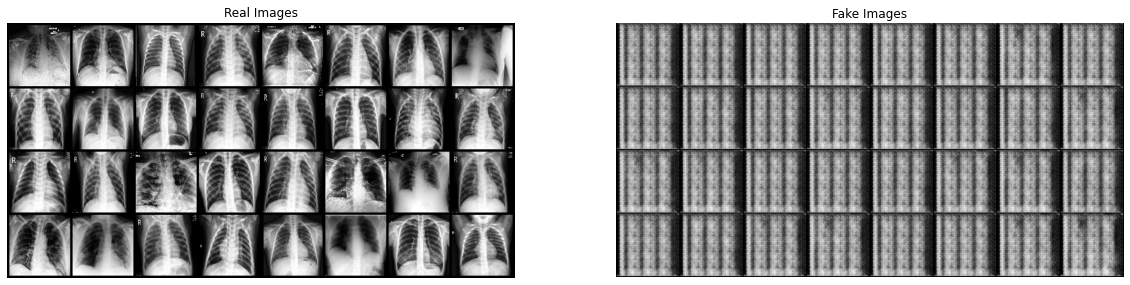

In [12]:
test_gan(acgan)

In [13]:
def plot_gan(name, train_epoch, values, path, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('train_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    plt.show()
    if save:
        now = datetime.datetime.now()
        get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
                        (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H-%M-%S")))

In [14]:
def save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs):
    now = datetime.datetime.now()
    g_losses = metrics['G_losses'][-1]
    d_losses = metrics['D_losses'][-1]
    path='GANAug/plots/ACGAN/train_%+.3f_%+.3f_%s'% (g_losses, d_losses, now.strftime("%Y-%m-%d_%H-%M-%S"))
    try:
        os.mkdir(os.path.join('.', path))
    except Exception as error:
        print(error)
    plot_gan('G_losses', num_epochs, metrics['G_losses'], path, True)
    plot_gan('D_losses', num_epochs, metrics['D_losses'], path, True)
    plot_gan('G_syn_losses', num_epochs, metrics['G_syn_losses'], path, True)
    plot_gan('G_class_losses', num_epochs, metrics['G_class_losses'], path, True)
    plot_gan('G_syn_losses', num_epochs, metrics['G_syn_losses'], path, True)
    plot_gan('D_class_losses', num_epochs, metrics['D_class_losses'], path, True)
    plot_gan('D_syn_losses', num_epochs, metrics['D_syn_losses'], path, True)
    plot_gan('Losses', num_epochs, metrics['Losses'], path, True)

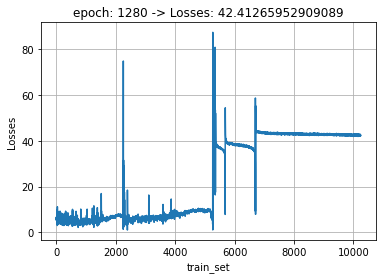

In [15]:
save_model(acgan.generator, acgan.discriminator, acgan.optimizer_g, acgan.optimizer_d, acgan.metrics, acgan.num_epoch)

Discriminator s tensor([[1.8539e-14],
        [1.1562e-13],
        [3.1139e-18],
        [1.2829e-15],
        [1.0469e-15],
        [8.4520e-14],
        [2.0206e-15],
        [3.0377e-15],
        [1.8792e-21],
        [1.7476e-14],
        [3.0430e-17],
        [1.0179e-14],
        [1.1982e-13],
        [5.7621e-13],
        [9.8726e-14],
        [8.7905e-14],
        [1.0394e-15],
        [2.6936e-13],
        [6.9168e-14],
        [2.0281e-16],
        [8.0616e-16],
        [8.8121e-16],
        [1.0336e-20],
        [3.6940e-17],
        [6.0147e-18],
        [1.6866e-14],
        [1.8104e-16],
        [8.2175e-19],
        [9.0712e-16],
        [1.7279e-13],
        [8.0114e-16],
        [3.2616e-13]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Discriminator c tensor([[-3.7392e-02, -5.7744e+00, -3.3934e+00],
        [-8.5581e-01, -4.3616e+00, -5.7572e-01],
        [-1.2811e+00, -9.2717e+00, -3.2549e-01],
        [-1.1378e+00, -8.2160e+00, -3.8682e-01],
        [-2.7211e-01, 

/tmp/ipykernel_501632/1298441974.py:118: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  c = self.softmax(c)


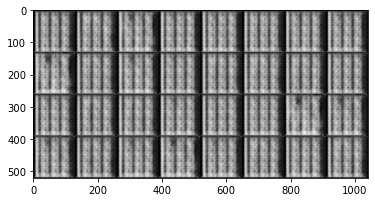

In [16]:
test_img_list = []
test_noise = torch.randn(acgan.batch_size, acgan.size_of_z, 1, 1, device=device)
test_label = torch.randn(acgan.batch_size, acgan.num_of_label, device=device)
test_img = acgan.generator(test_noise)

s_output, c_label_op = acgan.discriminator(test_img.detach().to(device))
print('Discriminator s', s_output)
print('Discriminator c', c_label_op)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))

class label for real tensor([2, 2, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 2, 1, 0, 0,
        2, 1, 0, 2, 1, 2, 2, 1])
Discriminator s tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9386],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Discriminator c tensor([[-2.1429e+01, -1.7578e+01,  0.0000e+00],
        [-1.5247e+01, -1.6412e+00, -2.1537e-01],
        [-2.8342e+01,  0.0000e+00, -1.7606e+01],
        [-5.9647e+00, -9.3055e+00, -2.6623e-03],
        [-1.6360

/tmp/ipykernel_501632/1298441974.py:118: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  c = self.softmax(c)


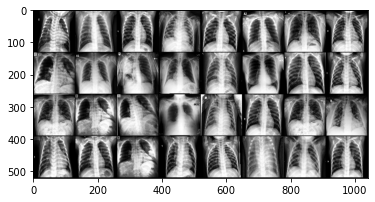

In [17]:
data = next(iter(acgan.test_loader))
test_noise, test_class_lable = data
test_img = test_noise
print('class label for real', test_class_lable)

s_output,c_label_op = acgan.discriminator(test_img.detach().to(device))
print('Discriminator s', s_output)
print('Discriminator c', c_label_op)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))